TODO: 1.teams -> capacity
      2. district colors plotting in JS
      3. a summary function in Partition

1. Candidate selection and plotting: Integrate this into Graph class. A candidate plot function
    grid populations, real and artificial candidates, other info
    plot and show all info in hover
2. Travel time calculations: Calculate it using R.  Need a plot function for this?


3. Tree saving and plotting: Fix the batch function. Complete the JS animation
4. Code the optimization part.
5. Find a method for random walk and code it up.
6. Read the routing paper.

In [1]:
import numpy as np
import geopandas as gpd
 
#import pickle 
#import random
#import json

from functools import partial
from types import MappingProxyType
#from tqdm import tqdm

from helper import DataHandler #add_to_data, add_to_graph, save_pickle, load_pickle
from functools import partial

from partition import Partition, Assignment
#from grid import Grid
from markovchain import SingleMetricOptimizer, hierarchical_recom

"Load data"

handler = DataHandler()
#graph = handler.load_graph()
graphhh = handler.load_graphhh()
#chicago = handler.load_chicago()
chicagooo = handler.load_chicagooo()
#candidates = handler.load_candidates()  # set of nodes
#travel_times_walking = handler.load_travel_walking()
#travel_times = handler.load_travel_times() # travel time between blocks is 10 minutes
#newtravel = handler.load_newtravel()
real_travel_times = handler.load_real_travel_times()

In [ ]:
# capacity level 2

import json
path = "/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-plots/data/trees-old/tree_547.json"
with open(path, 'r') as f:
        tree_json = json.load(f)

under_100 = 0
num_100 = 0
num_200 = 0
num_300 = 0
num_400 = 0
num_500 = 0
num_1000 = 0
num_1500 = 0
num_2000 = 0
num_2500 = 0
extremes = {}

epsilon = tree_json["metadata"]["epsilon"]
pop_target = tree_json["metadata"]["ideal_pop"]

interval_one = [(1-epsilon) * pop_target, (1+epsilon) * pop_target]
interval_two = [(1-epsilon) * pop_target * 2, (1+epsilon) * pop_target * 2]

for node_dict in tree_json["nodes"]:
    node = int(node_dict["id"])
    pop = graphhh.nodes[node]['population']
    
    if pop <= 100:
        under_100 += 1
    if pop >100:
        num_100 += 1
    if pop >200:
        num_200 += 1
    if pop >300:
        num_300 += 1
    if pop >400:
        num_400 += 1
    if pop > 500:
        num_500 += 1
    if pop > 1000:
        num_1000 += 1
    if pop > 1500:
        num_1500 += 1
    if pop > 2000:
        num_2000 += 1
    if pop > 2500:
        num_2500 += 1
        extremes[node] = pop         

print("total num of nodes ->", len(tree_json["nodes"]))
print("under 100 ->", under_100)    
print(">100->", num_100)
print(">200->", num_200)
print(">300->", num_300)
print(">400->", num_400)
print(">500->", num_500)
print(">1000->", num_1000) 
print(">1500->", num_1500) 
print(">2000->", num_2000) 
print(">2500->", num_2500)    
print("extremes ->", extremes)

print("--------------------------")
print("leftover population", tree_json["metadata"]["tot_pop"])
print("population target", pop_target)
print("pop interval for one team", interval_one)
print("pop interval for two teams", interval_two)

total num of nodes -> 739
under 100 -> 606
>100-> 133
>200-> 29
>300-> 13
>400-> 8
>500-> 4
>1000-> 2
>1500-> 2
>2000-> 2
>2500-> 2
extremes -> {17159: 3283, 5158: 4689}
--------------------------
leftover population 52921
population target 1559.75
pop interval for one team [1469.4999999999998, 1650.0000000000002]
pop interval for two teams [2938.9999999999995, 3300.0000000000005]


In [ ]:
"Initial partition"

graphhh.nodes[5158]["population"] = 100
graphhh.nodes[17159]["population"] = 100
pop = sum(graphhh.nodes[node]['population'] for node in graphhh.nodes)
#area = sum(graph.nodes[node]['area'] for node in graph.nodes)   
#avg_density = area / pop
# nodelarin density check i burda yapilip sonuc attribute olarak atansin. Attribute ismi simdilik density
#check_density = ?

Assignment.travel_times = MappingProxyType(real_travel_times)

"""try:"""
initial_solution = Partition.from_random_assignment(
graph=graphhh, 
assignment_class=Assignment,
capacity_level = 3,
epsilon=0.1,
pop_target = 1500,
#density = 0.5,
snapshot=True
)
"""except Exception as e:
    print(f"\nCaught the error. Entering debugger.")
    # This will drop you into an interactive debugging session
    %debug """


In [ ]:
"Plot initial partition"
#m, regions, chicago, geocenters = initial_solution.plot_map(attr="district")
#m
from falcomchain.helper.plot import Plot

plt = Plot()
"Plot side by side"
fig, regions_initial_new, regions_final_new, centers, others = plt.compare(initial_partition=initial_solution, final_partition=initial_solution)
fig

In [ ]:
m.save("map0.html")

In [2]:
Assignment.travel_times = MappingProxyType(real_travel_times)
initial_solution = Partition.load_partition(assignment_class=Assignment)

In [12]:
for part in initial_solution.parts:
    if len(initial_solution.parts[part]) <3:
        print(part)

In [6]:
# prepare a summary function in partition

num_districts_with_1 = sum(1 for part in initial_solution.teams if initial_solution.teams[part] == 1)
num_districts_with_2 = sum(1 for part in initial_solution.teams if initial_solution.teams[part] == 2)
num_districts_with_3 = sum(1 for part in initial_solution.teams if initial_solution.teams[part] == 3)

print(num_districts_with_1)
print(num_districts_with_2)
print(num_districts_with_3)

337
140
72


In [3]:
from falcomchain.constraints import within_percent_of_ideal_population


"Proposal and constraints"   # See how we call this in optimizer. 
proposal = partial(
    hierarchical_recom,
    epsilon=0.1,
    pop_target=1500,
    density = None,
    snapshot=True)
constraints = within_percent_of_ideal_population(initial_solution)


"Optimizer"
#sum_travel_radius = lambda p: np.sum(p.radius.values())
#num_cut_edges = lambda p: len(p["cut_edges"])
average_radius = lambda p: np.sum(((np.array(list(p.radius.values())) - np.sum(list(p.radius.values())) / len(p))**2))

optimizer = SingleMetricOptimizer(
    proposal=proposal,
    constraints=constraints,
    initial_state=initial_solution, 
    optimization_metric=average_radius,
    maximize=False)

In [ ]:
total_steps = 10000

# Short Bursts
min_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)
for i, part in enumerate(optimizer.short_bursts(5, 2000, with_progress_bar=True)):
    min_scores_sb[i] = optimizer.best_score
    scores_sb[i] = optimizer.score(part)


# Tilted Runs
min_scores_tilt = np.zeros(total_steps)
scores_tilt = np.zeros(total_steps)
for i, part in enumerate(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True)):
    print("state", i)
    min_scores_tilt[i] = optimizer.best_score
    scores_tilt[i] = optimizer.score(part)

  0%|          | 0/10000 [00:00<?, ?it/s]

state 0
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.


  0%|          | 5/10000 [00:00<14:08, 11.79it/s]

state 1
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
state 2
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 3
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
state 4
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 5
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


  0%|          | 11/10000 [00:00<09:37, 17.29it/s]

state 6
pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None
------ recursive function ends sucessfully.
state 7
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 8
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
state 9
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 10
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 11
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.


  0%|          | 17/10000 [00:01<08:29, 19.59it/s]

state 12
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 13
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 14
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 15
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
state 16
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 17
pop in superdistrict 4356
------ recursive function starts.
num of teams 3.
total pop 4356.
None


  0%|          | 23/10000 [00:01<07:59, 20.80it/s]

------ recursive function ends sucessfully.
state 18
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 19
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 20
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 21
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
state 22
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
state 23
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


  0%|          | 29/10000 [00:01<07:44, 21.49it/s]

state 24
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 25
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 26
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
state 27
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 28
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 29
pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None
------ recursive function ends sucessfully.


  0%|          | 35/10000 [00:01<07:39, 21.71it/s]

state 30
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 31
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
state 32
pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
state 33
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 34
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 35
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


  0%|          | 41/10000 [00:02<07:35, 21.87it/s]

state 36
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
state 37
pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None
------ recursive function ends sucessfully.
state 38
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
state 39
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 40
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.


  0%|          | 47/10000 [00:02<07:31, 22.05it/s]

state 41
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
state 42
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
state 43
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
state 44
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
state 45
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 46
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
state 47
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.

  1%|          | 53/10000 [00:02<07:32, 21.96it/s]

state 48
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
state 49
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 50
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
state 51
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
state 52
pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.


  1%|          | 59/10000 [00:02<07:31, 22.02it/s]

state 53
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
state 54
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 55
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
state 56
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 57
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 58
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
state 59


  1%|          | 62/10000 [00:03<07:53, 20.98it/s]

pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
state 60
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 61
pop in superdistrict 4562
------ recursive function starts.
num of teams 3.
total pop 4562.
None
------ recursive function ends sucessfully.
state 62
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
state 63
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
state 64


  1%|          | 68/10000 [00:03<08:55, 18.55it/s]

pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
state 65
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 66
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 67
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 68
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
state 69
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


  1%|          | 74/10000 [00:03<08:11, 20.18it/s]

state 70
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 71
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 72
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 73
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
state 74
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


  1%|          | 80/10000 [00:03<07:51, 21.02it/s]

state 75
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 76
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 77
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 78
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
state 79
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 80
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.


  1%|          | 86/10000 [00:04<07:46, 21.26it/s]

state 81
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
state 82
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
state 83
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 84
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
state 85
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


  1%|          | 89/10000 [00:04<07:42, 21.45it/s]

state 86
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 87
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 88
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 89
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 90
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


  1%|          | 95/10000 [00:04<07:38, 21.60it/s]

state 91
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 92
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 93
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 94
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
state 95
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


  1%|          | 101/10000 [00:04<07:41, 21.44it/s]

state 96
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 97
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
state 98
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
state 99
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 100
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
state 101
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.


  1%|          | 107/10000 [00:05<07:39, 21.53it/s]

state 102
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 103
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 104
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
state 105
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 106
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 107
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


  1%|          | 113/10000 [00:05<07:36, 21.66it/s]

state 108
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 109
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 110
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
state 111
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
state 112
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.


  1%|          | 119/10000 [00:05<07:36, 21.66it/s]

state 113
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 114
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
state 115
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
state 116
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
state 117
pop in superdistrict 4679
------ recursive function starts.
num of teams 3.
total pop 4679.
None
------ recursive function ends sucessfully.
state 118
pop in superdistrict 3043
------ recursive function starts.
num of teams 2.
total pop 3043.
None
------ recursive function ends sucessfully.
state 119
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total po

  1%|▏         | 125/10000 [00:06<07:36, 21.61it/s]

------ recursive function ends sucessfully.
state 120
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 121
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 122
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 123
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
state 124
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 125
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.


  1%|▏         | 131/10000 [00:06<07:35, 21.66it/s]

state 126
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 127
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
state 128
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 129
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 130
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
state 131
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


  1%|▏         | 137/10000 [00:06<08:09, 20.17it/s]

state 132
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 133
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 134
pop in superdistrict 4513
------ recursive function starts.
num of teams 3.
total pop 4513.
None
------ recursive function ends sucessfully.
state 135
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
state 136
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
state 137
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.


  1%|▏         | 140/10000 [00:06<07:59, 20.56it/s]

state 138
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 139
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
state 140
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
state 141
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.


  1%|▏         | 146/10000 [00:07<08:26, 19.47it/s]

state 142
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 143
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None
------ recursive function ends sucessfully.
state 144
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 145
pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.
state 146
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


  2%|▏         | 152/10000 [00:07<07:57, 20.62it/s]

state 147
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
state 148
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
state 149
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
state 150
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 151
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
state 152
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None


  2%|▏         | 158/10000 [00:07<07:45, 21.15it/s]

------ recursive function ends sucessfully.
state 153
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 154
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
state 155
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 156
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
state 157
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 158
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


  2%|▏         | 164/10000 [00:07<07:39, 21.39it/s]

state 159
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
state 160
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 161
pop in superdistrict 4513
------ recursive function starts.
num of teams 3.
total pop 4513.
None
------ recursive function ends sucessfully.
state 162
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
state 163
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
state 164
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


  2%|▏         | 170/10000 [00:08<07:36, 21.54it/s]

state 165
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
state 166
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
state 167
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 168
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 169
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 170
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.


  2%|▏         | 176/10000 [00:08<07:33, 21.66it/s]

state 171
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 172
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 173
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
state 174
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 175
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
state 176
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


  2%|▏         | 182/10000 [00:08<07:38, 21.41it/s]

state 177
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 178
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 179
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 180
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
state 181
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 182
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


  2%|▏         | 188/10000 [00:09<07:35, 21.54it/s]

state 183
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 184
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
state 185
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 186
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
state 187
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 188


  2%|▏         | 194/10000 [00:09<07:34, 21.59it/s]

pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
state 189
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
state 190
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 191
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 192
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 193
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
state 194
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
No

  2%|▏         | 200/10000 [00:09<07:34, 21.56it/s]

state 195
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 196
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 197
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 198
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 199
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
state 200
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.


  2%|▏         | 206/10000 [00:09<07:33, 21.58it/s]

state 201
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 202
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 203
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
state 204
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 205
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
state 206
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


  2%|▏         | 209/10000 [00:10<07:33, 21.57it/s]

state 207
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 208
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 209
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 210
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
state 211


  2%|▏         | 215/10000 [00:10<07:55, 20.56it/s]

pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 212
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 213
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 214
pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.
state 215
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 216
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.


  2%|▏         | 221/10000 [00:10<07:48, 20.88it/s]

state 217
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 218
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 219
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 220
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
state 221
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.


  2%|▏         | 224/10000 [00:10<07:42, 21.13it/s]

state 222
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 223
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
state 224
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 225
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


  2%|▏         | 230/10000 [00:11<08:16, 19.69it/s]

state 226
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 227
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
state 228
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
state 229
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
state 230
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.


  2%|▏         | 236/10000 [00:11<07:54, 20.57it/s]

state 231
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
state 232
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 233
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
state 234
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 235
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 236


  2%|▏         | 242/10000 [00:11<07:45, 20.97it/s]

pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
state 237
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 238
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 239
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 240
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 241
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
state 242


  2%|▏         | 248/10000 [00:11<07:41, 21.15it/s]

pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
state 243
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 244
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
state 245
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
state 246
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 247
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 248
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
No

  3%|▎         | 254/10000 [00:12<07:37, 21.28it/s]

state 249
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 250
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 251
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
state 252
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 253
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.


  3%|▎         | 260/10000 [00:12<07:36, 21.31it/s]

state 254
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 255
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 256
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 257
pop in superdistrict 4560
------ recursive function starts.
num of teams 3.
total pop 4560.
None
------ recursive function ends sucessfully.
state 258
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 259
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.


  3%|▎         | 266/10000 [00:12<07:38, 21.23it/s]

state 260
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
state 261
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
state 262
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 263
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 264
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 265
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 266
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total po

  3%|▎         | 272/10000 [00:13<07:35, 21.34it/s]

state 267
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 268
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 269
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 270
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 271
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.


  3%|▎         | 275/10000 [00:13<07:35, 21.34it/s]

state 272
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 273
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
state 274
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 275
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 276
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


  3%|▎         | 281/10000 [00:13<08:04, 20.05it/s]

state 277
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 278
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 279
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
state 280
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 281
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.


  3%|▎         | 287/10000 [00:13<07:48, 20.75it/s]

state 282
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 283
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 284
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
state 285
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 286
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 287
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


  3%|▎         | 293/10000 [00:14<07:39, 21.14it/s]

state 288
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
state 289
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 290
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
state 291
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 292
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 293


  3%|▎         | 299/10000 [00:14<07:37, 21.19it/s]

pop in superdistrict 4630
------ recursive function starts.
num of teams 3.
total pop 4630.
None
------ recursive function ends sucessfully.
state 294
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 295
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
state 296
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 297
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
state 298
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 299
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
No

  3%|▎         | 305/10000 [00:14<07:36, 21.24it/s]

state 300
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 301
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 302
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 303
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 304
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
state 305
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.


  3%|▎         | 308/10000 [00:14<08:29, 19.04it/s]

state 306
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 307
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 308
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 309
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.


  3%|▎         | 314/10000 [00:15<08:03, 20.01it/s]

state 310
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 311
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
state 312
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 313
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 314
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


  3%|▎         | 320/10000 [00:15<07:47, 20.70it/s]

state 315
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 316
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 317
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 318
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 319
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 320
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.


  3%|▎         | 326/10000 [00:15<07:40, 21.01it/s]

state 321
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
state 322
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 323
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 324
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
state 325
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 326
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


  3%|▎         | 332/10000 [00:15<07:35, 21.24it/s]

state 327
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 328
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 329
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
state 330
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 331
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


  3%|▎         | 335/10000 [00:16<07:35, 21.21it/s]

state 332
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 333
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 334
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 335
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 336
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
state 337


  3%|▎         | 341/10000 [00:16<07:36, 21.16it/s]

pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 338
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.
state 339
pop in superdistrict 4679
------ recursive function starts.
num of teams 3.
total pop 4679.
None
------ recursive function ends sucessfully.
state 340
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 341
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
state 342
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.


  3%|▎         | 347/10000 [00:16<07:32, 21.32it/s]

state 343
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 344
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
state 345
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 346
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
state 347
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.


  4%|▎         | 350/10000 [00:16<08:05, 19.89it/s]

state 348
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 349
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 350
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 351
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.


  4%|▎         | 356/10000 [00:17<07:47, 20.62it/s]

state 352
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
state 353
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 354
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 355
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
state 356
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.


  4%|▎         | 362/10000 [00:17<07:41, 20.90it/s]

state 357
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 358
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 359
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 360
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
state 361
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
state 362
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.


  4%|▎         | 368/10000 [00:17<07:34, 21.19it/s]

state 363
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 364
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 365
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 366
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
state 367
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


  4%|▎         | 371/10000 [00:17<07:33, 21.22it/s]

state 368
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
state 369
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
state 370
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
state 371
pop in superdistrict 4293
------ recursive function starts.
num of teams 3.
total pop 4293.
None
------ recursive function ends sucessfully.
state 372
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


  4%|▍         | 377/10000 [00:18<07:38, 20.99it/s]

state 373
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 374
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 375
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 376
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 377
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


  4%|▍         | 383/10000 [00:18<07:34, 21.17it/s]

state 378
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 379
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 380
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 381
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 382
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 383
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.


  4%|▍         | 389/10000 [00:18<07:33, 21.21it/s]

state 384
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 385
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 386
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 387
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 388
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 389
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.


  4%|▍         | 395/10000 [00:18<07:31, 21.30it/s]

state 390
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 391
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 392
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 393
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 394
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 395
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


  4%|▍         | 398/10000 [00:19<07:32, 21.22it/s]

state 396
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 397
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 398
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 399
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.


  4%|▍         | 404/10000 [00:19<08:06, 19.72it/s]

state 400
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 401
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 402
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 403
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
state 404
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.


  4%|▍         | 410/10000 [00:19<07:47, 20.49it/s]

state 405
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 406
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
state 407
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
state 408
pop in superdistrict 4708
------ recursive function starts.
num of teams 3.
total pop 4708.
None
------ recursive function ends sucessfully.
state 409
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
state 410
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


  4%|▍         | 413/10000 [00:19<08:13, 19.44it/s]

state 411
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 412
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
state 413
pop in superdistrict 4560
------ recursive function starts.
num of teams 3.
total pop 4560.
None
------ recursive function ends sucessfully.
state 414
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


  4%|▍         | 419/10000 [00:20<07:53, 20.23it/s]

state 415
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 416
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
state 417
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
state 418
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 419
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.


  4%|▍         | 425/10000 [00:20<07:39, 20.82it/s]

state 420
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 421
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
state 422
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.
state 423
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 424
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 425
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


  4%|▍         | 431/10000 [00:20<07:32, 21.14it/s]

state 426
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 427
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 428
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 429
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
state 430
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 431
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.


  4%|▍         | 437/10000 [00:21<07:30, 21.21it/s]

state 432
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 433
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 434
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
state 435
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 436
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


  4%|▍         | 440/10000 [00:21<07:31, 21.17it/s]

state 437
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 438
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 439
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
state 440
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
state 441
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.


  4%|▍         | 446/10000 [00:21<07:34, 21.00it/s]

state 442
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 443
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
state 444
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
state 445
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 446
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


  5%|▍         | 452/10000 [00:21<07:30, 21.18it/s]

state 447
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
state 448
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 449
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 450
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
state 451
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 452
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.


  5%|▍         | 458/10000 [00:22<07:28, 21.29it/s]

state 453
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
state 454
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 455
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
state 456
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 457
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 458
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.


  5%|▍         | 464/10000 [00:22<07:28, 21.28it/s]

state 459
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
state 460
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 461
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 462
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 463
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
state 464
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


  5%|▍         | 470/10000 [00:22<07:29, 21.19it/s]

state 465
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 466
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
state 467
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
state 468
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
state 469
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 470
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


  5%|▍         | 476/10000 [00:22<07:58, 19.89it/s]

state 471
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
state 472
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
state 473
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 474
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 475
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 476
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.


  5%|▍         | 482/10000 [00:23<08:16, 19.17it/s]

state 477
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 478
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 479
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 480
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
state 481
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
state 482
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.


  5%|▍         | 488/10000 [00:23<07:52, 20.15it/s]

state 483
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
state 484
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
state 485
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 486
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 487
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 488
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


  5%|▍         | 494/10000 [00:23<07:39, 20.68it/s]

state 489
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 490
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 491
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
state 492
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 493
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.


  5%|▍         | 497/10000 [00:23<07:36, 20.81it/s]

state 494
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
state 495
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
state 496
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 497
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 498
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 499


  5%|▌         | 503/10000 [00:24<07:35, 20.86it/s]

pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 500
pop in superdistrict 4559
------ recursive function starts.
num of teams 3.
total pop 4559.
None
------ recursive function ends sucessfully.
state 501
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
state 502
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 503
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 504
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.


  5%|▌         | 509/10000 [00:24<07:33, 20.92it/s]

state 505
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 506
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 507
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
state 508
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 509
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.


  5%|▌         | 515/10000 [00:24<07:32, 20.95it/s]

state 510
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 511
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 512
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 513
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
state 514
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 515
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


  5%|▌         | 521/10000 [00:25<07:31, 20.99it/s]

state 516
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 517
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
state 518
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 519
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
state 520
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


  5%|▌         | 524/10000 [00:25<07:30, 21.02it/s]

state 521
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 522
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 523
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 524
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 525
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


  5%|▌         | 530/10000 [00:25<07:36, 20.72it/s]

state 526
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 527
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 528
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 529
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
state 530
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


  5%|▌         | 533/10000 [00:25<07:38, 20.66it/s]

state 531
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
state 532
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 533
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 534
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 535


  5%|▌         | 541/10000 [00:26<08:02, 19.62it/s]

pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
state 536
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
state 537
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 538
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 539
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 540
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 541
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
No

  5%|▌         | 547/10000 [00:26<07:47, 20.23it/s]

state 542
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 543
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 544
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 545
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 546
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 547
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.


  6%|▌         | 553/10000 [00:26<07:37, 20.65it/s]

state 548
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
state 549
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
state 550
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 551
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 552
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 553
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


  6%|▌         | 559/10000 [00:26<07:30, 20.94it/s]

state 554
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
state 555
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 556
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 557
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
state 558
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 559
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


  6%|▌         | 565/10000 [00:27<07:26, 21.14it/s]

state 560
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
state 561
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
state 562
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 563
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 564
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
state 565
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.


  6%|▌         | 571/10000 [00:27<07:27, 21.08it/s]

state 566
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 567
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
state 568
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
state 569
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 570
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


  6%|▌         | 574/10000 [00:27<07:27, 21.08it/s]

state 571
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 572
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.
state 573
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 574
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
state 575
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.


  6%|▌         | 580/10000 [00:28<08:07, 19.31it/s]

state 576
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
state 577
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
state 578
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 579
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
state 580
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


  6%|▌         | 586/10000 [00:28<07:49, 20.07it/s]

state 581
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 582
pop in superdistrict 2858
------ recursive function starts.
num of teams 2.
total pop 2858.
None
------ recursive function ends sucessfully.
state 583
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 584
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
state 585
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 586
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.


  6%|▌         | 592/10000 [00:28<07:36, 20.63it/s]

state 587
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 588
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
state 589
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
state 590
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 591
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 592
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.


  6%|▌         | 598/10000 [00:28<08:00, 19.58it/s]

state 593
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
state 594
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 595
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 596
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 597
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 598
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


  6%|▌         | 604/10000 [00:29<07:41, 20.37it/s]

state 599
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
state 600
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
state 601
pop in superdistrict 4504
------ recursive function starts.
num of teams 3.
total pop 4504.
None
------ recursive function ends sucessfully.
state 602
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 603
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
state 604
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.


  6%|▌         | 610/10000 [00:29<07:35, 20.61it/s]

state 605
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 606
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 607
pop in superdistrict 4514
------ recursive function starts.
num of teams 3.
total pop 4514.
None
------ recursive function ends sucessfully.
state 608
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 609
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 610
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.


  6%|▌         | 616/10000 [00:29<07:29, 20.89it/s]

state 611
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 612
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 613
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 614
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 615
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
state 616
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


  6%|▌         | 622/10000 [00:30<07:32, 20.71it/s]

state 617
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 618
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 619
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 620
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
state 621
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
state 622
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.


  6%|▋         | 628/10000 [00:30<07:28, 20.91it/s]

state 623
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 624
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 625
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 626
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 627
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 628
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


  6%|▋         | 634/10000 [00:30<07:25, 21.04it/s]

state 629
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 630
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
state 631
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 632
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 633
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
state 634
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


  6%|▋         | 640/10000 [00:30<07:28, 20.87it/s]

state 635
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 636
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 637
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
state 638
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 639
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


  6%|▋         | 643/10000 [00:31<07:26, 20.95it/s]

state 640
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
state 641
pop in superdistrict 3003
------ recursive function starts.
num of teams 2.
total pop 3003.
None
------ recursive function ends sucessfully.
state 642
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 643
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 644
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


  6%|▋         | 649/10000 [00:31<07:24, 21.02it/s]

state 645
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
state 646
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 647
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 648
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 649
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.


  7%|▋         | 655/10000 [00:31<07:23, 21.06it/s]

state 650
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 651
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 652
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
state 653
pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
state 654
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 655
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


  7%|▋         | 658/10000 [00:31<07:50, 19.84it/s]

state 656
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 657
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
state 658
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
state 659
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.


  7%|▋         | 664/10000 [00:32<07:43, 20.15it/s]

state 660
pop in superdistrict 4586
------ recursive function starts.
num of teams 3.
total pop 4586.
None
------ recursive function ends sucessfully.
state 661
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 662
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 663
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 664


  7%|▋         | 670/10000 [00:32<08:06, 19.19it/s]

pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.
state 665
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
state 666
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 667
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 668
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 669
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 670
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
No

  7%|▋         | 676/10000 [00:32<07:42, 20.16it/s]

state 671
pop in superdistrict 2954
------ recursive function starts.
num of teams 2.
total pop 2954.
None
------ recursive function ends sucessfully.
state 672
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
state 673
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
state 674
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 675
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 676
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.


  7%|▋         | 682/10000 [00:32<07:32, 20.58it/s]

state 677
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 678
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
state 679
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 680
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
state 681
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 682
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


  7%|▋         | 688/10000 [00:33<07:33, 20.53it/s]

state 683
pop in superdistrict 4673
------ recursive function starts.
num of teams 3.
total pop 4673.
None
------ recursive function ends sucessfully.
state 684
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
state 685
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
state 686
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
state 687
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
state 688
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


  7%|▋         | 694/10000 [00:33<07:28, 20.77it/s]

state 689
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 690
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 691
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
state 692
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 693
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


  7%|▋         | 697/10000 [00:33<07:26, 20.81it/s]

state 694
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 695
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
state 696
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 697
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
state 698
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.


  7%|▋         | 703/10000 [00:33<07:27, 20.80it/s]

state 699
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
state 700
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
state 701
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
state 702
pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None
------ recursive function ends sucessfully.


  7%|▋         | 709/10000 [00:34<07:46, 19.91it/s]

state 703
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 704
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 705
pop in superdistrict 4673
------ recursive function starts.
num of teams 3.
total pop 4673.
None
------ recursive function ends sucessfully.
state 706
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
state 707
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
state 708
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
state 709
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total po

  7%|▋         | 715/10000 [00:34<07:36, 20.36it/s]

state 710
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
state 711
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 712
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 713
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 714
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


  7%|▋         | 718/10000 [00:34<07:33, 20.46it/s]

state 715
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
state 716
pop in superdistrict 4562
------ recursive function starts.
num of teams 3.
total pop 4562.
None
------ recursive function ends sucessfully.
state 717
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 718
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 719
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.


  7%|▋         | 724/10000 [00:35<07:30, 20.60it/s]

state 720
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 721
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 722
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 723
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
state 724
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


  7%|▋         | 730/10000 [00:35<07:31, 20.51it/s]

state 725
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 726
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 727
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 728
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
state 729
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
state 730
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


  7%|▋         | 736/10000 [00:35<07:29, 20.59it/s]

state 731
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
state 732
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 733
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 734
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 735
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 736
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.


  7%|▋         | 742/10000 [00:35<07:24, 20.81it/s]

state 737
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 738
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
state 739
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 740
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 741
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 742
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


  7%|▋         | 748/10000 [00:36<07:22, 20.91it/s]

state 743
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 744
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 745
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 746
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 747
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
state 748
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


  8%|▊         | 754/10000 [00:36<07:26, 20.70it/s]

state 749
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
state 750
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 751
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
state 752
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 753
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 754
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


  8%|▊         | 757/10000 [00:36<07:35, 20.28it/s]

state 755
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
state 756
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 757
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


  8%|▊         | 760/10000 [00:36<09:53, 15.57it/s]

state 758
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 759
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 760
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
state 761


  8%|▊         | 764/10000 [00:37<09:11, 16.75it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 762
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 763
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 764
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
state 765
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 766


  8%|▊         | 772/10000 [00:37<08:03, 19.07it/s]

pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
state 767
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
state 768
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
state 769
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 770
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
state 771
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 772
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
No

  8%|▊         | 777/10000 [00:37<07:53, 19.50it/s]

state 773
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 774
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
state 775
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
state 776
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 777
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


  8%|▊         | 783/10000 [00:38<07:36, 20.20it/s]

state 778
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 779
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 780
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 781
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 782
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 783
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.


  8%|▊         | 789/10000 [00:38<07:30, 20.44it/s]

state 784
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 785
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 786
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
state 787
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
state 788
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 789
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


  8%|▊         | 795/10000 [00:38<07:31, 20.40it/s]

state 790
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
state 791
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 792
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 793
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 794
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
state 795
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


  8%|▊         | 801/10000 [00:38<07:23, 20.75it/s]

state 796
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 797
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 798
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 799
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 800
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 801
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


  8%|▊         | 807/10000 [00:39<07:20, 20.86it/s]

state 802
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
state 803
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
state 804
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 805
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 806
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.


  8%|▊         | 810/10000 [00:39<07:20, 20.87it/s]

state 807
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
state 808
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 809
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
state 810
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
state 811
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


  8%|▊         | 816/10000 [00:39<07:58, 19.18it/s]

state 812
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
state 813
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
state 814
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 815
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 816
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.


  8%|▊         | 822/10000 [00:39<07:37, 20.04it/s]

state 817
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 818
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 819
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 820
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 821
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 822
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


  8%|▊         | 828/10000 [00:40<07:30, 20.36it/s]

state 823
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 824
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
state 825
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
state 826
pop in superdistrict 4679
------ recursive function starts.
num of teams 3.
total pop 4679.
None
------ recursive function ends sucessfully.
state 827
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.


  8%|▊         | 834/10000 [00:40<07:26, 20.53it/s]

state 828
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
state 829
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 830
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
state 831
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
state 832
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 833
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 834
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total po

  8%|▊         | 840/10000 [00:40<07:28, 20.44it/s]

------ recursive function ends sucessfully.
state 835
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 836
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 837
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 838
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 839
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 840
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


  8%|▊         | 843/10000 [00:41<07:28, 20.43it/s]

state 841
pop in superdistrict 4561
------ recursive function starts.
num of teams 3.
total pop 4561.
None
------ recursive function ends sucessfully.
state 842
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
state 843
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
state 844
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


  8%|▊         | 849/10000 [00:41<08:04, 18.88it/s]

state 845
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 846
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 847
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 848
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
state 849
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


  9%|▊         | 855/10000 [00:41<07:45, 19.63it/s]

state 850
pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.
state 851
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 852
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 853
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 854
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 855
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


  9%|▊         | 861/10000 [00:41<07:37, 19.96it/s]

state 856
pop in superdistrict 4679
------ recursive function starts.
num of teams 3.
total pop 4679.
None
------ recursive function ends sucessfully.
state 857
pop in superdistrict 4586
------ recursive function starts.
num of teams 3.
total pop 4586.
None
------ recursive function ends sucessfully.
state 858
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
state 859
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 860
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 861
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


  9%|▊         | 867/10000 [00:42<07:30, 20.28it/s]

state 862
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
state 863
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 864
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
state 865
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
state 866
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


  9%|▊         | 870/10000 [00:42<07:53, 19.26it/s]

state 867
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 868
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
state 869
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
state 870
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


  9%|▉         | 876/10000 [00:42<07:37, 19.94it/s]

state 871
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 872
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
state 873
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 874
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
state 875
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
state 876
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


  9%|▉         | 882/10000 [00:43<07:28, 20.35it/s]

state 877
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
state 878
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 879
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 880
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 881
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


  9%|▉         | 885/10000 [00:43<07:31, 20.20it/s]

state 882
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 883
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 884
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 885
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 886
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.


  9%|▉         | 891/10000 [00:43<07:27, 20.37it/s]

state 887
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 888
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 889
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
state 890
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
state 891
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


  9%|▉         | 897/10000 [00:43<07:31, 20.14it/s]

state 892
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 893
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 894
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 895
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
state 896
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 897
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


  9%|▉         | 903/10000 [00:44<07:28, 20.28it/s]

state 898
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 899
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 900
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 901
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 902
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
state 903
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


  9%|▉         | 909/10000 [00:44<07:24, 20.43it/s]

state 904
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
state 905
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 906
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
state 907
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
state 908
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 909
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


  9%|▉         | 915/10000 [00:44<07:25, 20.37it/s]

state 910
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 911
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
state 912
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 913
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
state 914
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.


  9%|▉         | 918/10000 [00:44<07:48, 19.38it/s]

state 915
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
state 916
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
state 917
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 918
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


  9%|▉         | 922/10000 [00:45<08:02, 18.80it/s]

state 919
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 920
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 921
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 922
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 923
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


  9%|▉         | 927/10000 [00:45<07:43, 19.59it/s]

state 924
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
state 925
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 926
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
state 927
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 928
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.


  9%|▉         | 932/10000 [00:45<07:43, 19.56it/s]

state 929
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
state 930
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 931
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 932
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.


  9%|▉         | 936/10000 [00:45<07:51, 19.24it/s]

state 933
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 934
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 935
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 936
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


  9%|▉         | 940/10000 [00:46<09:33, 15.80it/s]

state 937
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 938
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
state 939
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


  9%|▉         | 944/10000 [00:46<09:34, 15.78it/s]

state 940
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 941
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 942
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 943
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


  9%|▉         | 948/10000 [00:46<09:17, 16.23it/s]

state 944
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 945
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 946
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 947
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 948
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 10%|▉         | 952/10000 [00:46<08:44, 17.26it/s]

state 949
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
state 950
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 951
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 952
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 953


 10%|▉         | 956/10000 [00:46<08:10, 18.44it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 954
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 955
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 956
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 957
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 10%|▉         | 961/10000 [00:47<08:30, 17.70it/s]

state 958
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 959
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
state 960
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 961
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.


 10%|▉         | 965/10000 [00:47<08:15, 18.23it/s]

state 962
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 963
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
state 964
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 965
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
state 966
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 10%|▉         | 970/10000 [00:47<07:51, 19.14it/s]

state 967
pop in superdistrict 4560
------ recursive function starts.
num of teams 3.
total pop 4560.
None
------ recursive function ends sucessfully.
state 968
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
state 969
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
state 970
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 971
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None


 10%|▉         | 975/10000 [00:47<07:57, 18.91it/s]

------ recursive function ends sucessfully.
state 972
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 973
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
state 974
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
state 975
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 10%|▉         | 979/10000 [00:48<07:48, 19.26it/s]

state 976
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 977
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
state 978
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
state 979
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 980
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.


 10%|▉         | 984/10000 [00:48<07:38, 19.65it/s]

state 981
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 982
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 983
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 984
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
state 985
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.


 10%|▉         | 990/10000 [00:48<07:25, 20.21it/s]

state 986
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
state 987
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
state 988
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 989
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 990
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.


 10%|▉         | 996/10000 [00:49<07:24, 20.27it/s]

state 991
pop in superdistrict 4551
------ recursive function starts.
num of teams 3.
total pop 4551.
None
------ recursive function ends sucessfully.
state 992
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 993
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
state 994
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 995
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 996
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 10%|█         | 1002/10000 [00:49<07:23, 20.29it/s]

state 997
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
state 998
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 999
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 1000
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 1001
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 10%|█         | 1005/10000 [00:49<07:29, 20.00it/s]

state 1002
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
state 1003
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 1004
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 1005
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
state 1006
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.


 10%|█         | 1011/10000 [00:49<07:59, 18.75it/s]

state 1007
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 1008
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
state 1009
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
state 1010
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 1011
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 10%|█         | 1016/10000 [00:50<07:45, 19.32it/s]

state 1012
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 1013
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 1014
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 1015
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
state 1016
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 10%|█         | 1022/10000 [00:50<07:31, 19.88it/s]

state 1017
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 1018
pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.
state 1019
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 1020
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
state 1021
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1022
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.


 10%|█         | 1025/10000 [00:50<07:26, 20.09it/s]

state 1023
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 1024
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 1025
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
state 1026
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 10%|█         | 1030/10000 [00:50<08:06, 18.45it/s]

state 1027
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
state 1028
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
state 1029
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
state 1030
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 1031
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 10%|█         | 1035/10000 [00:51<07:48, 19.13it/s]

state 1032
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 1033
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
state 1034
pop in superdistrict 4562
------ recursive function starts.
num of teams 3.
total pop 4562.
None
------ recursive function ends sucessfully.
state 1035
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.


 10%|█         | 1039/10000 [00:51<08:11, 18.22it/s]

state 1036
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
state 1037
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
state 1038
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 1039
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.


 10%|█         | 1044/10000 [00:51<08:11, 18.23it/s]

state 1040
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
state 1041
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
state 1042
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1043
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 1044
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 10%|█         | 1049/10000 [00:51<07:54, 18.85it/s]

state 1045
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1046
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1047
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
state 1048
pop in superdistrict 4480
------ recursive function starts.
num of teams 3.
total pop 4480.
None
------ recursive function ends sucessfully.
state 1049
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 11%|█         | 1055/10000 [00:52<07:33, 19.72it/s]

state 1050
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 1051
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 1052
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
state 1053
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 1054
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 1055
pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.


 11%|█         | 1061/10000 [00:52<07:29, 19.89it/s]

state 1056
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 1057
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
state 1058
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 1059
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
state 1060
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 1061
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


 11%|█         | 1067/10000 [00:52<07:21, 20.22it/s]

state 1062
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 1063
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 1064
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1065
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 1066
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 11%|█         | 1072/10000 [00:52<07:53, 18.86it/s]

state 1067
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 1068
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
state 1069
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 1070
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
state 1071
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 1072
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


 11%|█         | 1077/10000 [00:53<07:46, 19.14it/s]

state 1073
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 1074
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 1075
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 1076
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1077
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 11%|█         | 1083/10000 [00:53<07:28, 19.89it/s]

state 1078
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
state 1079
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1080
pop in superdistrict 4504
------ recursive function starts.
num of teams 3.
total pop 4504.
None
------ recursive function ends sucessfully.
state 1081
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1082
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1083
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.


 11%|█         | 1089/10000 [00:53<07:22, 20.15it/s]

state 1084
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 1085
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 1086
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 1087
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1088
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 11%|█         | 1095/10000 [00:54<07:15, 20.47it/s]

state 1089
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 1090
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 1091
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1092
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
state 1093
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
state 1094
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 11%|█         | 1098/10000 [00:54<07:15, 20.43it/s]

state 1095
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
state 1096
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 1097
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 1098
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
state 1099
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 11%|█         | 1104/10000 [00:54<07:51, 18.88it/s]

state 1100
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 1101
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 1102
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 1103
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1104
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 11%|█         | 1109/10000 [00:54<07:43, 19.19it/s]

state 1105
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
state 1106
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
state 1107
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 1108
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
state 1109
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.


 11%|█         | 1113/10000 [00:55<08:46, 16.87it/s]

state 1110
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
state 1111
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 1112
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
state 1113
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.


 11%|█         | 1117/10000 [00:55<08:37, 17.15it/s]

state 1114
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 1115
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 1116
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
state 1117
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 1118


 11%|█         | 1121/10000 [00:55<08:04, 18.34it/s]

pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
state 1119
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
state 1120
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
state 1121
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1122
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1126/10000 [00:55<07:55, 18.64it/s]

state 1123
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 1124
pop in superdistrict 4586
------ recursive function starts.
num of teams 3.
total pop 4586.
None
------ recursive function ends sucessfully.
state 1125
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 1126
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1132/10000 [00:56<07:28, 19.77it/s]

state 1127
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 1128
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
state 1129
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 1130
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1131
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 1132
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1137/10000 [00:56<07:26, 19.87it/s]

state 1133
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
state 1134
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 1135
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
state 1136
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 1137
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1143/10000 [00:56<07:19, 20.14it/s]

state 1138
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 1139
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 1140
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 1141
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 1142
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 1143
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1149/10000 [00:56<07:19, 20.15it/s]

state 1144
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
state 1145
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
state 1146
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 1147
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 1148
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 1149
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1155/10000 [00:57<07:29, 19.68it/s]

state 1150
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 1151
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
state 1152
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
state 1153
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 1154
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 1155
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1159/10000 [00:57<07:31, 19.58it/s]

state 1156
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 1157
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 1158
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
state 1159
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1160


 12%|█▏        | 1163/10000 [00:57<07:38, 19.26it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
state 1161
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
state 1162
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 1163
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1168/10000 [00:57<07:31, 19.55it/s]

state 1164
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
state 1165
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
state 1166
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1167
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 1168
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1169
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1174/10000 [00:58<07:22, 19.93it/s]

state 1170
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
state 1171
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
state 1172
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
state 1173
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 1174
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1179/10000 [00:58<07:22, 19.94it/s]

state 1175
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 1176
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 1177
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 1178
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 1179
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1185/10000 [00:58<07:17, 20.13it/s]

state 1180
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 1181
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 1182
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
state 1183
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 1184
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 1185
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1190/10000 [00:59<08:01, 18.30it/s]

state 1186
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 1187
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None
------ recursive function ends sucessfully.
state 1188
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 1189
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
state 1190
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1195/10000 [00:59<07:47, 18.83it/s]

state 1191
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 1192
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
state 1193
pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.
state 1194
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 1195
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1201/10000 [00:59<07:29, 19.59it/s]

state 1196
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 1197
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
state 1198
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1199
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 1200
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 1201
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1205/10000 [00:59<07:35, 19.30it/s]

state 1202
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 1203
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
state 1204
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 1205
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 1206
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1210/10000 [01:00<07:44, 18.94it/s]

state 1207
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1208
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 1209
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
state 1210
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1214/10000 [01:00<07:46, 18.84it/s]

state 1211
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 1212
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 1213
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 1214
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 1215


 12%|█▏        | 1218/10000 [01:00<08:50, 16.54it/s]

pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 1216
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 1217
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1222/10000 [01:00<08:28, 17.25it/s]

state 1218
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 1219
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 1220
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 1221
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 1222
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1226/10000 [01:01<08:14, 17.73it/s]

state 1223
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
state 1224
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1225
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 1226
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1230/10000 [01:01<08:05, 18.06it/s]

state 1227
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 1228
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
state 1229
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
state 1230
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1234/10000 [01:01<07:48, 18.72it/s]

state 1231
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 1232
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 1233
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 1234
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 1235
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1239/10000 [01:01<07:32, 19.35it/s]

state 1236
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 1237
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
state 1238
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
state 1239
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
state 1240


 12%|█▏        | 1245/10000 [01:02<07:30, 19.44it/s]

pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 1241
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 1242
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 1243
pop in superdistrict 4561
------ recursive function starts.
num of teams 3.
total pop 4561.
None
------ recursive function ends sucessfully.
state 1244
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 12%|█▎        | 1250/10000 [01:02<07:24, 19.67it/s]

state 1245
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 1246
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
state 1247
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 1248
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 1249
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 1250
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1254/10000 [01:02<07:34, 19.25it/s]

state 1251
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 1252
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 1253
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
state 1254
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1259/10000 [01:02<07:25, 19.62it/s]

state 1255
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 1256
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 1257
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 1258
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 1259
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1263/10000 [01:02<07:23, 19.68it/s]

state 1260
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1261
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 1262
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 1263
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1264


 13%|█▎        | 1269/10000 [01:03<07:34, 19.22it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
state 1265
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 1266
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 1267
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
state 1268
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1273/10000 [01:03<08:11, 17.76it/s]

state 1269
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 1270
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
state 1271
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 1272
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 1273
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1277/10000 [01:03<08:00, 18.17it/s]

state 1274
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 1275
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
state 1276
pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.
state 1277
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1281/10000 [01:03<07:58, 18.21it/s]

state 1278
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 1279
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 1280
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
state 1281
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1285/10000 [01:04<07:50, 18.54it/s]

state 1282
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 1283
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 1284
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 1285
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1289/10000 [01:04<07:42, 18.82it/s]

state 1286
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 1287
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 1288
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 1289
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
state 1290
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None


 13%|█▎        | 1294/10000 [01:04<07:42, 18.84it/s]

------ recursive function ends sucessfully.
state 1291
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
state 1292
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 1293
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 1294
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1298/10000 [01:04<08:41, 16.70it/s]

state 1295
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
state 1296
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
state 1297
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
state 1298
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1302/10000 [01:05<08:05, 17.91it/s]

state 1299
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 1300
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 1301
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 1302
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
state 1303


 13%|█▎        | 1306/10000 [01:05<07:46, 18.62it/s]

pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 1304
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 1305
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 1306
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 1307
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1311/10000 [01:05<09:21, 15.47it/s]

state 1308
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 1309
pop in superdistrict 4678
------ recursive function starts.
num of teams 3.
total pop 4678.
None
------ recursive function ends sucessfully.
state 1310
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1316/10000 [01:05<08:16, 17.51it/s]

state 1311
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 1312
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 1313
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 1314
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
state 1315
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 1316
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1320/10000 [01:06<07:47, 18.56it/s]

state 1317
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
state 1318
pop in superdistrict 4551
------ recursive function starts.
num of teams 3.
total pop 4551.
None
------ recursive function ends sucessfully.
state 1319
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.
state 1320
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 1321
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1326/10000 [01:06<07:23, 19.55it/s]

state 1322
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 1323
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 1324
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
state 1325
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 1326
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1332/10000 [01:06<07:14, 19.96it/s]

state 1327
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 1328
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1329
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1330
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 1331
pop in superdistrict 4462
------ recursive function starts.
num of teams 3.
total pop 4462.
None
------ recursive function ends sucessfully.
state 1332
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1338/10000 [01:06<07:26, 19.42it/s]

state 1333
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 1334
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 1335
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 1336
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 1337
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 1338
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1342/10000 [01:07<08:12, 17.59it/s]

state 1339
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
state 1340
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
state 1341
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1342
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1346/10000 [01:07<07:52, 18.33it/s]

state 1343
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 1344
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 1345
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1346
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None
------ recursive function ends sucessfully.
state 1347


 14%|█▎        | 1350/10000 [01:07<07:41, 18.75it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
state 1348
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 1349
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 1350
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1354/10000 [01:07<07:50, 18.39it/s]

state 1351
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 1352
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 1353
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 1354
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 1355


 14%|█▎        | 1360/10000 [01:08<07:37, 18.90it/s]

pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 1356
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 1357
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 1358
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 1359
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1364/10000 [01:08<07:27, 19.29it/s]

state 1360
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 1361
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 1362
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 1363
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
state 1364
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1368/10000 [01:08<07:23, 19.48it/s]

state 1365
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 1366
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 1367
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
state 1368
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 1369
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1374/10000 [01:08<07:11, 19.99it/s]

state 1370
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 1371
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 1372
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 1373
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 1374
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1380/10000 [01:09<07:10, 20.02it/s]

state 1375
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 1376
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
state 1377
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 1378
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 1379
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
state 1380
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1386/10000 [01:09<07:08, 20.11it/s]

state 1381
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
state 1382
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 1383
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
state 1384
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
state 1385
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 1386
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1392/10000 [01:09<07:07, 20.14it/s]

state 1387
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 1388
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
state 1389
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 1390
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 1391
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
state 1392
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1395/10000 [01:09<07:09, 20.04it/s]

state 1393
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 1394
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 1395
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 1396
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1401/10000 [01:10<07:40, 18.66it/s]

state 1397
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 1398
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 1399
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
state 1400
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 1401
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1406/10000 [01:10<07:25, 19.28it/s]

state 1402
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 1403
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
state 1404
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 1405
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 1406
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1411/10000 [01:10<07:14, 19.78it/s]

state 1407
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 1408
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
state 1409
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
state 1410
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
state 1411
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1417/10000 [01:11<07:07, 20.09it/s]

state 1412
pop in superdistrict 4299
------ recursive function starts.
num of teams 3.
total pop 4299.
None
------ recursive function ends sucessfully.
state 1413
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 1414
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 1415
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 1416
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 1417
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1423/10000 [01:11<07:04, 20.20it/s]

state 1418
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 1419
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 1420
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 1421
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 1422
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
state 1423
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1429/10000 [01:11<07:03, 20.23it/s]

state 1424
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 1425
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 1426
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
state 1427
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 1428
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 1429
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1435/10000 [01:11<07:04, 20.16it/s]

state 1430
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 1431
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 1432
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 1433
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 1434
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1438/10000 [01:12<07:04, 20.16it/s]

state 1435
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 1436
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 1437
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
state 1438
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 1439
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1444/10000 [01:12<07:04, 20.17it/s]

state 1440
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 1441
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 1442
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
state 1443
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
state 1444
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1450/10000 [01:12<07:06, 20.03it/s]

state 1445
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 1446
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
state 1447
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
state 1448
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
state 1449
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 1450
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1456/10000 [01:13<07:04, 20.11it/s]

state 1451
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 1452
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
state 1453
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 1454
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 1455
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
state 1456
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1462/10000 [01:13<07:07, 19.99it/s]

state 1457
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 1458
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
state 1459
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
state 1460
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
state 1461
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
state 1462
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1468/10000 [01:13<07:04, 20.12it/s]

state 1463
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 1464
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 1465
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 1466
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 1467
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 1468
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1473/10000 [01:13<07:50, 18.13it/s]

state 1469
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 1470
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 1471
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 1472
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1477/10000 [01:14<07:50, 18.10it/s]

state 1473
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 1474
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 1475
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 1476
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 1477
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1483/10000 [01:14<07:23, 19.19it/s]

state 1478
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
state 1479
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 1480
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 1481
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 1482
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 1483
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1489/10000 [01:14<07:12, 19.69it/s]

state 1484
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 1485
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
state 1486
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 1487
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1488
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
state 1489
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1493/10000 [01:14<07:10, 19.78it/s]

state 1490
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 1491
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 1492
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 1493
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 1494
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1499/10000 [01:15<07:02, 20.11it/s]

state 1495
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 1496
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 1497
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 1498
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 1499
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1505/10000 [01:15<06:56, 20.38it/s]

state 1500
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 1501
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
state 1502
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 1503
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1504
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 1505
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1511/10000 [01:15<06:56, 20.36it/s]

state 1506
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 1507
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 1508
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
state 1509
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 1510
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.
state 1511
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1517/10000 [01:16<06:56, 20.37it/s]

state 1512
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 1513
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
state 1514
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
state 1515
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
state 1516
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 1517
pop in superdistrict 4346
------ recursive function starts.
num of teams 3.
total pop 4346.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1523/10000 [01:16<06:53, 20.48it/s]

state 1518
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1519
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1520
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 1521
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
state 1522
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1523
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1529/10000 [01:16<06:52, 20.54it/s]

state 1524
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 1525
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 1526
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 1527
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 1528
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1535/10000 [01:17<07:26, 18.98it/s]

state 1529
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.
state 1530
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 1531
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
state 1532
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
state 1533
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 1534
pop in superdistrict 4551
------ recursive function starts.
num of teams 3.
total pop 4551.
None
------ recursive function ends sucessfully.
state 1535
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
t

 15%|█▌        | 1540/10000 [01:17<07:15, 19.44it/s]

state 1536
pop in superdistrict 4652
------ recursive function starts.
num of teams 3.
total pop 4652.
None
------ recursive function ends sucessfully.
state 1537
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 1538
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 1539
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1544/10000 [01:17<07:37, 18.49it/s]

state 1540
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 1541
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 1542
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 1543
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 1544
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1548/10000 [01:17<07:23, 19.05it/s]

state 1545
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
state 1546
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1547
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 1548
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 1549
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1554/10000 [01:18<07:07, 19.75it/s]

state 1550
pop in superdistrict 4293
------ recursive function starts.
num of teams 3.
total pop 4293.
None
------ recursive function ends sucessfully.
state 1551
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
state 1552
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 1553
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 1554
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1560/10000 [01:18<06:59, 20.12it/s]

state 1555
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 1556
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 1557
pop in superdistrict 4293
------ recursive function starts.
num of teams 3.
total pop 4293.
None
------ recursive function ends sucessfully.
state 1558
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1559
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 1560
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1566/10000 [01:18<06:58, 20.16it/s]

state 1561
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 1562
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 1563
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 1564
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.
state 1565
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
state 1566
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1572/10000 [01:18<06:57, 20.17it/s]

state 1567
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 1568
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 1569
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
state 1570
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
state 1571
pop in superdistrict 4293
------ recursive function starts.
num of teams 3.
total pop 4293.
None
------ recursive function ends sucessfully.
state 1572
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1578/10000 [01:19<06:57, 20.18it/s]

state 1573
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1574
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1575
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 1576
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
state 1577
pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.
state 1578
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1584/10000 [01:19<06:58, 20.11it/s]

state 1579
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
state 1580
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
state 1581
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 1582
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 1583
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 1584
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1589/10000 [01:19<07:04, 19.83it/s]

state 1585
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
state 1586
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 1587
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 1588
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 1589
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1593/10000 [01:20<07:19, 19.14it/s]

state 1590
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
state 1591
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 1592
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 1593
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1598/10000 [01:20<07:16, 19.25it/s]

state 1594
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1595
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 1596
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 1597
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1598
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1604/10000 [01:20<07:02, 19.89it/s]

state 1599
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
state 1600
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 1601
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 1602
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 1603
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 1604
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1610/10000 [01:20<06:59, 20.00it/s]

state 1605
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 1606
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
state 1607
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
state 1608
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
state 1609
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 1610
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1616/10000 [01:21<06:56, 20.11it/s]

state 1611
pop in superdistrict 4551
------ recursive function starts.
num of teams 3.
total pop 4551.
None
------ recursive function ends sucessfully.
state 1612
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 1613
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 1614
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
state 1615
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1616
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1622/10000 [01:21<06:53, 20.27it/s]

state 1617
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
state 1618
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 1619
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 1620
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 1621
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
state 1622
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1628/10000 [01:21<06:54, 20.19it/s]

state 1623
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 1624
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
state 1625
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
state 1626
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 1627
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 1628
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1634/10000 [01:22<07:01, 19.83it/s]

state 1629
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1630
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 1631
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
state 1632
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
state 1633
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 1634


 16%|█▋        | 1638/10000 [01:22<07:44, 18.02it/s]

pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 1635
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 1636
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 1637
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1642/10000 [01:22<08:11, 17.02it/s]

state 1638
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 1639
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 1640
pop in superdistrict 4551
------ recursive function starts.
num of teams 3.
total pop 4551.
None
------ recursive function ends sucessfully.
state 1641
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1642
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 1643
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None


 16%|█▋        | 1648/10000 [01:22<07:25, 18.73it/s]

------ recursive function ends sucessfully.
state 1644
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
state 1645
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
state 1646
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 1647
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 1648
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1653/10000 [01:23<07:14, 19.22it/s]

state 1649
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
state 1650
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None
------ recursive function ends sucessfully.
state 1651
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
state 1652
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
state 1653
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1658/10000 [01:23<07:04, 19.64it/s]

state 1654
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
state 1655
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 1656
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 1657
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 1658
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1662/10000 [01:23<07:04, 19.63it/s]

state 1659
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
state 1660
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 1661
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 1662
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 1663


 17%|█▋        | 1667/10000 [01:23<06:59, 19.88it/s]

pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 1664
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 1665
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 1666
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 1667
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1673/10000 [01:24<06:53, 20.15it/s]

state 1668
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
state 1669
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 1670
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
state 1671
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 1672
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 1673
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1676/10000 [01:24<07:15, 19.12it/s]

state 1674
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 1675
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
state 1676
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1680/10000 [01:24<09:36, 14.44it/s]

state 1677
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 1678
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 1679
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1684/10000 [01:24<09:27, 14.65it/s]

state 1680
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 1681
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 1682
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 1683
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1688/10000 [01:25<09:00, 15.38it/s]

state 1684
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
state 1685
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 1686
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 1687
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 1688
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None


 17%|█▋        | 1692/10000 [01:25<08:09, 16.97it/s]

------ recursive function ends sucessfully.
state 1689
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
state 1690
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
state 1691
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 1692
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 1693
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1698/10000 [01:25<07:21, 18.81it/s]

state 1694
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 1695
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
state 1696
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
state 1697
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 1698
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1704/10000 [01:25<07:01, 19.68it/s]

state 1699
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 1700
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
state 1701
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
state 1702
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1703
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 1704
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1709/10000 [01:26<07:30, 18.39it/s]

state 1705
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1706
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 1707
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 1708
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 1709
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1715/10000 [01:26<07:07, 19.36it/s]

state 1710
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 1711
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 1712
pop in superdistrict 4275
------ recursive function starts.
num of teams 3.
total pop 4275.
None
------ recursive function ends sucessfully.
state 1713
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
state 1714
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 1715
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1721/10000 [01:26<06:57, 19.82it/s]

state 1716
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 1717
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 1718
pop in superdistrict 4480
------ recursive function starts.
num of teams 3.
total pop 4480.
None
------ recursive function ends sucessfully.
state 1719
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 1720
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 1721
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1726/10000 [01:27<06:54, 19.94it/s]

state 1722
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 1723
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 1724
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 1725
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 1726
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1732/10000 [01:27<06:46, 20.36it/s]

state 1727
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 1728
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 1729
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 1730
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 1731
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1732
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1738/10000 [01:27<06:40, 20.61it/s]

state 1733
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 1734
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
state 1735
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 1736
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 1737
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1741/10000 [01:27<06:42, 20.53it/s]

state 1738
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 1739
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 1740
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
state 1741
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1746/10000 [01:28<07:40, 17.93it/s]

state 1742
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
state 1743
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1744
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 1745
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 1746
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1750/10000 [01:28<07:28, 18.40it/s]

state 1747
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
state 1748
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 1749
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
state 1750
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
state 1751


 18%|█▊        | 1756/10000 [01:28<07:10, 19.14it/s]

pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
state 1752
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1753
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
state 1754
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 1755
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1760/10000 [01:28<07:05, 19.37it/s]

state 1756
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 1757
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 1758
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 1759
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 1760
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1764/10000 [01:29<07:04, 19.42it/s]

state 1761
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 1762
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
state 1763
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1764
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 1765
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1770/10000 [01:29<06:53, 19.90it/s]

state 1766
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
state 1767
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 1768
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 1769
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
state 1770
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None


 18%|█▊        | 1775/10000 [01:29<06:54, 19.84it/s]

------ recursive function ends sucessfully.
state 1771
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 1772
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1773
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
state 1774
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 1775
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1781/10000 [01:29<06:48, 20.14it/s]

state 1776
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 1777
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 1778
pop in superdistrict 4689
------ recursive function starts.
num of teams 3.
total pop 4689.
None
------ recursive function ends sucessfully.
state 1779
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
state 1780
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1784/10000 [01:30<06:49, 20.06it/s]

state 1781
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 1782
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
state 1783
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 1784
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 1785
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1790/10000 [01:30<06:54, 19.83it/s]

state 1786
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 1787
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 1788
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
state 1789
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 1790
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1795/10000 [01:30<06:54, 19.82it/s]

state 1791
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1792
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1793
pop in superdistrict 4586
------ recursive function starts.
num of teams 3.
total pop 4586.
None
------ recursive function ends sucessfully.
state 1794
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 1795
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1800/10000 [01:30<06:51, 19.94it/s]

state 1796
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
state 1797
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 1798
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
state 1799
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 1800
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1804/10000 [01:31<06:55, 19.72it/s]

state 1801
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 1802
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 1803
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
state 1804
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 1805
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1810/10000 [01:31<06:50, 19.97it/s]

state 1806
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 1807
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 1808
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
state 1809
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 1810
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1816/10000 [01:31<06:46, 20.13it/s]

state 1811
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1812
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 1813
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 1814
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 1815
pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1819/10000 [01:31<06:45, 20.17it/s]

state 1816
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 1817
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1818
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 1819
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 1820
pop in superdistrict 4562
------ recursive function starts.
num of teams 3.
total pop 4562.
None
------ recursive function ends sucessfully.
state 1821


 18%|█▊        | 1825/10000 [01:32<06:47, 20.04it/s]

pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 1822
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 1823
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
state 1824
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
state 1825
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 1826


 18%|█▊        | 1830/10000 [01:32<07:28, 18.23it/s]

pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 1827
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 1828
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 1829
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 1830
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 1831
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1835/10000 [01:32<07:11, 18.94it/s]

state 1832
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 1833
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 1834
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 1835
pop in superdistrict 4562
------ recursive function starts.
num of teams 3.
total pop 4562.
None
------ recursive function ends sucessfully.
state 1836


 18%|█▊        | 1841/10000 [01:33<07:01, 19.37it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 1837
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
state 1838
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 1839
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 1840
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1845/10000 [01:33<06:57, 19.54it/s]

state 1841
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 1842
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 1843
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 1844
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 1845
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1850/10000 [01:33<07:26, 18.25it/s]

state 1846
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 1847
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 1848
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 1849
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 1850
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1854/10000 [01:33<07:07, 19.04it/s]

state 1851
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1852
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 1853
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1854
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
state 1855
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1860/10000 [01:33<06:50, 19.83it/s]

state 1856
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
state 1857
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1858
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 1859
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 1860
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1866/10000 [01:34<06:47, 19.94it/s]

state 1861
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 1862
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1863
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 1864
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 1865
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1866
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1872/10000 [01:34<06:43, 20.12it/s]

state 1867
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 1868
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 1869
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 1870
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 1871
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 1872
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1878/10000 [01:34<06:46, 19.98it/s]

state 1873
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
state 1874
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 1875
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 1876
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 1877
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 1878
pop in superdistrict 4593
------ recursive function starts.
num of teams 3.
total pop 4593.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1884/10000 [01:35<06:42, 20.18it/s]

state 1879
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1880
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 1881
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 1882
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1883
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 1884
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1890/10000 [01:35<06:36, 20.45it/s]

state 1885
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 1886
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 1887
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 1888
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
state 1889
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1893/10000 [01:35<07:00, 19.27it/s]

state 1890
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 1891
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 1892
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
state 1893
pop in superdistrict 4368
------ recursive function starts.
num of teams 3.
total pop 4368.
None
------ recursive function ends sucessfully.
state 1894
pop in superdistrict 4275
------ recursive function starts.
num of teams 3.
total pop 4275.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1899/10000 [01:35<06:50, 19.75it/s]

state 1895
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1896
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 1897
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 1898
pop in superdistrict 4356
------ recursive function starts.
num of teams 3.
total pop 4356.
None
------ recursive function ends sucessfully.
state 1899
pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1905/10000 [01:36<06:45, 19.97it/s]

state 1900
pop in superdistrict 4275
------ recursive function starts.
num of teams 3.
total pop 4275.
None
------ recursive function ends sucessfully.
state 1901
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 1902
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 1903
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 1904
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 1905
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1911/10000 [01:36<06:40, 20.20it/s]

state 1906
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 1907
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 1908
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 1909
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1910
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 1911
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1917/10000 [01:36<06:36, 20.38it/s]

state 1912
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 1913
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
state 1914
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 1915
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 1916
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1917
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1923/10000 [01:37<06:35, 20.44it/s]

state 1918
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
state 1919
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
state 1920
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 1921
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None
------ recursive function ends sucessfully.
state 1922
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 1923
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1929/10000 [01:37<06:33, 20.52it/s]

state 1924
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 1925
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 1926
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
state 1927
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 1928
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1935/10000 [01:37<06:32, 20.55it/s]

state 1929
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
state 1930
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 1931
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 1932
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 1933
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 1934
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 1935


 19%|█▉        | 1941/10000 [01:38<07:03, 19.04it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 1936
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 1937
pop in superdistrict 4350
------ recursive function starts.
num of teams 3.
total pop 4350.
None
------ recursive function ends sucessfully.
state 1938
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 1939
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 1940
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1943/10000 [01:38<07:22, 18.19it/s]

state 1941
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
state 1942
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
state 1943
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 1944
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1949/10000 [01:38<06:56, 19.33it/s]

state 1945
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 1946
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 1947
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 1948
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1949
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1955/10000 [01:38<06:44, 19.88it/s]

state 1950
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 1951
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 1952
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
state 1953
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 1954
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 1955
pop in superdistrict 4605
------ recursive function starts.
num of teams 3.
total pop 4605.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1959/10000 [01:38<06:44, 19.90it/s]

state 1956
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 1957
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 1958
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 1959
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
state 1960


 20%|█▉        | 1965/10000 [01:39<06:49, 19.62it/s]

pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
state 1961
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 1962
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
state 1963
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 1964
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1968/10000 [01:39<06:44, 19.87it/s]

state 1965
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 1966
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 1967
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
state 1968
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 1969
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1974/10000 [01:39<06:36, 20.26it/s]

state 1970
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 1971
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 1972
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
state 1973
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 1974
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1980/10000 [01:40<06:36, 20.23it/s]

state 1975
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 1976
pop in superdistrict 4379
------ recursive function starts.
num of teams 3.
total pop 4379.
None
------ recursive function ends sucessfully.
state 1977
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
state 1978
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 1979
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 1980
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1986/10000 [01:40<06:36, 20.23it/s]

state 1981
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 1982
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 1983
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 1984
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 1985
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1989/10000 [01:40<07:06, 18.76it/s]

state 1986
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
state 1987
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 1988
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 1989
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 1990
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1995/10000 [01:40<06:49, 19.55it/s]

state 1991
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 1992
pop in superdistrict 4350
------ recursive function starts.
num of teams 3.
total pop 4350.
None
------ recursive function ends sucessfully.
state 1993
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 1994
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 1995
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 20%|██        | 2000/10000 [01:41<06:43, 19.85it/s]

state 1996
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 1997
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 1998
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 1999
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
state 2000
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 20%|██        | 2006/10000 [01:41<06:39, 20.02it/s]

state 2001
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 2002
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 2003
pop in superdistrict 4586
------ recursive function starts.
num of teams 3.
total pop 4586.
None
------ recursive function ends sucessfully.
state 2004
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 2005
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
state 2006
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 20%|██        | 2012/10000 [01:41<06:38, 20.06it/s]

state 2007
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 2008
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 2009
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 2010
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 2011
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 2012
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 20%|██        | 2018/10000 [01:41<06:38, 20.03it/s]

state 2013
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2014
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
state 2015
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
state 2016
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 2017
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
state 2018
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.


 20%|██        | 2024/10000 [01:42<06:34, 20.22it/s]

state 2019
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 2020
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 2021
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 2022
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 2023
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 2024
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.


 20%|██        | 2030/10000 [01:42<06:34, 20.19it/s]

state 2025
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 2026
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 2027
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
state 2028
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
state 2029
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
state 2030
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 20%|██        | 2036/10000 [01:42<06:34, 20.17it/s]

state 2031
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 2032
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.
state 2033
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 2034
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 2035
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


 20%|██        | 2039/10000 [01:43<06:57, 19.05it/s]

state 2036
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
state 2037
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 2038
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 2039
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 20%|██        | 2045/10000 [01:43<06:43, 19.72it/s]

state 2040
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 2041
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 2042
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
state 2043
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 2044
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.


 20%|██        | 2048/10000 [01:43<06:39, 19.92it/s]

state 2045
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 2046
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 2047
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 2048
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


 21%|██        | 2052/10000 [01:43<07:13, 18.32it/s]

state 2049
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2050
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 2051
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 2052
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 2053
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 21%|██        | 2058/10000 [01:43<06:50, 19.36it/s]

state 2054
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 2055
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 2056
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
state 2057
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 2058
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.


 21%|██        | 2063/10000 [01:44<06:43, 19.66it/s]

state 2059
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 2060
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
state 2061
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 2062
pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
state 2063
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 21%|██        | 2069/10000 [01:44<06:36, 20.02it/s]

state 2064
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 2065
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 2066
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 2067
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 2068
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 2069
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


 21%|██        | 2075/10000 [01:44<06:34, 20.07it/s]

state 2070
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 2071
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 2072
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
state 2073
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 2074
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 2075
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 21%|██        | 2081/10000 [01:45<06:30, 20.28it/s]

state 2076
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
state 2077
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
state 2078
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 2079
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 2080
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
state 2081
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 21%|██        | 2084/10000 [01:45<06:30, 20.28it/s]

state 2082
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
state 2083
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
state 2084
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.
state 2085
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 2086


 21%|██        | 2090/10000 [01:45<06:44, 19.53it/s]

pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 2087
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2088
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 2089
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 2090
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 2091
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 21%|██        | 2096/10000 [01:45<06:37, 19.89it/s]

state 2092
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2093
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 2094
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 2095
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
state 2096
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.


 21%|██        | 2102/10000 [01:46<06:32, 20.14it/s]

state 2097
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 2098
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 2099
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 2100
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 2101
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 2102
pop in superdistrict 4527
------ recursive function starts.
num of teams 3.
total pop 4527.
None
------ recursive function ends sucessfully.


 21%|██        | 2108/10000 [01:46<06:29, 20.26it/s]

state 2103
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 2104
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 2105
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
state 2106
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
state 2107
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 2108
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.


 21%|██        | 2114/10000 [01:46<06:26, 20.39it/s]

state 2109
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 2110
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 2111
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 2112
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 2113
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 2114
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.


 21%|██        | 2120/10000 [01:47<06:26, 20.41it/s]

state 2115
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 2116
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 2117
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 2118
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 2119
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 2120
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2126/10000 [01:47<06:23, 20.52it/s]

state 2121
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 2122
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 2123
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 2124
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 2125
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 2126
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2132/10000 [01:47<06:26, 20.37it/s]

state 2127
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 2128
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 2129
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 2130
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 2131
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 2132
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2135/10000 [01:47<06:28, 20.24it/s]

state 2133
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 2134
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 2135
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 2136
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
state 2137


 21%|██▏       | 2141/10000 [01:48<06:45, 19.38it/s]

pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 2138
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 2139
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 2140
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
state 2141
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 2142
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2147/10000 [01:48<06:37, 19.75it/s]

state 2143
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 2144
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
state 2145
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 2146
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
state 2147
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2151/10000 [01:48<06:37, 19.74it/s]

state 2148
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 2149
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 2150
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 2151
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 2152


 22%|██▏       | 2155/10000 [01:48<06:36, 19.80it/s]

pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 2153
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 2154
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 2155
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 2156
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2160/10000 [01:49<06:33, 19.90it/s]

state 2157
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 2158
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 2159
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 2160
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 2161
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2166/10000 [01:49<06:31, 20.02it/s]

state 2162
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 2163
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 2164
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 2165
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 2166
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2172/10000 [01:49<06:30, 20.03it/s]

state 2167
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
state 2168
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 2169
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
state 2170
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 2171
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 2172
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2178/10000 [01:49<06:29, 20.08it/s]

state 2173
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 2174
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 2175
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 2176
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 2177
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 2178
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2184/10000 [01:50<06:26, 20.25it/s]

state 2179
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
state 2180
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 2181
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2182
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 2183
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 2184
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2189/10000 [01:50<07:25, 17.52it/s]

state 2185
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 2186
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 2187
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 2188
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 2189
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2194/10000 [01:50<06:59, 18.60it/s]

state 2190
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
state 2191
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 2192
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
state 2193
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 2194
pop in superdistrict 4551
------ recursive function starts.
num of teams 3.
total pop 4551.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2199/10000 [01:51<06:43, 19.32it/s]

state 2195
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2196
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 2197
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
state 2198
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 2199
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2205/10000 [01:51<06:32, 19.84it/s]

state 2200
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
state 2201
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 2202
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 2203
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 2204
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 2205
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2210/10000 [01:51<06:29, 19.99it/s]

state 2206
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 2207
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 2208
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
state 2209
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 2210
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2216/10000 [01:51<06:25, 20.19it/s]

state 2211
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 2212
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 2213
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2214
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2215
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 2216
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2222/10000 [01:52<06:25, 20.20it/s]

state 2217
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 2218
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 2219
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 2220
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 2221
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 2222
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2228/10000 [01:52<06:25, 20.18it/s]

state 2223
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 2224
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 2225
pop in superdistrict 4551
------ recursive function starts.
num of teams 3.
total pop 4551.
None
------ recursive function ends sucessfully.
state 2226
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
state 2227
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 2228
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2234/10000 [01:52<06:28, 19.99it/s]

state 2229
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 2230
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 2231
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
state 2232
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 2233
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2237/10000 [01:53<06:26, 20.06it/s]

state 2234
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 2235
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 2236
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 2237
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 2238
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2242/10000 [01:53<06:48, 18.99it/s]

state 2239
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 2240
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 2241
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
state 2242
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 2243


 22%|██▏       | 2246/10000 [01:53<06:41, 19.31it/s]

pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 2244
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 2245
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 2246
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 2247
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2252/10000 [01:53<06:29, 19.91it/s]

state 2248
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 2249
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 2250
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 2251
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 2252
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2258/10000 [01:54<06:22, 20.22it/s]

state 2253
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 2254
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 2255
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 2256
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 2257
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
state 2258
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2264/10000 [01:54<06:26, 19.99it/s]

state 2259
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 2260
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 2261
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 2262
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
state 2263
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 2264
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2269/10000 [01:54<06:28, 19.92it/s]

state 2265
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 2266
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 2267
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 2268
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 2269
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2273/10000 [01:54<06:29, 19.86it/s]

state 2270
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 2271
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 2272
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 2273
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 2274


 23%|██▎       | 2279/10000 [01:55<06:27, 19.91it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 2275
pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.
state 2276
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 2277
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 2278
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 2279
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2283/10000 [01:55<07:07, 18.03it/s]

state 2280
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
state 2281
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
state 2282
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 2283
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2287/10000 [01:55<06:47, 18.92it/s]

state 2284
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 2285
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 2286
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 2287
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 2288
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2293/10000 [01:55<06:32, 19.62it/s]

state 2289
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 2290
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
state 2291
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
state 2292
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 2293
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2297/10000 [01:56<06:32, 19.64it/s]

state 2294
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 2295
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 2296
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 2297
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 2298
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2303/10000 [01:56<06:23, 20.08it/s]

state 2299
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 2300
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 2301
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 2302
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 2303
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2309/10000 [01:56<06:22, 20.09it/s]

state 2304
pop in superdistrict 4275
------ recursive function starts.
num of teams 3.
total pop 4275.
None
------ recursive function ends sucessfully.
state 2305
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 2306
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 2307
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
state 2308
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 2309
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2315/10000 [01:56<06:19, 20.23it/s]

state 2310
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 2311
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 2312
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 2313
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 2314
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
state 2315
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2321/10000 [01:57<06:18, 20.28it/s]

state 2316
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 2317
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 2318
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 2319
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 2320
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 2321
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2327/10000 [01:57<06:43, 19.03it/s]

state 2322
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 2323
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 2324
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 2325
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 2326
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 2327
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2331/10000 [01:57<07:04, 18.07it/s]

state 2328
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 2329
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 2330
pop in superdistrict 3043
------ recursive function starts.
num of teams 2.
total pop 3043.
None
------ recursive function ends sucessfully.
state 2331
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2335/10000 [01:58<06:49, 18.71it/s]

state 2332
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 2333
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 2334
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 2335
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 2336


 23%|██▎       | 2341/10000 [01:58<06:39, 19.19it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 2337
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 2338
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 2339
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 2340
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2345/10000 [01:58<06:34, 19.40it/s]

state 2341
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 2342
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 2343
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 2344
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 2345
pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2349/10000 [01:58<06:31, 19.54it/s]

state 2346
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 2347
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 2348
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 2349
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 2350
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2355/10000 [01:59<06:24, 19.87it/s]

state 2351
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 2352
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
state 2353
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 2354
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 2355
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2359/10000 [01:59<06:34, 19.35it/s]

state 2356
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 2357
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 2358
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 2359
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2363/10000 [01:59<06:31, 19.49it/s]

state 2360
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 2361
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 2362
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
state 2363
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
state 2364
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2369/10000 [01:59<06:23, 19.89it/s]

state 2365
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 2366
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 2367
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
state 2368
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 2369
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2373/10000 [02:00<06:57, 18.27it/s]

state 2370
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.
state 2371
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 2372
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 2373
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2377/10000 [02:00<06:59, 18.19it/s]

state 2374
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 2375
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 2376
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
state 2377
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2382/10000 [02:00<06:39, 19.09it/s]

state 2378
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 2379
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 2380
pop in superdistrict 2867
------ recursive function starts.
num of teams 2.
total pop 2867.
None
------ recursive function ends sucessfully.
state 2381
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 2382
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2388/10000 [02:00<06:26, 19.71it/s]

state 2383
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 2384
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 2385
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
state 2386
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2387
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 2388
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2394/10000 [02:01<06:24, 19.81it/s]

state 2389
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 2390
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
state 2391
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 2392
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 2393
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2399/10000 [02:01<06:21, 19.93it/s]

state 2394
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2395
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 2396
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 2397
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 2398
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 2399
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2405/10000 [02:01<06:14, 20.26it/s]

state 2400
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 2401
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2402
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 2403
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
state 2404
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 2405
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2408/10000 [02:01<06:16, 20.18it/s]

state 2406
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 2407
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 2408
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 2409
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2414/10000 [02:02<07:07, 17.74it/s]

state 2410
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 2411
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
state 2412
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 2413
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 2414
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2419/10000 [02:02<06:47, 18.62it/s]

state 2415
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 2416
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
state 2417
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
state 2418
pop in superdistrict 4724
------ recursive function starts.
num of teams 3.
total pop 4724.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2423/10000 [02:02<07:12, 17.53it/s]

state 2419
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 2420
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 2421
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 2422
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 2423
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None


 24%|██▍       | 2427/10000 [02:02<07:04, 17.85it/s]

------ recursive function ends sucessfully.
state 2424
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
state 2425
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
state 2426
pop in superdistrict 3043
------ recursive function starts.
num of teams 2.
total pop 3043.
None
------ recursive function ends sucessfully.
state 2427
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2431/10000 [02:03<07:01, 17.97it/s]

state 2428
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 2429
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 2430
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 2431
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2435/10000 [02:03<07:11, 17.51it/s]

state 2432
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2433
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 2434
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
state 2435
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2441/10000 [02:03<06:35, 19.11it/s]

state 2436
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2437
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 2438
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 2439
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 2440
pop in superdistrict 4480
------ recursive function starts.
num of teams 3.
total pop 4480.
None
------ recursive function ends sucessfully.
state 2441
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2447/10000 [02:03<06:21, 19.79it/s]

state 2442
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 2443
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
state 2444
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 2445
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 2446
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2447
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2453/10000 [02:04<06:18, 19.94it/s]

state 2448
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 2449
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 2450
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 2451
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 2452
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2457/10000 [02:04<07:22, 17.06it/s]

state 2453
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
state 2454
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2455
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2456
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2459/10000 [02:04<07:52, 15.96it/s]

state 2457
pop in superdistrict 3043
------ recursive function starts.
num of teams 2.
total pop 3043.
None
------ recursive function ends sucessfully.
state 2458
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 2459
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2463/10000 [02:04<07:36, 16.52it/s]

state 2460
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 2461
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 2462
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 2463
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
state 2464
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2469/10000 [02:05<06:45, 18.57it/s]

state 2465
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 2466
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 2467
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 2468
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 2469
pop in superdistrict 3043
------ recursive function starts.
num of teams 2.
total pop 3043.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2474/10000 [02:05<06:31, 19.20it/s]

state 2470
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
state 2471
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2472
pop in superdistrict 4652
------ recursive function starts.
num of teams 3.
total pop 4652.
None
------ recursive function ends sucessfully.
state 2473
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 2474
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2478/10000 [02:05<06:26, 19.47it/s]

state 2475
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
state 2476
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
state 2477
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 2478
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 2479


 25%|██▍       | 2483/10000 [02:05<06:21, 19.73it/s]

pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
state 2480
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 2481
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 2482
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
state 2483
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2488/10000 [02:06<06:18, 19.82it/s]

state 2484
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
state 2485
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 2486
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 2487
pop in superdistrict 4294
------ recursive function starts.
num of teams 3.
total pop 4294.
None
------ recursive function ends sucessfully.
state 2488
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 2489
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2493/10000 [02:06<06:48, 18.39it/s]

state 2490
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 2491
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 2492
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 2493
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2497/10000 [02:06<06:35, 18.97it/s]

state 2494
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
state 2495
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
state 2496
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 2497
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 2498


 25%|██▌       | 2503/10000 [02:06<06:24, 19.52it/s]

pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 2499
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 2500
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 2501
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 2502
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2506/10000 [02:07<06:19, 19.75it/s]

state 2503
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 2504
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 2505
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 2506
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 2507
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2511/10000 [02:07<06:16, 19.90it/s]

state 2508
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 2509
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 2510
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
state 2511
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
state 2512


 25%|██▌       | 2516/10000 [02:07<06:13, 20.06it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
state 2513
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 2514
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 2515
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
state 2516
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2522/10000 [02:07<06:11, 20.16it/s]

state 2517
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 2518
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
state 2519
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 2520
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 2521
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 2522
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2528/10000 [02:08<06:09, 20.20it/s]

state 2523
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
state 2524
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 2525
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
state 2526
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 2527
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
state 2528
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2534/10000 [02:08<06:11, 20.08it/s]

state 2529
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 2530
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 2531
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 2532
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 2533
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
state 2534
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2537/10000 [02:08<06:09, 20.19it/s]

state 2535
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 2536
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 2537
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 2538
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2543/10000 [02:08<06:25, 19.36it/s]

state 2539
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 2540
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
state 2541
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 2542
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2548/10000 [02:09<06:48, 18.23it/s]

state 2543
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 2544
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 2545
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 2546
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 2547
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 2548
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2554/10000 [02:09<06:26, 19.24it/s]

state 2549
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 2550
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 2551
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 2552
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
state 2553
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 2554
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None


 26%|██▌       | 2559/10000 [02:09<06:18, 19.66it/s]

------ recursive function ends sucessfully.
state 2555
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 2556
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 2557
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 2558
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 2559
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2565/10000 [02:10<06:09, 20.13it/s]

state 2560
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 2561
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 2562
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 2563
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
state 2564
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 2565
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2571/10000 [02:10<06:05, 20.34it/s]

state 2566
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 2567
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 2568
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2569
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 2570
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
state 2571
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2577/10000 [02:10<06:04, 20.35it/s]

state 2572
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 2573
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 2574
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2575
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 2576
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
state 2577
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2583/10000 [02:10<06:25, 19.26it/s]

state 2578
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 2579
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 2580
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
state 2581
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 2582
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2589/10000 [02:11<06:15, 19.72it/s]

state 2583
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 2584
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
state 2585
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 2586
pop in superdistrict 4593
------ recursive function starts.
num of teams 3.
total pop 4593.
None
------ recursive function ends sucessfully.
state 2587
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 2588
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 2589
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
t

 26%|██▌       | 2594/10000 [02:11<06:11, 19.94it/s]

state 2590
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2591
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 2592
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 2593
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
state 2594
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2598/10000 [02:11<06:11, 19.91it/s]

state 2595
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
state 2596
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 2597
pop in superdistrict 4480
------ recursive function starts.
num of teams 3.
total pop 4480.
None
------ recursive function ends sucessfully.
state 2598
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 2599
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2604/10000 [02:12<06:06, 20.18it/s]

state 2600
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 2601
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 2602
pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.
state 2603
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 2604
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2610/10000 [02:12<06:07, 20.09it/s]

state 2605
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 2606
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 2607
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 2608
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 2609
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2613/10000 [02:12<06:06, 20.14it/s]

state 2610
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 2611
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 2612
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 2613
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 2614
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2619/10000 [02:12<06:03, 20.29it/s]

state 2615
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 2616
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 2617
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 2618
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 2619
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2622/10000 [02:12<06:04, 20.24it/s]

state 2620
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 2621
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 2622
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 2623
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2628/10000 [02:13<06:21, 19.30it/s]

state 2624
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 2625
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 2626
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 2627
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 2628
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2632/10000 [02:13<06:16, 19.56it/s]

state 2629
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 2630
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 2631
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 2632
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 2633
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2637/10000 [02:13<06:12, 19.77it/s]

state 2634
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
state 2635
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 2636
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 2637
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2641/10000 [02:13<06:51, 17.88it/s]

state 2638
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 2639
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 2640
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 2641
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
state 2642
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2647/10000 [02:14<06:21, 19.28it/s]

state 2643
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
state 2644
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 2645
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 2646
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
state 2647
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2653/10000 [02:14<06:10, 19.82it/s]

state 2648
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 2649
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 2650
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 2651
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 2652
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 2653
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2659/10000 [02:14<06:06, 20.03it/s]

state 2654
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 2655
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 2656
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 2657
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 2658
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 2659
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2662/10000 [02:14<06:05, 20.05it/s]

state 2660
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 2661
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 2662
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
state 2663
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2667/10000 [02:15<06:23, 19.13it/s]

state 2664
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 2665
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
state 2666
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
state 2667
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 2668
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2673/10000 [02:15<06:11, 19.72it/s]

state 2669
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 2670
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 2671
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 2672
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 2673
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2677/10000 [02:15<06:12, 19.64it/s]

state 2674
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
state 2675
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 2676
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 2677
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.
state 2678
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None


 27%|██▋       | 2682/10000 [02:16<06:10, 19.75it/s]

------ recursive function ends sucessfully.
state 2679
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 2680
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2681
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 2682
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
state 2683
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2687/10000 [02:16<06:07, 19.91it/s]

state 2684
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 2685
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 2686
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 2687
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
state 2688
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2693/10000 [02:16<06:06, 19.96it/s]

state 2689
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 2690
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 2691
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 2692
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 2693
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2699/10000 [02:16<06:03, 20.08it/s]

state 2694
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
state 2695
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 2696
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
state 2697
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 2698
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 2699
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2704/10000 [02:17<06:21, 19.13it/s]

state 2700
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 2701
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
state 2702
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 2703
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 2704
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2710/10000 [02:17<06:08, 19.81it/s]

state 2705
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
state 2706
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 2707
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2708
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
state 2709
pop in superdistrict 4593
------ recursive function starts.
num of teams 3.
total pop 4593.
None
------ recursive function ends sucessfully.
state 2710
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2716/10000 [02:17<06:02, 20.12it/s]

state 2711
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 2712
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 2713
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 2714
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 2715
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 2716
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2722/10000 [02:18<06:00, 20.20it/s]

state 2717
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 2718
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 2719
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 2720
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 2721
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 2722
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2728/10000 [02:18<06:01, 20.10it/s]

state 2723
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 2724
pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
state 2725
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 2726
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 2727
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 2728
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2734/10000 [02:18<06:01, 20.10it/s]

state 2729
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 2730
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 2731
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 2732
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
state 2733
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2734
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2740/10000 [02:18<05:58, 20.25it/s]

state 2735
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 2736
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 2737
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 2738
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 2739
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 2740
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2743/10000 [02:19<05:57, 20.33it/s]

state 2741
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 2742
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 2743
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2749/10000 [02:19<06:41, 18.06it/s]

state 2744
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 2745
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 2746
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 2747
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 2748
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 2749
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2755/10000 [02:19<06:18, 19.14it/s]

state 2750
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 2751
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 2752
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 2753
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 2754
pop in superdistrict 4379
------ recursive function starts.
num of teams 3.
total pop 4379.
None
------ recursive function ends sucessfully.
state 2755
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2761/10000 [02:20<06:07, 19.67it/s]

state 2756
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
state 2757
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2758
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 2759
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
state 2760
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 2761
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2765/10000 [02:20<06:18, 19.12it/s]

state 2762
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 2763
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 2764
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
state 2765
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2769/10000 [02:20<06:18, 19.11it/s]

state 2766
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 2767
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 2768
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
state 2769


 28%|██▊       | 2773/10000 [02:20<07:03, 17.08it/s]

pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 2770
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 2771
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 2772
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 2773
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2777/10000 [02:20<06:35, 18.25it/s]

state 2774
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
state 2775
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
state 2776
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 2777
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 2778
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2782/10000 [02:21<06:42, 17.93it/s]

state 2779
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 2780
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 2781
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
state 2782
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2787/10000 [02:21<06:20, 18.97it/s]

state 2783
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 2784
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 2785
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2786
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 2787
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None


 28%|██▊       | 2791/10000 [02:21<06:23, 18.80it/s]

------ recursive function ends sucessfully.
state 2788
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 2789
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 2790
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2791
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2795/10000 [02:21<06:19, 18.97it/s]

state 2792
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 2793
pop in superdistrict 3043
------ recursive function starts.
num of teams 2.
total pop 3043.
None
------ recursive function ends sucessfully.
state 2794
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 2795
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 2796


 28%|██▊       | 2799/10000 [02:22<06:26, 18.62it/s]

pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 2797
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 2798
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 2799
pop in superdistrict 2850
------ recursive function starts.
num of teams 2.
total pop 2850.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2803/10000 [02:22<06:23, 18.76it/s]

state 2800
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 2801
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 2802
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 2803
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2807/10000 [02:22<06:12, 19.32it/s]

state 2804
pop in superdistrict 4480
------ recursive function starts.
num of teams 3.
total pop 4480.
None
------ recursive function ends sucessfully.
state 2805
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 2806
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 2807
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2812/10000 [02:22<06:22, 18.80it/s]

state 2808
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 2809
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 2810
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 2811
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 2812
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2818/10000 [02:23<06:05, 19.64it/s]

state 2813
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
state 2814
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 2815
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 2816
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 2817
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 2818
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2824/10000 [02:23<05:57, 20.05it/s]

state 2819
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 2820
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 2821
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 2822
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 2823
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 2824
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2829/10000 [02:23<05:56, 20.10it/s]

state 2825
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 2826
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 2827
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 2828
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 2829
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2835/10000 [02:23<05:54, 20.21it/s]

state 2830
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 2831
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
state 2832
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 2833
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 2834
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 2835
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2841/10000 [02:24<05:52, 20.32it/s]

state 2836
pop in superdistrict 4379
------ recursive function starts.
num of teams 3.
total pop 4379.
None
------ recursive function ends sucessfully.
state 2837
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
state 2838
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 2839
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 2840
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 2841
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2847/10000 [02:24<05:49, 20.45it/s]

state 2842
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 2843
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2844
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2845
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 2846
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 2847
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2853/10000 [02:24<05:57, 19.98it/s]

state 2848
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 2849
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 2850
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2851
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 2852
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 2853
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2858/10000 [02:25<06:02, 19.68it/s]

state 2854
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 2855
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 2856
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 2857
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 2858
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2862/10000 [02:25<06:18, 18.88it/s]

state 2859
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 2860
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 2861
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 2862
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2866/10000 [02:25<06:52, 17.29it/s]

state 2863
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 2864
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 2865
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 2866
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2867


 29%|██▊       | 2872/10000 [02:25<06:18, 18.82it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 2868
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 2869
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 2870
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 2871
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2876/10000 [02:26<06:13, 19.05it/s]

state 2872
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
state 2873
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 2874
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 2875
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 2876
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2880/10000 [02:26<06:37, 17.92it/s]

state 2877
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2878
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 2879
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
state 2880
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2884/10000 [02:26<06:20, 18.70it/s]

state 2881
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 2882
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 2883
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 2884
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
state 2885
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None


 29%|██▉       | 2890/10000 [02:26<06:02, 19.63it/s]

------ recursive function ends sucessfully.
state 2886
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 2887
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 2888
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 2889
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
state 2890
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2896/10000 [02:27<05:56, 19.93it/s]

state 2891
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 2892
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 2893
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 2894
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 2895
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 2896
pop in superdistrict 2850
------ recursive function starts.
num of teams 2.
total pop 2850.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2901/10000 [02:27<05:58, 19.81it/s]

state 2897
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 2898
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 2899
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 2900
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2901
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2906/10000 [02:27<05:56, 19.88it/s]

state 2902
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
state 2903
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
state 2904
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
state 2905
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 2906
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2910/10000 [02:27<05:56, 19.88it/s]

state 2907
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 2908
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 2909
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 2910
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 2911
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2916/10000 [02:28<05:52, 20.11it/s]

state 2912
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 2913
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 2914
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 2915
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 2916
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2922/10000 [02:28<05:54, 19.98it/s]

state 2917
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
state 2918
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 2919
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 2920
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 2921
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2927/10000 [02:28<05:52, 20.05it/s]

state 2922
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
state 2923
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 2924
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 2925
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 2926
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 2927
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2932/10000 [02:28<06:15, 18.82it/s]

state 2928
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 2929
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 2930
pop in superdistrict 4325
------ recursive function starts.
num of teams 3.
total pop 4325.
None
------ recursive function ends sucessfully.
state 2931
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 2932
pop in superdistrict 4316
------ recursive function starts.
num of teams 3.
total pop 4316.
None


 29%|██▉       | 2936/10000 [02:29<06:11, 19.03it/s]

------ recursive function ends sucessfully.
state 2933
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
state 2934
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 2935
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 2936
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 2937


 29%|██▉       | 2942/10000 [02:29<06:04, 19.38it/s]

pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 2938
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 2939
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 2940
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 2941
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2946/10000 [02:29<06:00, 19.58it/s]

state 2942
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 2943
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 2944
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 2945
pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.
state 2946
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2951/10000 [02:29<05:58, 19.64it/s]

state 2947
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 2948
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 2949
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 2950
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 2951
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2955/10000 [02:30<05:59, 19.62it/s]

state 2952
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 2953
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
state 2954
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 2955
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 2956


 30%|██▉       | 2961/10000 [02:30<06:36, 17.77it/s]

pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 2957
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2958
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 2959
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 2960
pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2966/10000 [02:30<06:11, 18.93it/s]

state 2961
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 2962
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
state 2963
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
state 2964
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
state 2965
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2970/10000 [02:30<06:12, 18.89it/s]

state 2966
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 2967
pop in superdistrict 4379
------ recursive function starts.
num of teams 3.
total pop 4379.
None
------ recursive function ends sucessfully.
state 2968
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 2969
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 2970
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2974/10000 [02:31<06:16, 18.67it/s]

state 2971
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
state 2972
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 2973
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 2974
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2980/10000 [02:31<05:56, 19.67it/s]

state 2975
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 2976
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 2977
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 2978
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2979
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
state 2980
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2986/10000 [02:31<05:49, 20.06it/s]

state 2981
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
state 2982
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 2983
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 2984
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 2985
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2990/10000 [02:31<06:10, 18.91it/s]

state 2986
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
state 2987
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
state 2988
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 2989
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
state 2990
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2994/10000 [02:32<06:04, 19.22it/s]

state 2991
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
state 2992
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 2993
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 2994
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 2995


 30%|██▉       | 2998/10000 [02:32<06:00, 19.41it/s]

pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 2996
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 2997
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 2998
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 2999
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 30%|███       | 3003/10000 [02:32<06:00, 19.40it/s]

state 3000
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 3001
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 3002
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 3003
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
state 3004


 30%|███       | 3008/10000 [02:32<05:54, 19.74it/s]

pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 3005
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 3006
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 3007
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 3008
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 3009
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 30%|███       | 3013/10000 [02:33<05:52, 19.80it/s]

state 3010
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 3011
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 3012
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 3013
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 3014


 30%|███       | 3018/10000 [02:33<05:50, 19.93it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 3015
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 3016
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 3017
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 3018
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 30%|███       | 3022/10000 [02:33<06:18, 18.44it/s]

state 3019
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 3020
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 3021
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 3022
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.


 30%|███       | 3026/10000 [02:33<06:05, 19.08it/s]

state 3023
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 3024
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3025
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 3026
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 3027


 30%|███       | 3032/10000 [02:34<05:55, 19.62it/s]

pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3028
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 3029
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
state 3030
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 3031
pop in superdistrict 4298
------ recursive function starts.
num of teams 3.
total pop 4298.
None
------ recursive function ends sucessfully.


 30%|███       | 3037/10000 [02:34<05:51, 19.84it/s]

state 3032
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 3033
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3034
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 3035
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 3036
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 3037
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 30%|███       | 3042/10000 [02:34<05:56, 19.51it/s]

state 3038
pop in superdistrict 4480
------ recursive function starts.
num of teams 3.
total pop 4480.
None
------ recursive function ends sucessfully.
state 3039
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 3040
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 3041
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
state 3042
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 30%|███       | 3046/10000 [02:34<05:58, 19.41it/s]

state 3043
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 3044
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 3045
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 3046
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 3047
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.


 31%|███       | 3051/10000 [02:35<05:52, 19.69it/s]

state 3048
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 3049
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 3050
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 3051
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 3052


 31%|███       | 3055/10000 [02:35<06:47, 17.06it/s]

pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
state 3053
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 3054
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
state 3055
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.


 31%|███       | 3059/10000 [02:35<06:19, 18.29it/s]

state 3056
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 3057
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 3058
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 3059
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.


 31%|███       | 3063/10000 [02:35<06:30, 17.77it/s]

state 3060
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
state 3061
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3062
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 3063
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 3064
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 31%|███       | 3069/10000 [02:36<06:02, 19.11it/s]

state 3065
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
state 3066
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
state 3067
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 3068
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 3069
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 31%|███       | 3073/10000 [02:36<05:59, 19.27it/s]

state 3070
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 3071
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 3072
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 3073
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 3074


 31%|███       | 3078/10000 [02:36<05:52, 19.64it/s]

pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 3075
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3076
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 3077
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
state 3078
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 31%|███       | 3082/10000 [02:36<05:55, 19.48it/s]

state 3079
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 3080
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 3081
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 3082
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 3083


 31%|███       | 3088/10000 [02:37<05:53, 19.55it/s]

pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 3084
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 3085
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 3086
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 3087
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.


 31%|███       | 3092/10000 [02:37<05:55, 19.41it/s]

state 3088
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 3089
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 3090
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
state 3091
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
state 3092
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 31%|███       | 3096/10000 [02:37<06:19, 18.21it/s]

state 3093
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3094
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 3095
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3096
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 3097


 31%|███       | 3101/10000 [02:37<05:58, 19.23it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 3098
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 3099
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 3100
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 3101
pop in superdistrict 4704
------ recursive function starts.
num of teams 3.
total pop 4704.
None
------ recursive function ends sucessfully.


 31%|███       | 3105/10000 [02:37<05:56, 19.34it/s]

state 3102
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 3103
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 3104
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 3105
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 3106
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 31%|███       | 3110/10000 [02:38<05:50, 19.68it/s]

state 3107
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 3108
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 3109
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 3110
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 3111


 31%|███       | 3115/10000 [02:38<05:46, 19.88it/s]

pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 3112
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 3113
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 3114
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 3115
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 31%|███       | 3120/10000 [02:38<05:46, 19.86it/s]

state 3116
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 3117
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 3118
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 3119
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 3120
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.


 31%|███       | 3124/10000 [02:38<05:49, 19.66it/s]

state 3121
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
state 3122
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
state 3123
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 3124
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 3125
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3129/10000 [02:39<06:13, 18.39it/s]

state 3126
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 3127
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 3128
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
state 3129
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3133/10000 [02:39<06:03, 18.89it/s]

state 3130
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 3131
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 3132
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 3133
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3137/10000 [02:39<06:00, 19.05it/s]

state 3134
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 3135
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
state 3136
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 3137
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 3138


 31%|███▏      | 3143/10000 [02:39<05:55, 19.28it/s]

pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
state 3139
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 3140
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
state 3141
pop in superdistrict 4586
------ recursive function starts.
num of teams 3.
total pop 4586.
None
------ recursive function ends sucessfully.
state 3142
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3147/10000 [02:40<05:53, 19.39it/s]

state 3143
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 3144
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 3145
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 3146
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 3147
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3151/10000 [02:40<05:50, 19.53it/s]

state 3148
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 3149
pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.
state 3150
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 3151
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 3152


 32%|███▏      | 3157/10000 [02:40<06:33, 17.39it/s]

pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
state 3153
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 3154
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 3155
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
state 3156
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3161/10000 [02:40<06:11, 18.40it/s]

state 3157
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 3158
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 3159
pop in superdistrict 4298
------ recursive function starts.
num of teams 3.
total pop 4298.
None
------ recursive function ends sucessfully.
state 3160
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
state 3161
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 3162


 32%|███▏      | 3167/10000 [02:41<05:58, 19.08it/s]

pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 3163
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 3164
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 3165
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 3166


 32%|███▏      | 3171/10000 [02:41<05:51, 19.40it/s]

pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 3167
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 3168
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 3169
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
state 3170
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3175/10000 [02:41<06:25, 17.69it/s]

state 3171
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 3172
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 3173
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 3174
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 3175
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3179/10000 [02:41<06:09, 18.47it/s]

state 3176
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 3177
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 3178
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 3179
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 3180


 32%|███▏      | 3185/10000 [02:42<05:52, 19.32it/s]

pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3181
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 3182
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 3183
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 3184
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3189/10000 [02:42<05:49, 19.49it/s]

state 3185
pop in superdistrict 4648
------ recursive function starts.
num of teams 3.
total pop 4648.
None
------ recursive function ends sucessfully.
state 3186
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 3187
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3188
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 3189
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3193/10000 [02:42<05:47, 19.56it/s]

state 3190
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 3191
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 3192
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 3193
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
state 3194


 32%|███▏      | 3199/10000 [02:42<05:47, 19.60it/s]

pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 3195
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 3196
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
state 3197
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 3198


 32%|███▏      | 3203/10000 [02:43<05:46, 19.61it/s]

pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 3199
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
state 3200
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 3201
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 3202
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3207/10000 [02:43<05:44, 19.72it/s]

state 3203
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 3204
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 3205
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 3206
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 3207
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3211/10000 [02:43<06:15, 18.07it/s]

state 3208
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 3209
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 3210
pop in superdistrict 4561
------ recursive function starts.
num of teams 3.
total pop 4561.
None
------ recursive function ends sucessfully.
state 3211
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3215/10000 [02:43<06:02, 18.71it/s]

state 3212
pop in superdistrict 3107
------ recursive function starts.
num of teams 2.
total pop 3107.
None
------ recursive function ends sucessfully.
state 3213
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 3214
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
state 3215
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 3216


 32%|███▏      | 3221/10000 [02:44<05:50, 19.32it/s]

pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 3217
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 3218
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3219
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 3220
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3225/10000 [02:44<05:47, 19.49it/s]

state 3221
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 3222
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 3223
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
state 3224
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 3225
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3229/10000 [02:44<05:43, 19.70it/s]

state 3226
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
state 3227
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 3228
pop in superdistrict 4293
------ recursive function starts.
num of teams 3.
total pop 4293.
None
------ recursive function ends sucessfully.
state 3229
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3230


 32%|███▏      | 3235/10000 [02:44<05:44, 19.61it/s]

pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 3231
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 3232
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 3233
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
state 3234


 32%|███▏      | 3239/10000 [02:44<05:42, 19.74it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 3235
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 3236
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 3237
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 3238
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3243/10000 [02:45<05:42, 19.75it/s]

state 3239
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 3240
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 3241
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
state 3242
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 3243
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3247/10000 [02:45<06:09, 18.25it/s]

state 3244
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 3245
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 3246
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 3247
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3251/10000 [02:45<05:55, 18.98it/s]

state 3248
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 3249
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 3250
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3251
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 3252


 33%|███▎      | 3257/10000 [02:45<05:45, 19.50it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 3253
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 3254
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 3255
pop in superdistrict 4680
------ recursive function starts.
num of teams 3.
total pop 4680.
None
------ recursive function ends sucessfully.
state 3256
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None


 33%|███▎      | 3261/10000 [02:46<05:45, 19.52it/s]

------ recursive function ends sucessfully.
state 3257
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 3258
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3259
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3260
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 3261
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3265/10000 [02:46<06:40, 16.84it/s]

state 3262
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 3263
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 3264
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 3265
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3269/10000 [02:46<06:12, 18.06it/s]

state 3266
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 3267
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 3268
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 3269
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 3270


 33%|███▎      | 3275/10000 [02:46<05:57, 18.81it/s]

pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 3271
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 3272
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 3273
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 3274
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 3275
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3279/10000 [02:47<05:54, 18.98it/s]

state 3276
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
state 3277
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 3278
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 3279
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3283/10000 [02:47<06:08, 18.21it/s]

state 3280
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 3281
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 3282
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
state 3283
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 3284


 33%|███▎      | 3289/10000 [02:47<05:52, 19.04it/s]

pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 3285
pop in superdistrict 4452
------ recursive function starts.
num of teams 3.
total pop 4452.
None
------ recursive function ends sucessfully.
state 3286
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 3287
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 3288


 33%|███▎      | 3293/10000 [02:47<05:45, 19.44it/s]

pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
state 3289
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 3290
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 3291
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
state 3292
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3297/10000 [02:48<05:42, 19.58it/s]

state 3293
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 3294
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 3295
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
state 3296
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 3297
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3301/10000 [02:48<05:44, 19.43it/s]

state 3298
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 3299
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
state 3300
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 3301
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3305/10000 [02:48<05:44, 19.45it/s]

state 3302
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 3303
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 3304
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 3305
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3306


 33%|███▎      | 3311/10000 [02:48<05:45, 19.34it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 3307
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
state 3308
pop in superdistrict 4480
------ recursive function starts.
num of teams 3.
total pop 4480.
None
------ recursive function ends sucessfully.
state 3309
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 3310
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 3311
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3315/10000 [02:48<06:21, 17.55it/s]

state 3312
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 3313
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 3314
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 3315
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3319/10000 [02:49<06:06, 18.23it/s]

state 3316
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 3317
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 3318
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 3319
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3323/10000 [02:49<05:55, 18.78it/s]

state 3320
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 3321
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3322
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 3323
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 3324


 33%|███▎      | 3329/10000 [02:49<05:46, 19.26it/s]

pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 3325
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 3326
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 3327
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
state 3328
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3333/10000 [02:49<05:46, 19.26it/s]

state 3329
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 3330
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 3331
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 3332
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 3333
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3337/10000 [02:50<05:44, 19.32it/s]

state 3334
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 3335
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 3336
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 3337
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 3338


 33%|███▎      | 3343/10000 [02:50<05:43, 19.37it/s]

pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 3339
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 3340
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 3341
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 3342
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3347/10000 [02:50<06:02, 18.36it/s]

state 3343
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 3344
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 3345
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 3346
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 3347
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 34%|███▎      | 3351/10000 [02:50<05:50, 18.99it/s]

state 3348
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
state 3349
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
state 3350
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 3351
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
state 3352


 34%|███▎      | 3357/10000 [02:51<05:42, 19.40it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 3353
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3354
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 3355
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 3356


 34%|███▎      | 3361/10000 [02:51<05:41, 19.45it/s]

pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.
state 3357
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 3358
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 3359
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 3360
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 3361
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 34%|███▎      | 3365/10000 [02:51<05:38, 19.62it/s]

state 3362
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 3363
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 3364
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 3365
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 3366


 34%|███▎      | 3371/10000 [02:51<05:38, 19.56it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 3367
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 3368
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 3369
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 3370


 34%|███▎      | 3373/10000 [02:52<06:34, 16.80it/s]

pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 3371
pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.
state 3372
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 3373
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3377/10000 [02:52<06:05, 18.13it/s]

state 3374
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 3375
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 3376
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 3377
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3381/10000 [02:52<06:11, 17.83it/s]

state 3378
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 3379
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 3380
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 3381
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 3382


 34%|███▍      | 3385/10000 [02:52<06:01, 18.31it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
state 3383
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 3384
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 3385
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3389/10000 [02:52<05:49, 18.91it/s]

state 3386
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 3387
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 3388
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 3389
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 3390


 34%|███▍      | 3395/10000 [02:53<05:40, 19.39it/s]

pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 3391
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 3392
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
state 3393
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 3394
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3399/10000 [02:53<05:37, 19.58it/s]

state 3395
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 3396
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 3397
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 3398
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
state 3399
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3403/10000 [02:53<05:38, 19.47it/s]

state 3400
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
state 3401
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
state 3402
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 3403
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 3404


 34%|███▍      | 3409/10000 [02:53<05:35, 19.63it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
state 3405
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 3406
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
state 3407
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 3408
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3413/10000 [02:54<06:09, 17.85it/s]

state 3409
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 3410
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 3411
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
state 3412
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 3413
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3417/10000 [02:54<05:52, 18.67it/s]

state 3414
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 3415
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 3416
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 3417
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 3418


 34%|███▍      | 3423/10000 [02:54<05:42, 19.20it/s]

pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 3419
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 3420
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 3421
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 3422


 34%|███▍      | 3427/10000 [02:54<05:39, 19.36it/s]

pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 3423
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 3424
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 3425
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 3426
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3431/10000 [02:55<05:37, 19.44it/s]

state 3427
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
state 3428
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 3429
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 3430
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 3431
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3435/10000 [02:55<05:36, 19.52it/s]

state 3432
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 3433
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 3434
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 3435
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 3436


 34%|███▍      | 3441/10000 [02:55<05:36, 19.49it/s]

pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 3437
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 3438
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 3439
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 3440


 34%|███▍      | 3445/10000 [02:55<06:00, 18.20it/s]

pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 3441
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 3442
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 3443
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 3444
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3449/10000 [02:56<05:53, 18.55it/s]

state 3445
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 3446
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 3447
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 3448
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 3449
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3453/10000 [02:56<05:44, 18.98it/s]

state 3450
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 3451
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.
state 3452
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 3453
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 3454


 35%|███▍      | 3459/10000 [02:56<05:37, 19.39it/s]

pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
state 3455
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
state 3456
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 3457
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
state 3458
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3463/10000 [02:56<05:33, 19.58it/s]

state 3459
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 3460
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 3461
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 3462
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 3463
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3467/10000 [02:56<05:34, 19.51it/s]

state 3464
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 3465
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 3466
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 3467
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 3468


 35%|███▍      | 3473/10000 [02:57<05:32, 19.64it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 3469
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 3470
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 3471
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 3472
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3477/10000 [02:57<06:07, 17.73it/s]

state 3473
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 3474
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
state 3475
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 3476
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3477
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3481/10000 [02:57<05:50, 18.62it/s]

state 3478
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 3479
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3480
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 3481


 35%|███▍      | 3485/10000 [02:57<06:16, 17.29it/s]

pop in superdistrict 4604
------ recursive function starts.
num of teams 3.
total pop 4604.
None
------ recursive function ends sucessfully.
state 3482
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
state 3483
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 3484
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 3485
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 3486


 35%|███▍      | 3491/10000 [02:58<05:45, 18.82it/s]

pop in superdistrict 4480
------ recursive function starts.
num of teams 3.
total pop 4480.
None
------ recursive function ends sucessfully.
state 3487
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 3488
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 3489
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 3490
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3495/10000 [02:58<05:39, 19.18it/s]

state 3491
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 3492
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3493
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 3494
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 3495
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3499/10000 [02:58<05:37, 19.28it/s]

state 3496
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 3497
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 3498
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 3499
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 3500


 35%|███▌      | 3505/10000 [02:58<05:34, 19.42it/s]

pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
state 3501
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 3502
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 3503
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 3504
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3509/10000 [02:59<06:06, 17.73it/s]

state 3505
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
state 3506
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 3507
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 3508
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3509
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3513/10000 [02:59<05:49, 18.56it/s]

state 3510
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 3511
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 3512
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 3513
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 3514


 35%|███▌      | 3519/10000 [02:59<05:37, 19.21it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 3515
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 3516
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 3517
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 3518
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3523/10000 [02:59<05:36, 19.24it/s]

state 3519
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 3520
pop in superdistrict 4714
------ recursive function starts.
num of teams 3.
total pop 4714.
None
------ recursive function ends sucessfully.
state 3521
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 3522
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 3523
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None


 35%|███▌      | 3527/10000 [03:00<05:51, 18.42it/s]

------ recursive function ends sucessfully.
state 3524
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 3525
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 3526
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 3527
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3531/10000 [03:00<05:41, 18.96it/s]

state 3528
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 3529
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
state 3530
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 3531
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 3532


 35%|███▌      | 3537/10000 [03:00<05:31, 19.47it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 3533
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 3534
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 3535
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 3536
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3541/10000 [03:00<06:00, 17.90it/s]

state 3537
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 3538
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 3539
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
state 3540
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
state 3541
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3545/10000 [03:01<05:48, 18.50it/s]

state 3542
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 3543
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 3544
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 3545
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3549/10000 [03:01<05:45, 18.68it/s]

state 3546
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 3547
pop in superdistrict 4587
------ recursive function starts.
num of teams 3.
total pop 4587.
None
------ recursive function ends sucessfully.
state 3548
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 3549
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 3550


 36%|███▌      | 3555/10000 [03:01<05:34, 19.28it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3551
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 3552
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
state 3553
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3554
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3559/10000 [03:01<05:32, 19.39it/s]

state 3555
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 3556
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 3557
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 3558
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 3559
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3563/10000 [03:02<05:30, 19.47it/s]

state 3560
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 3561
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 3562
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 3563
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3564


 36%|███▌      | 3569/10000 [03:02<05:29, 19.52it/s]

pop in superdistrict 4717
------ recursive function starts.
num of teams 3.
total pop 4717.
None
------ recursive function ends sucessfully.
state 3565
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 3566
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 3567
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 3568
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3573/10000 [03:02<05:28, 19.55it/s]

state 3569
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
state 3570
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 3571
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 3572
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3577/10000 [03:02<05:49, 18.38it/s]

state 3573
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
state 3574
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 3575
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 3576
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
state 3577
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3581/10000 [03:02<05:37, 19.03it/s]

state 3578
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 3579
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 3580
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 3581
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 3582


 36%|███▌      | 3587/10000 [03:03<05:29, 19.45it/s]

pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
state 3583
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 3584
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 3585
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3586
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3591/10000 [03:03<05:26, 19.60it/s]

state 3587
pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.
state 3588
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 3589
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 3590
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3591
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3595/10000 [03:03<06:17, 16.97it/s]

state 3592
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 3593
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 3594
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 3595
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3599/10000 [03:03<05:52, 18.15it/s]

state 3596
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 3597
pop in superdistrict 4600
------ recursive function starts.
num of teams 3.
total pop 4600.
None
------ recursive function ends sucessfully.
state 3598
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 3599
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 3600


 36%|███▌      | 3605/10000 [03:04<06:06, 17.47it/s]

pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 3601
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 3602
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 3603
pop in superdistrict 4545
------ recursive function starts.
num of teams 3.
total pop 4545.
None
------ recursive function ends sucessfully.
state 3604
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 3605
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3609/10000 [03:04<05:46, 18.46it/s]

state 3606
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 3607
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 3608
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 3609
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 3610


 36%|███▌      | 3615/10000 [03:04<05:32, 19.21it/s]

pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 3611
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
state 3612
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 3613
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 3614
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3619/10000 [03:05<05:28, 19.43it/s]

state 3615
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 3616
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 3617
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3618
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 3619
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3623/10000 [03:05<05:28, 19.42it/s]

state 3620
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 3621
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 3622
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3623
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 3624


 36%|███▋      | 3629/10000 [03:05<05:25, 19.56it/s]

pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 3625
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 3626
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 3627
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 3628
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3633/10000 [03:05<05:23, 19.67it/s]

state 3629
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 3630
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 3631
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 3632
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 3633
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3637/10000 [03:05<05:53, 18.00it/s]

state 3634
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 3635
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 3636
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 3637
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3641/10000 [03:06<05:39, 18.71it/s]

state 3638
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
state 3639
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 3640
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 3641
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 3642


 36%|███▋      | 3647/10000 [03:06<05:28, 19.33it/s]

pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 3643
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 3644
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3645
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.
state 3646
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3651/10000 [03:06<05:25, 19.52it/s]

state 3647
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 3648
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 3649
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 3650
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 3651
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3655/10000 [03:06<05:43, 18.46it/s]

state 3652
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 3653
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 3654
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 3655
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3659/10000 [03:07<06:41, 15.78it/s]

state 3656
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 3657
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 3658
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 3659
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3663/10000 [03:07<06:14, 16.92it/s]

state 3660
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 3661
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 3662
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 3663
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 3664


 37%|███▋      | 3667/10000 [03:07<06:26, 16.37it/s]

pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3665
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 3666
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 3667
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3671/10000 [03:07<05:57, 17.70it/s]

state 3668
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 3669
pop in superdistrict 4630
------ recursive function starts.
num of teams 3.
total pop 4630.
None
------ recursive function ends sucessfully.
state 3670
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 3671
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 3672


 37%|███▋      | 3677/10000 [03:08<05:38, 18.67it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 3673
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 3674
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 3675
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 3676
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3681/10000 [03:08<05:29, 19.18it/s]

state 3677
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 3678
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 3679
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 3680
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3681
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 3682


 37%|███▋      | 3687/10000 [03:08<05:28, 19.20it/s]

pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
state 3683
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 3684
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
state 3685
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 3686
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 3687
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3691/10000 [03:08<05:25, 19.39it/s]

state 3688
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 3689
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 3690
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 3691
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3695/10000 [03:09<05:30, 19.05it/s]

state 3692
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 3693
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 3694
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 3695
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 3696


 37%|███▋      | 3701/10000 [03:09<05:26, 19.27it/s]

pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 3697
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 3698
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 3699
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 3700


 37%|███▋      | 3703/10000 [03:09<05:56, 17.67it/s]

pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 3701
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 3702
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 3703


 37%|███▋      | 3707/10000 [03:09<06:17, 16.69it/s]

pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 3704
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
state 3705
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3706
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 3707
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3711/10000 [03:10<05:52, 17.85it/s]

state 3708
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3709
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 3710
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 3711
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 3712


 37%|███▋      | 3717/10000 [03:10<05:33, 18.87it/s]

pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
state 3713
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 3714
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 3715
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 3716
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3721/10000 [03:10<05:29, 19.07it/s]

state 3717
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 3718
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
state 3719
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 3720
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 3721
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3725/10000 [03:10<05:29, 19.04it/s]

state 3722
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 3723
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 3724
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 3725
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3729/10000 [03:10<05:25, 19.27it/s]

state 3726
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 3727
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 3728
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 3729
pop in superdistrict 4379
------ recursive function starts.
num of teams 3.
total pop 4379.
None
------ recursive function ends sucessfully.
state 3730


 37%|███▋      | 3733/10000 [03:11<05:38, 18.54it/s]

pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
state 3731
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 3732
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3733
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3737/10000 [03:11<05:40, 18.39it/s]

state 3734
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 3735
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 3736
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 3737
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 3738


 37%|███▋      | 3743/10000 [03:11<05:29, 19.02it/s]

pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 3739
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 3740
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 3741
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 3742
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3747/10000 [03:11<05:24, 19.29it/s]

state 3743
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 3744
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 3745
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 3746
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 3747
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3751/10000 [03:12<05:21, 19.42it/s]

state 3748
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 3749
pop in superdistrict 4648
------ recursive function starts.
num of teams 3.
total pop 4648.
None
------ recursive function ends sucessfully.
state 3750
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 3751
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3755/10000 [03:12<05:24, 19.24it/s]

state 3752
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 3753
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 3754
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 3755
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3759/10000 [03:12<05:28, 19.03it/s]

state 3756
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 3757
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 3758
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 3759
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3763/10000 [03:12<05:56, 17.51it/s]

state 3760
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3761
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 3762
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
state 3763
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3767/10000 [03:12<05:41, 18.26it/s]

state 3764
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 3765
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 3766
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 3767
pop in superdistrict 4710
------ recursive function starts.
num of teams 3.
total pop 4710.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3771/10000 [03:13<05:31, 18.79it/s]

state 3768
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 3769
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3770
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 3771
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3775/10000 [03:13<05:26, 19.09it/s]

state 3772
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 3773
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 3774
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
state 3775
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3779/10000 [03:13<05:40, 18.26it/s]

state 3776
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 3777
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 3778
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 3779
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3783/10000 [03:13<05:35, 18.55it/s]

state 3780
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 3781
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
state 3782
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3783
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
state 3784


 38%|███▊      | 3787/10000 [03:14<05:32, 18.70it/s]

pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 3785
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 3786
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
state 3787
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3791/10000 [03:14<05:25, 19.07it/s]

state 3788
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
state 3789
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 3790
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 3791
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 3792


 38%|███▊      | 3797/10000 [03:14<05:18, 19.46it/s]

pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 3793
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 3794
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 3795
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 3796
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3801/10000 [03:14<05:20, 19.33it/s]

state 3797
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
state 3798
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
state 3799
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
state 3800
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3805/10000 [03:15<05:46, 17.87it/s]

state 3801
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 3802
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 3803
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 3804
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 3805
pop in superdistrict 4710
------ recursive function starts.
num of teams 3.
total pop 4710.
None


 38%|███▊      | 3809/10000 [03:15<05:43, 18.01it/s]

------ recursive function ends sucessfully.
state 3806
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 3807
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
state 3808
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 3809
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3813/10000 [03:15<06:39, 15.47it/s]

state 3810
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 3811
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 3812
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 3813
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3817/10000 [03:15<05:58, 17.25it/s]

state 3814
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 3815
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 3816
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 3817
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 3818


 38%|███▊      | 3823/10000 [03:16<05:31, 18.63it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 3819
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 3820
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 3821
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 3822
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3827/10000 [03:16<05:25, 18.97it/s]

state 3823
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 3824
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 3825
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
state 3826
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 3827
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3831/10000 [03:16<05:27, 18.86it/s]

state 3828
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 3829
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 3830
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 3831
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3835/10000 [03:16<05:26, 18.90it/s]

state 3832
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 3833
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 3834
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 3835
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3839/10000 [03:16<05:24, 18.97it/s]

state 3836
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
state 3837
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 3838
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 3839
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3843/10000 [03:17<05:24, 18.98it/s]

state 3840
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 3841
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 3842
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 3843
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3847/10000 [03:17<05:53, 17.40it/s]

state 3844
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 3845
pop in superdistrict 4517
------ recursive function starts.
num of teams 3.
total pop 4517.
None
------ recursive function ends sucessfully.
state 3846
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 3847
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3851/10000 [03:17<05:35, 18.31it/s]

state 3848
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 3849
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 3850
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 3851
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3855/10000 [03:17<05:27, 18.76it/s]

state 3852
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3853
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 3854
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 3855
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3859/10000 [03:17<05:26, 18.79it/s]

state 3856
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
state 3857
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 3858
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 3859
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3863/10000 [03:18<05:25, 18.86it/s]

state 3860
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 3861
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
state 3862
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
state 3863
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3867/10000 [03:18<05:25, 18.87it/s]

state 3864
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 3865
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 3866
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 3867
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3871/10000 [03:18<05:23, 18.94it/s]

state 3868
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 3869
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 3870
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
state 3871
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3875/10000 [03:18<05:20, 19.10it/s]

state 3872
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 3873
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 3874
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3875
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3879/10000 [03:19<05:23, 18.95it/s]

state 3876
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 3877
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 3878
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 3879
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3883/10000 [03:19<05:21, 19.03it/s]

state 3880
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 3881
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
state 3882
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 3883
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3887/10000 [03:19<05:22, 18.96it/s]

state 3884
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 3885
pop in superdistrict 4559
------ recursive function starts.
num of teams 3.
total pop 4559.
None
------ recursive function ends sucessfully.
state 3886
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 3887
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3891/10000 [03:19<05:48, 17.54it/s]

state 3888
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 3889
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 3890
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 3891
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3895/10000 [03:19<05:46, 17.62it/s]

state 3892
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 3893
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 3894
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 3895
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3899/10000 [03:20<05:49, 17.44it/s]

state 3896
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 3897
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 3898
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
state 3899
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3903/10000 [03:20<05:56, 17.12it/s]

state 3900
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 3901
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3902
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 3903
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3907/10000 [03:20<05:51, 17.33it/s]

state 3904
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 3905
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 3906
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 3907
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3911/10000 [03:20<05:38, 17.97it/s]

state 3908
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 3909
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 3910
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 3911
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3915/10000 [03:21<05:37, 18.05it/s]

state 3912
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 3913
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 3914
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 3915
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3919/10000 [03:21<05:31, 18.33it/s]

state 3916
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 3917
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 3918
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 3919
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3923/10000 [03:21<06:05, 16.64it/s]

state 3920
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 3921
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 3922
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 3923
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3927/10000 [03:21<06:48, 14.88it/s]

state 3924
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 3925
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 3926
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 3927
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3931/10000 [03:22<06:07, 16.54it/s]

state 3928
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
state 3929
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 3930
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 3931
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3935/10000 [03:22<05:45, 17.55it/s]

state 3932
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 3933
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 3934
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 3935
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3939/10000 [03:22<05:31, 18.30it/s]

state 3936
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 3937
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 3938
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 3939
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3943/10000 [03:22<05:24, 18.67it/s]

state 3940
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
state 3941
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 3942
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 3943
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3947/10000 [03:22<05:51, 17.23it/s]

state 3944
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 3945
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 3946
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 3947
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3951/10000 [03:23<05:38, 17.86it/s]

state 3948
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 3949
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 3950
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 3951
pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3955/10000 [03:23<05:30, 18.27it/s]

state 3952
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 3953
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 3954
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 3955
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3959/10000 [03:23<05:24, 18.62it/s]

state 3956
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 3957
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 3958
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 3959
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3963/10000 [03:23<05:22, 18.74it/s]

state 3960
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 3961
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 3962
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 3963
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3967/10000 [03:23<05:21, 18.77it/s]

state 3964
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 3965
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 3966
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
state 3967
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3971/10000 [03:24<05:20, 18.83it/s]

state 3968
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 3969
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 3970
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 3971
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3975/10000 [03:24<05:18, 18.91it/s]

state 3972
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 3973
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 3974
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 3975
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3979/10000 [03:24<05:16, 18.99it/s]

state 3976
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
state 3977
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
state 3978
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 3979
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3983/10000 [03:24<05:47, 17.30it/s]

state 3980
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 3981
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 3982
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 3983
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3987/10000 [03:25<05:31, 18.13it/s]

state 3984
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
state 3985
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 3986
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 3987
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3991/10000 [03:25<05:23, 18.58it/s]

state 3988
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.
state 3989
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 3990
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 3991
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3995/10000 [03:25<05:19, 18.82it/s]

state 3992
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
state 3993
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 3994
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
state 3995
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3999/10000 [03:25<05:18, 18.84it/s]

state 3996
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 3997
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 3998
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
state 3999
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 40%|████      | 4003/10000 [03:25<05:17, 18.89it/s]

state 4000
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 4001
pop in superdistrict 4561
------ recursive function starts.
num of teams 3.
total pop 4561.
None
------ recursive function ends sucessfully.
state 4002
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4003
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.


 40%|████      | 4007/10000 [03:26<05:48, 17.20it/s]

state 4004
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4005
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 4006
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 4007
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.


 40%|████      | 4011/10000 [03:26<05:35, 17.86it/s]

state 4008
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 4009
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4010
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 4011
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.


 40%|████      | 4015/10000 [03:26<05:27, 18.29it/s]

state 4012
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4013
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 4014
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 4015
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 40%|████      | 4019/10000 [03:26<05:24, 18.42it/s]

state 4016
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4017
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 4018
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 4019
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.


 40%|████      | 4023/10000 [03:26<05:23, 18.49it/s]

state 4020
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 4021
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 4022
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 4023
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


 40%|████      | 4027/10000 [03:27<05:20, 18.62it/s]

state 4024
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 4025
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 4026
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 4027
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 40%|████      | 4031/10000 [03:27<05:25, 18.34it/s]

state 4028
pop in superdistrict 4452
------ recursive function starts.
num of teams 3.
total pop 4452.
None
------ recursive function ends sucessfully.
state 4029
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 4030
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 4031
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.


 40%|████      | 4035/10000 [03:27<05:21, 18.56it/s]

state 4032
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 4033
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 4034
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 4035


 40%|████      | 4039/10000 [03:27<05:53, 16.87it/s]

pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 4036
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 4037
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 4038
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 4039
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 40%|████      | 4041/10000 [03:28<05:44, 17.31it/s]

state 4040
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 4041
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.


 40%|████      | 4045/10000 [03:28<06:50, 14.51it/s]

state 4042
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 4043
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 4044
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4045
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 40%|████      | 4049/10000 [03:28<06:21, 15.61it/s]

state 4046
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 4047
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 4048
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 4049
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.


 41%|████      | 4053/10000 [03:28<05:59, 16.53it/s]

state 4050
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 4051
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 4052
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4053
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.


 41%|████      | 4057/10000 [03:29<06:40, 14.85it/s]

state 4054
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 4055
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4056
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.


 41%|████      | 4061/10000 [03:29<06:39, 14.85it/s]

state 4057
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 4058
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 4059
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
state 4060
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.


 41%|████      | 4065/10000 [03:29<06:28, 15.28it/s]

state 4061
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 4062
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 4063
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 4064
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 4065
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 41%|████      | 4069/10000 [03:29<05:52, 16.83it/s]

state 4066
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 4067
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4068
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 4069
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 41%|████      | 4073/10000 [03:30<05:32, 17.85it/s]

state 4070
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 4071
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 4072
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4073
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 41%|████      | 4077/10000 [03:30<05:25, 18.19it/s]

state 4074
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 4075
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
state 4076
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 4077
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.


 41%|████      | 4081/10000 [03:30<05:21, 18.41it/s]

state 4078
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 4079
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 4080
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 4081
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.


 41%|████      | 4085/10000 [03:30<05:20, 18.47it/s]

state 4082
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 4083
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 4084
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 4085
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.


 41%|████      | 4089/10000 [03:30<05:17, 18.62it/s]

state 4086
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 4087
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 4088
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 4089
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.


 41%|████      | 4093/10000 [03:31<05:18, 18.57it/s]

state 4090
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 4091
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 4092
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4093
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 41%|████      | 4097/10000 [03:31<05:15, 18.71it/s]

state 4094
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 4095
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 4096
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 4097
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 41%|████      | 4101/10000 [03:31<05:52, 16.75it/s]

state 4098
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 4099
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 4100
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
state 4101
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 41%|████      | 4105/10000 [03:31<05:34, 17.63it/s]

state 4102
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4103
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4104
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
state 4105
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 41%|████      | 4109/10000 [03:32<05:22, 18.28it/s]

state 4106
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 4107
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 4108
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 4109
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


 41%|████      | 4113/10000 [03:32<05:18, 18.49it/s]

state 4110
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 4111
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 4112
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 4113
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.


 41%|████      | 4117/10000 [03:32<05:16, 18.58it/s]

state 4114
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 4115
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4116
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
state 4117
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.


 41%|████      | 4121/10000 [03:32<05:14, 18.71it/s]

state 4118
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 4119
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 4120
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 4121
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4125/10000 [03:32<05:13, 18.76it/s]

state 4122
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 4123
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 4124
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4125
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4129/10000 [03:33<05:11, 18.84it/s]

state 4126
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4127
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 4128
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 4129
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4133/10000 [03:33<05:09, 18.94it/s]

state 4130
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4131
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 4132
pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
state 4133
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4137/10000 [03:33<05:33, 17.57it/s]

state 4134
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 4135
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 4136
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 4137
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4141/10000 [03:33<05:18, 18.42it/s]

state 4138
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 4139
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 4140
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4141
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4145/10000 [03:34<05:37, 17.33it/s]

state 4142
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 4143
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 4144
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4149/10000 [03:34<05:56, 16.41it/s]

state 4145
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 4146
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 4147
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 4148
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4153/10000 [03:34<06:10, 15.80it/s]

state 4149
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 4150
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 4151
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 4152
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 4153
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4157/10000 [03:34<05:39, 17.20it/s]

state 4154
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 4155
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 4156
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4157
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4161/10000 [03:35<06:04, 16.01it/s]

state 4158
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
state 4159
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 4160
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 4161
pop in superdistrict 4545
------ recursive function starts.
num of teams 3.
total pop 4545.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4165/10000 [03:35<05:55, 16.39it/s]

state 4162
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 4163
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 4164
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.
state 4165
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4169/10000 [03:35<05:32, 17.52it/s]

state 4166
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 4167
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 4168
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 4169
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4173/10000 [03:35<05:20, 18.20it/s]

state 4170
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 4171
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4172
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 4173
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4177/10000 [03:35<05:10, 18.74it/s]

state 4174
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4175
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 4176
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 4177
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4181/10000 [03:36<05:07, 18.93it/s]

state 4178
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 4179
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4180
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 4181
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
state 4182


 42%|████▏     | 4187/10000 [03:36<05:02, 19.23it/s]

pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 4183
pop in superdistrict 4316
------ recursive function starts.
num of teams 3.
total pop 4316.
None
------ recursive function ends sucessfully.
state 4184
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 4185
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 4186


 42%|████▏     | 4191/10000 [03:36<05:01, 19.29it/s]

pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 4187
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 4188
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 4189
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
state 4190
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4195/10000 [03:36<04:59, 19.40it/s]

state 4191
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 4192
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 4193
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 4194
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 4195
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4199/10000 [03:37<04:59, 19.37it/s]

state 4196
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4197
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 4198
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 4199
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4203/10000 [03:37<05:28, 17.65it/s]

state 4200
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 4201
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4202
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 4203
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4207/10000 [03:37<05:14, 18.42it/s]

state 4204
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
state 4205
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 4206
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 4207
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 4208


 42%|████▏     | 4213/10000 [03:37<05:03, 19.09it/s]

pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 4209
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4210
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
state 4211
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 4212
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4217/10000 [03:37<05:00, 19.24it/s]

state 4213
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4214
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4215
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 4216
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 4217
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4221/10000 [03:38<05:02, 19.10it/s]

state 4218
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4219
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 4220
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 4221
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4222


 42%|████▏     | 4227/10000 [03:38<04:58, 19.36it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 4223
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 4224
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 4225
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 4226


 42%|████▏     | 4231/10000 [03:38<04:57, 19.36it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 4227
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 4228
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
state 4229
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
state 4230


 42%|████▏     | 4233/10000 [03:38<05:00, 19.21it/s]

pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 4231
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
state 4232
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4233
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4237/10000 [03:39<05:00, 19.20it/s]

state 4234
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4235
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 4236
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 4237
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4241/10000 [03:39<05:00, 19.17it/s]

state 4238
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4239
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 4240
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 4241
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 4242


 42%|████▏     | 4245/10000 [03:39<05:00, 19.15it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 4243
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 4244
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 4245
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4249/10000 [03:39<05:15, 18.21it/s]

state 4246
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 4247
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 4248
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 4249
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 4250


 43%|████▎     | 4255/10000 [03:39<05:01, 19.04it/s]

pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 4251
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 4252
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4253
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 4254


 43%|████▎     | 4259/10000 [03:40<04:58, 19.23it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 4255
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 4256
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4257
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 4258
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4263/10000 [03:40<04:55, 19.41it/s]

state 4259
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
state 4260
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4261
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 4262
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4267/10000 [03:40<05:27, 17.49it/s]

state 4263
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 4264
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 4265
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 4266
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4267
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4271/10000 [03:40<05:34, 17.15it/s]

state 4268
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 4269
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 4270
pop in superdistrict 4298
------ recursive function starts.
num of teams 3.
total pop 4298.
None
------ recursive function ends sucessfully.
state 4271
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4275/10000 [03:41<05:15, 18.12it/s]

state 4272
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 4273
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4274
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
state 4275
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
state 4276


 43%|████▎     | 4281/10000 [03:41<04:59, 19.10it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 4277
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 4278
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 4279
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4280


 43%|████▎     | 4285/10000 [03:41<04:54, 19.37it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4281
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 4282
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 4283
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 4284
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 4285
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4289/10000 [03:41<04:55, 19.32it/s]

state 4286
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 4287
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 4288
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 4289
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4293/10000 [03:42<04:54, 19.37it/s]

state 4290
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4291
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4292
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
state 4293
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 4294


 43%|████▎     | 4297/10000 [03:42<05:11, 18.29it/s]

pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 4295
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 4296
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
state 4297
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4301/10000 [03:42<05:07, 18.56it/s]

state 4298
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 4299
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 4300
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4301
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 4302


 43%|████▎     | 4307/10000 [03:42<04:54, 19.30it/s]

pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 4303
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4304
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 4305
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 4306
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None


 43%|████▎     | 4311/10000 [03:42<04:55, 19.28it/s]

------ recursive function ends sucessfully.
state 4307
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 4308
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
state 4309
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4310
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 4311
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4315/10000 [03:43<04:52, 19.45it/s]

state 4312
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 4313
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 4314
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
state 4315
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 4316


 43%|████▎     | 4321/10000 [03:43<04:50, 19.55it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 4317
pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.
state 4318
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 4319
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4320


 43%|████▎     | 4323/10000 [03:43<04:51, 19.48it/s]

pop in superdistrict 3063
------ recursive function starts.
num of teams 2.
total pop 3063.
None
------ recursive function ends sucessfully.
state 4321
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 4322
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 4323
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4327/10000 [03:43<05:11, 18.19it/s]

state 4324
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 4325
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 4326
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 4327
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 4328


 43%|████▎     | 4333/10000 [03:44<04:57, 19.08it/s]

pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 4329
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4330
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 4331
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 4332
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4337/10000 [03:44<04:53, 19.31it/s]

state 4333
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 4334
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4335
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 4336
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
state 4337
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4341/10000 [03:44<04:53, 19.26it/s]

state 4338
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4339
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4340
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 4341
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4345/10000 [03:44<04:53, 19.25it/s]

state 4342
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 4343
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 4344
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 4345
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4346


 43%|████▎     | 4349/10000 [03:45<05:17, 17.79it/s]

pop in superdistrict 4545
------ recursive function starts.
num of teams 3.
total pop 4545.
None
------ recursive function ends sucessfully.
state 4347
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 4348
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 4349
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4353/10000 [03:45<05:05, 18.51it/s]

state 4350
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 4351
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
state 4352
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 4353
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4357/10000 [03:45<04:59, 18.85it/s]

state 4354
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4355
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4356
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 4357
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4361/10000 [03:45<04:55, 19.11it/s]

state 4358
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 4359
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 4360
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
state 4361
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4365/10000 [03:45<04:52, 19.27it/s]

state 4362
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 4363
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 4364
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4365
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4366


 44%|████▎     | 4371/10000 [03:46<04:49, 19.45it/s]

pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 4367
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 4368
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 4369
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 4370


 44%|████▎     | 4373/10000 [03:46<05:19, 17.63it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4371
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 4372
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 4373
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4374


 44%|████▍     | 4379/10000 [03:46<05:32, 16.91it/s]

pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 4375
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 4376
pop in superdistrict 4630
------ recursive function starts.
num of teams 3.
total pop 4630.
None
------ recursive function ends sucessfully.
state 4377
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 4378
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4383/10000 [03:46<05:10, 18.09it/s]

state 4379
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
state 4380
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 4381
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
state 4382
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 4383
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4387/10000 [03:47<05:00, 18.68it/s]

state 4384
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 4385
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 4386
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 4387
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 4388


 44%|████▍     | 4393/10000 [03:47<04:50, 19.32it/s]

pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 4389
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 4390
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
state 4391
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 4392
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4397/10000 [03:47<05:16, 17.71it/s]

state 4393
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 4394
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 4395
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 4396
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 4397
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4401/10000 [03:47<05:01, 18.55it/s]

state 4398
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4399
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 4400
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
state 4401
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
state 4402


 44%|████▍     | 4407/10000 [03:48<04:52, 19.13it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 4403
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
state 4404
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4405
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 4406


 44%|████▍     | 4411/10000 [03:48<04:48, 19.40it/s]

pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 4407
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4408
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 4409
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 4410
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4415/10000 [03:48<04:47, 19.39it/s]

state 4411
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4412
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 4413
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 4414
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 4415
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4419/10000 [03:48<04:47, 19.41it/s]

state 4416
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 4417
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
state 4418
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 4419
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 4420


 44%|████▍     | 4425/10000 [03:49<05:06, 18.19it/s]

pop in superdistrict 4298
------ recursive function starts.
num of teams 3.
total pop 4298.
None
------ recursive function ends sucessfully.
state 4421
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4422
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 4423
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 4424
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 4425
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4429/10000 [03:49<04:57, 18.71it/s]

state 4426
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 4427
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 4428
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 4429
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4433/10000 [03:49<04:52, 19.04it/s]

state 4430
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 4431
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 4432
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 4433
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4437/10000 [03:49<04:52, 19.03it/s]

state 4434
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 4435
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 4436
pop in superdistrict 3063
------ recursive function starts.
num of teams 2.
total pop 3063.
None
------ recursive function ends sucessfully.
state 4437
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4441/10000 [03:49<04:49, 19.20it/s]

state 4438
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 4439
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 4440
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 4441
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 4442


 44%|████▍     | 4447/10000 [03:50<05:07, 18.06it/s]

pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 4443
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4444
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 4445
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4446
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4451/10000 [03:50<04:55, 18.76it/s]

state 4447
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 4448
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 4449
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 4450
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 4451
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 4452


 45%|████▍     | 4457/10000 [03:50<04:48, 19.20it/s]

pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 4453
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4454
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 4455
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 4456
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4461/10000 [03:50<04:46, 19.31it/s]

state 4457
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 4458
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4459
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 4460
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4461
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4465/10000 [03:51<04:44, 19.44it/s]

state 4462
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 4463
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 4464
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 4465
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 4466


 45%|████▍     | 4471/10000 [03:51<04:43, 19.51it/s]

pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4467
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 4468
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 4469
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 4470
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4475/10000 [03:51<05:10, 17.77it/s]

state 4471
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 4472
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
state 4473
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4474
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 4475
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4479/10000 [03:51<04:58, 18.52it/s]

state 4476
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4477
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
state 4478
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 4479
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 4480


 45%|████▍     | 4485/10000 [03:52<04:46, 19.23it/s]

pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4481
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
state 4482
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 4483
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 4484


 45%|████▍     | 4487/10000 [03:52<05:28, 16.79it/s]

pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
state 4485
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4486
pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None
------ recursive function ends sucessfully.
state 4487
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4491/10000 [03:52<05:07, 17.93it/s]

state 4488
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 4489
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.
state 4490
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
state 4491
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 4492


 45%|████▍     | 4497/10000 [03:52<04:53, 18.76it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 4493
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4494
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 4495
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 4496
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 4497
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4501/10000 [03:53<05:12, 17.57it/s]

state 4498
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4499
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 4500
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4501
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4505/10000 [03:53<04:57, 18.47it/s]

state 4502
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 4503
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 4504
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4505
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4506


 45%|████▌     | 4511/10000 [03:53<04:47, 19.11it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4507
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 4508
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 4509
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 4510
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4515/10000 [03:53<04:43, 19.36it/s]

state 4511
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 4512
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 4513
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 4514
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4515
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4519/10000 [03:54<04:42, 19.41it/s]

state 4516
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 4517
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4518
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 4519
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 4520


 45%|████▌     | 4525/10000 [03:54<04:40, 19.54it/s]

pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 4521
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
state 4522
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 4523
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 4524
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4529/10000 [03:54<05:05, 17.91it/s]

state 4525
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 4526
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 4527
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 4528
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 4529
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4533/10000 [03:54<04:52, 18.69it/s]

state 4530
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4531
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 4532
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 4533
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
state 4534


 45%|████▌     | 4539/10000 [03:55<04:44, 19.20it/s]

pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 4535
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 4536
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 4537
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 4538
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4543/10000 [03:55<04:41, 19.38it/s]

state 4539
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 4540
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 4541
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
state 4542
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
state 4543
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4547/10000 [03:55<04:42, 19.33it/s]

state 4544
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 4545
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 4546
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
state 4547
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
state 4548


 46%|████▌     | 4553/10000 [03:55<04:38, 19.59it/s]

pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 4549
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 4550
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 4551
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4552
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4557/10000 [03:56<04:41, 19.33it/s]

state 4553
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 4554
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 4555
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 4556
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 4557
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4561/10000 [03:56<05:15, 17.25it/s]

state 4558
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 4559
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 4560
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4565/10000 [03:56<06:10, 14.65it/s]

state 4561
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 4562
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 4563
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 4564
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
state 4565
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None


 46%|████▌     | 4569/10000 [03:56<05:37, 16.10it/s]

------ recursive function ends sucessfully.
state 4566
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
state 4567
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 4568
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 4569
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4573/10000 [03:57<05:32, 16.32it/s]

state 4570
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
state 4571
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 4572
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4573
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4577/10000 [03:57<05:24, 16.73it/s]

state 4574
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 4575
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 4576
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4577
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4581/10000 [03:57<05:01, 17.97it/s]

state 4578
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 4579
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 4580
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 4581
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 4582


 46%|████▌     | 4585/10000 [03:57<05:16, 17.13it/s]

pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 4583
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4584
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 4585
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4589/10000 [03:57<04:58, 18.15it/s]

state 4586
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 4587
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 4588
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 4589
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 4590


 46%|████▌     | 4595/10000 [03:58<04:43, 19.10it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4591
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4592
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 4593
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 4594


 46%|████▌     | 4599/10000 [03:58<05:17, 17.02it/s]

pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 4595
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
state 4596
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 4597
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4598
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 4599
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4603/10000 [03:58<05:09, 17.46it/s]

state 4600
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 4601
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 4602
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 4603
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4607/10000 [03:59<05:10, 17.34it/s]

state 4604
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 4605
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 4606
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
state 4607
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4611/10000 [03:59<04:56, 18.16it/s]

state 4608
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4609
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
state 4610
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
state 4611
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 4612


 46%|████▌     | 4617/10000 [03:59<04:43, 18.98it/s]

pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 4613
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 4614
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4615
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 4616
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4621/10000 [03:59<04:39, 19.27it/s]

state 4617
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
state 4618
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 4619
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 4620
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
state 4621
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4625/10000 [03:59<04:36, 19.42it/s]

state 4622
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4623
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 4624
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4625
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4626


 46%|████▋     | 4631/10000 [04:00<04:37, 19.37it/s]

pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 4627
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 4628
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 4629
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 4630
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4635/10000 [04:00<04:36, 19.41it/s]

state 4631
pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None
------ recursive function ends sucessfully.
state 4632
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 4633
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 4634
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 4635
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 4636


 46%|████▋     | 4639/10000 [04:00<05:00, 17.84it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4637
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 4638
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 4639
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4643/10000 [04:00<04:47, 18.64it/s]

state 4640
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 4641
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4642
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4643
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4644


 46%|████▋     | 4649/10000 [04:01<04:37, 19.25it/s]

pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 4645
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 4646
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.
state 4647
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 4648
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4653/10000 [04:01<04:39, 19.13it/s]

state 4649
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 4650
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 4651
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
state 4652
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 4653
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4657/10000 [04:01<04:36, 19.30it/s]

state 4654
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 4655
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
state 4656
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 4657
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4658


 47%|████▋     | 4663/10000 [04:01<04:33, 19.49it/s]

pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
state 4659
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4660
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 4661
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4662
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4667/10000 [04:02<05:00, 17.77it/s]

state 4663
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 4664
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.
state 4665
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 4666
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4667
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4671/10000 [04:02<04:45, 18.64it/s]

state 4668
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4669
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4670
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 4671
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
state 4672


 47%|████▋     | 4677/10000 [04:02<04:35, 19.31it/s]

pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 4673
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4674
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 4675
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 4676
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None


 47%|████▋     | 4681/10000 [04:02<04:35, 19.30it/s]

------ recursive function ends sucessfully.
state 4677
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 4678
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 4679
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 4680
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 4681
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4685/10000 [04:03<04:33, 19.42it/s]

state 4682
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4683
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 4684
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 4685
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 4686


 47%|████▋     | 4691/10000 [04:03<04:31, 19.55it/s]

pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 4687
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4688
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 4689
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 4690
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4695/10000 [04:03<04:50, 18.28it/s]

state 4691
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4692
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 4693
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 4694
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 4695
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4699/10000 [04:03<04:44, 18.61it/s]

state 4696
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
state 4697
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 4698
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
state 4699
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 4700


 47%|████▋     | 4705/10000 [04:04<04:34, 19.25it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
state 4701
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 4702
pop in superdistrict 4298
------ recursive function starts.
num of teams 3.
total pop 4298.
None
------ recursive function ends sucessfully.
state 4703
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
state 4704
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None


 47%|████▋     | 4707/10000 [04:04<05:18, 16.61it/s]

------ recursive function ends sucessfully.
state 4705
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 4706
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 4707
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4708


 47%|████▋     | 4711/10000 [04:04<04:54, 17.97it/s]

pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 4709
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 4710
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 4711
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 4712
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 4713


 47%|████▋     | 4718/10000 [04:04<04:36, 19.12it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 4714
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 4715
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 4716
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4717
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4722/10000 [04:05<04:50, 18.16it/s]

state 4718
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 4719
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4720
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 4721
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 4722
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4726/10000 [04:05<04:40, 18.80it/s]

state 4723
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 4724
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 4725
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 4726
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4727


 47%|████▋     | 4732/10000 [04:05<04:33, 19.27it/s]

pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 4728
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 4729
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 4730
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
state 4731
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4736/10000 [04:05<04:32, 19.32it/s]

state 4732
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 4733
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 4734
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 4735
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4736
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4740/10000 [04:06<04:42, 18.64it/s]

state 4737
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 4738
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 4739
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 4740
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4744/10000 [04:06<04:47, 18.29it/s]

state 4741
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 4742
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 4743
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 4744
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
state 4745


 48%|████▊     | 4750/10000 [04:06<04:35, 19.09it/s]

pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 4746
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
state 4747
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
state 4748
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4749
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4754/10000 [04:06<04:31, 19.32it/s]

state 4750
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 4751
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 4752
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 4753
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 4754
pop in superdistrict 4714
------ recursive function starts.
num of teams 3.
total pop 4714.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4758/10000 [04:06<04:30, 19.40it/s]

state 4755
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 4756
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4757
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 4758
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 4759


 48%|████▊     | 4764/10000 [04:07<04:28, 19.49it/s]

pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 4760
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 4761
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 4762
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 4763
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4768/10000 [04:07<04:44, 18.37it/s]

state 4764
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 4765
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 4766
pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None
------ recursive function ends sucessfully.
state 4767
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
state 4768
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4772/10000 [04:07<04:35, 18.95it/s]

state 4769
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 4770
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 4771
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 4772
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 4773


 48%|████▊     | 4778/10000 [04:08<04:28, 19.43it/s]

pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 4774
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 4775
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 4776
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 4777
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4782/10000 [04:08<04:28, 19.47it/s]

state 4778
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4779
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 4780
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 4781
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 4782
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4786/10000 [04:08<04:27, 19.47it/s]

state 4783
pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.
state 4784
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 4785
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 4786
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 4787


 48%|████▊     | 4792/10000 [04:08<04:44, 18.30it/s]

pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
state 4788
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 4789
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 4790
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 4791
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4792
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4796/10000 [04:08<04:34, 18.93it/s]

state 4793
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 4794
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 4795
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 4796
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 4797


 48%|████▊     | 4802/10000 [04:09<04:29, 19.31it/s]

pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 4798
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 4799
pop in superdistrict 4321
------ recursive function starts.
num of teams 3.
total pop 4321.
None
------ recursive function ends sucessfully.
state 4800
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4801
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4806/10000 [04:09<04:26, 19.50it/s]

state 4802
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 4803
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 4804
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 4805
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 4806
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4810/10000 [04:09<04:25, 19.57it/s]

state 4807
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 4808
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 4809
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4810
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4811


 48%|████▊     | 4816/10000 [04:09<04:24, 19.57it/s]

pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 4812
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 4813
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 4814
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 4815


 48%|████▊     | 4818/10000 [04:10<04:48, 17.94it/s]

pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
state 4816
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 4817
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 4818
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4822/10000 [04:10<05:05, 16.96it/s]

state 4819
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 4820
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4821
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 4822
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 4823


 48%|████▊     | 4828/10000 [04:10<04:37, 18.62it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 4824
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 4825
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 4826
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 4827
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4832/10000 [04:10<04:30, 19.07it/s]

state 4828
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 4829
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 4830
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 4831
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 4832
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4836/10000 [04:11<04:28, 19.20it/s]

state 4833
pop in superdistrict 4379
------ recursive function starts.
num of teams 3.
total pop 4379.
None
------ recursive function ends sucessfully.
state 4834
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 4835
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 4836
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4840/10000 [04:11<04:45, 18.09it/s]

state 4837
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 4838
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 4839
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 4840
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 4841


 48%|████▊     | 4846/10000 [04:11<04:31, 18.97it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
state 4842
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 4843
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 4844
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 4845
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4850/10000 [04:11<04:27, 19.28it/s]

state 4846
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 4847
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
state 4848
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 4849
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 4850
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4854/10000 [04:12<04:24, 19.43it/s]

state 4851
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 4852
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4853
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 4854
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 4855


 49%|████▊     | 4860/10000 [04:12<04:22, 19.60it/s]

pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 4856
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 4857
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 4858
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
state 4859
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4864/10000 [04:12<04:45, 17.97it/s]

state 4860
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4861
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 4862
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 4863
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 4864
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4868/10000 [04:12<04:35, 18.62it/s]

state 4865
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
state 4866
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.
state 4867
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 4868
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 4869


 49%|████▊     | 4874/10000 [04:13<04:27, 19.14it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 4870
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 4871
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 4872
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 4873


 49%|████▉     | 4878/10000 [04:13<04:24, 19.35it/s]

pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 4874
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 4875
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 4876
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 4877


 49%|████▉     | 4882/10000 [04:13<04:22, 19.51it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4878
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 4879
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 4880
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
state 4881
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4886/10000 [04:13<04:45, 17.90it/s]

state 4882
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4883
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4884
pop in superdistrict 4612
------ recursive function starts.
num of teams 3.
total pop 4612.
None
------ recursive function ends sucessfully.
state 4885
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 4886
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4890/10000 [04:13<04:34, 18.64it/s]

state 4887
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4888
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4889
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 4890
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 4891


 49%|████▉     | 4896/10000 [04:14<04:26, 19.15it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 4892
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
state 4893
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4894
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 4895
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4900/10000 [04:14<04:25, 19.21it/s]

state 4896
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 4897
pop in superdistrict 4545
------ recursive function starts.
num of teams 3.
total pop 4545.
None
------ recursive function ends sucessfully.
state 4898
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 4899
pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.
state 4900
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4904/10000 [04:14<04:23, 19.33it/s]

state 4901
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 4902
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 4903
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
state 4904
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 4905


 49%|████▉     | 4910/10000 [04:15<04:47, 17.73it/s]

pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None
------ recursive function ends sucessfully.
state 4906
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
state 4907
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 4908
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 4909
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4914/10000 [04:15<04:33, 18.60it/s]

state 4910
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 4911
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
state 4912
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 4913
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4914
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 4915


 49%|████▉     | 4920/10000 [04:15<04:23, 19.26it/s]

pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 4916
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 4917
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
state 4918
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 4919
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4924/10000 [04:15<04:21, 19.42it/s]

state 4920
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 4921
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
state 4922
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 4923
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 4924
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4928/10000 [04:15<05:00, 16.87it/s]

state 4925
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 4926
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
state 4927
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 4928
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4932/10000 [04:16<04:39, 18.14it/s]

state 4929
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 4930
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 4931
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 4932
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 4933


 49%|████▉     | 4936/10000 [04:16<04:52, 17.33it/s]

pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 4934
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 4935
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 4936
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4940/10000 [04:16<04:35, 18.37it/s]

state 4937
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.
state 4938
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 4939
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 4940
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
state 4941


 49%|████▉     | 4946/10000 [04:16<04:24, 19.12it/s]

pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 4942
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 4943
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 4944
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 4945


 49%|████▉     | 4948/10000 [04:17<04:24, 19.11it/s]

pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 4946
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 4947
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 4948
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4952/10000 [04:17<04:21, 19.28it/s]

state 4949
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 4950
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 4951
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 4952
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 4953


 50%|████▉     | 4958/10000 [04:17<04:18, 19.51it/s]

pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 4954
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 4955
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 4956
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 4957
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4962/10000 [04:17<04:33, 18.39it/s]

state 4958
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 4959
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 4960
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 4961
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
state 4962
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4966/10000 [04:18<04:27, 18.85it/s]

state 4963
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 4964
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4965
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 4966
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 4967


 50%|████▉     | 4972/10000 [04:18<04:20, 19.29it/s]

pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 4968
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
state 4969
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 4970
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 4971
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4976/10000 [04:18<04:18, 19.40it/s]

state 4972
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 4973
pop in superdistrict 4298
------ recursive function starts.
num of teams 3.
total pop 4298.
None
------ recursive function ends sucessfully.
state 4974
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 4975
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 4976
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4980/10000 [04:18<04:20, 19.26it/s]

state 4977
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 4978
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 4979
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 4980
pop in superdistrict 4298
------ recursive function starts.
num of teams 3.
total pop 4298.
None
------ recursive function ends sucessfully.
state 4981


 50%|████▉     | 4984/10000 [04:18<04:38, 17.99it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
state 4982
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 4983
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4984
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4988/10000 [04:19<04:28, 18.70it/s]

state 4985
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 4986
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 4987
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 4988
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 4989


 50%|████▉     | 4994/10000 [04:19<04:20, 19.21it/s]

pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 4990
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 4991
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 4992
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 4993
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4998/10000 [04:19<04:18, 19.37it/s]

state 4994
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
state 4995
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 4996
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 4997
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 4998
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 50%|█████     | 5002/10000 [04:19<04:19, 19.30it/s]

state 4999
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 5000
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 5001
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
state 5002
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


 50%|█████     | 5006/10000 [04:20<04:40, 17.83it/s]

state 5003
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 5004
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 5005
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 5006
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.


 50%|█████     | 5010/10000 [04:20<04:28, 18.59it/s]

state 5007
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 5008
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
state 5009
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 5010
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 5011


 50%|█████     | 5016/10000 [04:20<04:21, 19.09it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 5012
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 5013
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 5014
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 5015
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 5016
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.


 50%|█████     | 5020/10000 [04:20<04:19, 19.19it/s]

state 5017
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 5018
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 5019
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 5020
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 5021


 50%|█████     | 5026/10000 [04:21<04:18, 19.23it/s]

pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 5022
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5023
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 5024
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 5025
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.


 50%|█████     | 5030/10000 [04:21<04:16, 19.35it/s]

state 5026
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 5027
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 5028
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 5029
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5030
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.
state 5031


 50%|█████     | 5034/10000 [04:21<04:39, 17.79it/s]

pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
state 5032
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 5033
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 5034
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 50%|█████     | 5038/10000 [04:21<04:28, 18.51it/s]

state 5035
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 5036
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 5037
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 5038


 50%|█████     | 5042/10000 [04:22<04:49, 17.13it/s]

pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 5039
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 5040
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 5041
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 5042
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 50%|█████     | 5046/10000 [04:22<04:32, 18.18it/s]

state 5043
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5044
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
state 5045
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 5046
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 5047


 51%|█████     | 5052/10000 [04:22<04:20, 19.01it/s]

pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 5048
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 5049
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 5050
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 5051


 51%|█████     | 5056/10000 [04:22<04:16, 19.25it/s]

pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 5052
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 5053
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 5054
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 5055
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.


 51%|█████     | 5060/10000 [04:23<04:30, 18.25it/s]

state 5056
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 5057
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 5058
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 5059
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 5060
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None


 51%|█████     | 5064/10000 [04:23<04:29, 18.29it/s]

------ recursive function ends sucessfully.
state 5061
pop in superdistrict 4334
------ recursive function starts.
num of teams 3.
total pop 4334.
None
------ recursive function ends sucessfully.
state 5062
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 5063
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 5064
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.


 51%|█████     | 5068/10000 [04:23<04:23, 18.71it/s]

state 5065
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 5066
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 5067
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
state 5068
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 5069


 51%|█████     | 5074/10000 [04:23<04:16, 19.18it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 5070
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5071
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5072
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 5073
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.


 51%|█████     | 5078/10000 [04:23<04:15, 19.23it/s]

state 5074
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 5075
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 5076
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 5077
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 5078
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 51%|█████     | 5082/10000 [04:24<04:38, 17.66it/s]

state 5079
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 5080
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
state 5081
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 5082
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 51%|█████     | 5086/10000 [04:24<04:27, 18.39it/s]

state 5083
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 5084
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 5085
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
state 5086
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 51%|█████     | 5090/10000 [04:24<04:21, 18.77it/s]

state 5087
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 5088
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 5089
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 5090
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 5091


 51%|█████     | 5096/10000 [04:24<04:15, 19.18it/s]

pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 5092
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 5093
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
state 5094
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
state 5095
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.


 51%|█████     | 5100/10000 [04:25<04:15, 19.21it/s]

state 5096
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
state 5097
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 5098
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 5099
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 5100
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.


 51%|█████     | 5104/10000 [04:25<04:31, 18.00it/s]

state 5101
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 5102
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 5103
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 5104
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.


 51%|█████     | 5108/10000 [04:25<04:26, 18.33it/s]

state 5105
pop in superdistrict 4625
------ recursive function starts.
num of teams 3.
total pop 4625.
None
------ recursive function ends sucessfully.
state 5106
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 5107
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
state 5108
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.


 51%|█████     | 5112/10000 [04:25<04:21, 18.71it/s]

state 5109
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
state 5110
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 5111
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 5112
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.


 51%|█████     | 5116/10000 [04:26<04:18, 18.87it/s]

state 5113
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 5114
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5115
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
state 5116
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 51%|█████     | 5120/10000 [04:26<04:16, 19.02it/s]

state 5117
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5118
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 5119
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 5120
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5121


 51%|█████     | 5124/10000 [04:26<04:35, 17.72it/s]

pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 5122
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 5123
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 5124
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5128/10000 [04:26<04:23, 18.52it/s]

state 5125
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 5126
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5127
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 5128
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 5129


 51%|█████▏    | 5134/10000 [04:26<04:14, 19.12it/s]

pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 5130
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 5131
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 5132
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 5133


 51%|█████▏    | 5138/10000 [04:27<04:11, 19.37it/s]

pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 5134
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
state 5135
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 5136
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 5137


 51%|█████▏    | 5142/10000 [04:27<04:10, 19.38it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 5138
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 5139
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 5140
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 5141
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5146/10000 [04:27<04:29, 18.02it/s]

state 5142
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 5143
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
state 5144
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 5145
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5150/10000 [04:27<04:24, 18.36it/s]

state 5146
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 5147
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
state 5148
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 5149
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 5150
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5154/10000 [04:28<04:56, 16.37it/s]

state 5151
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 5152
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5153
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 5154
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5158/10000 [04:28<04:32, 17.77it/s]

state 5155
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 5156
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 5157
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 5158
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 5159


 52%|█████▏    | 5164/10000 [04:28<04:16, 18.88it/s]

pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 5160
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 5161
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 5162
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 5163
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5168/10000 [04:28<04:35, 17.54it/s]

state 5164
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 5165
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 5166
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 5167
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 5168
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5172/10000 [04:29<04:24, 18.26it/s]

state 5169
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 5170
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 5171
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 5172
pop in superdistrict 4710
------ recursive function starts.
num of teams 3.
total pop 4710.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5176/10000 [04:29<04:17, 18.70it/s]

state 5173
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 5174
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 5175
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5176
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 5177


 52%|█████▏    | 5182/10000 [04:29<04:10, 19.20it/s]

pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 5178
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 5179
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 5180
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 5181
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5186/10000 [04:29<04:08, 19.35it/s]

state 5182
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 5183
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 5184
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 5185
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 5186
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5190/10000 [04:29<04:08, 19.39it/s]

state 5187
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 5188
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 5189
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 5190
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5194/10000 [04:30<04:23, 18.23it/s]

state 5191
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 5192
pop in superdistrict 4452
------ recursive function starts.
num of teams 3.
total pop 4452.
None
------ recursive function ends sucessfully.
state 5193
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 5194
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5198/10000 [04:30<04:15, 18.79it/s]

state 5195
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 5196
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
state 5197
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 5198
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 5199


 52%|█████▏    | 5204/10000 [04:30<04:09, 19.25it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 5200
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 5201
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 5202
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 5203
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5208/10000 [04:30<04:09, 19.19it/s]

state 5204
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 5205
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 5206
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 5207
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 5208
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5212/10000 [04:31<04:31, 17.64it/s]

state 5209
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 5210
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 5211
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 5212
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5216/10000 [04:31<04:22, 18.24it/s]

state 5213
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 5214
pop in superdistrict 4710
------ recursive function starts.
num of teams 3.
total pop 4710.
None
------ recursive function ends sucessfully.
state 5215
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 5216
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5220/10000 [04:31<04:17, 18.59it/s]

state 5217
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 5218
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 5219
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 5220
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5224/10000 [04:31<04:13, 18.86it/s]

state 5221
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 5222
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 5223
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5224
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 5225


 52%|█████▏    | 5228/10000 [04:32<04:10, 19.05it/s]

pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 5226
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 5227
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 5228
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5232/10000 [04:32<04:16, 18.59it/s]

state 5229
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 5230
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 5231
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 5232
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5236/10000 [04:32<04:23, 18.07it/s]

state 5233
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
state 5234
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
state 5235
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
state 5236
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 5237


 52%|█████▏    | 5242/10000 [04:32<04:10, 18.99it/s]

pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 5238
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 5239
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 5240
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 5241


 52%|█████▏    | 5246/10000 [04:32<04:07, 19.19it/s]

pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 5242
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 5243
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 5244
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 5245
pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None
------ recursive function ends sucessfully.


 52%|█████▎    | 5250/10000 [04:33<04:08, 19.14it/s]

state 5246
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 5247
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 5248
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 5249
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5250
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5254/10000 [04:33<04:06, 19.26it/s]

state 5251
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 5252
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 5253
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 5254
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5258/10000 [04:33<04:22, 18.07it/s]

state 5255
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 5256
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 5257
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 5258
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5262/10000 [04:33<04:13, 18.69it/s]

state 5259
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 5260
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 5261
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 5262
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 5263


 53%|█████▎    | 5266/10000 [04:34<04:48, 16.42it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5264
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5265
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 5266
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5270/10000 [04:34<04:45, 16.56it/s]

state 5267
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 5268
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 5269
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5270
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5274/10000 [04:34<04:24, 17.84it/s]

state 5271
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 5272
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 5273
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 5274
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5278/10000 [04:34<04:14, 18.54it/s]

state 5275
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 5276
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 5277
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 5278
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
state 5279


 53%|█████▎    | 5284/10000 [04:35<04:07, 19.05it/s]

pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 5280
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 5281
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 5282
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 5283
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5288/10000 [04:35<04:06, 19.11it/s]

state 5284
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 5285
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 5286
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 5287
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 5288
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5292/10000 [04:35<04:04, 19.28it/s]

state 5289
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 5290
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 5291
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
state 5292
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 5293


 53%|█████▎    | 5296/10000 [04:35<04:27, 17.61it/s]

pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 5294
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 5295
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 5296
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5300/10000 [04:35<04:14, 18.44it/s]

state 5297
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 5298
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5299
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 5300
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 5301


 53%|█████▎    | 5306/10000 [04:36<04:04, 19.18it/s]

pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 5302
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5303
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 5304
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 5305
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5310/10000 [04:36<04:04, 19.22it/s]

state 5306
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 5307
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 5308
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 5309
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5310
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5314/10000 [04:36<04:02, 19.35it/s]

state 5311
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 5312
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 5313
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 5314
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 5315


 53%|█████▎    | 5320/10000 [04:36<03:59, 19.52it/s]

pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
state 5316
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 5317
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 5318
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 5319


 53%|█████▎    | 5322/10000 [04:37<04:22, 17.83it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 5320
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 5321
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 5322
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5326/10000 [04:37<04:12, 18.50it/s]

state 5323
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 5324
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 5325
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 5326
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 5327


 53%|█████▎    | 5332/10000 [04:37<04:03, 19.18it/s]

pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 5328
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 5329
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 5330
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 5331


 53%|█████▎    | 5336/10000 [04:37<04:01, 19.29it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 5332
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 5333
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 5334
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5335


 53%|█████▎    | 5340/10000 [04:38<04:00, 19.35it/s]

pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 5336
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 5337
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
state 5338
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 5339
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5344/10000 [04:38<04:17, 18.11it/s]

state 5340
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 5341
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 5342
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 5343
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 5344
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5348/10000 [04:38<04:13, 18.39it/s]

state 5345
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5346
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 5347
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
state 5348
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5352/10000 [04:38<04:11, 18.48it/s]

state 5349
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 5350
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5351
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
state 5352
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5356/10000 [04:38<04:06, 18.87it/s]

state 5353
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 5354
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 5355
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 5356
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 5357


 54%|█████▎    | 5360/10000 [04:39<04:04, 18.98it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 5358
pop in superdistrict 3003
------ recursive function starts.
num of teams 2.
total pop 3003.
None
------ recursive function ends sucessfully.
state 5359
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
state 5360
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5364/10000 [04:39<04:37, 16.69it/s]

state 5361
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 5362
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 5363
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 5364
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5368/10000 [04:39<04:21, 17.71it/s]

state 5365
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 5366
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 5367
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 5368
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5372/10000 [04:39<04:10, 18.45it/s]

state 5369
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 5370
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
state 5371
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 5372
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 5373


 54%|█████▍    | 5376/10000 [04:39<04:04, 18.89it/s]

pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 5374
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
state 5375
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5380/10000 [04:40<04:30, 17.10it/s]

state 5376
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5377
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 5378
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 5379
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 5380
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5384/10000 [04:40<04:34, 16.83it/s]

state 5381
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 5382
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 5383
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 5384
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5388/10000 [04:40<04:16, 17.98it/s]

state 5385
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
state 5386
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 5387
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 5388
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 5389


 54%|█████▍    | 5394/10000 [04:40<04:06, 18.68it/s]

pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 5390
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 5391
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5392
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5393
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 5394
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5398/10000 [04:41<04:03, 18.87it/s]

state 5395
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 5396
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5397
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 5398
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5402/10000 [04:41<04:01, 19.01it/s]

state 5399
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 5400
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 5401
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 5402
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5406/10000 [04:41<04:23, 17.46it/s]

state 5403
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 5404
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 5405
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
state 5406
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5410/10000 [04:41<04:10, 18.34it/s]

state 5407
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5408
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 5409
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 5410
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 5411


 54%|█████▍    | 5414/10000 [04:42<04:03, 18.83it/s]

pop in superdistrict 4725
------ recursive function starts.
num of teams 3.
total pop 4725.
None
------ recursive function ends sucessfully.
state 5412
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 5413
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 5414
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5418/10000 [04:42<04:02, 18.87it/s]

state 5415
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
state 5416
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 5417
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 5418
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5422/10000 [04:42<04:00, 19.04it/s]

state 5419
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 5420
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 5421
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 5422
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5426/10000 [04:42<04:29, 16.96it/s]

state 5423
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 5424
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 5425
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 5426
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5430/10000 [04:43<05:08, 14.81it/s]

state 5427
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5428
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 5429
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 5430
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5434/10000 [04:43<04:35, 16.58it/s]

state 5431
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
state 5432
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5433
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 5434
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5438/10000 [04:43<04:18, 17.65it/s]

state 5435
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 5436
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 5437
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 5438
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5442/10000 [04:43<04:07, 18.43it/s]

state 5439
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5440
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 5441
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 5442
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 5443


 54%|█████▍    | 5446/10000 [04:43<04:00, 18.92it/s]

pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 5444
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 5445
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 5446
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5450/10000 [04:44<04:22, 17.35it/s]

state 5447
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 5448
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 5449
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
state 5450
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5454/10000 [04:44<04:09, 18.23it/s]

state 5451
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 5452
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 5453
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 5454
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5458/10000 [04:44<04:02, 18.70it/s]

state 5455
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
state 5456
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 5457
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 5458
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5462/10000 [04:44<03:59, 18.93it/s]

state 5459
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 5460
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 5461
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 5462
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5466/10000 [04:44<04:00, 18.85it/s]

state 5463
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 5464
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 5465
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 5466
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5467


 55%|█████▍    | 5472/10000 [04:45<03:54, 19.31it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 5468
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5469
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 5470
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 5471


 55%|█████▍    | 5476/10000 [04:45<03:53, 19.41it/s]

pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 5472
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5473
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 5474
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 5475
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5480/10000 [04:45<03:52, 19.43it/s]

state 5476
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 5477
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5478
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 5479
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 5480
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5484/10000 [04:45<03:52, 19.40it/s]

state 5481
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 5482
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5483
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 5484
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 5485


 55%|█████▍    | 5488/10000 [04:46<03:54, 19.28it/s]

pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 5486
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 5487
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5492/10000 [04:46<04:24, 17.04it/s]

state 5488
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 5489
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 5490
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 5491
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 5492
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5496/10000 [04:46<04:07, 18.21it/s]

state 5493
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 5494
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 5495
pop in superdistrict 4304
------ recursive function starts.
num of teams 3.
total pop 4304.
None
------ recursive function ends sucessfully.
state 5496
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5500/10000 [04:46<04:13, 17.73it/s]

state 5497
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
state 5498
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 5499
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 5500
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5504/10000 [04:47<04:03, 18.44it/s]

state 5501
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 5502
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 5503
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 5504
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 5505


 55%|█████▌    | 5510/10000 [04:47<03:53, 19.26it/s]

pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 5506
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
state 5507
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 5508
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 5509
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5514/10000 [04:47<03:53, 19.20it/s]

state 5510
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 5511
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 5512
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 5513
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 5514
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5518/10000 [04:47<04:12, 17.74it/s]

state 5515
pop in superdistrict 4725
------ recursive function starts.
num of teams 3.
total pop 4725.
None
------ recursive function ends sucessfully.
state 5516
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5517
pop in superdistrict 4559
------ recursive function starts.
num of teams 3.
total pop 4559.
None
------ recursive function ends sucessfully.
state 5518
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5522/10000 [04:47<04:01, 18.51it/s]

state 5519
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 5520
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
state 5521
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 5522
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5526/10000 [04:48<03:58, 18.77it/s]

state 5523
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 5524
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 5525
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 5526
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5530/10000 [04:48<04:00, 18.62it/s]

state 5527
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
state 5528
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 5529
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 5530
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5534/10000 [04:48<03:57, 18.80it/s]

state 5531
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 5532
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
state 5533
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5534
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5538/10000 [04:48<04:09, 17.88it/s]

state 5535
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 5536
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 5537
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 5538
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 5539


 55%|█████▌    | 5542/10000 [04:49<03:59, 18.63it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
state 5540
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 5541
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 5542
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5546/10000 [04:49<03:57, 18.77it/s]

state 5543
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 5544
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 5545
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
state 5546
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5550/10000 [04:49<03:52, 19.14it/s]

state 5547
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 5548
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5549
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
state 5550
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
state 5551


 56%|█████▌    | 5554/10000 [04:49<04:06, 18.07it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 5552
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 5553
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 5554
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5558/10000 [04:49<04:00, 18.45it/s]

state 5555
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 5556
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 5557
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 5558
pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None
------ recursive function ends sucessfully.
state 5559


 56%|█████▌    | 5562/10000 [04:50<03:54, 18.95it/s]

pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
state 5560
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 5561
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 5562
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5566/10000 [04:50<03:53, 19.00it/s]

state 5563
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 5564
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 5565
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 5566
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 5567


 56%|█████▌    | 5572/10000 [04:50<03:47, 19.45it/s]

pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.
state 5568
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 5569
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
state 5570
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 5571
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5576/10000 [04:50<04:09, 17.75it/s]

state 5572
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 5573
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 5574
pop in superdistrict 4710
------ recursive function starts.
num of teams 3.
total pop 4710.
None
------ recursive function ends sucessfully.
state 5575
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 5576
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5580/10000 [04:51<03:58, 18.55it/s]

state 5577
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 5578
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 5579
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 5580
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 5581


 56%|█████▌    | 5586/10000 [04:51<03:50, 19.16it/s]

pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 5582
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5583
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 5584
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 5585
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5590/10000 [04:51<03:51, 19.02it/s]

state 5586
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
state 5587
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 5588
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5589
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 5590
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5594/10000 [04:51<03:53, 18.89it/s]

state 5591
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 5592
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
state 5593
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 5594
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5598/10000 [04:52<04:10, 17.61it/s]

state 5595
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 5596
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 5597
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 5598
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5602/10000 [04:52<04:35, 15.98it/s]

state 5599
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5600
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
state 5601
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5606/10000 [04:52<04:12, 17.38it/s]

state 5602
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 5603
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 5604
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
state 5605
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 5606
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5610/10000 [04:52<04:00, 18.28it/s]

state 5607
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 5608
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 5609
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 5610
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 5611


 56%|█████▌    | 5616/10000 [04:53<03:52, 18.86it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 5612
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
state 5613
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 5614
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 5615
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5620/10000 [04:53<04:21, 16.75it/s]

state 5616
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
state 5617
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
state 5618
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 5619
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5622/10000 [04:53<06:22, 11.44it/s]

state 5620
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 5621
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 5622
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None


 56%|█████▋    | 5626/10000 [04:53<05:36, 13.00it/s]

------ recursive function ends sucessfully.
state 5623
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 5624
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 5625
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5630/10000 [04:54<05:14, 13.89it/s]

state 5626
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 5627
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 5628
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 5629
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5634/10000 [04:54<05:04, 14.35it/s]

state 5630
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 5631
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
state 5632
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 5633
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5638/10000 [04:54<04:25, 16.46it/s]

state 5634
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 5635
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 5636
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 5637
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 5638
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5642/10000 [04:54<04:07, 17.59it/s]

state 5639
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 5640
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 5641
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
state 5642
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5646/10000 [04:55<03:59, 18.22it/s]

state 5643
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 5644
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 5645
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 5646
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5650/10000 [04:55<04:16, 16.99it/s]

state 5647
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 5648
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 5649
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 5650
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5654/10000 [04:55<04:10, 17.34it/s]

state 5651
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 5652
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5653
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 5654
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5658/10000 [04:55<04:06, 17.58it/s]

state 5655
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
state 5656
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 5657
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 5658
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5662/10000 [04:55<03:56, 18.36it/s]

state 5659
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 5660
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 5661
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 5662
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5666/10000 [04:56<03:50, 18.78it/s]

state 5663
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
state 5664
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 5665
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 5666
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5670/10000 [04:56<03:47, 19.01it/s]

state 5667
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 5668
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 5669
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 5670
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5671


 57%|█████▋    | 5674/10000 [04:56<04:03, 17.75it/s]

pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 5672
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 5673
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 5674
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5678/10000 [04:56<03:56, 18.28it/s]

state 5675
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 5676
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 5677
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 5678
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5682/10000 [04:57<03:52, 18.55it/s]

state 5679
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 5680
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
state 5681
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 5682
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5686/10000 [04:57<03:49, 18.81it/s]

state 5683
pop in superdistrict 4683
------ recursive function starts.
num of teams 3.
total pop 4683.
None
------ recursive function ends sucessfully.
state 5684
pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None
------ recursive function ends sucessfully.
state 5685
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 5686
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5690/10000 [04:57<04:06, 17.52it/s]

state 5687
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 5688
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 5689
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 5690
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5694/10000 [04:57<03:54, 18.36it/s]

state 5691
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5692
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5693
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 5694
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5698/10000 [04:57<04:18, 16.65it/s]

state 5695
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5696
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 5697
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 5698
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5702/10000 [04:58<04:06, 17.41it/s]

state 5699
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
state 5700
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 5701
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 5702
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5706/10000 [04:58<04:00, 17.87it/s]

state 5703
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5704
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 5705
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 5706
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5710/10000 [04:58<03:56, 18.17it/s]

state 5707
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
state 5708
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 5709
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
state 5710
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5712/10000 [04:58<03:53, 18.38it/s]

state 5711
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
state 5712
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5716/10000 [04:59<04:39, 15.32it/s]

state 5713
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 5714
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 5715
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 5716
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5720/10000 [04:59<04:12, 16.93it/s]

state 5717
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 5718
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5719
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 5720
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5724/10000 [04:59<03:58, 17.96it/s]

state 5721
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 5722
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 5723
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
state 5724
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5728/10000 [04:59<03:50, 18.50it/s]

state 5725
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 5726
pop in superdistrict 4414
------ recursive function starts.
num of teams 3.
total pop 4414.
None
------ recursive function ends sucessfully.
state 5727
pop in superdistrict 4334
------ recursive function starts.
num of teams 3.
total pop 4334.
None
------ recursive function ends sucessfully.
state 5728
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5732/10000 [04:59<04:02, 17.61it/s]

state 5729
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
state 5730
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
state 5731
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5732
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5736/10000 [05:00<04:00, 17.75it/s]

state 5733
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 5734
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 5735
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 5736
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5740/10000 [05:00<03:51, 18.38it/s]

state 5737
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 5738
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 5739
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 5740
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5744/10000 [05:00<04:10, 17.02it/s]

state 5741
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 5742
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 5743
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 5744
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5748/10000 [05:00<03:56, 18.00it/s]

state 5745
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 5746
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5747
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 5748
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5752/10000 [05:00<03:52, 18.26it/s]

state 5749
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 5750
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 5751
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 5752
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5756/10000 [05:01<03:49, 18.50it/s]

state 5753
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 5754
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 5755
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5756
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5760/10000 [05:01<04:10, 16.90it/s]

state 5757
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
state 5758
pop in superdistrict 4725
------ recursive function starts.
num of teams 3.
total pop 4725.
None
------ recursive function ends sucessfully.
state 5759
pop in superdistrict 4725
------ recursive function starts.
num of teams 3.
total pop 4725.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5764/10000 [05:01<04:04, 17.34it/s]

state 5760
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 5761
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 5762
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 5763
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 5764
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5768/10000 [05:01<03:55, 17.95it/s]

state 5765
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 5766
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 5767
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 5768
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5772/10000 [05:02<03:49, 18.40it/s]

state 5769
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 5770
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
state 5771
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5772
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5776/10000 [05:02<04:06, 17.11it/s]

state 5773
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5774
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 5775
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 5776
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5780/10000 [05:02<03:55, 17.93it/s]

state 5777
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 5778
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 5779
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 5780
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5784/10000 [05:02<03:47, 18.51it/s]

state 5781
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 5782
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
state 5783
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 5784
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5788/10000 [05:03<04:15, 16.49it/s]

state 5785
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 5786
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
state 5787
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5792/10000 [05:03<04:10, 16.80it/s]

state 5788
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 5789
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 5790
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 5791
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 5792
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5796/10000 [05:03<03:59, 17.52it/s]

state 5793
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 5794
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 5795
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 5796
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5800/10000 [05:03<03:52, 18.04it/s]

state 5797
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 5798
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 5799
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5800
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5804/10000 [05:03<03:47, 18.46it/s]

state 5801
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 5802
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 5803
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 5804
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5808/10000 [05:04<04:01, 17.34it/s]

state 5805
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5806
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
state 5807
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 5808
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5812/10000 [05:04<03:51, 18.07it/s]

state 5809
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 5810
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 5811
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 5812
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5816/10000 [05:04<03:44, 18.60it/s]

state 5813
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5814
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 5815
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 5816
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5820/10000 [05:04<03:40, 18.93it/s]

state 5817
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 5818
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 5819
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
state 5820
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5824/10000 [05:05<03:53, 17.91it/s]

state 5821
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 5822
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 5823
pop in superdistrict 4717
------ recursive function starts.
num of teams 3.
total pop 4717.
None
------ recursive function ends sucessfully.
state 5824
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5828/10000 [05:05<04:37, 15.01it/s]

state 5825
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 5826
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 5827
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 5828
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5832/10000 [05:05<04:05, 16.94it/s]

state 5829
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 5830
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 5831
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 5832
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 5833


 58%|█████▊    | 5838/10000 [05:05<03:45, 18.44it/s]

pop in superdistrict 4334
------ recursive function starts.
num of teams 3.
total pop 4334.
None
------ recursive function ends sucessfully.
state 5834
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 5835
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
state 5836
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 5837
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5842/10000 [05:06<03:39, 18.94it/s]

state 5838
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 5839
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5840
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5841
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 5842
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5846/10000 [05:06<03:57, 17.49it/s]

state 5843
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 5844
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 5845
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 5846
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5850/10000 [05:06<03:46, 18.35it/s]

state 5847
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5848
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 5849
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5850
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 5851


 59%|█████▊    | 5856/10000 [05:06<03:38, 18.93it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 5852
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 5853
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 5854
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5855
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 5856
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5860/10000 [05:07<03:38, 18.96it/s]

state 5857
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 5858
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 5859
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 5860
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5864/10000 [05:07<03:53, 17.70it/s]

state 5861
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 5862
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 5863
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 5864
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5868/10000 [05:07<03:46, 18.21it/s]

state 5865
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 5866
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 5867
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 5868
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5872/10000 [05:07<03:44, 18.35it/s]

state 5869
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
state 5870
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5871
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
state 5872
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5876/10000 [05:07<03:40, 18.72it/s]

state 5873
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 5874
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
state 5875
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 5876
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5877


 59%|█████▉    | 5880/10000 [05:08<03:37, 18.96it/s]

pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
state 5878
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 5879
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 5880
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5884/10000 [05:08<03:57, 17.35it/s]

state 5881
pop in superdistrict 2937
------ recursive function starts.
num of teams 2.
total pop 2937.
None
------ recursive function ends sucessfully.
state 5882
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 5883
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 5884
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5888/10000 [05:08<03:45, 18.25it/s]

state 5885
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 5886
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
state 5887
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 5888
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 5889


 59%|█████▉    | 5894/10000 [05:08<03:37, 18.90it/s]

pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 5890
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 5891
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 5892
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 5893
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 5894
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5898/10000 [05:09<03:35, 19.02it/s]

state 5895
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 5896
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 5897
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 5898
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5902/10000 [05:09<03:50, 17.75it/s]

state 5899
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 5900
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 5901
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 5902
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5906/10000 [05:09<03:44, 18.26it/s]

state 5903
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 5904
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 5905
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 5906
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5910/10000 [05:09<03:39, 18.64it/s]

state 5907
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 5908
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 5909
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 5910
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 5911


 59%|█████▉    | 5914/10000 [05:09<03:35, 18.95it/s]

pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 5912
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 5913
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 5914
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5918/10000 [05:10<04:06, 16.56it/s]

state 5915
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 5916
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 5917
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
state 5918
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5922/10000 [05:10<03:51, 17.59it/s]

state 5919
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 5920
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 5921
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 5922
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5926/10000 [05:10<03:44, 18.15it/s]

state 5923
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 5924
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 5925
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 5926
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5930/10000 [05:10<03:40, 18.43it/s]

state 5927
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 5928
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 5929
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 5930
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5934/10000 [05:11<03:55, 17.27it/s]

state 5931
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 5932
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 5933
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 5934
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5938/10000 [05:11<03:44, 18.07it/s]

state 5935
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 5936
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 5937
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 5938
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5942/10000 [05:11<04:11, 16.15it/s]

state 5939
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 5940
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 5941
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 5942
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5946/10000 [05:11<03:50, 17.62it/s]

state 5943
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 5944
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 5945
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 5946
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 5947


 60%|█████▉    | 5952/10000 [05:12<03:35, 18.74it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 5948
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 5949
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 5950
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 5951


 60%|█████▉    | 5956/10000 [05:12<03:31, 19.13it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5952
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 5953
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 5954
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 5955


 60%|█████▉    | 5960/10000 [05:12<03:28, 19.42it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 5956
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
state 5957
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 5958
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 5959
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5964/10000 [05:12<03:26, 19.53it/s]

state 5960
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 5961
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 5962
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 5963
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 5964
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5968/10000 [05:12<03:44, 17.95it/s]

state 5965
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 5966
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
state 5967
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 5968
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5972/10000 [05:13<03:35, 18.65it/s]

state 5969
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 5970
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 5971
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 5972
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5976/10000 [05:13<03:32, 18.96it/s]

state 5973
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 5974
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 5975
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 5976
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 5977


 60%|█████▉    | 5982/10000 [05:13<03:30, 19.09it/s]

pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 5978
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 5979
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 5980
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 5981
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5986/10000 [05:13<03:46, 17.74it/s]

state 5982
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 5983
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 5984
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 5985
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 5986
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5990/10000 [05:14<03:36, 18.49it/s]

state 5987
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 5988
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 5989
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 5990
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 5991


 60%|█████▉    | 5994/10000 [05:14<03:30, 19.00it/s]

pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
state 5992
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 5993
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
state 5994
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 5995


 60%|██████    | 6000/10000 [05:14<03:30, 19.02it/s]

pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 5996
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 5997
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 5998
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 5999
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 6000
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 60%|██████    | 6004/10000 [05:14<03:27, 19.24it/s]

state 6001
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 6002
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 6003
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 6004
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
state 6005


 60%|██████    | 6008/10000 [05:15<03:45, 17.70it/s]

pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 6006
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
state 6007
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 6008
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.


 60%|██████    | 6012/10000 [05:15<03:40, 18.11it/s]

state 6009
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
state 6010
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 6011
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 6012
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 60%|██████    | 6016/10000 [05:15<03:32, 18.71it/s]

state 6013
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 6014
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 6015
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 6016
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 6017


 60%|██████    | 6022/10000 [05:15<03:28, 19.09it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 6018
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 6019
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 6020
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 6021
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 60%|██████    | 6026/10000 [05:16<03:25, 19.30it/s]

state 6022
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 6023
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 6024
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 6025
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6026
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 6027


 60%|██████    | 6032/10000 [05:16<03:24, 19.42it/s]

pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 6028
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
state 6029
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 6030
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 6031


 60%|██████    | 6034/10000 [05:16<03:26, 19.22it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 6032
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 6033
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 6034
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 60%|██████    | 6038/10000 [05:16<03:38, 18.17it/s]

state 6035
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
state 6036
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 6037
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 6038
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.


 60%|██████    | 6042/10000 [05:16<03:35, 18.36it/s]

state 6039
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 6040
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
state 6041
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 6042
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 60%|██████    | 6046/10000 [05:17<03:32, 18.61it/s]

state 6043
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
state 6044
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
state 6045
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 6046
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 60%|██████    | 6050/10000 [05:17<03:48, 17.27it/s]

state 6047
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 6048
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 6049
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 6050
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.


 61%|██████    | 6054/10000 [05:17<03:37, 18.14it/s]

state 6051
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 6052
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
state 6053
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 6054


 61%|██████    | 6058/10000 [05:17<03:54, 16.78it/s]

pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 6055
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 6056
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 6057
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 6058
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 6059


 61%|██████    | 6062/10000 [05:18<03:39, 17.94it/s]

pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 6060
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 6061
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 6062
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.


 61%|██████    | 6066/10000 [05:18<03:31, 18.58it/s]

state 6063
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 6064
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 6065
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 6066
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 6067


 61%|██████    | 6072/10000 [05:18<03:38, 18.01it/s]

pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 6068
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 6069
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 6070
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 6071
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6072
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 61%|██████    | 6076/10000 [05:18<03:28, 18.78it/s]

state 6073
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 6074
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 6075
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6076
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 6077


 61%|██████    | 6082/10000 [05:19<03:22, 19.32it/s]

pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 6078
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 6079
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 6080
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 6081


 61%|██████    | 6086/10000 [05:19<03:23, 19.26it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 6082
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 6083
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 6084
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 6085
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 6086
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 61%|██████    | 6090/10000 [05:19<03:20, 19.46it/s]

state 6087
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
state 6088
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 6089
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 6090
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
state 6091


 61%|██████    | 6094/10000 [05:19<03:39, 17.79it/s]

pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 6092
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 6093
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6094
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.


 61%|██████    | 6098/10000 [05:19<03:31, 18.48it/s]

state 6095
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 6096
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 6097
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6098
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 6099


 61%|██████    | 6104/10000 [05:20<03:24, 19.05it/s]

pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
state 6100
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 6101
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
state 6102
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 6103


 61%|██████    | 6108/10000 [05:20<03:35, 18.06it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 6104
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6105
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 6106
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6107
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 6108
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.


 61%|██████    | 6112/10000 [05:20<03:53, 16.69it/s]

state 6109
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
state 6110
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
state 6111
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 6112
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 61%|██████    | 6116/10000 [05:20<03:40, 17.64it/s]

state 6113
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
state 6114
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 6115
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 6116
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.


 61%|██████    | 6120/10000 [05:21<03:33, 18.19it/s]

state 6117
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 6118
pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.
state 6119
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 6120
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 61%|██████    | 6124/10000 [05:21<03:29, 18.47it/s]

state 6121
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 6122
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 6123
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 6124
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6128/10000 [05:21<03:44, 17.24it/s]

state 6125
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
state 6126
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 6127
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 6128
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6132/10000 [05:21<03:34, 18.01it/s]

state 6129
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 6130
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 6131
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 6132
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6136/10000 [05:22<03:28, 18.56it/s]

state 6133
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 6134
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 6135
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 6136
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6140/10000 [05:22<03:26, 18.69it/s]

state 6137
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
state 6138
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 6139
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 6140
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6144/10000 [05:22<03:24, 18.82it/s]

state 6141
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 6142
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 6143
pop in superdistrict 4298
------ recursive function starts.
num of teams 3.
total pop 4298.
None
------ recursive function ends sucessfully.
state 6144
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6148/10000 [05:22<03:44, 17.19it/s]

state 6145
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 6146
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
state 6147
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 6148
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6152/10000 [05:22<03:33, 18.04it/s]

state 6149
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
state 6150
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 6151
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 6152
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6156/10000 [05:23<03:26, 18.57it/s]

state 6153
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 6154
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 6155
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 6156
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6160/10000 [05:23<03:26, 18.59it/s]

state 6157
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 6158
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 6159
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 6160
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6164/10000 [05:23<03:39, 17.51it/s]

state 6161
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 6162
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 6163
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 6164
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None


 62%|██████▏   | 6168/10000 [05:23<03:52, 16.51it/s]

------ recursive function ends sucessfully.
state 6165
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 6166
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 6167
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 6168
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6172/10000 [05:24<03:34, 17.81it/s]

state 6169
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 6170
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 6171
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
state 6172
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6176/10000 [05:24<03:26, 18.51it/s]

state 6173
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 6174
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.
state 6175
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 6176
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6180/10000 [05:24<03:23, 18.80it/s]

state 6177
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 6178
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 6179
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 6180
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6184/10000 [05:24<03:40, 17.30it/s]

state 6181
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 6182
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6183
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 6184
pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6188/10000 [05:24<03:31, 17.99it/s]

state 6185
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 6186
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6187
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 6188
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6192/10000 [05:25<03:25, 18.53it/s]

state 6189
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
state 6190
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 6191
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6192
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6196/10000 [05:25<03:24, 18.59it/s]

state 6193
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 6194
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
state 6195
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 6196
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6200/10000 [05:25<03:42, 17.09it/s]

state 6197
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 6198
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 6199
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 6200
pop in superdistrict 4325
------ recursive function starts.
num of teams 3.
total pop 4325.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6204/10000 [05:25<03:32, 17.87it/s]

state 6201
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6202
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 6203
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 6204
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6208/10000 [05:26<03:24, 18.50it/s]

state 6205
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 6206
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 6207
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 6208
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 6209


 62%|██████▏   | 6212/10000 [05:26<03:21, 18.81it/s]

pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 6210
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 6211
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 6212
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6216/10000 [05:26<03:19, 18.94it/s]

state 6213
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
state 6214
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 6215
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 6216
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6220/10000 [05:26<03:30, 17.95it/s]

state 6217
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 6218
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 6219
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 6220
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6224/10000 [05:26<03:25, 18.38it/s]

state 6221
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 6222
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 6223
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 6224
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6228/10000 [05:27<03:21, 18.68it/s]

state 6225
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 6226
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 6227
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 6228
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6232/10000 [05:27<03:19, 18.90it/s]

state 6229
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 6230
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 6231
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6232
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6236/10000 [05:27<03:34, 17.54it/s]

state 6233
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6234
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 6235
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 6236
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6240/10000 [05:27<03:30, 17.85it/s]

state 6237
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 6238
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 6239
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
state 6240
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6244/10000 [05:27<03:28, 18.03it/s]

state 6241
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 6242
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
state 6243
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 6244
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6248/10000 [05:28<03:43, 16.81it/s]

state 6245
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 6246
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 6247
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 6248
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6252/10000 [05:28<03:30, 17.77it/s]

state 6249
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6250
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 6251
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 6252
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6256/10000 [05:28<03:21, 18.58it/s]

state 6253
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 6254
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 6255
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 6256
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 6257


 63%|██████▎   | 6262/10000 [05:28<03:16, 19.02it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 6258
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 6259
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 6260
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 6261
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 6262
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6266/10000 [05:29<03:16, 19.05it/s]

state 6263
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 6264
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
state 6265
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 6266
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6270/10000 [05:29<03:26, 18.02it/s]

state 6267
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6268
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 6269
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 6270
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6274/10000 [05:29<03:19, 18.64it/s]

state 6271
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 6272
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 6273
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 6274
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6278/10000 [05:29<03:17, 18.89it/s]

state 6275
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 6276
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 6277
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 6278


 63%|██████▎   | 6282/10000 [05:30<03:52, 15.99it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 6279
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 6280
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 6281
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 6282
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6286/10000 [05:30<03:32, 17.49it/s]

state 6283
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 6284
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 6285
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 6286
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6290/10000 [05:30<03:22, 18.29it/s]

state 6287
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 6288
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6289
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 6290
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6294/10000 [05:30<03:18, 18.71it/s]

state 6291
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
state 6292
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 6293
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
state 6294
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6298/10000 [05:30<03:31, 17.49it/s]

state 6295
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 6296
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 6297
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
state 6298
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6302/10000 [05:31<03:21, 18.32it/s]

state 6299
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 6300
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 6301
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
state 6302
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6306/10000 [05:31<03:18, 18.61it/s]

state 6303
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 6304
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 6305
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 6306
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6310/10000 [05:31<03:17, 18.67it/s]

state 6307
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 6308
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 6309
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 6310
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6314/10000 [05:31<03:23, 18.15it/s]

state 6311
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 6312
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 6313
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
state 6314
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6318/10000 [05:32<03:24, 18.04it/s]

state 6315
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 6316
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 6317
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 6318
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6322/10000 [05:32<03:16, 18.72it/s]

state 6319
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 6320
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 6321
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 6322
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 6323


 63%|██████▎   | 6328/10000 [05:32<03:11, 19.14it/s]

pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 6324
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 6325
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 6326
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 6327
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6332/10000 [05:32<03:28, 17.60it/s]

state 6328
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 6329
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 6330
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 6331
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 6332
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6336/10000 [05:33<03:19, 18.35it/s]

state 6333
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 6334
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 6335
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 6336
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 6337


 63%|██████▎   | 6340/10000 [05:33<03:13, 18.87it/s]

pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6338
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 6339
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 6340
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6344/10000 [05:33<03:12, 19.02it/s]

state 6341
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 6342
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 6343
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 6344
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 6345


 64%|██████▎   | 6350/10000 [05:33<03:09, 19.25it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 6346
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 6347
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 6348
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 6349


 64%|██████▎   | 6352/10000 [05:33<03:25, 17.72it/s]

pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 6350
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 6351
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 6352
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6356/10000 [05:34<03:22, 17.99it/s]

state 6353
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 6354
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 6355
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 6356
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6360/10000 [05:34<03:15, 18.59it/s]

state 6357
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 6358
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
state 6359
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
state 6360
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6364/10000 [05:34<03:22, 17.94it/s]

state 6361
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 6362
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 6363
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
state 6364
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 6365


 64%|██████▎   | 6370/10000 [05:34<03:11, 18.97it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 6366
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
state 6367
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6368
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 6369


 64%|██████▎   | 6374/10000 [05:35<03:09, 19.11it/s]

pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 6370
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 6371
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 6372
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 6373


 64%|██████▍   | 6376/10000 [05:35<03:08, 19.22it/s]

pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 6374
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 6375
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
state 6376
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6380/10000 [05:35<03:20, 18.06it/s]

state 6377
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
state 6378
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 6379
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
state 6380
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6384/10000 [05:35<03:14, 18.62it/s]

state 6381
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 6382
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
state 6383
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 6384
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6388/10000 [05:35<03:11, 18.88it/s]

state 6385
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
state 6386
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 6387
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
state 6388
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6392/10000 [05:36<03:59, 15.10it/s]

state 6389
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 6390
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 6391
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 6392
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6396/10000 [05:36<03:31, 17.07it/s]

state 6393
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 6394
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 6395
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 6396
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 6397


 64%|██████▍   | 6402/10000 [05:36<03:14, 18.54it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 6398
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 6399
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 6400
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 6401
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6406/10000 [05:36<03:10, 18.91it/s]

state 6402
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 6403
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 6404
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6405
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 6406
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6410/10000 [05:37<03:24, 17.58it/s]

state 6407
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 6408
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 6409
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
state 6410
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6414/10000 [05:37<03:15, 18.39it/s]

state 6411
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 6412
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 6413
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 6414
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6418/10000 [05:37<03:10, 18.76it/s]

state 6415
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 6416
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
state 6417
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 6418
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 6419


 64%|██████▍   | 6424/10000 [05:37<03:05, 19.26it/s]

pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
state 6420
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 6421
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
state 6422
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 6423


 64%|██████▍   | 6426/10000 [05:37<03:04, 19.42it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 6424
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 6425
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 6426
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6430/10000 [05:38<03:15, 18.27it/s]

state 6427
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
state 6428
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 6429
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
state 6430
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6434/10000 [05:38<03:12, 18.57it/s]

state 6431
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 6432
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 6433
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 6434
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6438/10000 [05:38<03:28, 17.10it/s]

state 6435
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 6436
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 6437
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 6438
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6442/10000 [05:38<03:50, 15.44it/s]

state 6439
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 6440
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
state 6441
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6446/10000 [05:39<03:41, 16.04it/s]

state 6442
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6443
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 6444
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 6445
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 6446
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6450/10000 [05:39<03:39, 16.15it/s]

state 6447
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 6448
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
state 6449
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 6450
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6454/10000 [05:39<03:23, 17.43it/s]

state 6451
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 6452
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.
state 6453
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 6454
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6458/10000 [05:39<03:30, 16.80it/s]

state 6455
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 6456
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
state 6457
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 6458
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6462/10000 [05:40<03:16, 17.96it/s]

state 6459
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 6460
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 6461
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 6462
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
state 6463


 65%|██████▍   | 6466/10000 [05:40<03:09, 18.66it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 6464
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 6465
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 6466
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6470/10000 [05:40<03:08, 18.73it/s]

state 6467
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 6468
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 6469
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6470
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6474/10000 [05:40<03:11, 18.40it/s]

state 6471
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 6472
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 6473
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 6474
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6478/10000 [05:40<03:23, 17.26it/s]

state 6475
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 6476
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 6477
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6478
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6482/10000 [05:41<03:13, 18.20it/s]

state 6479
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 6480
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
state 6481
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 6482
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6486/10000 [05:41<03:07, 18.76it/s]

state 6483
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 6484
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6485
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 6486
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6490/10000 [05:41<03:20, 17.52it/s]

state 6487
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 6488
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 6489
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 6490
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6494/10000 [05:41<03:11, 18.31it/s]

state 6491
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 6492
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
state 6493
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 6494
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6498/10000 [05:41<03:06, 18.77it/s]

state 6495
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 6496
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 6497
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 6498
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 6499


 65%|██████▌   | 6502/10000 [05:42<03:03, 19.03it/s]

pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 6500
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 6501
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 6502
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6506/10000 [05:42<03:37, 16.07it/s]

state 6503
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 6504
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 6505
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 6506
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6510/10000 [05:42<03:18, 17.60it/s]

state 6507
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6508
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 6509
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 6510
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6514/10000 [05:42<03:09, 18.37it/s]

state 6511
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 6512
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 6513
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 6514
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6518/10000 [05:43<03:04, 18.86it/s]

state 6515
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 6516
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 6517
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 6518
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 6519


 65%|██████▌   | 6522/10000 [05:43<03:16, 17.69it/s]

pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 6520
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 6521
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 6522
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6526/10000 [05:43<03:07, 18.52it/s]

state 6523
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 6524
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 6525
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
state 6526
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
state 6527


 65%|██████▌   | 6532/10000 [05:43<03:01, 19.08it/s]

pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 6528
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 6529
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 6530
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
state 6531
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6536/10000 [05:44<02:59, 19.25it/s]

state 6532
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 6533
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 6534
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 6535
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 6536
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6540/10000 [05:44<03:15, 17.72it/s]

state 6537
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6538
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 6539
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 6540
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6544/10000 [05:44<03:07, 18.46it/s]

state 6541
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
state 6542
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 6543
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 6544
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6548/10000 [05:44<03:03, 18.79it/s]

state 6545
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 6546
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 6547
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 6548
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6552/10000 [05:44<03:01, 18.99it/s]

state 6549
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 6550
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 6551
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.
state 6552
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6556/10000 [05:45<03:00, 19.08it/s]

state 6553
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 6554
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 6555
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
state 6556
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6560/10000 [05:45<03:09, 18.19it/s]

state 6557
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 6558
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 6559
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 6560
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 6561


 66%|██████▌   | 6566/10000 [05:45<03:00, 18.97it/s]

pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 6562
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 6563
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 6564
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 6565
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6570/10000 [05:45<02:59, 19.08it/s]

state 6566
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
state 6567
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 6568
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 6569
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 6570
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6574/10000 [05:46<03:13, 17.69it/s]

state 6571
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 6572
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 6573
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 6574
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6578/10000 [05:46<03:06, 18.32it/s]

state 6575
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 6576
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 6577
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
state 6578
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6582/10000 [05:46<03:01, 18.84it/s]

state 6579
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 6580
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 6581
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 6582
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6586/10000 [05:46<02:59, 18.99it/s]

state 6583
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6584
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6585
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6586
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6590/10000 [05:46<03:13, 17.58it/s]

state 6587
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
state 6588
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 6589
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 6590
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6594/10000 [05:47<03:05, 18.36it/s]

state 6591
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 6592
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 6593
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 6594
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6598/10000 [05:47<03:02, 18.68it/s]

state 6595
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 6596
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 6597
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
state 6598
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6602/10000 [05:47<03:00, 18.87it/s]

state 6599
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 6600
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 6601
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 6602
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6606/10000 [05:47<03:16, 17.25it/s]

state 6603
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 6604
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6605
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 6606
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6610/10000 [05:48<03:07, 18.10it/s]

state 6607
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 6608
pop in superdistrict 3085
------ recursive function starts.
num of teams 2.
total pop 3085.
None
------ recursive function ends sucessfully.
state 6609
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
state 6610
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6614/10000 [05:48<03:01, 18.62it/s]

state 6611
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 6612
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 6613
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6614
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6618/10000 [05:48<02:59, 18.85it/s]

state 6615
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6616
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 6617
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 6618
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6622/10000 [05:48<03:31, 15.95it/s]

state 6619
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 6620
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 6621
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
state 6622
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6626/10000 [05:48<03:12, 17.51it/s]

state 6623
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 6624
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 6625
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 6626
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6630/10000 [05:49<03:04, 18.24it/s]

state 6627
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 6628
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 6629
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
state 6630
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6634/10000 [05:49<02:59, 18.73it/s]

state 6631
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 6632
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 6633
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 6634
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6638/10000 [05:49<03:12, 17.51it/s]

state 6635
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6636
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 6637
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 6638
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6642/10000 [05:49<03:03, 18.32it/s]

state 6639
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 6640
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 6641
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 6642
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
state 6643


 66%|██████▋   | 6648/10000 [05:50<02:57, 18.86it/s]

pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 6644
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 6645
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 6646
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6647
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6652/10000 [05:50<02:56, 19.02it/s]

state 6648
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 6649
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 6650
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 6651
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 6652
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6656/10000 [05:50<02:55, 19.07it/s]

state 6653
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 6654
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
state 6655
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 6656
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6660/10000 [05:50<02:54, 19.17it/s]

state 6657
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6658
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 6659
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 6660
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6664/10000 [05:51<03:04, 18.07it/s]

state 6661
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
state 6662
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 6663
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 6664
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 6665


 67%|██████▋   | 6670/10000 [05:51<02:55, 18.98it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 6666
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 6667
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 6668
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 6669


 67%|██████▋   | 6674/10000 [05:51<02:54, 19.09it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 6670
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 6671
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 6672
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 6673
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 6674
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6678/10000 [05:51<03:09, 17.54it/s]

state 6675
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 6676
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 6677
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 6678
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6682/10000 [05:51<03:00, 18.36it/s]

state 6679
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 6680
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 6681
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 6682
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6686/10000 [05:52<02:57, 18.69it/s]

state 6683
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 6684
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
state 6685
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 6686
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6690/10000 [05:52<02:55, 18.88it/s]

state 6687
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 6688
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 6689
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
state 6690
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6694/10000 [05:52<03:10, 17.37it/s]

state 6691
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
state 6692
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 6693
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 6694
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6698/10000 [05:52<03:01, 18.21it/s]

state 6695
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 6696
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 6697
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 6698
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6702/10000 [05:53<02:56, 18.74it/s]

state 6699
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6700
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 6701
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 6702
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6706/10000 [05:53<02:54, 18.91it/s]

state 6703
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 6704
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 6705
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 6706
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6710/10000 [05:53<03:09, 17.40it/s]

state 6707
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 6708
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.
state 6709
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6710
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6714/10000 [05:53<03:00, 18.20it/s]

state 6711
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 6712
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 6713
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 6714
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6718/10000 [05:53<02:56, 18.63it/s]

state 6715
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 6716
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
state 6717
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 6718
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6722/10000 [05:54<02:53, 18.84it/s]

state 6719
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 6720
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 6721
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 6722
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6726/10000 [05:54<02:54, 18.74it/s]

state 6723
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 6724
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 6725
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 6726
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6730/10000 [05:54<03:03, 17.83it/s]

state 6727
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6728
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 6729
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 6730
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6734/10000 [05:54<03:22, 16.14it/s]

state 6731
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 6732
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 6733
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 6734
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6738/10000 [05:55<03:05, 17.57it/s]

state 6735
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
state 6736
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
state 6737
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 6738
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6742/10000 [05:55<03:11, 16.98it/s]

state 6739
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 6740
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
state 6741
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 6742
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6746/10000 [05:55<03:00, 18.07it/s]

state 6743
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 6744
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 6745
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 6746
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6750/10000 [05:55<02:54, 18.61it/s]

state 6747
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 6748
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
state 6749
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
state 6750
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6754/10000 [05:55<02:51, 18.87it/s]

state 6751
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 6752
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 6753
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 6754
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6758/10000 [05:56<03:03, 17.63it/s]

state 6755
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
state 6756
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
state 6757
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 6758
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6762/10000 [05:56<02:56, 18.38it/s]

state 6759
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 6760
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 6761
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 6762
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6766/10000 [05:56<02:53, 18.69it/s]

state 6763
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 6764
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 6765
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 6766
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6770/10000 [05:56<02:50, 18.94it/s]

state 6767
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 6768
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 6769
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
state 6770
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6774/10000 [05:57<03:03, 17.57it/s]

state 6771
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 6772
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
state 6773
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 6774
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6778/10000 [05:57<02:55, 18.36it/s]

state 6775
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 6776
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 6777
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 6778
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6782/10000 [05:57<02:51, 18.73it/s]

state 6779
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6780
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6781
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 6782
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6786/10000 [05:57<02:49, 19.00it/s]

state 6783
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 6784
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 6785
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 6786
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6790/10000 [05:57<03:04, 17.40it/s]

state 6787
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
state 6788
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 6789
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 6790
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6794/10000 [05:58<02:57, 18.08it/s]

state 6791
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 6792
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 6793
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 6794
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6798/10000 [05:58<02:53, 18.48it/s]

state 6795
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 6796
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 6797
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 6798
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6802/10000 [05:58<02:50, 18.74it/s]

state 6799
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 6800
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 6801
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 6802
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6806/10000 [05:58<03:05, 17.24it/s]

state 6803
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
state 6804
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 6805
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 6806
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6810/10000 [05:58<02:55, 18.13it/s]

state 6807
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6808
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 6809
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 6810
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6814/10000 [05:59<02:51, 18.57it/s]

state 6811
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 6812
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 6813
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 6814
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6818/10000 [05:59<02:48, 18.84it/s]

state 6815
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 6816
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
state 6817
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
state 6818
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6822/10000 [05:59<03:00, 17.56it/s]

state 6819
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 6820
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
state 6821
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 6822
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6826/10000 [05:59<02:53, 18.26it/s]

state 6823
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 6824
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 6825
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
state 6826
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6830/10000 [06:00<02:50, 18.58it/s]

state 6827
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 6828
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 6829
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 6830
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6834/10000 [06:00<02:52, 18.35it/s]

state 6831
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 6832
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 6833
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
state 6834
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6838/10000 [06:00<02:59, 17.66it/s]

state 6835
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 6836
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 6837
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 6838
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6842/10000 [06:00<02:52, 18.34it/s]

state 6839
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 6840
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 6841
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 6842
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6846/10000 [06:00<02:48, 18.74it/s]

state 6843
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 6844
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6845
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 6846


 68%|██████▊   | 6850/10000 [06:01<03:17, 15.93it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 6847
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 6848
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 6849
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 6850
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6854/10000 [06:01<03:01, 17.30it/s]

state 6851
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 6852
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 6853
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 6854
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6858/10000 [06:01<03:04, 17.03it/s]

state 6855
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
state 6856
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 6857
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 6858
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6862/10000 [06:01<02:54, 18.01it/s]

state 6859
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 6860
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 6861
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 6862
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6866/10000 [06:02<03:01, 17.28it/s]

state 6863
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 6864
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 6865
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 6866
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6870/10000 [06:02<02:53, 18.07it/s]

state 6867
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 6868
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
state 6869
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
state 6870
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6874/10000 [06:02<02:48, 18.60it/s]

state 6871
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 6872
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 6873
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 6874
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6878/10000 [06:02<02:58, 17.47it/s]

state 6875
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 6876
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 6877
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 6878
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6882/10000 [06:03<02:50, 18.31it/s]

state 6879
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 6880
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
state 6881
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 6882
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6886/10000 [06:03<02:45, 18.78it/s]

state 6883
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 6884
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 6885
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 6886
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6890/10000 [06:03<02:43, 18.99it/s]

state 6887
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 6888
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 6889
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 6890
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6894/10000 [06:03<02:56, 17.64it/s]

state 6891
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 6892
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 6893
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 6894
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6898/10000 [06:03<02:49, 18.35it/s]

state 6895
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 6896
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 6897
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
state 6898
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6902/10000 [06:04<02:45, 18.74it/s]

state 6899
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 6900
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 6901
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 6902
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 6903


 69%|██████▉   | 6908/10000 [06:04<02:41, 19.18it/s]

pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 6904
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 6905
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 6906
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 6907


 69%|██████▉   | 6910/10000 [06:04<02:41, 19.17it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 6908
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 6909
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 6910
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6914/10000 [06:04<02:51, 17.96it/s]

state 6911
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 6912
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 6913
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 6914
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6918/10000 [06:04<02:46, 18.46it/s]

state 6915
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 6916
pop in superdistrict 4653
------ recursive function starts.
num of teams 3.
total pop 4653.
None
------ recursive function ends sucessfully.
state 6917
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 6918
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6922/10000 [06:05<02:43, 18.88it/s]

state 6919
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 6920
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 6921
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 6922
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 6923


 69%|██████▉   | 6926/10000 [06:05<02:55, 17.50it/s]

pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 6924
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 6925
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 6926
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6930/10000 [06:05<02:48, 18.21it/s]

state 6927
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 6928
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 6929
pop in superdistrict 4514
------ recursive function starts.
num of teams 3.
total pop 4514.
None
------ recursive function ends sucessfully.
state 6930
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6934/10000 [06:05<02:44, 18.65it/s]

state 6931
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 6932
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 6933
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
state 6934
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6938/10000 [06:06<02:42, 18.80it/s]

state 6935
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 6936
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
state 6937
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 6938
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6942/10000 [06:06<02:55, 17.40it/s]

state 6939
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
state 6940
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 6941
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
state 6942
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6946/10000 [06:06<02:47, 18.25it/s]

state 6943
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
state 6944
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 6945
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 6946
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6950/10000 [06:06<02:44, 18.57it/s]

state 6947
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 6948
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 6949
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 6950
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6954/10000 [06:06<02:41, 18.81it/s]

state 6951
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 6952
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
state 6953
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 6954
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6958/10000 [06:07<02:55, 17.34it/s]

state 6955
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 6956
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 6957
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 6958
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6962/10000 [06:07<03:12, 15.81it/s]

state 6959
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 6960
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 6961
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 6962
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6966/10000 [06:07<02:55, 17.30it/s]

state 6963
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 6964
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
state 6965
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 6966
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6970/10000 [06:07<02:47, 18.08it/s]

state 6967
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 6968
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 6969
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 6970
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6974/10000 [06:08<02:55, 17.21it/s]

state 6971
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 6972
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 6973
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 6974
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6978/10000 [06:08<02:48, 17.93it/s]

state 6975
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
state 6976
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 6977
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 6978
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6982/10000 [06:08<02:42, 18.54it/s]

state 6979
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 6980
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 6981
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 6982
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6986/10000 [06:08<02:41, 18.69it/s]

state 6983
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 6984
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 6985
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 6986
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6990/10000 [06:08<02:52, 17.44it/s]

state 6987
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 6988
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 6989
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 6990
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6994/10000 [06:09<02:46, 18.09it/s]

state 6991
pop in superdistrict 4545
------ recursive function starts.
num of teams 3.
total pop 4545.
None
------ recursive function ends sucessfully.
state 6992
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 6993
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 6994
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6998/10000 [06:09<02:41, 18.60it/s]

state 6995
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 6996
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 6997
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 6998
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 70%|███████   | 7002/10000 [06:09<02:42, 18.49it/s]

state 6999
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 7000
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 7001
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 7002
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 70%|███████   | 7006/10000 [06:09<03:07, 15.96it/s]

state 7003
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 7004
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 7005
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.


 70%|███████   | 7010/10000 [06:10<03:04, 16.18it/s]

state 7006
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 7007
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
state 7008
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 7009
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7010
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 70%|███████   | 7014/10000 [06:10<02:59, 16.67it/s]

state 7011
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 7012
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 7013
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 7014
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 70%|███████   | 7018/10000 [06:10<02:58, 16.68it/s]

state 7015
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 7016
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 7017
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 7018
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.


 70%|███████   | 7022/10000 [06:10<03:02, 16.32it/s]

state 7019
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 7020
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 7021
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 7022
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.


 70%|███████   | 7026/10000 [06:11<02:49, 17.57it/s]

state 7023
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 7024
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
state 7025
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 7026
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.


 70%|███████   | 7030/10000 [06:11<02:42, 18.28it/s]

state 7027
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 7028
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 7029
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 7030
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 70%|███████   | 7034/10000 [06:11<02:39, 18.64it/s]

state 7031
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 7032
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
state 7033
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 7034
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 70%|███████   | 7038/10000 [06:11<02:51, 17.26it/s]

state 7035
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 7036
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
state 7037
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 7038
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.


 70%|███████   | 7042/10000 [06:11<02:46, 17.76it/s]

state 7039
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 7040
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 7041
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 7042
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.


 70%|███████   | 7046/10000 [06:12<02:42, 18.18it/s]

state 7043
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 7044
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 7045
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 7046
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.


 70%|███████   | 7050/10000 [06:12<02:38, 18.59it/s]

state 7047
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
state 7048
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 7049
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 7050
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 71%|███████   | 7054/10000 [06:12<02:50, 17.23it/s]

state 7051
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 7052
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 7053
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 7054
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 71%|███████   | 7058/10000 [06:12<02:42, 18.08it/s]

state 7055
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 7056
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 7057
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 7058
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.


 71%|███████   | 7062/10000 [06:12<02:38, 18.51it/s]

state 7059
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 7060
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 7061
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 7062
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 71%|███████   | 7066/10000 [06:13<02:36, 18.77it/s]

state 7063
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
state 7064
pop in superdistrict 3084
------ recursive function starts.
num of teams 2.
total pop 3084.
None
------ recursive function ends sucessfully.
state 7065
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 7066
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 7067


 71%|███████   | 7070/10000 [06:13<02:48, 17.41it/s]

pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 7068
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
state 7069
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 7070
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 71%|███████   | 7074/10000 [06:13<03:08, 15.50it/s]

state 7071
pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.
state 7072
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 7073
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7074
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 71%|███████   | 7078/10000 [06:13<02:50, 17.16it/s]

state 7075
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
state 7076
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 7077
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 7078
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 71%|███████   | 7082/10000 [06:14<02:41, 18.12it/s]

state 7079
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
state 7080
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 7081
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 7082
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.


 71%|███████   | 7086/10000 [06:14<02:51, 17.01it/s]

state 7083
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7084
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 7085
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 7086
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 71%|███████   | 7090/10000 [06:14<02:42, 17.89it/s]

state 7087
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 7088
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 7089
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 7090
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.


 71%|███████   | 7094/10000 [06:14<02:37, 18.48it/s]

state 7091
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 7092
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 7093
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 7094
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 71%|███████   | 7098/10000 [06:15<02:34, 18.76it/s]

state 7095
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 7096
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 7097
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 7098
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.


 71%|███████   | 7102/10000 [06:15<02:47, 17.31it/s]

state 7099
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 7100
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 7101
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
state 7102
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.


 71%|███████   | 7106/10000 [06:15<02:39, 18.10it/s]

state 7103
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 7104
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
state 7105
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
state 7106
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.


 71%|███████   | 7110/10000 [06:15<02:36, 18.50it/s]

state 7107
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 7108
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 7109
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 7110
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 71%|███████   | 7114/10000 [06:15<02:33, 18.85it/s]

state 7111
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 7112
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 7113
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 7114
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 71%|███████   | 7118/10000 [06:16<02:45, 17.45it/s]

state 7115
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 7116
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7117
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 7118
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.


 71%|███████   | 7122/10000 [06:16<02:37, 18.28it/s]

state 7119
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 7120
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 7121
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 7122
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7126/10000 [06:16<02:33, 18.69it/s]

state 7123
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 7124
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 7125
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 7126
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7130/10000 [06:16<02:32, 18.78it/s]

state 7127
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 7128
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
state 7129
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7130
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7134/10000 [06:16<02:44, 17.37it/s]

state 7131
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 7132
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 7133
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 7134
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7138/10000 [06:17<02:37, 18.17it/s]

state 7135
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 7136
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 7137
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 7138
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7142/10000 [06:17<02:33, 18.60it/s]

state 7139
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 7140
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 7141
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 7142
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7146/10000 [06:17<02:31, 18.85it/s]

state 7143
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7144
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 7145
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
state 7146
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7150/10000 [06:17<02:43, 17.45it/s]

state 7147
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7148
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 7149
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 7150
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7154/10000 [06:18<02:37, 18.08it/s]

state 7151
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
state 7152
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 7153
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 7154
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7158/10000 [06:18<02:32, 18.59it/s]

state 7155
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 7156
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7157
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 7158
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7162/10000 [06:18<02:31, 18.77it/s]

state 7159
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 7160
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 7161
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
state 7162
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7166/10000 [06:18<02:42, 17.41it/s]

state 7163
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
state 7164
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
state 7165
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 7166
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7170/10000 [06:18<02:35, 18.17it/s]

state 7167
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
state 7168
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 7169
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 7170
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7174/10000 [06:19<02:31, 18.60it/s]

state 7171
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 7172
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7173
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 7174
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7178/10000 [06:19<02:29, 18.91it/s]

state 7175
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 7176
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 7177
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
state 7178
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7182/10000 [06:19<02:41, 17.41it/s]

state 7179
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
state 7180
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 7181
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7182
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7186/10000 [06:19<02:34, 18.25it/s]

state 7183
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 7184
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7185
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
state 7186
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7190/10000 [06:20<02:53, 16.21it/s]

state 7187
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7188
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 7189
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
state 7190
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7194/10000 [06:20<02:39, 17.57it/s]

state 7191
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 7192
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 7193
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 7194
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7198/10000 [06:20<02:47, 16.71it/s]

state 7195
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
state 7196
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 7197
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 7198
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7202/10000 [06:20<02:37, 17.80it/s]

state 7199
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 7200
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 7201
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 7202
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7206/10000 [06:20<02:31, 18.42it/s]

state 7203
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 7204
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 7205
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 7206
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7210/10000 [06:21<02:28, 18.78it/s]

state 7207
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 7208
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
state 7209
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7210
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7214/10000 [06:21<02:35, 17.92it/s]

state 7211
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 7212
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
state 7213
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 7214
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7218/10000 [06:21<02:34, 18.05it/s]

state 7215
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 7216
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 7217
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
state 7218
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7222/10000 [06:21<02:29, 18.64it/s]

state 7219
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 7220
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 7221
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 7222
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7226/10000 [06:22<02:27, 18.83it/s]

state 7223
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7224
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
state 7225
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 7226
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7230/10000 [06:22<02:38, 17.45it/s]

state 7227
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7228
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 7229
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 7230
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7234/10000 [06:22<02:31, 18.21it/s]

state 7231
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 7232
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 7233
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7234
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7238/10000 [06:22<02:27, 18.69it/s]

state 7235
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7236
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 7237
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7238
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7242/10000 [06:22<02:26, 18.87it/s]

state 7239
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 7240
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 7241
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
state 7242
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7246/10000 [06:23<02:37, 17.45it/s]

state 7243
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
state 7244
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 7245
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 7246
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.


 72%|███████▎  | 7250/10000 [06:23<02:30, 18.28it/s]

state 7247
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 7248
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 7249
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 7250
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7254/10000 [06:23<02:26, 18.73it/s]

state 7251
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7252
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7253
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 7254
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 7255


 73%|███████▎  | 7260/10000 [06:23<02:23, 19.15it/s]

pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
state 7256
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
state 7257
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 7258
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
state 7259
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7264/10000 [06:24<02:34, 17.72it/s]

state 7260
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 7261
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 7262
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
state 7263
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 7264
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7268/10000 [06:24<02:28, 18.39it/s]

state 7265
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 7266
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 7267
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 7268
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7272/10000 [06:24<02:25, 18.72it/s]

state 7269
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 7270
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 7271
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 7272
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7276/10000 [06:24<02:36, 17.43it/s]

state 7273
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 7274
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 7275
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7276
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7280/10000 [06:24<02:29, 18.17it/s]

state 7277
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
state 7278
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 7279
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 7280
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7284/10000 [06:25<02:26, 18.55it/s]

state 7281
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 7282
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 7283
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 7284
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7288/10000 [06:25<02:23, 18.88it/s]

state 7285
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 7286
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 7287
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 7288
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7292/10000 [06:25<02:33, 17.68it/s]

state 7289
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7290
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 7291
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 7292
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7296/10000 [06:25<02:29, 18.11it/s]

state 7293
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 7294
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.
state 7295
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7296
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7300/10000 [06:26<02:46, 16.23it/s]

state 7297
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 7298
pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.
state 7299
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
state 7300
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7304/10000 [06:26<02:33, 17.60it/s]

state 7301
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 7302
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 7303
pop in superdistrict 4546
------ recursive function starts.
num of teams 3.
total pop 4546.
None
------ recursive function ends sucessfully.
state 7304
pop in superdistrict 4725
------ recursive function starts.
num of teams 3.
total pop 4725.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7308/10000 [06:26<02:40, 16.76it/s]

state 7305
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7306
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 7307
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 7308
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7312/10000 [06:26<02:30, 17.92it/s]

state 7309
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 7310
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 7311
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 7312
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7316/10000 [06:26<02:25, 18.48it/s]

state 7313
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 7314
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7315
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7316
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7320/10000 [06:27<02:22, 18.79it/s]

state 7317
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 7318
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 7319
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 7320
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7324/10000 [06:27<02:34, 17.35it/s]

state 7321
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 7322
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 7323
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7324
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7328/10000 [06:27<02:27, 18.11it/s]

state 7325
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 7326
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
state 7327
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 7328
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7332/10000 [06:27<02:23, 18.59it/s]

state 7329
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 7330
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 7331
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 7332
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7336/10000 [06:28<02:21, 18.89it/s]

state 7333
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 7334
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
state 7335
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 7336
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7340/10000 [06:28<02:32, 17.43it/s]

state 7337
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 7338
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 7339
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
state 7340
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7344/10000 [06:28<02:25, 18.22it/s]

state 7341
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 7342
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 7343
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
state 7344
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7348/10000 [06:28<02:23, 18.54it/s]

state 7345
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 7346
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7347
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 7348
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7352/10000 [06:28<02:20, 18.91it/s]

state 7349
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 7350
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 7351
pop in superdistrict 3057
------ recursive function starts.
num of teams 2.
total pop 3057.
None
------ recursive function ends sucessfully.
state 7352
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 7353


 74%|███████▎  | 7358/10000 [06:29<02:17, 19.26it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 7354
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 7355
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
state 7356
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
state 7357
pop in superdistrict 3057
------ recursive function starts.
num of teams 2.
total pop 3057.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7362/10000 [06:29<02:25, 18.12it/s]

state 7358
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 7359
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 7360
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 7361
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
state 7362
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7366/10000 [06:29<02:20, 18.68it/s]

state 7363
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 7364
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7365
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 7366
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 7367


 74%|███████▎  | 7370/10000 [06:29<02:18, 18.97it/s]

pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 7368
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 7369
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 7370
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7374/10000 [06:30<02:32, 17.19it/s]

state 7371
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 7372
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 7373
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
state 7374
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7378/10000 [06:30<02:24, 18.13it/s]

state 7375
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 7376
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 7377
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 7378
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 7379


 74%|███████▍  | 7382/10000 [06:30<02:20, 18.64it/s]

pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
state 7380
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 7381
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 7382
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7386/10000 [06:30<02:18, 18.89it/s]

state 7383
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
state 7384
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 7385
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 7386
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7390/10000 [06:31<02:29, 17.48it/s]

state 7387
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 7388
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 7389
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
state 7390
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7394/10000 [06:31<02:23, 18.18it/s]

state 7391
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 7392
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 7393
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 7394
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7398/10000 [06:31<02:19, 18.62it/s]

state 7395
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
state 7396
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 7397
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 7398
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7402/10000 [06:31<02:19, 18.61it/s]

state 7399
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 7400
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 7401
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 7402
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7406/10000 [06:31<02:29, 17.40it/s]

state 7403
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 7404
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 7405
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 7406
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7410/10000 [06:32<02:22, 18.21it/s]

state 7407
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 7408
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
state 7409
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 7410
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 7411


 74%|███████▍  | 7414/10000 [06:32<02:17, 18.77it/s]

pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 7412
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
state 7413
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 7414
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7418/10000 [06:32<02:31, 17.07it/s]

state 7415
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 7416
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 7417
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 7418
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7422/10000 [06:32<02:35, 16.56it/s]

state 7419
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 7420
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 7421
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 7422
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7426/10000 [06:33<02:24, 17.78it/s]

state 7423
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 7424
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 7425
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 7426
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7430/10000 [06:33<02:18, 18.51it/s]

state 7427
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 7428
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
state 7429
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 7430
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 7431


 74%|███████▍  | 7436/10000 [06:33<02:14, 19.12it/s]

pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 7432
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7433
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 7434
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 7435


 74%|███████▍  | 7438/10000 [06:33<02:26, 17.54it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 7436
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 7437
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
state 7438
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7442/10000 [06:33<02:20, 18.21it/s]

state 7439
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 7440
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 7441
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
state 7442
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7446/10000 [06:34<02:18, 18.41it/s]

state 7443
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 7444
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 7445
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 7446
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7450/10000 [06:34<02:28, 17.15it/s]

state 7447
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 7448
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 7449
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 7450
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7454/10000 [06:34<02:21, 18.04it/s]

state 7451
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 7452
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 7453
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
state 7454
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7458/10000 [06:34<02:16, 18.56it/s]

state 7455
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 7456
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 7457
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 7458
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7462/10000 [06:35<02:28, 17.10it/s]

state 7459
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 7460
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
state 7461
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 7462
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7466/10000 [06:35<02:20, 18.01it/s]

state 7463
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 7464
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 7465
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 7466
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7470/10000 [06:35<02:16, 18.50it/s]

state 7467
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 7468
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 7469
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 7470
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7474/10000 [06:35<02:17, 18.41it/s]

state 7471
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 7472
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
state 7473
pop in superdistrict 4653
------ recursive function starts.
num of teams 3.
total pop 4653.
None
------ recursive function ends sucessfully.
state 7474
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7478/10000 [06:35<02:25, 17.30it/s]

state 7475
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
state 7476
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 7477
pop in superdistrict 4671
------ recursive function starts.
num of teams 3.
total pop 4671.
None
------ recursive function ends sucessfully.
state 7478
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7482/10000 [06:36<02:19, 18.06it/s]

state 7479
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7480
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 7481
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 7482
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7486/10000 [06:36<02:15, 18.54it/s]

state 7483
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 7484
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 7485
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 7486
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7490/10000 [06:36<02:13, 18.85it/s]

state 7487
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7488
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 7489
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 7490
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7494/10000 [06:36<02:24, 17.34it/s]

state 7491
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 7492
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 7493
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
state 7494
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7498/10000 [06:36<02:18, 18.09it/s]

state 7495
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 7496
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 7497
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
state 7498
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7502/10000 [06:37<02:14, 18.56it/s]

state 7499
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 7500
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 7501
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 7502
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7506/10000 [06:37<02:12, 18.77it/s]

state 7503
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
state 7504
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 7505
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 7506
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7510/10000 [06:37<02:25, 17.17it/s]

state 7507
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7508
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 7509
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 7510
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7514/10000 [06:37<02:17, 18.07it/s]

state 7511
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 7512
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 7513
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 7514
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7518/10000 [06:38<02:13, 18.55it/s]

state 7515
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
state 7516
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 7517
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7518
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7522/10000 [06:38<02:12, 18.68it/s]

state 7519
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
state 7520
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 7521
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
state 7522
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7526/10000 [06:38<02:22, 17.37it/s]

state 7523
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 7524
pop in superdistrict 4725
------ recursive function starts.
num of teams 3.
total pop 4725.
None
------ recursive function ends sucessfully.
state 7525
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
state 7526
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7530/10000 [06:38<02:36, 15.78it/s]

state 7527
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 7528
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 7529
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 7530
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7534/10000 [06:38<02:22, 17.27it/s]

state 7531
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 7532
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 7533
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 7534
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7538/10000 [06:39<02:15, 18.14it/s]

state 7535
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 7536
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 7537
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 7538
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7542/10000 [06:39<02:22, 17.28it/s]

state 7539
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 7540
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 7541
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 7542
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7546/10000 [06:39<02:15, 18.15it/s]

state 7543
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 7544
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 7545
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7546
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7550/10000 [06:39<02:11, 18.65it/s]

state 7547
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 7548
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 7549
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
state 7550
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7554/10000 [06:40<02:09, 18.85it/s]

state 7551
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
state 7552
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
state 7553
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 7554
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7558/10000 [06:40<02:17, 17.81it/s]

state 7555
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 7556
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7557
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 7558
pop in superdistrict 4653
------ recursive function starts.
num of teams 3.
total pop 4653.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7562/10000 [06:40<02:12, 18.38it/s]

state 7559
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 7560
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 7561
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
state 7562
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7566/10000 [06:40<02:09, 18.75it/s]

state 7563
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 7564
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 7565
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
state 7566
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7570/10000 [06:40<02:17, 17.68it/s]

state 7567
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 7568
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 7569
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 7570
pop in superdistrict 4545
------ recursive function starts.
num of teams 3.
total pop 4545.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7574/10000 [06:41<02:12, 18.26it/s]

state 7571
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 7572
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 7573
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 7574
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7578/10000 [06:41<02:09, 18.70it/s]

state 7575
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 7576
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 7577
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 7578
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7582/10000 [06:41<02:16, 17.72it/s]

state 7579
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 7580
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 7581
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 7582
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7586/10000 [06:41<02:11, 18.31it/s]

state 7583
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 7584
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 7585
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 7586
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7590/10000 [06:42<02:09, 18.66it/s]

state 7587
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 7588
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 7589
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 7590
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7594/10000 [06:42<02:15, 17.71it/s]

state 7591
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7592
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 7593
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 7594
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7598/10000 [06:42<02:11, 18.30it/s]

state 7595
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 7596
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 7597
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 7598
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7602/10000 [06:42<02:17, 17.39it/s]

state 7599
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 7600
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 7601
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 7602
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7606/10000 [06:42<02:13, 17.89it/s]

state 7603
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 7604
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
state 7605
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
state 7606
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7610/10000 [06:43<02:09, 18.44it/s]

state 7607
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 7608
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 7609
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
state 7610
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7614/10000 [06:43<02:08, 18.57it/s]

state 7611
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 7612
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 7613
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 7614
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7618/10000 [06:43<02:14, 17.72it/s]

state 7615
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 7616
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 7617
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
state 7618
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7622/10000 [06:43<02:09, 18.33it/s]

state 7619
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 7620
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 7621
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
state 7622
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7626/10000 [06:44<02:18, 17.19it/s]

state 7623
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 7624
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7625
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 7626
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7630/10000 [06:44<02:11, 18.03it/s]

state 7627
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 7628
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 7629
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 7630
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7634/10000 [06:44<02:07, 18.52it/s]

state 7631
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
state 7632
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 7633
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 7634
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7638/10000 [06:44<02:06, 18.71it/s]

state 7635
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 7636
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7637
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 7638
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7642/10000 [06:44<02:31, 15.61it/s]

state 7639
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 7640
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 7641
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 7642
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None


 76%|███████▋  | 7646/10000 [06:45<02:17, 17.11it/s]

------ recursive function ends sucessfully.
state 7643
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 7644
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7645
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 7646
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7650/10000 [06:45<02:10, 18.02it/s]

state 7647
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
state 7648
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
state 7649
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 7650
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7654/10000 [06:45<02:14, 17.41it/s]

state 7651
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 7652
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 7653
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7654
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7658/10000 [06:45<02:08, 18.26it/s]

state 7655
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 7656
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 7657
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 7658
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7662/10000 [06:46<02:16, 17.18it/s]

state 7659
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 7660
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 7661
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 7662
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7666/10000 [06:46<02:09, 17.98it/s]

state 7663
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
state 7664
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 7665
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
state 7666
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7670/10000 [06:46<02:05, 18.52it/s]

state 7667
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7668
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 7669
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 7670
pop in superdistrict 4514
------ recursive function starts.
num of teams 3.
total pop 4514.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7674/10000 [06:46<02:13, 17.45it/s]

state 7671
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
state 7672
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 7673
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
state 7674
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7678/10000 [06:46<02:08, 18.00it/s]

state 7675
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 7676
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
state 7677
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 7678
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7682/10000 [06:47<02:05, 18.43it/s]

state 7679
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 7680
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 7681
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 7682
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7686/10000 [06:47<02:03, 18.80it/s]

state 7683
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
state 7684
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 7685
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 7686
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7690/10000 [06:47<02:10, 17.67it/s]

state 7687
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 7688
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 7689
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 7690
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7694/10000 [06:47<02:05, 18.39it/s]

state 7691
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
state 7692
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 7693
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
state 7694
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7698/10000 [06:48<02:08, 17.98it/s]

state 7695
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
state 7696
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 7697
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
state 7698
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7702/10000 [06:48<02:08, 17.84it/s]

state 7699
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 7700
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 7701
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 7702
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7706/10000 [06:48<02:04, 18.37it/s]

state 7703
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 7704
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 7705
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 7706
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7710/10000 [06:48<02:04, 18.41it/s]

state 7707
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 7708
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 7709
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 7710
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7714/10000 [06:48<02:12, 17.20it/s]

state 7711
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
state 7712
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
state 7713
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 7714
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7718/10000 [06:49<02:06, 18.00it/s]

state 7715
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
state 7716
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 7717
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 7718
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7722/10000 [06:49<02:14, 16.98it/s]

state 7719
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.
state 7720
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 7721
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 7722
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7726/10000 [06:49<02:07, 17.88it/s]

state 7723
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 7724
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.
state 7725
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7726
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7730/10000 [06:49<02:03, 18.40it/s]

state 7727
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 7728
pop in superdistrict 3057
------ recursive function starts.
num of teams 2.
total pop 3057.
None
------ recursive function ends sucessfully.
state 7729
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 7730
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7734/10000 [06:50<02:01, 18.67it/s]

state 7731
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 7732
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 7733
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 7734
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7738/10000 [06:50<02:06, 17.82it/s]

state 7735
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 7736
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
state 7737
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 7738
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7742/10000 [06:50<02:03, 18.26it/s]

state 7739
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 7740
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 7741
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7742
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7746/10000 [06:50<02:01, 18.51it/s]

state 7743
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 7744
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 7745
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
state 7746
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7750/10000 [06:50<02:11, 17.17it/s]

state 7747
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 7748
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 7749
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 7750
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7754/10000 [06:51<02:04, 18.04it/s]

state 7751
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 7752
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7753
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 7754
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7758/10000 [06:51<02:19, 16.05it/s]

state 7755
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 7756
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 7757
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 7758
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7762/10000 [06:51<02:08, 17.43it/s]

state 7759
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 7760
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 7761
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
state 7762
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7766/10000 [06:51<02:11, 17.05it/s]

state 7763
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 7764
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7765
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 7766
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7770/10000 [06:52<02:04, 17.86it/s]

state 7767
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 7768
pop in superdistrict 4605
------ recursive function starts.
num of teams 3.
total pop 4605.
None
------ recursive function ends sucessfully.
state 7769
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7770
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7774/10000 [06:52<02:01, 18.37it/s]

state 7771
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 7772
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 7773
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 7774
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7778/10000 [06:52<02:10, 17.07it/s]

state 7775
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 7776
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 7777
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
state 7778
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7782/10000 [06:52<02:03, 17.98it/s]

state 7779
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 7780
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 7781
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 7782
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7786/10000 [06:53<01:59, 18.45it/s]

state 7783
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 7784
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 7785
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 7786
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7790/10000 [06:53<01:59, 18.56it/s]

state 7787
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
state 7788
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 7789
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 7790
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7794/10000 [06:53<02:04, 17.67it/s]

state 7791
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 7792
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
state 7793
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 7794
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7798/10000 [06:53<02:00, 18.28it/s]

state 7795
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 7796
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
state 7797
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.
state 7798
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7802/10000 [06:53<01:59, 18.42it/s]

state 7799
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 7800
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
state 7801
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 7802
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7806/10000 [06:54<01:59, 18.38it/s]

state 7803
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 7804
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7805
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
state 7806
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7810/10000 [06:54<02:05, 17.52it/s]

state 7807
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 7808
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 7809
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
state 7810
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7814/10000 [06:54<01:59, 18.23it/s]

state 7811
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7812
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 7813
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 7814
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7818/10000 [06:54<02:08, 17.01it/s]

state 7815
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 7816
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
state 7817
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 7818
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7822/10000 [06:55<02:02, 17.82it/s]

state 7819
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 7820
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 7821
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7822
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7826/10000 [06:55<01:58, 18.34it/s]

state 7823
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 7824
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 7825
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 7826
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7830/10000 [06:55<02:06, 17.14it/s]

state 7827
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 7828
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 7829
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 7830
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7834/10000 [06:55<02:00, 17.91it/s]

state 7831
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
state 7832
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 7833
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 7834
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7838/10000 [06:55<01:58, 18.31it/s]

state 7835
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 7836
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 7837
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 7838
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7842/10000 [06:56<01:55, 18.62it/s]

state 7839
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 7840
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 7841
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 7842
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7846/10000 [06:56<02:03, 17.50it/s]

state 7843
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
state 7844
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 7845
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
state 7846
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7850/10000 [06:56<01:58, 18.13it/s]

state 7847
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 7848
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 7849
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 7850
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7854/10000 [06:56<02:05, 17.11it/s]

state 7851
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 7852
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 7853
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 7854
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7858/10000 [06:57<01:59, 17.93it/s]

state 7855
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 7856
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
state 7857
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 7858
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7862/10000 [06:57<01:56, 18.39it/s]

state 7859
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7860
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 7861
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 7862
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7866/10000 [06:57<01:54, 18.58it/s]

state 7863
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 7864
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 7865
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
state 7866
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7870/10000 [06:57<02:00, 17.62it/s]

state 7867
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 7868
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
state 7869
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7870


 79%|███████▊  | 7874/10000 [06:57<02:07, 16.62it/s]

pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 7871
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 7872
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 7873
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 7874
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7878/10000 [06:58<02:02, 17.36it/s]

state 7875
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 7876
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 7877
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 7878
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7882/10000 [06:58<02:03, 17.15it/s]

state 7879
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 7880
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
state 7881
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
state 7882
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7886/10000 [06:58<01:57, 17.92it/s]

state 7883
pop in superdistrict 4668
------ recursive function starts.
num of teams 3.
total pop 4668.
None
------ recursive function ends sucessfully.
state 7884
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 7885
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
state 7886
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7890/10000 [06:58<01:54, 18.41it/s]

state 7887
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 7888
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 7889
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 7890
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7894/10000 [06:59<02:00, 17.51it/s]

state 7891
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 7892
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 7893
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 7894
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7898/10000 [06:59<01:55, 18.13it/s]

state 7895
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 7896
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 7897
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 7898
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7902/10000 [06:59<02:02, 17.11it/s]

state 7899
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 7900
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 7901
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 7902
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7906/10000 [06:59<01:57, 17.84it/s]

state 7903
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 7904
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
state 7905
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 7906
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7910/10000 [06:59<01:53, 18.34it/s]

state 7907
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 7908
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
state 7909
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
state 7910
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7914/10000 [07:00<01:57, 17.73it/s]

state 7911
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 7912
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
state 7913
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 7914
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7918/10000 [07:00<01:59, 17.37it/s]

state 7915
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 7916
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 7917
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 7918
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7922/10000 [07:00<01:54, 18.17it/s]

state 7919
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 7920
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 7921
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
state 7922
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7926/10000 [07:00<01:52, 18.44it/s]

state 7923
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
state 7924
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 7925
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 7926
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7930/10000 [07:01<01:57, 17.56it/s]

state 7927
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 7928
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 7929
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 7930
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7934/10000 [07:01<01:53, 18.14it/s]

state 7931
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 7932
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 7933
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
state 7934
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7938/10000 [07:01<02:00, 17.17it/s]

state 7935
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
state 7936
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 7937
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 7938
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7942/10000 [07:01<01:55, 17.80it/s]

state 7939
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 7940
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
state 7941
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 7942
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7946/10000 [07:01<01:51, 18.47it/s]

state 7943
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 7944
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
state 7945
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 7946
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7950/10000 [07:02<01:49, 18.72it/s]

state 7947
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 7948
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 7949
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 7950
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7954/10000 [07:02<01:55, 17.78it/s]

state 7951
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 7952
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 7953
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7954
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7958/10000 [07:02<01:51, 18.33it/s]

state 7955
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 7956
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.
state 7957
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 7958
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7962/10000 [07:02<01:58, 17.15it/s]

state 7959
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 7960
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
state 7961
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 7962
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7966/10000 [07:03<01:53, 18.00it/s]

state 7963
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
state 7964
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
state 7965
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 7966
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7970/10000 [07:03<01:49, 18.56it/s]

state 7967
pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.
state 7968
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 7969
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 7970
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7974/10000 [07:03<01:55, 17.59it/s]

state 7971
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 7972
pop in superdistrict 4559
------ recursive function starts.
num of teams 3.
total pop 4559.
None
------ recursive function ends sucessfully.
state 7973
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 7974
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7978/10000 [07:03<01:52, 17.96it/s]

state 7975
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 7976
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 7977
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 7978
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7982/10000 [07:03<01:49, 18.47it/s]

state 7979
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 7980
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 7981
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 7982
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7986/10000 [07:04<01:56, 17.22it/s]

state 7983
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 7984
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 7985
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7990/10000 [07:04<02:02, 16.42it/s]

state 7986
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 7987
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 7988
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 7989
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 7990
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7994/10000 [07:04<01:53, 17.69it/s]

state 7991
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 7992
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
state 7993
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.
state 7994
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7998/10000 [07:04<01:59, 16.71it/s]

state 7995
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 7996
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
state 7997
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 7998
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 80%|████████  | 8002/10000 [07:05<01:52, 17.75it/s]

state 7999
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 8000
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8001
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 8002
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 80%|████████  | 8006/10000 [07:05<01:48, 18.35it/s]

state 8003
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 8004
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 8005
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 8006
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.


 80%|████████  | 8010/10000 [07:05<01:52, 17.62it/s]

state 8007
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8008
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 8009
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 8010
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.


 80%|████████  | 8014/10000 [07:05<01:51, 17.81it/s]

state 8011
pop in superdistrict 4679
------ recursive function starts.
num of teams 3.
total pop 4679.
None
------ recursive function ends sucessfully.
state 8012
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 8013
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8014
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 80%|████████  | 8018/10000 [07:06<01:48, 18.35it/s]

state 8015
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 8016
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.
state 8017
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 8018
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.


 80%|████████  | 8022/10000 [07:06<01:46, 18.66it/s]

state 8019
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 8020
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 8021
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 8022
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 80%|████████  | 8026/10000 [07:06<01:50, 17.79it/s]

state 8023
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 8024
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 8025
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 8026
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.


 80%|████████  | 8030/10000 [07:06<01:47, 18.34it/s]

state 8027
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 8028
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 8029
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 8030
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.


 80%|████████  | 8034/10000 [07:06<01:51, 17.62it/s]

state 8031
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 8032
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8033
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
state 8034
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 80%|████████  | 8038/10000 [07:07<01:48, 18.09it/s]

state 8035
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
state 8036
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 8037
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 8038
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 80%|████████  | 8042/10000 [07:07<01:45, 18.50it/s]

state 8039
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 8040
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 8041
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 8042
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 80%|████████  | 8046/10000 [07:07<01:44, 18.62it/s]

state 8043
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
state 8044
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 8045
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
state 8046
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 80%|████████  | 8050/10000 [07:07<01:50, 17.64it/s]

state 8047
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 8048
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
state 8049
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
state 8050
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 81%|████████  | 8054/10000 [07:08<01:46, 18.21it/s]

state 8051
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.
state 8052
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 8053
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 8054
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 81%|████████  | 8058/10000 [07:08<01:52, 17.28it/s]

state 8055
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
state 8056
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 8057
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 8058
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 81%|████████  | 8062/10000 [07:08<01:47, 18.07it/s]

state 8059
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 8060
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 8061
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8062
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 81%|████████  | 8066/10000 [07:08<01:44, 18.55it/s]

state 8063
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
state 8064
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 8065
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 8066
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.


 81%|████████  | 8070/10000 [07:08<01:43, 18.63it/s]

state 8067
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8068
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 8069
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
state 8070
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.


 81%|████████  | 8074/10000 [07:09<01:48, 17.74it/s]

state 8071
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8072
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 8073
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 8074
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 81%|████████  | 8078/10000 [07:09<01:44, 18.34it/s]

state 8075
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
state 8076
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 8077
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 8078
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.


 81%|████████  | 8082/10000 [07:09<01:42, 18.63it/s]

state 8079
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 8080
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
state 8081
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.
state 8082
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 81%|████████  | 8086/10000 [07:09<01:48, 17.61it/s]

state 8083
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8084
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 8085
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 8086
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.


 81%|████████  | 8090/10000 [07:10<01:44, 18.29it/s]

state 8087
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 8088
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 8089
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 8090
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.


 81%|████████  | 8094/10000 [07:10<01:42, 18.61it/s]

state 8091
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 8092
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 8093
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 8094
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 81%|████████  | 8098/10000 [07:10<02:02, 15.49it/s]

state 8095
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 8096
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 8097
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 8098
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.


 81%|████████  | 8102/10000 [07:10<01:51, 17.04it/s]

state 8099
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 8100
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 8101
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
state 8102
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 81%|████████  | 8106/10000 [07:10<01:51, 16.96it/s]

state 8103
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
state 8104
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 8105
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 8106
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 81%|████████  | 8110/10000 [07:11<01:47, 17.57it/s]

state 8107
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8108
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
state 8109
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
state 8110
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.


 81%|████████  | 8114/10000 [07:11<01:43, 18.31it/s]

state 8111
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 8112
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 8113
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 8114
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 81%|████████  | 8118/10000 [07:11<01:40, 18.67it/s]

state 8115
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 8116
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 8117
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 8118
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.


 81%|████████  | 8122/10000 [07:11<01:46, 17.55it/s]

state 8119
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 8120
pop in superdistrict 4679
------ recursive function starts.
num of teams 3.
total pop 4679.
None
------ recursive function ends sucessfully.
state 8121
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
state 8122
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8126/10000 [07:12<01:42, 18.23it/s]

state 8123
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 8124
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 8125
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 8126
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8130/10000 [07:12<01:47, 17.37it/s]

state 8127
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.
state 8128
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 8129
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 8130
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8134/10000 [07:12<01:43, 17.99it/s]

state 8131
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 8132
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 8133
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 8134
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8138/10000 [07:12<01:40, 18.48it/s]

state 8135
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 8136
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 8137
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 8138
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8142/10000 [07:12<01:38, 18.82it/s]

state 8139
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 8140
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 8141
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
state 8142
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8146/10000 [07:13<01:43, 17.87it/s]

state 8143
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 8144
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 8145
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 8146
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8150/10000 [07:13<01:40, 18.45it/s]

state 8147
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 8148
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 8149
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 8150
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8154/10000 [07:13<01:38, 18.79it/s]

state 8151
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 8152
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 8153
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8154
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8158/10000 [07:13<01:43, 17.78it/s]

state 8155
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 8156
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 8157
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
state 8158
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8162/10000 [07:14<01:39, 18.45it/s]

state 8159
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 8160
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 8161
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 8162
pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8166/10000 [07:14<01:38, 18.70it/s]

state 8163
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8164
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
state 8165
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 8166
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8170/10000 [07:14<01:42, 17.88it/s]

state 8167
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8168
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8169
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 8170
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8174/10000 [07:14<01:38, 18.50it/s]

state 8171
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 8172
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 8173
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8174
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8178/10000 [07:14<01:44, 17.42it/s]

state 8175
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 8176
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 8177
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
state 8178
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8182/10000 [07:15<01:40, 18.12it/s]

state 8179
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 8180
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 8181
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8182
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8186/10000 [07:15<01:37, 18.54it/s]

state 8183
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 8184
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 8185
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 8186
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8190/10000 [07:15<01:44, 17.29it/s]

state 8187
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 8188
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
state 8189
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.
state 8190
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8194/10000 [07:15<01:40, 18.03it/s]

state 8191
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 8192
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 8193
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 8194
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8198/10000 [07:16<01:37, 18.56it/s]

state 8195
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 8196
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 8197
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8198
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8202/10000 [07:16<01:44, 17.19it/s]

state 8199
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8200
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 8201
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 8202
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8206/10000 [07:16<01:39, 17.97it/s]

state 8203
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 8204
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 8205
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 8206
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8210/10000 [07:16<01:36, 18.50it/s]

state 8207
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
state 8208
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8209
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 8210
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8214/10000 [07:16<01:57, 15.16it/s]

state 8211
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 8212
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 8213
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8218/10000 [07:17<01:45, 16.94it/s]

state 8214
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 8215
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8216
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 8217
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8218
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8222/10000 [07:17<01:39, 17.95it/s]

state 8219
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 8220
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8221
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
state 8222
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8226/10000 [07:17<01:43, 17.19it/s]

state 8223
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 8224
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 8225
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 8226
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8230/10000 [07:17<01:37, 18.12it/s]

state 8227
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 8228
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 8229
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 8230
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 8231


 82%|████████▏ | 8236/10000 [07:18<01:33, 18.83it/s]

pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 8232
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 8233
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 8234
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
state 8235
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8240/10000 [07:18<01:32, 19.06it/s]

state 8236
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
state 8237
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 8238
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 8239
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 8240
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8244/10000 [07:18<01:39, 17.61it/s]

state 8241
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 8242
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 8243
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 8244
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8248/10000 [07:18<01:35, 18.35it/s]

state 8245
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 8246
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 8247
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 8248
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8252/10000 [07:19<01:33, 18.68it/s]

state 8249
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 8250
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 8251
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 8252
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8256/10000 [07:19<01:34, 18.37it/s]

state 8253
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 8254
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 8255
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 8256
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8260/10000 [07:19<01:37, 17.87it/s]

state 8257
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 8258
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 8259
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 8260
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8264/10000 [07:19<01:34, 18.42it/s]

state 8261
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 8262
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 8263
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 8264
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8268/10000 [07:19<01:35, 18.13it/s]

state 8265
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 8266
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 8267
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 8268
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8272/10000 [07:20<01:41, 17.00it/s]

state 8269
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 8270
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 8271
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 8272
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8276/10000 [07:20<01:35, 18.00it/s]

state 8273
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 8274
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
state 8275
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 8276
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8280/10000 [07:20<01:32, 18.60it/s]

state 8277
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 8278
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8279
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
state 8280
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8284/10000 [07:20<01:39, 17.30it/s]

state 8281
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
state 8282
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
state 8283
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 8284
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8288/10000 [07:21<01:34, 18.12it/s]

state 8285
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 8286
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 8287
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 8288
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8292/10000 [07:21<01:31, 18.60it/s]

state 8289
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.
state 8290
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 8291
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 8292
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8296/10000 [07:21<01:30, 18.80it/s]

state 8293
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
state 8294
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
state 8295
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8296
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8300/10000 [07:21<01:29, 18.91it/s]

state 8297
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
state 8298
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 8299
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.
state 8300
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8304/10000 [07:21<01:34, 17.93it/s]

state 8301
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 8302
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 8303
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8304
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8308/10000 [07:22<01:31, 18.47it/s]

state 8305
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 8306
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 8307
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
state 8308
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8312/10000 [07:22<01:37, 17.26it/s]

state 8309
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 8310
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 8311
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 8312
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8316/10000 [07:22<01:33, 18.07it/s]

state 8313
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 8314
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 8315
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 8316
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8320/10000 [07:22<01:30, 18.57it/s]

state 8317
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 8318
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 8319
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8320
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8324/10000 [07:23<01:49, 15.31it/s]

state 8321
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
state 8322
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 8323
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 8324
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8328/10000 [07:23<01:37, 17.09it/s]

state 8325
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 8326
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 8327
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 8328
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8332/10000 [07:23<01:32, 17.97it/s]

state 8329
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 8330
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
state 8331
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 8332
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8336/10000 [07:23<01:30, 18.32it/s]

state 8333
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 8334
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
state 8335
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
state 8336
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8340/10000 [07:23<01:33, 17.73it/s]

state 8337
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 8338
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 8339
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 8340
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8344/10000 [07:24<01:30, 18.36it/s]

state 8341
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 8342
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 8343
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
state 8344
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8348/10000 [07:24<01:35, 17.26it/s]

state 8345
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 8346
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8347
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 8348
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8352/10000 [07:24<01:31, 17.99it/s]

state 8349
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 8350
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 8351
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8352
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8356/10000 [07:24<01:28, 18.53it/s]

state 8353
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 8354
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 8355
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
state 8356
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8360/10000 [07:24<01:27, 18.73it/s]

state 8357
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
state 8358
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
state 8359
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 8360
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8364/10000 [07:25<01:31, 17.78it/s]

state 8361
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 8362
pop in superdistrict 4528
------ recursive function starts.
num of teams 3.
total pop 4528.
None
------ recursive function ends sucessfully.
state 8363
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 8364
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8368/10000 [07:25<01:29, 18.32it/s]

state 8365
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
state 8366
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 8367
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
state 8368
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8372/10000 [07:25<01:33, 17.32it/s]

state 8369
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 8370
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 8371
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8372
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8376/10000 [07:25<01:29, 18.08it/s]

state 8373
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 8374
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 8375
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 8376
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8380/10000 [07:26<01:29, 18.13it/s]

state 8377
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 8378
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 8379
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 8380
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8384/10000 [07:26<01:26, 18.57it/s]

state 8381
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 8382
pop in superdistrict 4725
------ recursive function starts.
num of teams 3.
total pop 4725.
None
------ recursive function ends sucessfully.
state 8383
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 8384
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8388/10000 [07:26<01:31, 17.60it/s]

state 8385
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 8386
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 8387
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 8388
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8392/10000 [07:26<01:28, 18.26it/s]

state 8389
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 8390
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 8391
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 8392
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8396/10000 [07:27<01:29, 17.90it/s]

state 8393
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 8394
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 8395
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 8396
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8400/10000 [07:27<01:31, 17.43it/s]

state 8397
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 8398
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 8399
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 8400
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 8401


 84%|████████▍ | 8404/10000 [07:27<01:27, 18.22it/s]

pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8402
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 8403
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 8404
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8408/10000 [07:27<01:25, 18.69it/s]

state 8405
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 8406
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8407
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 8408
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8412/10000 [07:27<01:31, 17.40it/s]

state 8409
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 8410
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 8411
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
state 8412
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8416/10000 [07:28<01:26, 18.27it/s]

state 8413
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 8414
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 8415
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 8416
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 8417


 84%|████████▍ | 8422/10000 [07:28<01:22, 19.03it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 8418
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8419
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
state 8420
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 8421
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None


 84%|████████▍ | 8426/10000 [07:28<01:22, 19.09it/s]

------ recursive function ends sucessfully.
state 8422
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 8423
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8424
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
state 8425
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
state 8426
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8430/10000 [07:28<01:25, 18.31it/s]

state 8427
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 8428
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 8429
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 8430
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8434/10000 [07:29<01:32, 16.93it/s]

state 8431
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 8432
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 8433
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 8434
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8438/10000 [07:29<01:35, 16.31it/s]

state 8435
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 8436
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 8437
pop in superdistrict 4528
------ recursive function starts.
num of teams 3.
total pop 4528.
None
------ recursive function ends sucessfully.
state 8438
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8442/10000 [07:29<01:28, 17.63it/s]

state 8439
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 8440
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 8441
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 8442
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8446/10000 [07:29<01:33, 16.62it/s]

state 8443
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 8444
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
state 8445
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 8446
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8450/10000 [07:30<01:27, 17.76it/s]

state 8447
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 8448
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 8449
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 8450
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8454/10000 [07:30<01:24, 18.40it/s]

state 8451
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 8452
pop in superdistrict 4504
------ recursive function starts.
num of teams 3.
total pop 4504.
None
------ recursive function ends sucessfully.
state 8453
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 8454
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8458/10000 [07:30<01:22, 18.66it/s]

state 8455
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 8456
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
state 8457
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 8458
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8462/10000 [07:30<01:28, 17.40it/s]

state 8459
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8460
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 8461
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 8462
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8466/10000 [07:30<01:25, 18.04it/s]

state 8463
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8464
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 8465
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 8466
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8470/10000 [07:31<01:24, 18.15it/s]

state 8467
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 8468
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 8469
pop in superdistrict 4414
------ recursive function starts.
num of teams 3.
total pop 4414.
None
------ recursive function ends sucessfully.
state 8470
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8474/10000 [07:31<01:22, 18.61it/s]

state 8471
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8472
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 8473
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 8474
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8478/10000 [07:31<01:26, 17.59it/s]

state 8475
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
state 8476
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 8477
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 8478
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8482/10000 [07:31<01:24, 18.01it/s]

state 8479
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 8480
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 8481
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8482
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8486/10000 [07:32<01:28, 17.20it/s]

state 8483
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 8484
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 8485
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 8486
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8490/10000 [07:32<01:23, 18.06it/s]

state 8487
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8488
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
state 8489
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 8490
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8494/10000 [07:32<01:20, 18.66it/s]

state 8491
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 8492
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 8493
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 8494
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8498/10000 [07:32<01:19, 18.79it/s]

state 8495
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8496
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 8497
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8498
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8502/10000 [07:32<01:23, 17.87it/s]

state 8499
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 8500
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 8501
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
state 8502
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8506/10000 [07:33<01:20, 18.51it/s]

state 8503
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
state 8504
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 8505
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 8506
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8510/10000 [07:33<01:26, 17.23it/s]

state 8507
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 8508
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 8509
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 8510
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8514/10000 [07:33<01:22, 18.06it/s]

state 8511
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 8512
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 8513
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 8514
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8518/10000 [07:33<01:19, 18.59it/s]

state 8515
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
state 8516
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8517
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 8518
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8522/10000 [07:34<01:24, 17.59it/s]

state 8519
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
state 8520
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
state 8521
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 8522
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8526/10000 [07:34<01:21, 18.04it/s]

state 8523
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8524
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 8525
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
state 8526
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 8527


 85%|████████▌ | 8530/10000 [07:34<01:18, 18.65it/s]

pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 8528
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 8529
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 8530
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8534/10000 [07:34<01:17, 18.83it/s]

state 8531
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
state 8532
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 8533
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 8534
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8538/10000 [07:34<01:26, 16.92it/s]

state 8535
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 8536
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 8537
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
state 8538
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8542/10000 [07:35<01:21, 17.88it/s]

state 8539
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 8540
pop in superdistrict 4528
------ recursive function starts.
num of teams 3.
total pop 4528.
None
------ recursive function ends sucessfully.
state 8541
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 8542
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8546/10000 [07:35<01:18, 18.46it/s]

state 8543
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8544
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 8545
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 8546
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 8547


 86%|████████▌ | 8550/10000 [07:35<01:16, 18.87it/s]

pop in superdistrict 4414
------ recursive function starts.
num of teams 3.
total pop 4414.
None
------ recursive function ends sucessfully.
state 8548
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 8549
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8554/10000 [07:35<01:30, 15.99it/s]

state 8550
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8551
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 8552
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 8553
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 8554
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8558/10000 [07:36<01:22, 17.46it/s]

state 8555
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 8556
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 8557
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 8558
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8562/10000 [07:36<01:18, 18.29it/s]

state 8559
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
state 8560
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 8561
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 8562
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8566/10000 [07:36<01:23, 17.16it/s]

state 8563
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 8564
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 8565
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 8566
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8570/10000 [07:36<01:18, 18.12it/s]

state 8567
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 8568
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 8569
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 8570
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8574/10000 [07:36<01:16, 18.68it/s]

state 8571
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 8572
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 8573
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 8574
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8578/10000 [07:37<01:15, 18.95it/s]

state 8575
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
state 8576
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
state 8577
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 8578
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8582/10000 [07:37<01:19, 17.79it/s]

state 8579
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 8580
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 8581
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 8582
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8586/10000 [07:37<01:16, 18.45it/s]

state 8583
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 8584
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 8585
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 8586
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 8587


 86%|████████▌ | 8592/10000 [07:37<01:13, 19.12it/s]

pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 8588
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 8589
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 8590
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 8591


 86%|████████▌ | 8594/10000 [07:37<01:13, 19.10it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 8592
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 8593
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
state 8594
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8598/10000 [07:38<01:16, 18.25it/s]

state 8595
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 8596
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 8597
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 8598
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8602/10000 [07:38<01:17, 18.04it/s]

state 8599
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8600
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 8601
pop in superdistrict 4528
------ recursive function starts.
num of teams 3.
total pop 4528.
None
------ recursive function ends sucessfully.
state 8602
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8606/10000 [07:38<01:15, 18.48it/s]

state 8603
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 8604
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 8605
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
state 8606
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8610/10000 [07:38<01:13, 18.84it/s]

state 8607
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
state 8608
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 8609
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 8610
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8614/10000 [07:39<01:17, 17.82it/s]

state 8611
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 8612
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 8613
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8614
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8618/10000 [07:39<01:15, 18.40it/s]

state 8615
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
state 8616
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 8617
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 8618
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8622/10000 [07:39<01:19, 17.36it/s]

state 8619
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 8620
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 8621
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 8622
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8626/10000 [07:39<01:15, 18.12it/s]

state 8623
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 8624
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8625
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8626
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8630/10000 [07:39<01:13, 18.60it/s]

state 8627
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 8628
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 8629
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 8630
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8634/10000 [07:40<01:12, 18.83it/s]

state 8631
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 8632
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 8633
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
state 8634
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8638/10000 [07:40<01:18, 17.33it/s]

state 8635
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 8636
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 8637
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 8638
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8642/10000 [07:40<01:15, 18.05it/s]

state 8639
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 8640
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
state 8641
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 8642
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8646/10000 [07:40<01:13, 18.49it/s]

state 8643
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 8644
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 8645
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 8646
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8650/10000 [07:41<01:16, 17.56it/s]

state 8647
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.
state 8648
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 8649
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 8650
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8654/10000 [07:41<01:14, 18.07it/s]

state 8651
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 8652
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
state 8653
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 8654
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8658/10000 [07:41<01:12, 18.55it/s]

state 8655
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 8656
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 8657
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 8658
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8662/10000 [07:41<01:11, 18.78it/s]

state 8659
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 8660
pop in superdistrict 4528
------ recursive function starts.
num of teams 3.
total pop 4528.
None
------ recursive function ends sucessfully.
state 8661
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 8662


 87%|████████▋ | 8666/10000 [07:41<01:17, 17.11it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
state 8663
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8664
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
state 8665
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 8666
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8670/10000 [07:42<01:18, 17.05it/s]

state 8667
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 8668
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 8669
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
state 8670
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8674/10000 [07:42<01:13, 18.01it/s]

state 8671
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 8672
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 8673
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
state 8674
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8678/10000 [07:42<01:11, 18.42it/s]

state 8675
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 8676
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 8677
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
state 8678
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8682/10000 [07:42<01:15, 17.47it/s]

state 8679
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 8680
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
state 8681
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
state 8682
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8686/10000 [07:43<01:12, 18.21it/s]

state 8683
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 8684
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 8685
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 8686
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8690/10000 [07:43<01:10, 18.60it/s]

state 8687
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 8688
pop in superdistrict 4528
------ recursive function starts.
num of teams 3.
total pop 4528.
None
------ recursive function ends sucessfully.
state 8689
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 8690
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8694/10000 [07:43<01:13, 17.86it/s]

state 8691
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 8692
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 8693
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
state 8694
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8698/10000 [07:43<01:10, 18.45it/s]

state 8695
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8696
pop in superdistrict 4322
------ recursive function starts.
num of teams 3.
total pop 4322.
None
------ recursive function ends sucessfully.
state 8697
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 8698
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8702/10000 [07:43<01:12, 18.01it/s]

state 8699
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 8700
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 8701
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 8702
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8706/10000 [07:44<01:12, 17.79it/s]

state 8703
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 8704
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 8705
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 8706
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8710/10000 [07:44<01:09, 18.45it/s]

state 8707
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8708
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 8709
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 8710
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8714/10000 [07:44<01:09, 18.52it/s]

state 8711
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
state 8712
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 8713
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 8714
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8718/10000 [07:44<01:13, 17.51it/s]

state 8715
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 8716
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
state 8717
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 8718
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8722/10000 [07:45<01:10, 18.25it/s]

state 8719
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 8720
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 8721
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
state 8722
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8726/10000 [07:45<01:08, 18.62it/s]

state 8723
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 8724
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 8725
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 8726
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8730/10000 [07:45<01:11, 17.66it/s]

state 8727
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
state 8728
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 8729
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 8730
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8734/10000 [07:45<01:08, 18.37it/s]

state 8731
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
state 8732
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8733
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8734
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8738/10000 [07:45<01:07, 18.73it/s]

state 8735
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 8736
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 8737
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
state 8738
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8742/10000 [07:46<01:10, 17.78it/s]

state 8739
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8740
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 8741
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 8742
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8746/10000 [07:46<01:08, 18.31it/s]

state 8743
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 8744
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 8745
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 8746
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8750/10000 [07:46<01:12, 17.35it/s]

state 8747
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 8748
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.
state 8749
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 8750
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8754/10000 [07:46<01:09, 18.02it/s]

state 8751
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
state 8752
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
state 8753
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 8754
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8758/10000 [07:47<01:07, 18.51it/s]

state 8755
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 8756
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
state 8757
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 8758
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 8759


 88%|████████▊ | 8764/10000 [07:47<01:10, 17.62it/s]

pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 8760
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
state 8761
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 8762
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 8763
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8768/10000 [07:47<01:07, 18.25it/s]

state 8764
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
state 8765
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8766
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
state 8767
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 8768
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8772/10000 [07:47<01:05, 18.62it/s]

state 8769
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8770
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 8771
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 8772
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8776/10000 [07:48<01:04, 18.87it/s]

state 8773
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8774
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 8775
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 8776
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8780/10000 [07:48<01:10, 17.23it/s]

state 8777
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
state 8778
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 8779
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.
state 8780
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8784/10000 [07:48<01:10, 17.17it/s]

state 8781
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 8782
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 8783
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
state 8784
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8788/10000 [07:48<01:07, 18.03it/s]

state 8785
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 8786
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8787
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 8788
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8792/10000 [07:48<01:05, 18.53it/s]

state 8789
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 8790
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 8791
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 8792
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8796/10000 [07:49<01:08, 17.70it/s]

state 8793
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.
state 8794
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 8795
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 8796
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8800/10000 [07:49<01:05, 18.40it/s]

state 8797
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
state 8798
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 8799
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 8800
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8804/10000 [07:49<01:03, 18.73it/s]

state 8801
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 8802
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 8803
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
state 8804
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8808/10000 [07:49<01:07, 17.63it/s]

state 8805
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 8806
pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.
state 8807
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 8808
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8812/10000 [07:50<01:04, 18.40it/s]

state 8809
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8810
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 8811
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 8812
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8816/10000 [07:50<01:09, 17.12it/s]

state 8813
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
state 8814
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
state 8815
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 8816
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8820/10000 [07:50<01:05, 18.03it/s]

state 8817
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
state 8818
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 8819
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 8820
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8824/10000 [07:50<01:03, 18.65it/s]

state 8821
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 8822
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 8823
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
state 8824
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8828/10000 [07:50<01:07, 17.25it/s]

state 8825
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 8826
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 8827
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 8828
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8832/10000 [07:51<01:05, 17.95it/s]

state 8829
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 8830
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8831
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 8832
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8836/10000 [07:51<01:02, 18.51it/s]

state 8833
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 8834
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 8835
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 8836
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8840/10000 [07:51<01:01, 18.84it/s]

state 8837
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 8838
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 8839
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
state 8840
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 8841


 88%|████████▊ | 8844/10000 [07:51<01:00, 19.07it/s]

pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 8842
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
state 8843
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8844
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8848/10000 [07:51<01:00, 19.09it/s]

state 8845
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
state 8846
pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.
state 8847
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
state 8848
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8852/10000 [07:52<01:04, 17.91it/s]

state 8849
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
state 8850
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 8851
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
state 8852
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8856/10000 [07:52<01:02, 18.45it/s]

state 8853
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8854
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 8855
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
state 8856
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8860/10000 [07:52<01:06, 17.16it/s]

state 8857
pop in superdistrict 4514
------ recursive function starts.
num of teams 3.
total pop 4514.
None
------ recursive function ends sucessfully.
state 8858
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
state 8859
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.
state 8860
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8864/10000 [07:52<01:02, 18.15it/s]

state 8861
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 8862
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 8863
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 8864
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8868/10000 [07:53<01:01, 18.50it/s]

state 8865
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
state 8866
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 8867
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
state 8868
pop in superdistrict 4701
------ recursive function starts.
num of teams 3.
total pop 4701.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8872/10000 [07:53<00:59, 18.82it/s]

state 8869
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 8870
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 8871
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
state 8872
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8876/10000 [07:53<01:02, 17.88it/s]

state 8873
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 8874
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 8875
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8876
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8880/10000 [07:53<01:00, 18.47it/s]

state 8877
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.
state 8878
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 8879
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 8880
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 8881


 89%|████████▉ | 8884/10000 [07:54<01:12, 15.33it/s]

pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8882
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8883
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 8884
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8888/10000 [07:54<01:05, 16.98it/s]

state 8885
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 8886
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
state 8887
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
state 8888
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8892/10000 [07:54<01:01, 18.04it/s]

state 8889
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 8890
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 8891
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 8892
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8896/10000 [07:54<01:04, 17.13it/s]

state 8893
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 8894
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 8895
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
state 8896
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8900/10000 [07:54<01:00, 18.09it/s]

state 8897
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 8898
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
state 8899
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 8900
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8904/10000 [07:55<00:58, 18.58it/s]

state 8901
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 8902
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
state 8903
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 8904
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8908/10000 [07:55<00:58, 18.80it/s]

state 8905
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 8906
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 8907
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 8908
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8912/10000 [07:55<01:00, 17.90it/s]

state 8909
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 8910
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 8911
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 8912
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8916/10000 [07:55<00:58, 18.38it/s]

state 8913
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 8914
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
state 8915
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 8916
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8920/10000 [07:56<01:01, 17.46it/s]

state 8917
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 8918
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 8919
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
state 8920
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8924/10000 [07:56<00:58, 18.32it/s]

state 8921
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 8922
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 8923
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 8924
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 8925


 89%|████████▉ | 8930/10000 [07:56<00:56, 18.96it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 8926
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 8927
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 8928
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 8929
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
state 8930
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8934/10000 [07:56<00:55, 19.18it/s]

state 8931
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 8932
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 8933
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 8934
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8938/10000 [07:56<01:00, 17.56it/s]

state 8935
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8936
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 8937
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 8938
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8942/10000 [07:57<00:57, 18.42it/s]

state 8939
pop in superdistrict 3085
------ recursive function starts.
num of teams 2.
total pop 3085.
None
------ recursive function ends sucessfully.
state 8940
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 8941
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8942
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8946/10000 [07:57<00:55, 18.88it/s]

state 8943
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 8944
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 8945
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
state 8946
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8950/10000 [07:57<00:59, 17.66it/s]

state 8947
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 8948
pop in superdistrict 4322
------ recursive function starts.
num of teams 3.
total pop 4322.
None
------ recursive function ends sucessfully.
state 8949
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 8950
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8954/10000 [07:57<00:57, 18.34it/s]

state 8951
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 8952
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 8953
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 8954
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8958/10000 [07:58<00:55, 18.71it/s]

state 8955
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
state 8956
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
state 8957
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 8958
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8962/10000 [07:58<00:54, 18.91it/s]

state 8959
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 8960
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 8961
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 8962
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8966/10000 [07:58<00:57, 17.94it/s]

state 8963
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 8964
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 8965
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 8966
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8970/10000 [07:58<00:55, 18.55it/s]

state 8967
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 8968
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 8969
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 8970
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8971


 90%|████████▉ | 8974/10000 [07:58<00:54, 18.88it/s]

pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 8972
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 8973
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
state 8974
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8978/10000 [07:59<00:58, 17.43it/s]

state 8975
pop in superdistrict 4462
------ recursive function starts.
num of teams 3.
total pop 4462.
None
------ recursive function ends sucessfully.
state 8976
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
state 8977
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 8978
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8982/10000 [07:59<00:55, 18.30it/s]

state 8979
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 8980
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 8981
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 8982
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 8983


 90%|████████▉ | 8988/10000 [07:59<00:53, 18.93it/s]

pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 8984
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
state 8985
pop in superdistrict 4322
------ recursive function starts.
num of teams 3.
total pop 4322.
None
------ recursive function ends sucessfully.
state 8986
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 8987
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
state 8988
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8992/10000 [07:59<01:06, 15.21it/s]

state 8989
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
state 8990
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
state 8991
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 8992
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8996/10000 [08:00<00:58, 17.03it/s]

state 8993
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 8994
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
state 8995
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 8996
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 8997


 90%|█████████ | 9002/10000 [08:00<00:53, 18.61it/s]

pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 8998
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 8999
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
state 9000
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
state 9001


 90%|█████████ | 9006/10000 [08:00<00:52, 18.93it/s]

pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
state 9002
pop in superdistrict 2867
------ recursive function starts.
num of teams 2.
total pop 2867.
None
------ recursive function ends sucessfully.
state 9003
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
state 9004
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
state 9005


 90%|█████████ | 9008/10000 [08:00<00:56, 17.57it/s]

pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 9006
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 9007
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 9008
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9012/10000 [08:01<00:54, 18.29it/s]

state 9009
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
state 9010
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 9011
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
state 9012
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9016/10000 [08:01<00:52, 18.75it/s]

state 9013
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
state 9014
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
state 9015
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 9016
pop in superdistrict 4322
------ recursive function starts.
num of teams 3.
total pop 4322.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9020/10000 [08:01<00:54, 17.90it/s]

state 9017
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 9018
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
state 9019
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 9020
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9024/10000 [08:01<00:52, 18.45it/s]

state 9021
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 9022
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 9023
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 9024
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9028/10000 [08:01<00:57, 16.88it/s]

state 9025
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 9026
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
state 9027
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 9028
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9032/10000 [08:02<00:53, 18.05it/s]

state 9029
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 9030
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 9031
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 9032
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
state 9033


 90%|█████████ | 9038/10000 [08:02<00:50, 18.97it/s]

pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.
state 9034
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 9035
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 9036
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 9037


 90%|█████████ | 9042/10000 [08:02<00:50, 19.03it/s]

pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
state 9038
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
state 9039
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
state 9040
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 9041
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 9042
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9046/10000 [08:02<00:53, 17.94it/s]

state 9043
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
state 9044
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 9045
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 9046
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9050/10000 [08:03<00:50, 18.64it/s]

state 9047
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 9048
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
state 9049
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 9050
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
state 9051


 91%|█████████ | 9054/10000 [08:03<00:49, 18.98it/s]

pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
state 9052
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 9053
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 9054
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9058/10000 [08:03<00:53, 17.52it/s]

state 9055
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
state 9056
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 9057
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 9058
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9062/10000 [08:03<00:51, 18.30it/s]

state 9059
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
state 9060
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
state 9061
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 9062
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9066/10000 [08:03<00:49, 18.78it/s]

state 9063
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 9064
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 9065
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
state 9066
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 9067


 91%|█████████ | 9070/10000 [08:04<00:49, 18.93it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 9068
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
state 9069
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 9070
pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9074/10000 [08:04<00:52, 17.80it/s]

state 9071
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 9072
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
state 9073
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 9074
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9078/10000 [08:04<00:49, 18.57it/s]

state 9075
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 9076
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 9077
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 9078
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 9079


 91%|█████████ | 9082/10000 [08:04<00:53, 17.25it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 9080
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
state 9081
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 9082
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9086/10000 [08:05<00:57, 15.90it/s]

state 9083
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
state 9084
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 9085
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
state 9086
pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9090/10000 [08:05<00:51, 17.50it/s]

state 9087
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 9088
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 9089
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
state 9090
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
state 9091


 91%|█████████ | 9094/10000 [08:05<00:48, 18.52it/s]

pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 9092
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 9093
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 9094
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 9095
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9099/10000 [08:05<00:50, 17.79it/s]

state 9096
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 9097
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 9098
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 9099
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9103/10000 [08:06<00:48, 18.46it/s]

state 9100
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 9101
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 9102
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 9103
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
state 9104


 91%|█████████ | 9107/10000 [08:06<00:47, 18.85it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
state 9105
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 9106
pop in superdistrict 4414
------ recursive function starts.
num of teams 3.
total pop 4414.
None
------ recursive function ends sucessfully.
state 9107
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9111/10000 [08:06<00:46, 19.07it/s]

state 9108
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 9109
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 9110
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 9111
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9115/10000 [08:06<00:49, 18.04it/s]

state 9112
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
state 9113
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 9114
pop in superdistrict 4587
------ recursive function starts.
num of teams 3.
total pop 4587.
None
------ recursive function ends sucessfully.
state 9115
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9119/10000 [08:06<00:47, 18.52it/s]

state 9116
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 9117
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
state 9118
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 9119
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9123/10000 [08:07<00:46, 18.88it/s]

state 9120
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 9121
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 9122
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 9123
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9127/10000 [08:07<00:49, 17.47it/s]

state 9124
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 9125
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 9126
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 9127
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9131/10000 [08:07<00:47, 18.27it/s]

state 9128
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 9129
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 9130
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 9131
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9135/10000 [08:07<00:46, 18.71it/s]

state 9132
pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
state 9133
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
state 9134
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 9135
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 9136


 91%|█████████▏| 9139/10000 [08:08<00:48, 17.84it/s]

pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 9137
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
state 9138
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.
state 9139
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9143/10000 [08:08<00:46, 18.42it/s]

state 9140
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.
state 9141
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 9142
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 9143
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 9144


 91%|█████████▏| 9149/10000 [08:08<00:44, 19.09it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 9145
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 9146
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 9147
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 9148
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9153/10000 [08:08<00:48, 17.48it/s]

state 9149
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 9150
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 9151
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
state 9152
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 9153
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9157/10000 [08:08<00:46, 18.17it/s]

state 9154
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 9155
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 9156
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 9157
pop in superdistrict 4698
------ recursive function starts.
num of teams 3.
total pop 4698.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9161/10000 [08:09<00:44, 18.82it/s]

state 9158
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
state 9159
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
state 9160
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
state 9161
pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.
state 9162


 92%|█████████▏| 9165/10000 [08:09<00:47, 17.41it/s]

pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
state 9163
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
state 9164
pop in superdistrict 2867
------ recursive function starts.
num of teams 2.
total pop 2867.
None
------ recursive function ends sucessfully.
state 9165
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9169/10000 [08:09<00:45, 18.26it/s]

state 9166
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
state 9167
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 9168
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
state 9169
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9173/10000 [08:09<00:44, 18.66it/s]

state 9170
pop in superdistrict 4633
------ recursive function starts.
num of teams 3.
total pop 4633.
None
------ recursive function ends sucessfully.
state 9171
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 9172
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
state 9173
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9177/10000 [08:10<00:43, 18.93it/s]

state 9174
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 9175
pop in superdistrict 4559
------ recursive function starts.
num of teams 3.
total pop 4559.
None
------ recursive function ends sucessfully.
state 9176
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 9177
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
state 9178


 92%|█████████▏| 9183/10000 [08:10<00:42, 19.25it/s]

pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
state 9179
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 9180
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 9181
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
state 9182


 92%|█████████▏| 9185/10000 [08:10<00:42, 19.17it/s]

pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 9183
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 9184
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
state 9185
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9189/10000 [08:10<00:45, 17.93it/s]

state 9186
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
state 9187
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 9188
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9193/10000 [08:10<00:47, 16.82it/s]

state 9189
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 9190
pop in superdistrict 2940
------ recursive function starts.
num of teams 2.
total pop 2940.
None
------ recursive function ends sucessfully.
state 9191
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 9192
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 9193
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9197/10000 [08:11<00:46, 17.26it/s]

state 9194
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9195
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 9196
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
state 9197
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9201/10000 [08:11<00:45, 17.62it/s]

state 9198
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
state 9199
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 9200
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 9201
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9205/10000 [08:11<00:43, 18.34it/s]

state 9202
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
state 9203
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 9204
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
state 9205
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9209/10000 [08:11<00:46, 17.18it/s]

state 9206
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 9207
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 9208
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 9209
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9213/10000 [08:12<00:43, 18.05it/s]

state 9210
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
state 9211
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 9212
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 9213
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9217/10000 [08:12<00:41, 18.72it/s]

state 9214
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 9215
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 9216
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
state 9217
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
state 9218


 92%|█████████▏| 9221/10000 [08:12<00:43, 17.88it/s]

pop in superdistrict 2954
------ recursive function starts.
num of teams 2.
total pop 2954.
None
------ recursive function ends sucessfully.
state 9219
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 9220
pop in superdistrict 4586
------ recursive function starts.
num of teams 3.
total pop 4586.
None
------ recursive function ends sucessfully.
state 9221
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9225/10000 [08:12<00:42, 18.42it/s]

state 9222
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 9223
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 9224
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 9225
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 9226


 92%|█████████▏| 9231/10000 [08:13<00:40, 19.13it/s]

pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 9227
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 9228
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 9229
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 9230
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9235/10000 [08:13<00:39, 19.28it/s]

state 9231
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.
state 9232
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
state 9233
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 9234
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
state 9235
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9239/10000 [08:13<00:39, 19.28it/s]

state 9236
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 9237
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 9238
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 9239
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 9240


 92%|█████████▏| 9243/10000 [08:13<00:42, 17.65it/s]

pop in superdistrict 2867
------ recursive function starts.
num of teams 2.
total pop 2867.
None
------ recursive function ends sucessfully.
state 9241
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
state 9242
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 9243
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9247/10000 [08:13<00:40, 18.41it/s]

state 9244
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
state 9245
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 9246
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 9247
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
state 9248


 93%|█████████▎| 9253/10000 [08:14<00:39, 19.10it/s]

pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 9249
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 9250
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 9251
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 9252


 93%|█████████▎| 9255/10000 [08:14<00:39, 19.09it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 9253
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 9254
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9255
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9259/10000 [08:14<00:42, 17.61it/s]

state 9256
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 9257
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 9258
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 9259
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9263/10000 [08:14<00:40, 18.38it/s]

state 9260
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
state 9261
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 9262
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 9263
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9267/10000 [08:14<00:39, 18.61it/s]

state 9264
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 9265
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 9266
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 9267
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9271/10000 [08:15<00:41, 17.72it/s]

state 9268
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 9269
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 9270
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9271
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9275/10000 [08:15<00:39, 18.47it/s]

state 9272
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 9273
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 9274
pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
state 9275
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9279/10000 [08:15<00:38, 18.78it/s]

state 9276
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
state 9277
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 9278
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
state 9279
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9283/10000 [08:15<00:37, 18.97it/s]

state 9280
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 9281
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 9282
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
state 9283
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
state 9284


 93%|█████████▎| 9289/10000 [08:16<00:36, 19.27it/s]

pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
state 9285
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
state 9286
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 9287
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
state 9288


 93%|█████████▎| 9293/10000 [08:16<00:39, 17.81it/s]

pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 9289
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 9290
pop in superdistrict 4647
------ recursive function starts.
num of teams 3.
total pop 4647.
None
------ recursive function ends sucessfully.
state 9291
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 9292


 93%|█████████▎| 9297/10000 [08:16<00:37, 18.52it/s]

pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 9293
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 9294
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 9295
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 9296
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 9297
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9301/10000 [08:16<00:37, 18.78it/s]

state 9298
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 9299
pop in superdistrict 4704
------ recursive function starts.
num of teams 3.
total pop 4704.
None
------ recursive function ends sucessfully.
state 9300
pop in superdistrict 2867
------ recursive function starts.
num of teams 2.
total pop 2867.
None
------ recursive function ends sucessfully.
state 9301


 93%|█████████▎| 9305/10000 [08:17<00:43, 15.86it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
state 9302
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 9303
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 9304
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
state 9305
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9309/10000 [08:17<00:39, 17.45it/s]

state 9306
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
state 9307
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 9308
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
state 9309
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 9310


 93%|█████████▎| 9315/10000 [08:17<00:36, 18.77it/s]

pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 9311
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 9312
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 9313
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 9314


 93%|█████████▎| 9317/10000 [08:17<00:36, 18.89it/s]

pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 9315
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 9316
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
state 9317
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9321/10000 [08:17<00:37, 17.91it/s]

state 9318
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 9319
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 9320
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 9321
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 9322


 93%|█████████▎| 9327/10000 [08:18<00:35, 18.84it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 9323
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
state 9324
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
state 9325
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 9326
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9331/10000 [08:18<00:37, 17.80it/s]

state 9327
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
state 9328
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
state 9329
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 9330
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
state 9331
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9335/10000 [08:18<00:35, 18.49it/s]

state 9332
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 9333
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 9334
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9335
pop in superdistrict 4322
------ recursive function starts.
num of teams 3.
total pop 4322.
None
------ recursive function ends sucessfully.
state 9336


 93%|█████████▎| 9341/10000 [08:19<00:37, 17.47it/s]

pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 9337
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 9338
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 9339
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 9340
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9345/10000 [08:19<00:35, 18.42it/s]

state 9341
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 9342
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
state 9343
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
state 9344
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 9345
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9349/10000 [08:19<00:34, 18.93it/s]

state 9346
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 9347
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
state 9348
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 9349
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 9350


 94%|█████████▎| 9353/10000 [08:19<00:34, 18.67it/s]

pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 9351
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 9352
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 9353
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
state 9354


 94%|█████████▎| 9359/10000 [08:20<00:35, 18.31it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 9355
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
state 9356
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 9357
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
state 9358
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
state 9359
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9363/10000 [08:20<00:33, 18.83it/s]

state 9360
pop in superdistrict 4322
------ recursive function starts.
num of teams 3.
total pop 4322.
None
------ recursive function ends sucessfully.
state 9361
pop in superdistrict 4462
------ recursive function starts.
num of teams 3.
total pop 4462.
None
------ recursive function ends sucessfully.
state 9362
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
state 9363
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9367/10000 [08:20<00:36, 17.45it/s]

state 9364
pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 9365
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
state 9366
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 9367
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9371/10000 [08:20<00:34, 18.21it/s]

state 9368
pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.
state 9369
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 9370
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 9371
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9375/10000 [08:20<00:33, 18.76it/s]

state 9372
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
state 9373
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 9374
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 9375
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9379/10000 [08:21<00:35, 17.31it/s]

state 9376
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
state 9377
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 9378
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 9379
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9383/10000 [08:21<00:33, 18.16it/s]

state 9380
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 9381
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 9382
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
state 9383
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9387/10000 [08:21<00:33, 18.39it/s]

state 9384
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 9385
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 9386
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
state 9387
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9391/10000 [08:21<00:32, 18.84it/s]

state 9388
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
state 9389
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 9390
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 9391
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 9392


 94%|█████████▍| 9397/10000 [08:22<00:31, 19.07it/s]

pop in superdistrict 4405
------ recursive function starts.
num of teams 3.
total pop 4405.
None
------ recursive function ends sucessfully.
state 9393
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 9394
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 9395
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 9396
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9401/10000 [08:22<00:31, 19.18it/s]

state 9397
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 9398
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 9399
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
state 9400
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
state 9401
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
state 9402


 94%|█████████▍| 9405/10000 [08:22<00:33, 18.01it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 9403
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 9404
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
state 9405
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9409/10000 [08:22<00:31, 18.53it/s]

state 9406
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 9407
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 9408
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 9409
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 9410


 94%|█████████▍| 9415/10000 [08:23<00:30, 19.11it/s]

pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
state 9411
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 9412
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 9413
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
state 9414


 94%|█████████▍| 9417/10000 [08:23<00:30, 19.17it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 9415
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 9416
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
state 9417
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9421/10000 [08:23<00:36, 15.72it/s]

state 9418
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
state 9419
pop in superdistrict 4587
------ recursive function starts.
num of teams 3.
total pop 4587.
None
------ recursive function ends sucessfully.
state 9420
pop in superdistrict 4704
------ recursive function starts.
num of teams 3.
total pop 4704.
None
------ recursive function ends sucessfully.
state 9421
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None


 94%|█████████▍| 9425/10000 [08:23<00:33, 17.41it/s]

------ recursive function ends sucessfully.
state 9422
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 9423
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 9424
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 9425
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9429/10000 [08:23<00:33, 16.85it/s]

state 9426
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
state 9427
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
state 9428
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 9429
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9433/10000 [08:24<00:31, 17.98it/s]

state 9430
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 9431
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 9432
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 9433
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9437/10000 [08:24<00:30, 18.60it/s]

state 9434
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 9435
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 9436
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 9437
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
state 9438


 94%|█████████▍| 9441/10000 [08:24<00:32, 17.46it/s]

pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 9439
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 9440
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
state 9441
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9445/10000 [08:24<00:30, 18.35it/s]

state 9442
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 9443
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 9444
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
state 9445
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 9446


 95%|█████████▍| 9451/10000 [08:25<00:28, 18.98it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
state 9447
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 9448
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 9449
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 9450


 95%|█████████▍| 9453/10000 [08:25<00:28, 19.05it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
state 9451
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
state 9452
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 9453
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9457/10000 [08:25<00:30, 17.98it/s]

state 9454
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 9455
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 9456
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 9457
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9461/10000 [08:25<00:28, 18.59it/s]

state 9458
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 9459
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 9460
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
state 9461
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 9462


 95%|█████████▍| 9465/10000 [08:25<00:30, 17.34it/s]

pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
state 9463
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 9464
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 9465
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 9466


 95%|█████████▍| 9471/10000 [08:26<00:29, 17.96it/s]

pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 9467
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
state 9468
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 9469
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
state 9470
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9475/10000 [08:26<00:34, 15.04it/s]

state 9471
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 9472
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
state 9473
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
state 9474
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9479/10000 [08:26<00:35, 14.74it/s]

state 9475
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
state 9476
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 9477
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
state 9478
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9483/10000 [08:26<00:32, 15.76it/s]

state 9479
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
state 9480
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 9481
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
state 9482
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
state 9483
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9487/10000 [08:27<00:32, 16.00it/s]

state 9484
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 9485
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 9486
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 9487
pop in superdistrict 3150
------ recursive function starts.
num of teams 2.
total pop 3150.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9491/10000 [08:27<00:31, 15.98it/s]

state 9488
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
state 9489
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 9490
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 9491
pop in superdistrict 3150
------ recursive function starts.
num of teams 2.
total pop 3150.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9495/10000 [08:27<00:28, 17.48it/s]

state 9492
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
state 9493
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
state 9494
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 9495
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9499/10000 [08:27<00:27, 18.30it/s]

state 9496
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 9497
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 9498
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 9499
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9503/10000 [08:28<00:30, 16.50it/s]

state 9500
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 9501
pop in superdistrict 2867
------ recursive function starts.
num of teams 2.
total pop 2867.
None
------ recursive function ends sucessfully.
state 9502
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9507/10000 [08:28<00:29, 16.86it/s]

state 9503
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
state 9504
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 9505
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
state 9506
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 9507
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9511/10000 [08:28<00:28, 17.30it/s]

state 9508
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 9509
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 9510
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 9511
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9515/10000 [08:28<00:26, 17.97it/s]

state 9512
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
state 9513
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 9514
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 9515
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9519/10000 [08:28<00:25, 18.54it/s]

state 9516
pop in superdistrict 3150
------ recursive function starts.
num of teams 2.
total pop 3150.
None
------ recursive function ends sucessfully.
state 9517
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
state 9518
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 9519
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9523/10000 [08:29<00:28, 16.80it/s]

state 9520
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
state 9521
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 9522
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9527/10000 [08:29<00:30, 15.77it/s]

state 9523
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 9524
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 9525
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 9526
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 9527
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9531/10000 [08:29<00:27, 16.86it/s]

state 9528
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
state 9529
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
state 9530
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
state 9531
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9533/10000 [08:29<00:28, 16.52it/s]

state 9532
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 9533
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9537/10000 [08:30<00:32, 14.17it/s]

state 9534
pop in superdistrict 4414
------ recursive function starts.
num of teams 3.
total pop 4414.
None
------ recursive function ends sucessfully.
state 9535
pop in superdistrict 4322
------ recursive function starts.
num of teams 3.
total pop 4322.
None
------ recursive function ends sucessfully.
state 9536
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 9537
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9541/10000 [08:30<00:28, 16.09it/s]

state 9538
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9539
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
state 9540
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
state 9541
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9545/10000 [08:30<00:28, 15.79it/s]

state 9542
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 9543
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
state 9544
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 9545
pop in superdistrict 4647
------ recursive function starts.
num of teams 3.
total pop 4647.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9549/10000 [08:30<00:26, 17.02it/s]

state 9546
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 9547
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 9548
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 9549
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9553/10000 [08:31<00:25, 17.53it/s]

state 9550
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
state 9551
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 9552
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 9553
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9557/10000 [08:31<00:26, 16.85it/s]

state 9554
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 9555
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 9556
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 9557
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9561/10000 [08:31<00:24, 17.90it/s]

state 9558
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 9559
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 9560
pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.
state 9561
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 9562


 96%|█████████▌| 9565/10000 [08:31<00:23, 18.63it/s]

pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
state 9563
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 9564
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 9565
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9569/10000 [08:32<00:22, 18.75it/s]

state 9566
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 9567
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
state 9568
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 9569
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
state 9570


 96%|█████████▌| 9575/10000 [08:32<00:21, 19.38it/s]

pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
state 9571
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 9572
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9573
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 9574
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9579/10000 [08:32<00:21, 19.51it/s]

state 9575
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
state 9576
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 9577
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 9578
pop in superdistrict 3150
------ recursive function starts.
num of teams 2.
total pop 3150.
None
------ recursive function ends sucessfully.
state 9579
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9583/10000 [08:32<00:23, 17.79it/s]

state 9580
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.
state 9581
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 9582
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
state 9583
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9587/10000 [08:32<00:22, 18.57it/s]

state 9584
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
state 9585
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 9586
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
state 9587
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9591/10000 [08:33<00:21, 18.81it/s]

state 9588
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
state 9589
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 9590
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 9591
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 9592


 96%|█████████▌| 9595/10000 [08:33<00:22, 17.65it/s]

pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 9593
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
state 9594
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 9595
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9599/10000 [08:33<00:21, 18.51it/s]

state 9596
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 9597
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 9598
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
state 9599
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 9600


 96%|█████████▌| 9605/10000 [08:33<00:20, 19.21it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 9601
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.
state 9602
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
state 9603
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
state 9604
pop in superdistrict 4658
------ recursive function starts.
num of teams 3.
total pop 4658.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9609/10000 [08:34<00:21, 18.04it/s]

state 9605
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
state 9606
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 9607
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 9608
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 9609
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9613/10000 [08:34<00:20, 18.69it/s]

state 9610
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 9611
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 9612
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
state 9613
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 9614


 96%|█████████▌| 9619/10000 [08:34<00:21, 17.74it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 9615
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 9616
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 9617
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 9618
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9623/10000 [08:34<00:21, 17.83it/s]

state 9619
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 9620
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 9621
pop in superdistrict 4376
------ recursive function starts.
num of teams 3.
total pop 4376.
None
------ recursive function ends sucessfully.
state 9622
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
state 9623
pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9627/10000 [08:35<00:20, 18.58it/s]

state 9624
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 9625
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
state 9626
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 9627
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 9628


 96%|█████████▋| 9633/10000 [08:35<00:20, 17.83it/s]

pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 9629
pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.
state 9630
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
state 9631
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 9632


 96%|█████████▋| 9637/10000 [08:35<00:20, 18.05it/s]

pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 9633
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 9634
pop in superdistrict 4527
------ recursive function starts.
num of teams 3.
total pop 4527.
None
------ recursive function ends sucessfully.
state 9635
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 9636
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 9637
pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9641/10000 [08:35<00:19, 18.67it/s]

state 9638
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
state 9639
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
state 9640
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
state 9641
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
state 9642


 96%|█████████▋| 9645/10000 [08:36<00:20, 17.38it/s]

pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
state 9643
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 9644
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
state 9645
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9649/10000 [08:36<00:19, 18.39it/s]

state 9646
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 9647
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 9648
pop in superdistrict 4688
------ recursive function starts.
num of teams 3.
total pop 4688.
None
------ recursive function ends sucessfully.
state 9649
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 9650


 97%|█████████▋| 9655/10000 [08:36<00:18, 19.01it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 9651
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 9652
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 9653
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 9654
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 9655
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9659/10000 [08:36<00:17, 19.31it/s]

state 9656
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 9657
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 9658
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 9659
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9663/10000 [08:37<00:21, 15.87it/s]

state 9660
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 9661
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 9662
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
state 9663
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9667/10000 [08:37<00:19, 17.49it/s]

state 9664
pop in superdistrict 4688
------ recursive function starts.
num of teams 3.
total pop 4688.
None
------ recursive function ends sucessfully.
state 9665
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
state 9666
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
state 9667
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9671/10000 [08:37<00:19, 16.79it/s]

state 9668
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 9669
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
state 9670
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
state 9671
pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9675/10000 [08:37<00:17, 18.07it/s]

state 9672
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 9673
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
state 9674
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
state 9675
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
state 9676


 97%|█████████▋| 9681/10000 [08:38<00:16, 19.08it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
state 9677
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
state 9678
pop in superdistrict 4647
------ recursive function starts.
num of teams 3.
total pop 4647.
None
------ recursive function ends sucessfully.
state 9679
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 9680
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9685/10000 [08:38<00:16, 19.04it/s]

state 9681
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 9682
pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.
state 9683
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 9684
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
state 9685
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9689/10000 [08:38<00:17, 18.16it/s]

state 9686
pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.
state 9687
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 9688
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
state 9689
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 9690


 97%|█████████▋| 9695/10000 [08:38<00:15, 19.14it/s]

pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 9691
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9692
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
state 9693
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
state 9694
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9699/10000 [08:39<00:15, 19.18it/s]

state 9695
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
state 9696
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 9697
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 9698
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
state 9699
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9703/10000 [08:39<00:15, 19.25it/s]

state 9700
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 9701
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
state 9702
pop in superdistrict 2954
------ recursive function starts.
num of teams 2.
total pop 2954.
None
------ recursive function ends sucessfully.
state 9703
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9707/10000 [08:39<00:16, 18.18it/s]

state 9704
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 9705
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
state 9706
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 9707
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9711/10000 [08:39<00:15, 18.70it/s]

state 9708
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
state 9709
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 9710
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
state 9711
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 9712


 97%|█████████▋| 9715/10000 [08:39<00:16, 17.60it/s]

pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.
state 9713
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
state 9714
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 9715
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9719/10000 [08:40<00:15, 18.35it/s]

state 9716
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
state 9717
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
state 9718
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
state 9719
pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9723/10000 [08:40<00:14, 18.49it/s]

state 9720
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 9721
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
state 9722
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
state 9723
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9727/10000 [08:40<00:14, 18.51it/s]

state 9724
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 9725
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
state 9726
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
state 9727
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9731/10000 [08:40<00:15, 17.57it/s]

state 9728
pop in superdistrict 4365
------ recursive function starts.
num of teams 3.
total pop 4365.
None
------ recursive function ends sucessfully.
state 9729
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.
state 9730
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 9731
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9735/10000 [08:41<00:14, 18.36it/s]

state 9732
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
state 9733
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
state 9734
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 9735
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9739/10000 [08:41<00:15, 17.38it/s]

state 9736
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 9737
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
state 9738
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 9739
pop in superdistrict 4647
------ recursive function starts.
num of teams 3.
total pop 4647.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9743/10000 [08:41<00:14, 18.31it/s]

state 9740
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 9741
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 9742
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 9743
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 9744


 97%|█████████▋| 9749/10000 [08:41<00:13, 19.11it/s]

pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
state 9745
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
state 9746
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 9747
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
state 9748


 98%|█████████▊| 9751/10000 [08:41<00:12, 19.21it/s]

pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 9749
pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.
state 9750
pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.
state 9751
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9755/10000 [08:42<00:13, 18.07it/s]

state 9752
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 9753
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 9754
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 9755
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
state 9756


 98%|█████████▊| 9761/10000 [08:42<00:12, 18.92it/s]

pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
state 9757
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 9758
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
state 9759
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 9760
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9765/10000 [08:42<00:13, 17.96it/s]

state 9761
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 9762
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 9763
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 9764
pop in superdistrict 4688
------ recursive function starts.
num of teams 3.
total pop 4688.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9769/10000 [08:42<00:12, 18.44it/s]

state 9765
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
state 9766
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 9767
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 9768
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
state 9769


 98%|█████████▊| 9773/10000 [08:43<00:13, 17.15it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
state 9770
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
state 9771
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 9772
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
state 9773
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
state 9774


 98%|█████████▊| 9779/10000 [08:43<00:11, 18.57it/s]

pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 9775
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
state 9776
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 9777
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
state 9778
pop in superdistrict 4678
------ recursive function starts.
num of teams 3.
total pop 4678.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9783/10000 [08:43<00:12, 17.50it/s]

state 9779
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9780
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
state 9781
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 9782
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
state 9783
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9787/10000 [08:43<00:11, 18.41it/s]

state 9784
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 9785
pop in superdistrict 4322
------ recursive function starts.
num of teams 3.
total pop 4322.
None
------ recursive function ends sucessfully.
state 9786
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 9787
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 9788


 98%|█████████▊| 9793/10000 [08:44<00:10, 19.05it/s]

pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 9789
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
state 9790
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
state 9791
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 9792


 98%|█████████▊| 9795/10000 [08:44<00:10, 19.05it/s]

pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
state 9793
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 9794
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
state 9795
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9799/10000 [08:44<00:11, 17.97it/s]

state 9796
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
state 9797
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 9798
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
state 9799
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9803/10000 [08:44<00:10, 18.33it/s]

state 9800
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 9801
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 9802
pop in superdistrict 4633
------ recursive function starts.
num of teams 3.
total pop 4633.
None
------ recursive function ends sucessfully.
state 9803
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 9804


 98%|█████████▊| 9807/10000 [08:44<00:10, 17.67it/s]

pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
state 9805
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
state 9806
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
state 9807
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9811/10000 [08:45<00:10, 18.18it/s]

state 9808
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
state 9809
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
state 9810
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 9811
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
state 9812


 98%|█████████▊| 9817/10000 [08:45<00:09, 19.16it/s]

pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
state 9813
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 9814
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
state 9815
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
state 9816
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9821/10000 [08:45<00:09, 19.20it/s]

state 9817
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
state 9818
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 9819
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 9820
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
state 9821
pop in superdistrict 4548
------ recursive function starts.
num of teams 3.
total pop 4548.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9825/10000 [08:45<00:09, 19.26it/s]

state 9822
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9823
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 9824
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
state 9825
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 9826


 98%|█████████▊| 9831/10000 [08:46<00:08, 19.53it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 9827
pop in superdistrict 3150
------ recursive function starts.
num of teams 2.
total pop 3150.
None
------ recursive function ends sucessfully.
state 9828
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
state 9829
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
state 9830
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9835/10000 [08:46<00:09, 18.02it/s]

state 9831
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 9832
pop in superdistrict 4417
------ recursive function starts.
num of teams 3.
total pop 4417.
None
------ recursive function ends sucessfully.
state 9833
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 9834
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 9835
pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9839/10000 [08:46<00:08, 18.69it/s]

state 9836
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 9837
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
state 9838
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
state 9839
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
state 9840


 98%|█████████▊| 9845/10000 [08:46<00:08, 19.19it/s]

pop in superdistrict 4359
------ recursive function starts.
num of teams 3.
total pop 4359.
None
------ recursive function ends sucessfully.
state 9841
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
state 9842
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 9843
pop in superdistrict 4527
------ recursive function starts.
num of teams 3.
total pop 4527.
None
------ recursive function ends sucessfully.
state 9844
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9849/10000 [08:47<00:08, 17.99it/s]

state 9845
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
state 9846
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
state 9847
pop in superdistrict 4647
------ recursive function starts.
num of teams 3.
total pop 4647.
None
------ recursive function ends sucessfully.
state 9848
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
state 9849
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9853/10000 [08:47<00:07, 18.65it/s]

state 9850
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
state 9851
pop in superdistrict 4633
------ recursive function starts.
num of teams 3.
total pop 4633.
None
------ recursive function ends sucessfully.
state 9852
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
state 9853
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9857/10000 [08:47<00:07, 18.80it/s]

state 9854
pop in superdistrict 4298
------ recursive function starts.
num of teams 3.
total pop 4298.
None
------ recursive function ends sucessfully.
state 9855
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 9856
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
state 9857
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9861/10000 [08:47<00:08, 17.31it/s]

state 9858
pop in superdistrict 4286
------ recursive function starts.
num of teams 3.
total pop 4286.
None
------ recursive function ends sucessfully.
state 9859
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
state 9860
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 9861
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9865/10000 [08:48<00:07, 18.08it/s]

state 9862
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 9863
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
state 9864
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 9865
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9869/10000 [08:48<00:07, 18.65it/s]

state 9866
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
state 9867
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
state 9868
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
state 9869
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
state 9870


 99%|█████████▊| 9873/10000 [08:48<00:06, 18.70it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
state 9871
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 9872
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 9873
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9877/10000 [08:48<00:06, 17.90it/s]

state 9874
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
state 9875
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
state 9876
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
state 9877
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9881/10000 [08:48<00:06, 18.57it/s]

state 9878
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
state 9879
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
state 9880
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
state 9881
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
state 9882


 99%|█████████▉| 9887/10000 [08:49<00:06, 17.31it/s]

pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
state 9883
pop in superdistrict 4280
------ recursive function starts.
num of teams 3.
total pop 4280.
None
------ recursive function ends sucessfully.
state 9884
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
state 9885
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
state 9886


 99%|█████████▉| 9891/10000 [08:49<00:05, 18.29it/s]

pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
state 9887
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
state 9888
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
state 9889
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
state 9890
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
state 9891
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9895/10000 [08:49<00:05, 18.74it/s]

state 9892
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
state 9893
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
state 9894
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
state 9895
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
state 9896


 99%|█████████▉| 9899/10000 [08:49<00:05, 17.84it/s]

pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
state 9897
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
state 9898
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
state 9899
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9903/10000 [08:50<00:05, 18.38it/s]

state 9900
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
state 9901
pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.
state 9902
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 9903
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
state 9904


 99%|█████████▉| 9909/10000 [08:50<00:04, 19.03it/s]

pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 9905
pop in superdistrict 4283
------ recursive function starts.
num of teams 3.
total pop 4283.
None
------ recursive function ends sucessfully.
state 9906
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
state 9907
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
state 9908


 99%|█████████▉| 9911/10000 [08:50<00:04, 19.18it/s]

pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 9909
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
state 9910
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 9911
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9915/10000 [08:50<00:04, 18.00it/s]

state 9912
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
state 9913
pop in superdistrict 2948
------ recursive function starts.
num of teams 2.
total pop 2948.
None
------ recursive function ends sucessfully.
state 9914
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 9915
pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9919/10000 [08:51<00:04, 18.72it/s]

state 9916
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
state 9917
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
state 9918
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
state 9919
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 9920


 99%|█████████▉| 9925/10000 [08:51<00:04, 17.35it/s]

pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
state 9921
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
state 9922
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 9923
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
state 9924
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
state 9925
pop in superdistrict 4286
------ recursive function starts.
num of teams 3.
total pop 4286.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9929/10000 [08:51<00:03, 18.23it/s]

state 9926
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
state 9927
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
state 9928
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 9929
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
state 9930


 99%|█████████▉| 9935/10000 [08:51<00:03, 19.03it/s]

pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
state 9931
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
state 9932
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
state 9933
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
state 9934


 99%|█████████▉| 9937/10000 [08:51<00:03, 19.16it/s]

pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
state 9935
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 9936
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
state 9937
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9941/10000 [08:52<00:03, 18.02it/s]

state 9938
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
state 9939
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
state 9940
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
state 9941
pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9945/10000 [08:52<00:02, 18.48it/s]

state 9942
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 9943
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
state 9944
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
state 9945
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9949/10000 [08:52<00:02, 18.67it/s]

state 9946
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
state 9947
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
state 9948
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
state 9949
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9953/10000 [08:52<00:02, 17.95it/s]

state 9950
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
state 9951
pop in superdistrict 4417
------ recursive function starts.
num of teams 3.
total pop 4417.
None
------ recursive function ends sucessfully.
state 9952
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
state 9953
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
state 9954


100%|█████████▉| 9959/10000 [08:53<00:02, 19.01it/s]

pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
state 9955
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
state 9956
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
state 9957
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
state 9958


100%|█████████▉| 9961/10000 [08:53<00:02, 19.07it/s]

pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
state 9959
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
state 9960
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
state 9961
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9965/10000 [08:53<00:01, 17.94it/s]

state 9962
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
state 9963
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 9964
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
state 9965
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9969/10000 [08:53<00:01, 18.49it/s]

state 9966
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
state 9967
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
state 9968
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
state 9969
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9973/10000 [08:53<00:01, 18.71it/s]

state 9970
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 9971
pop in superdistrict 3150
------ recursive function starts.
num of teams 2.
total pop 3150.
None
------ recursive function ends sucessfully.
state 9972
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
state 9973
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9977/10000 [08:54<00:01, 17.82it/s]

state 9974
pop in superdistrict 4286
------ recursive function starts.
num of teams 3.
total pop 4286.
None
------ recursive function ends sucessfully.
state 9975
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
state 9976
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9977
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9981/10000 [08:54<00:01, 18.53it/s]

state 9978
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
state 9979
pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.
state 9980
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
state 9981
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9985/10000 [08:54<00:00, 17.25it/s]

state 9982
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
state 9983
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
state 9984
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
state 9985
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9989/10000 [08:54<00:00, 18.09it/s]

state 9986
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
state 9987
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
state 9988
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
state 9989
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9993/10000 [08:55<00:00, 18.63it/s]

state 9990
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
state 9991
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
state 9992
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
state 9993
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9997/10000 [08:55<00:00, 18.29it/s]

state 9994
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
state 9995
pop in superdistrict 3150
------ recursive function starts.
num of teams 2.
total pop 3150.
None
------ recursive function ends sucessfully.
state 9996
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
state 9997
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


100%|██████████| 10000/10000 [08:55<00:00, 18.67it/s]

state 9998
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
state 9999


In [4]:
total_steps = 10000

# Short Bursts
min_scores_sb = np.zeros(total_steps)
scores_sb = np.zeros(total_steps)
for i, part in enumerate(optimizer.short_bursts(5, 2000, with_progress_bar=True)):
    min_scores_sb[i] = optimizer.best_score
    scores_sb[i] = optimizer.score(part)

# Simulated Annealing
min_scores_anneal = np.zeros(total_steps)
scores_anneal = np.zeros(total_steps)
for i, part in enumerate(
    optimizer.simulated_annealing(
        total_steps,
        optimizer.jumpcycle_beta_function(200, 800),
        beta_magnitude=1,
        with_progress_bar=True)
    ):
    min_scores_anneal[i] = optimizer.best_score
    scores_anneal[i] = optimizer.score(part)

# Tilted Runs
min_scores_tilt = np.zeros(total_steps)
scores_tilt = np.zeros(total_steps)
for i, part in enumerate(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True)):
    min_scores_tilt[i] = optimizer.best_score
    scores_tilt[i] = optimizer.score(part)

  0%|          | 2/10000 [00:00<14:51, 11.22it/s]

pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None
------ recursive function ends sucessfully.


  0%|          | 8/10000 [00:00<08:52, 18.75it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.


  0%|          | 14/10000 [00:00<08:12, 20.26it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


  0%|          | 20/10000 [00:01<07:46, 21.37it/s]

pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.


  0%|          | 26/10000 [00:01<07:32, 22.03it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


  0%|          | 32/10000 [00:01<07:27, 22.29it/s]

pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


  0%|          | 38/10000 [00:01<07:27, 22.25it/s]

pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.


  0%|          | 44/10000 [00:02<07:27, 22.26it/s]

pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


  0%|          | 50/10000 [00:02<07:27, 22.26it/s]

pop in superdistrict 3137
------ recursive function starts.
num of teams 2.
total pop 3137.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.


  1%|          | 56/10000 [00:02<07:26, 22.29it/s]

pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


  1%|          | 59/10000 [00:02<07:27, 22.22it/s]

pop in superdistrict 4589
------ recursive function starts.
num of teams 3.
total pop 4589.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


  1%|          | 65/10000 [00:03<08:17, 19.96it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4517
------ recursive function starts.
num of teams 3.
total pop 4517.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


  1%|          | 71/10000 [00:03<07:51, 21.07it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


  1%|          | 77/10000 [00:03<07:37, 21.67it/s]

pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


  1%|          | 83/10000 [00:03<07:30, 22.00it/s]

pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.


  1%|          | 89/10000 [00:04<07:30, 22.02it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4589
------ recursive function starts.
num of teams 3.
total pop 4589.
None
------ recursive function ends sucessfully.
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


  1%|          | 95/10000 [00:04<07:29, 22.06it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.


  1%|          | 101/10000 [00:04<07:31, 21.93it/s]

pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.


  1%|          | 107/10000 [00:04<07:28, 22.07it/s]

pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.


  1%|          | 113/10000 [00:05<07:38, 21.57it/s]

pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.


  1%|          | 119/10000 [00:05<07:34, 21.73it/s]

pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.


  1%|▏         | 125/10000 [00:05<08:09, 20.16it/s]

pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.


  1%|▏         | 131/10000 [00:06<07:48, 21.06it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


  1%|▏         | 134/10000 [00:06<07:47, 21.12it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


  1%|▏         | 140/10000 [00:06<08:24, 19.54it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


  1%|▏         | 146/10000 [00:06<07:57, 20.64it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.


  2%|▏         | 152/10000 [00:07<07:46, 21.13it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149


  2%|▏         | 158/10000 [00:07<08:00, 20.47it/s]

------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.


  2%|▏         | 164/10000 [00:07<07:45, 21.12it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


  2%|▏         | 170/10000 [00:08<07:37, 21.48it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


  2%|▏         | 176/10000 [00:08<07:35, 21.55it/s]

pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


  2%|▏         | 182/10000 [00:08<07:37, 21.45it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.


  2%|▏         | 188/10000 [00:08<07:37, 21.44it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.


  2%|▏         | 194/10000 [00:09<07:42, 21.20it/s]

pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


  2%|▏         | 200/10000 [00:09<07:39, 21.33it/s]

pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None


  2%|▏         | 206/10000 [00:09<07:47, 20.96it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


  2%|▏         | 209/10000 [00:09<07:49, 20.84it/s]

pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.


  2%|▏         | 215/10000 [00:10<08:16, 19.70it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


  2%|▏         | 221/10000 [00:10<07:53, 20.66it/s]

pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.


  2%|▏         | 227/10000 [00:10<07:44, 21.04it/s]

pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.


  2%|▏         | 233/10000 [00:11<07:38, 21.29it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


  2%|▏         | 239/10000 [00:11<07:48, 20.84it/s]

pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4647
------ recursive function starts.
num of teams 3.
total pop 4647.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.


  2%|▏         | 245/10000 [00:11<07:42, 21.07it/s]

pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.


  3%|▎         | 251/10000 [00:11<07:50, 20.74it/s]

pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


  3%|▎         | 257/10000 [00:12<07:43, 21.03it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


  3%|▎         | 263/10000 [00:12<07:38, 21.25it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


  3%|▎         | 269/10000 [00:12<07:34, 21.42it/s]

pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


  3%|▎         | 275/10000 [00:13<07:35, 21.37it/s]

pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


  3%|▎         | 281/10000 [00:13<07:37, 21.25it/s]

pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.


  3%|▎         | 287/10000 [00:13<07:48, 20.73it/s]

pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


  3%|▎         | 293/10000 [00:13<07:41, 21.03it/s]

pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.


  3%|▎         | 299/10000 [00:14<07:49, 20.68it/s]

pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.


  3%|▎         | 305/10000 [00:14<08:22, 19.27it/s]

pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4480
------ recursive function starts.
num of teams 3.
total pop 4480.
None
------ recursive function ends sucessfully.


  3%|▎         | 311/10000 [00:14<08:01, 20.11it/s]

pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


  3%|▎         | 317/10000 [00:15<07:51, 20.54it/s]

pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


  3%|▎         | 323/10000 [00:15<07:51, 20.53it/s]

pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.


  3%|▎         | 329/10000 [00:15<07:46, 20.71it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


  3%|▎         | 335/10000 [00:15<07:44, 20.81it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.


  3%|▎         | 341/10000 [00:16<07:48, 20.63it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


  3%|▎         | 347/10000 [00:16<07:53, 20.37it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


  4%|▎         | 353/10000 [00:16<07:49, 20.53it/s]

pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.


  4%|▎         | 359/10000 [00:17<08:12, 19.58it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


  4%|▎         | 363/10000 [00:17<08:25, 19.05it/s]

pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 4589
------ recursive function starts.
num of teams 3.
total pop 4589.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.


  4%|▎         | 369/10000 [00:17<08:30, 18.86it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


  4%|▎         | 374/10000 [00:17<08:23, 19.12it/s]

pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


  4%|▍         | 380/10000 [00:18<07:55, 20.22it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.


  4%|▍         | 386/10000 [00:18<07:44, 20.70it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


  4%|▍         | 392/10000 [00:18<07:50, 20.43it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4504
------ recursive function starts.
num of teams 3.
total pop 4504.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None


  4%|▍         | 395/10000 [00:18<07:46, 20.60it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


  4%|▍         | 400/10000 [00:19<08:33, 18.70it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.


  4%|▍         | 406/10000 [00:19<08:00, 19.97it/s]

pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


  4%|▍         | 412/10000 [00:19<07:45, 20.61it/s]

pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 4652
------ recursive function starts.
num of teams 3.
total pop 4652.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None
------ recursive function ends sucessfully.
pop in superdistrict 4306
------ recursive function starts.
num of teams 3.
total pop 4306.
None
------ recursive function ends sucessfully.


  4%|▍         | 418/10000 [00:20<07:38, 20.90it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


  4%|▍         | 424/10000 [00:20<07:34, 21.09it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4335
------ recursive function starts.
num of teams 3.
total pop 4335.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.


  4%|▍         | 430/10000 [00:20<07:31, 21.20it/s]

pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.


  4%|▍         | 436/10000 [00:20<07:45, 20.56it/s]

pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.


  4%|▍         | 442/10000 [00:21<07:37, 20.88it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


  4%|▍         | 448/10000 [00:21<07:36, 20.91it/s]

pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.


  5%|▍         | 454/10000 [00:21<07:32, 21.09it/s]

pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.


  5%|▍         | 460/10000 [00:22<07:31, 21.12it/s]

pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


  5%|▍         | 466/10000 [00:22<07:31, 21.14it/s]

pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.


  5%|▍         | 472/10000 [00:22<07:29, 21.21it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


  5%|▍         | 478/10000 [00:22<07:31, 21.09it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.


  5%|▍         | 484/10000 [00:23<07:45, 20.44it/s]

pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


  5%|▍         | 490/10000 [00:23<07:37, 20.78it/s]

pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


  5%|▍         | 496/10000 [00:23<07:36, 20.80it/s]

pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


  5%|▌         | 502/10000 [00:24<08:11, 19.32it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4379
------ recursive function starts.
num of teams 3.
total pop 4379.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


  5%|▌         | 508/10000 [00:24<07:51, 20.14it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.


  5%|▌         | 514/10000 [00:24<07:40, 20.61it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


  5%|▌         | 520/10000 [00:25<07:36, 20.76it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


  5%|▌         | 526/10000 [00:25<07:36, 20.75it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


  5%|▌         | 532/10000 [00:25<07:45, 20.34it/s]

pop in superdistrict 4504
------ recursive function starts.
num of teams 3.
total pop 4504.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4405
------ recursive function starts.
num of teams 3.
total pop 4405.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.


  5%|▌         | 535/10000 [00:25<07:42, 20.46it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


  5%|▌         | 541/10000 [00:26<07:38, 20.62it/s]

pop in superdistrict 4562
------ recursive function starts.
num of teams 3.
total pop 4562.
None
------ recursive function ends sucessfully.
pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


  5%|▌         | 547/10000 [00:26<07:32, 20.91it/s]

pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


  6%|▌         | 553/10000 [00:26<07:28, 21.05it/s]

pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


  6%|▌         | 559/10000 [00:26<07:29, 21.01it/s]

pop in superdistrict 4652
------ recursive function starts.
num of teams 3.
total pop 4652.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


  6%|▌         | 565/10000 [00:27<07:29, 20.99it/s]

pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


  6%|▌         | 571/10000 [00:27<07:28, 21.03it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4513
------ recursive function starts.
num of teams 3.
total pop 4513.
None
------ recursive function ends sucessfully.
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


  6%|▌         | 577/10000 [00:27<07:40, 20.48it/s]

pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
pop in superdistrict 4284
------ recursive function starts.
num of teams 3.
total pop 4284.
None
------ recursive function ends sucessfully.


  6%|▌         | 583/10000 [00:28<07:33, 20.75it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


  6%|▌         | 589/10000 [00:28<08:04, 19.42it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.


  6%|▌         | 595/10000 [00:28<07:44, 20.24it/s]

pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


  6%|▌         | 601/10000 [00:28<07:35, 20.62it/s]

pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


  6%|▌         | 607/10000 [00:29<07:31, 20.81it/s]

pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


  6%|▌         | 610/10000 [00:29<07:30, 20.83it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


  6%|▌         | 616/10000 [00:29<07:28, 20.93it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


  6%|▌         | 622/10000 [00:29<07:40, 20.35it/s]

pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


  6%|▋         | 628/10000 [00:30<07:36, 20.52it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.


  6%|▋         | 634/10000 [00:30<07:32, 20.72it/s]

pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


  6%|▋         | 640/10000 [00:30<07:31, 20.73it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


  6%|▋         | 646/10000 [00:31<07:30, 20.78it/s]

pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


  7%|▋         | 652/10000 [00:31<07:27, 20.89it/s]

pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.


  7%|▋         | 658/10000 [00:31<07:30, 20.75it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.


  7%|▋         | 664/10000 [00:32<07:29, 20.76it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.


  7%|▋         | 670/10000 [00:32<07:42, 20.19it/s]

pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.


  7%|▋         | 676/10000 [00:32<07:34, 20.52it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


  7%|▋         | 682/10000 [00:32<07:29, 20.71it/s]

pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


  7%|▋         | 688/10000 [00:33<08:14, 18.82it/s]

pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


  7%|▋         | 694/10000 [00:33<07:48, 19.87it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.


  7%|▋         | 700/10000 [00:33<07:37, 20.33it/s]

pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


  7%|▋         | 706/10000 [00:34<07:30, 20.64it/s]

pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2887
------ recursive function starts.
num of teams 2.
total pop 2887.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


  7%|▋         | 712/10000 [00:34<07:37, 20.31it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.


  7%|▋         | 718/10000 [00:34<07:42, 20.05it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.


  7%|▋         | 724/10000 [00:34<07:37, 20.26it/s]

pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


  7%|▋         | 730/10000 [00:35<07:30, 20.59it/s]

pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


  7%|▋         | 736/10000 [00:35<07:28, 20.66it/s]

pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4462
------ recursive function starts.
num of teams 3.
total pop 4462.
None
------ recursive function ends sucessfully.


  7%|▋         | 742/10000 [00:35<07:28, 20.64it/s]

pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


  7%|▋         | 748/10000 [00:36<07:26, 20.71it/s]

pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.


  8%|▊         | 754/10000 [00:36<07:26, 20.72it/s]

pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


  8%|▊         | 760/10000 [00:36<07:41, 20.01it/s]

pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


  8%|▊         | 765/10000 [00:36<07:43, 19.94it/s]

pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.


  8%|▊         | 771/10000 [00:37<07:34, 20.31it/s]

pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


  8%|▊         | 777/10000 [00:37<07:29, 20.53it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


  8%|▊         | 780/10000 [00:37<07:26, 20.63it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


  8%|▊         | 786/10000 [00:38<07:59, 19.20it/s]

pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.


  8%|▊         | 792/10000 [00:38<07:37, 20.11it/s]

pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


  8%|▊         | 798/10000 [00:38<07:28, 20.50it/s]

pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 4285
------ recursive function starts.
num of teams 3.
total pop 4285.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.


  8%|▊         | 804/10000 [00:38<08:00, 19.12it/s]

pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.


  8%|▊         | 808/10000 [00:39<08:31, 17.97it/s]

pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4528
------ recursive function starts.
num of teams 3.
total pop 4528.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.


  8%|▊         | 815/10000 [00:39<08:03, 19.00it/s]

pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


  8%|▊         | 821/10000 [00:39<07:42, 19.83it/s]

pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.


  8%|▊         | 827/10000 [00:40<07:32, 20.26it/s]

pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.


  8%|▊         | 833/10000 [00:40<07:26, 20.52it/s]

pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


  8%|▊         | 839/10000 [00:40<07:27, 20.47it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.


  8%|▊         | 845/10000 [00:41<07:40, 19.87it/s]

pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


  9%|▊         | 851/10000 [00:41<07:29, 20.35it/s]

pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


  9%|▊         | 857/10000 [00:41<07:31, 20.23it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4648
------ recursive function starts.
num of teams 3.
total pop 4648.
None
------ recursive function ends sucessfully.
pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.


  9%|▊         | 863/10000 [00:41<07:25, 20.50it/s]

pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


  9%|▊         | 869/10000 [00:42<07:30, 20.26it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4514
------ recursive function starts.
num of teams 3.
total pop 4514.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


  9%|▉         | 875/10000 [00:42<07:27, 20.41it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4589
------ recursive function starts.
num of teams 3.
total pop 4589.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


  9%|▉         | 881/10000 [00:42<07:26, 20.40it/s]

pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


  9%|▉         | 884/10000 [00:42<08:15, 18.40it/s]

pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.


  9%|▉         | 889/10000 [00:43<08:09, 18.61it/s]

pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.


  9%|▉         | 895/10000 [00:43<07:42, 19.68it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.


  9%|▉         | 901/10000 [00:43<07:32, 20.13it/s]

pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


  9%|▉         | 907/10000 [00:44<07:24, 20.46it/s]

pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


  9%|▉         | 913/10000 [00:44<07:22, 20.55it/s]

pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


  9%|▉         | 919/10000 [00:44<07:21, 20.55it/s]

pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


  9%|▉         | 925/10000 [00:44<07:18, 20.67it/s]

pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.


  9%|▉         | 931/10000 [00:45<07:31, 20.10it/s]

pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


  9%|▉         | 937/10000 [00:45<07:25, 20.34it/s]

pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


  9%|▉         | 943/10000 [00:45<07:22, 20.47it/s]

pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.


  9%|▉         | 949/10000 [00:46<07:23, 20.40it/s]

pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.


 10%|▉         | 955/10000 [00:46<07:21, 20.49it/s]

pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.


 10%|▉         | 961/10000 [00:46<07:21, 20.49it/s]

pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4304
------ recursive function starts.
num of teams 3.
total pop 4304.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.


 10%|▉         | 967/10000 [00:47<07:21, 20.46it/s]

pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 10%|▉         | 973/10000 [00:47<07:19, 20.53it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.


 10%|▉         | 979/10000 [00:47<07:27, 20.14it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.


 10%|▉         | 985/10000 [00:47<07:23, 20.33it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 10%|▉         | 991/10000 [00:48<07:20, 20.44it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.


 10%|▉         | 997/10000 [00:48<07:21, 20.37it/s]

pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.


 10%|█         | 1003/10000 [00:48<07:25, 20.19it/s]

pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.


 10%|█         | 1008/10000 [00:49<08:10, 18.34it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.


 10%|█         | 1014/10000 [00:49<07:44, 19.36it/s]

pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4284
------ recursive function starts.
num of teams 3.
total pop 4284.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.


 10%|█         | 1019/10000 [00:49<07:51, 19.03it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.


 10%|█         | 1025/10000 [00:49<07:33, 19.81it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.


 10%|█         | 1031/10000 [00:50<07:24, 20.19it/s]

pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.


 10%|█         | 1037/10000 [00:50<07:24, 20.16it/s]

pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 10%|█         | 1040/10000 [00:50<07:23, 20.22it/s]

pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.


 10%|█         | 1046/10000 [00:51<07:24, 20.14it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4589
------ recursive function starts.
num of teams 3.
total pop 4589.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.


 11%|█         | 1052/10000 [00:51<07:34, 19.68it/s]

pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.


 11%|█         | 1057/10000 [00:51<07:29, 19.91it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.


 11%|█         | 1063/10000 [00:51<07:24, 20.12it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 11%|█         | 1069/10000 [00:52<07:20, 20.26it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 11%|█         | 1075/10000 [00:52<07:18, 20.36it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 11%|█         | 1081/10000 [00:52<07:17, 20.39it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 11%|█         | 1087/10000 [00:53<07:27, 19.90it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.


 11%|█         | 1093/10000 [00:53<07:22, 20.14it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


 11%|█         | 1099/10000 [00:53<07:21, 20.18it/s]

pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.


 11%|█         | 1105/10000 [00:53<07:19, 20.22it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 11%|█         | 1111/10000 [00:54<07:18, 20.26it/s]

pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


 11%|█         | 1116/10000 [00:54<08:06, 18.26it/s]

pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 11%|█         | 1122/10000 [00:54<07:39, 19.30it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1127/10000 [00:55<07:32, 19.62it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1132/10000 [00:55<07:28, 19.79it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1140/10000 [00:55<07:20, 20.10it/s]

pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1146/10000 [00:56<07:20, 20.08it/s]

pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1151/10000 [00:56<07:32, 19.56it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1157/10000 [00:56<07:32, 19.53it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1163/10000 [00:56<07:35, 19.41it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None


 12%|█▏        | 1167/10000 [00:57<07:59, 18.41it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1172/10000 [00:57<07:39, 19.20it/s]

pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1176/10000 [00:57<07:55, 18.54it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1183/10000 [00:57<07:34, 19.40it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1188/10000 [00:58<07:26, 19.72it/s]

pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1194/10000 [00:58<07:25, 19.78it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1199/10000 [00:58<07:20, 20.00it/s]

pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1205/10000 [00:59<07:24, 19.78it/s]

pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1209/10000 [00:59<07:47, 18.82it/s]

pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1214/10000 [00:59<07:35, 19.28it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1221/10000 [00:59<07:29, 19.53it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4353
------ recursive function starts.
num of teams 3.
total pop 4353.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1225/10000 [01:00<07:31, 19.45it/s]

pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4688
------ recursive function starts.
num of teams 3.
total pop 4688.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1229/10000 [01:00<07:27, 19.61it/s]

pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1234/10000 [01:00<08:30, 17.16it/s]

pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1239/10000 [01:00<08:11, 17.83it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1244/10000 [01:01<07:46, 18.75it/s]

pop in superdistrict 4600
------ recursive function starts.
num of teams 3.
total pop 4600.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 12%|█▎        | 1250/10000 [01:01<07:31, 19.38it/s]

pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1256/10000 [01:01<07:21, 19.81it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1262/10000 [01:02<07:17, 19.99it/s]

pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1267/10000 [01:02<07:17, 19.97it/s]

pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1272/10000 [01:02<07:30, 19.37it/s]

pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1277/10000 [01:02<07:24, 19.61it/s]

pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1282/10000 [01:03<07:21, 19.74it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1287/10000 [01:03<07:18, 19.88it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1292/10000 [01:03<07:19, 19.79it/s]

pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1297/10000 [01:03<07:32, 19.25it/s]

pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1304/10000 [01:04<07:23, 19.61it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1308/10000 [01:04<07:22, 19.63it/s]

pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1313/10000 [01:04<07:19, 19.78it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1318/10000 [01:04<07:17, 19.83it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1323/10000 [01:05<07:17, 19.84it/s]

pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1328/10000 [01:05<07:33, 19.11it/s]

pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1333/10000 [01:05<07:32, 19.13it/s]

pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1340/10000 [01:06<07:22, 19.57it/s]

pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1344/10000 [01:06<07:21, 19.60it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1349/10000 [01:06<07:20, 19.65it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4589
------ recursive function starts.
num of teams 3.
total pop 4589.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1354/10000 [01:06<07:18, 19.73it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1359/10000 [01:07<07:30, 19.17it/s]

pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1364/10000 [01:07<07:29, 19.20it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1369/10000 [01:07<07:21, 19.57it/s]

pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1373/10000 [01:07<08:02, 17.87it/s]

pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1380/10000 [01:08<07:33, 19.01it/s]

pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1384/10000 [01:08<07:41, 18.66it/s]

pop in superdistrict 4321
------ recursive function starts.
num of teams 3.
total pop 4321.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1388/10000 [01:08<07:31, 19.07it/s]

pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1396/10000 [01:08<07:14, 19.79it/s]

pop in superdistrict 4284
------ recursive function starts.
num of teams 3.
total pop 4284.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1402/10000 [01:09<07:15, 19.76it/s]

pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1407/10000 [01:09<07:12, 19.85it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1412/10000 [01:09<07:14, 19.76it/s]

pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1418/10000 [01:10<07:26, 19.22it/s]

pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1424/10000 [01:10<07:16, 19.67it/s]

pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1428/10000 [01:10<07:13, 19.76it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1433/10000 [01:10<07:10, 19.92it/s]

pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1438/10000 [01:11<07:09, 19.91it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1443/10000 [01:11<07:10, 19.87it/s]

pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1450/10000 [01:11<07:22, 19.30it/s]

pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1456/10000 [01:11<07:13, 19.69it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1462/10000 [01:12<07:09, 19.89it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1467/10000 [01:12<07:07, 19.97it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1473/10000 [01:12<07:06, 19.99it/s]

pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1479/10000 [01:13<07:08, 19.90it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1485/10000 [01:13<07:06, 19.94it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4514
------ recursive function starts.
num of teams 3.
total pop 4514.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1489/10000 [01:13<08:23, 16.91it/s]

pop in superdistrict 4513
------ recursive function starts.
num of teams 3.
total pop 4513.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1495/10000 [01:14<07:36, 18.63it/s]

pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1501/10000 [01:14<07:16, 19.46it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1506/10000 [01:14<07:08, 19.81it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1512/10000 [01:14<07:02, 20.11it/s]

pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1518/10000 [01:15<06:57, 20.32it/s]

pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3107
------ recursive function starts.
num of teams 2.
total pop 3107.
None
------ recursive function ends sucessfully.
pop in superdistrict 4587
------ recursive function starts.
num of teams 3.
total pop 4587.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1524/10000 [01:15<06:57, 20.28it/s]

pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1530/10000 [01:15<07:08, 19.78it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1536/10000 [01:16<07:02, 20.03it/s]

pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1542/10000 [01:16<07:03, 19.97it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1545/10000 [01:16<07:00, 20.11it/s]

pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1551/10000 [01:16<06:57, 20.23it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1557/10000 [01:17<06:57, 20.22it/s]

pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4648
------ recursive function starts.
num of teams 3.
total pop 4648.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1563/10000 [01:17<06:55, 20.32it/s]

pop in superdistrict 4321
------ recursive function starts.
num of teams 3.
total pop 4321.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1569/10000 [01:17<07:03, 19.91it/s]

pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1575/10000 [01:17<06:58, 20.15it/s]

pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1581/10000 [01:18<06:55, 20.27it/s]

pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4609
------ recursive function starts.
num of teams 3.
total pop 4609.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1587/10000 [01:18<07:39, 18.31it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1593/10000 [01:18<07:14, 19.37it/s]

pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1599/10000 [01:19<07:00, 19.99it/s]

pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1605/10000 [01:19<06:54, 20.26it/s]

pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1608/10000 [01:19<06:52, 20.36it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1614/10000 [01:19<06:58, 20.06it/s]

pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1620/10000 [01:20<06:53, 20.26it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4411
------ recursive function starts.
num of teams 3.
total pop 4411.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1626/10000 [01:20<06:51, 20.34it/s]

pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1632/10000 [01:20<06:48, 20.47it/s]

pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1638/10000 [01:21<06:45, 20.62it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1644/10000 [01:21<06:46, 20.55it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1650/10000 [01:21<06:58, 19.93it/s]

pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1656/10000 [01:22<06:52, 20.24it/s]

pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1662/10000 [01:22<06:46, 20.51it/s]

pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1665/10000 [01:22<06:53, 20.18it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1671/10000 [01:22<06:46, 20.50it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 2867
------ recursive function starts.
num of teams 2.
total pop 2867.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1677/10000 [01:23<06:41, 20.75it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1683/10000 [01:23<06:51, 20.23it/s]

pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1689/10000 [01:23<06:58, 19.88it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1695/10000 [01:23<06:48, 20.31it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1701/10000 [01:24<06:44, 20.53it/s]

pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1707/10000 [01:24<06:42, 20.58it/s]

pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1713/10000 [01:24<06:39, 20.72it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1719/10000 [01:25<07:05, 19.44it/s]

pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1725/10000 [01:25<06:51, 20.12it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1731/10000 [01:25<06:58, 19.77it/s]

pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1737/10000 [01:26<06:46, 20.30it/s]

pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1743/10000 [01:26<06:42, 20.53it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1749/10000 [01:26<06:39, 20.67it/s]

pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1752/10000 [01:26<06:39, 20.63it/s]

pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4678
------ recursive function starts.
num of teams 3.
total pop 4678.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1758/10000 [01:27<06:40, 20.59it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4593
------ recursive function starts.
num of teams 3.
total pop 4593.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1764/10000 [01:27<06:38, 20.67it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1770/10000 [01:27<06:50, 20.07it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1776/10000 [01:27<06:44, 20.35it/s]

pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1782/10000 [01:28<06:40, 20.51it/s]

pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4708
------ recursive function starts.
num of teams 3.
total pop 4708.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1788/10000 [01:28<06:41, 20.47it/s]

pop in superdistrict 3057
------ recursive function starts.
num of teams 2.
total pop 3057.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1794/10000 [01:28<06:40, 20.51it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1800/10000 [01:29<06:40, 20.49it/s]

pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1806/10000 [01:29<06:40, 20.48it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4545
------ recursive function starts.
num of teams 3.
total pop 4545.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1812/10000 [01:29<06:51, 19.92it/s]

pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1818/10000 [01:29<06:43, 20.28it/s]

pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1824/10000 [01:30<06:39, 20.46it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1830/10000 [01:30<06:38, 20.50it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1836/10000 [01:30<06:36, 20.59it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1842/10000 [01:31<06:36, 20.60it/s]

pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 3121
------ recursive function starts.
num of teams 2.
total pop 3121.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1845/10000 [01:31<06:35, 20.63it/s]

pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1850/10000 [01:31<07:18, 18.60it/s]

pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1856/10000 [01:31<06:54, 19.63it/s]

pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1862/10000 [01:32<06:46, 20.02it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1868/10000 [01:32<06:41, 20.25it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1874/10000 [01:32<06:40, 20.31it/s]

pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1880/10000 [01:33<06:40, 20.29it/s]

pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1886/10000 [01:33<06:50, 19.77it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1892/10000 [01:33<06:44, 20.05it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1898/10000 [01:33<06:41, 20.16it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1904/10000 [01:34<06:39, 20.27it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1907/10000 [01:34<06:39, 20.28it/s]

pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1913/10000 [01:34<06:40, 20.20it/s]

pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 4326
------ recursive function starts.
num of teams 3.
total pop 4326.
None
------ recursive function ends sucessfully.
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1919/10000 [01:34<06:40, 20.17it/s]

pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4452
------ recursive function starts.
num of teams 3.
total pop 4452.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1924/10000 [01:35<06:53, 19.55it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1932/10000 [01:35<06:43, 20.02it/s]

pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1938/10000 [01:35<06:41, 20.08it/s]

pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1941/10000 [01:36<06:59, 19.22it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1946/10000 [01:36<06:50, 19.61it/s]

pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1950/10000 [01:36<07:41, 17.44it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 4724
------ recursive function starts.
num of teams 3.
total pop 4724.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1955/10000 [01:36<07:10, 18.69it/s]

pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1963/10000 [01:37<06:48, 19.70it/s]

pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1969/10000 [01:37<06:40, 20.03it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1975/10000 [01:37<06:40, 20.04it/s]

pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1980/10000 [01:38<06:50, 19.51it/s]

pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1984/10000 [01:38<07:05, 18.83it/s]

pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1990/10000 [01:38<06:49, 19.54it/s]

pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1996/10000 [01:38<06:43, 19.83it/s]

pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 20%|██        | 2002/10000 [01:39<06:40, 19.97it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.


 20%|██        | 2008/10000 [01:39<06:38, 20.07it/s]

pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.


 20%|██        | 2014/10000 [01:39<06:36, 20.15it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 20%|██        | 2020/10000 [01:40<06:50, 19.43it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 20%|██        | 2024/10000 [01:40<06:47, 19.55it/s]

pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.


 20%|██        | 2032/10000 [01:40<06:38, 20.01it/s]

pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.


 20%|██        | 2038/10000 [01:41<06:37, 20.02it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 20%|██        | 2041/10000 [01:41<06:36, 20.05it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 20%|██        | 2047/10000 [01:41<06:36, 20.06it/s]

pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 21%|██        | 2053/10000 [01:41<06:46, 19.57it/s]

pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 21%|██        | 2059/10000 [01:42<06:41, 19.80it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


 21%|██        | 2064/10000 [01:42<07:26, 17.76it/s]

pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 21%|██        | 2069/10000 [01:42<07:02, 18.79it/s]

pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.


 21%|██        | 2076/10000 [01:43<06:44, 19.60it/s]

pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.


 21%|██        | 2081/10000 [01:43<06:38, 19.87it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 21%|██        | 2088/10000 [01:43<06:47, 19.40it/s]

pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 21%|██        | 2094/10000 [01:43<06:42, 19.66it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 21%|██        | 2100/10000 [01:44<06:49, 19.31it/s]

pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.


 21%|██        | 2106/10000 [01:44<06:41, 19.68it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.


 21%|██        | 2110/10000 [01:44<06:40, 19.72it/s]

pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 21%|██        | 2117/10000 [01:45<06:37, 19.85it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.


 21%|██        | 2121/10000 [01:45<07:15, 18.08it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2127/10000 [01:45<07:05, 18.48it/s]

pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2131/10000 [01:45<06:54, 19.00it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2133/10000 [01:45<06:59, 18.75it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2139/10000 [01:46<08:25, 15.55it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2145/10000 [01:46<07:13, 18.14it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2151/10000 [01:47<07:12, 18.16it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2155/10000 [01:47<07:19, 17.85it/s]

pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2161/10000 [01:47<07:18, 17.86it/s]

pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2165/10000 [01:47<07:05, 18.43it/s]

pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2171/10000 [01:48<07:25, 17.58it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2175/10000 [01:48<07:00, 18.62it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2181/10000 [01:48<06:43, 19.36it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2185/10000 [01:48<06:55, 18.81it/s]

pop in superdistrict 3107
------ recursive function starts.
num of teams 2.
total pop 3107.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2191/10000 [01:49<06:43, 19.35it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2197/10000 [01:49<06:38, 19.58it/s]

pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2203/10000 [01:49<06:37, 19.62it/s]

pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2207/10000 [01:50<06:36, 19.66it/s]

pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2213/10000 [01:50<06:35, 19.67it/s]

pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2217/10000 [01:50<06:45, 19.20it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2221/10000 [01:50<06:48, 19.05it/s]

pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2227/10000 [01:51<06:38, 19.49it/s]

pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2231/10000 [01:51<06:35, 19.65it/s]

pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
pop in superdistrict 4604
------ recursive function starts.
num of teams 3.
total pop 4604.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2237/10000 [01:51<06:36, 19.58it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2243/10000 [01:51<06:37, 19.51it/s]

pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2247/10000 [01:52<06:55, 18.67it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2253/10000 [01:52<06:41, 19.31it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2259/10000 [01:52<06:36, 19.51it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2265/10000 [01:53<06:36, 19.50it/s]

pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2269/10000 [01:53<06:35, 19.57it/s]

pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2275/10000 [01:53<06:32, 19.70it/s]

pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2279/10000 [01:53<07:28, 17.23it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2285/10000 [01:54<06:52, 18.69it/s]

pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2289/10000 [01:54<06:42, 19.13it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2295/10000 [01:54<06:35, 19.51it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2299/10000 [01:54<06:32, 19.60it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2305/10000 [01:55<06:33, 19.56it/s]

pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4284
------ recursive function starts.
num of teams 3.
total pop 4284.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2309/10000 [01:55<06:31, 19.63it/s]

pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2315/10000 [01:55<06:34, 19.48it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2317/10000 [01:55<06:49, 18.77it/s]

pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2323/10000 [01:56<06:38, 19.27it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2327/10000 [01:56<06:35, 19.38it/s]

pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2333/10000 [01:56<06:31, 19.59it/s]

pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2337/10000 [01:56<06:32, 19.54it/s]

pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2343/10000 [01:57<06:33, 19.47it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2347/10000 [01:57<06:33, 19.46it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2351/10000 [01:57<06:45, 18.86it/s]

pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2357/10000 [01:57<06:33, 19.43it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2363/10000 [01:58<06:30, 19.57it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2367/10000 [01:58<06:28, 19.63it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2373/10000 [01:58<06:30, 19.55it/s]

pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2377/10000 [01:58<06:32, 19.43it/s]

pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2381/10000 [01:59<06:36, 19.24it/s]

pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2385/10000 [01:59<07:32, 16.83it/s]

pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2389/10000 [01:59<08:41, 14.59it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2395/10000 [01:59<07:15, 17.46it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2399/10000 [02:00<06:51, 18.46it/s]

pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2406/10000 [02:00<06:33, 19.28it/s]

pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2410/10000 [02:00<06:49, 18.55it/s]

pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2416/10000 [02:01<06:41, 18.89it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2422/10000 [02:01<06:36, 19.13it/s]

pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2428/10000 [02:01<06:36, 19.08it/s]

pop in superdistrict 4284
------ recursive function starts.
num of teams 3.
total pop 4284.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2434/10000 [02:01<06:34, 19.19it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2440/10000 [02:02<06:40, 18.89it/s]

pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2446/10000 [02:02<06:34, 19.15it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2450/10000 [02:02<06:34, 19.11it/s]

pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2456/10000 [02:03<06:29, 19.36it/s]

pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2460/10000 [02:03<06:27, 19.47it/s]

pop in superdistrict 4678
------ recursive function starts.
num of teams 3.
total pop 4678.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2464/10000 [02:03<06:25, 19.55it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2468/10000 [02:03<06:40, 18.79it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2474/10000 [02:04<06:33, 19.15it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2480/10000 [02:04<06:28, 19.37it/s]

pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2484/10000 [02:04<06:30, 19.25it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2488/10000 [02:04<06:32, 19.13it/s]

pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2494/10000 [02:05<06:30, 19.20it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2498/10000 [02:05<06:43, 18.61it/s]

pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2502/10000 [02:05<07:40, 16.28it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2508/10000 [02:05<06:50, 18.25it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2512/10000 [02:06<06:40, 18.71it/s]

pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2518/10000 [02:06<06:30, 19.16it/s]

pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2522/10000 [02:06<06:48, 18.31it/s]

pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2528/10000 [02:06<06:34, 18.95it/s]

pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2532/10000 [02:07<06:30, 19.12it/s]

pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2538/10000 [02:07<06:44, 18.46it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2544/10000 [02:07<06:34, 18.89it/s]

pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2550/10000 [02:08<06:30, 19.07it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None


 26%|██▌       | 2554/10000 [02:08<06:46, 18.32it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2560/10000 [02:08<06:32, 18.94it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3003
------ recursive function starts.
num of teams 2.
total pop 3003.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2564/10000 [02:08<06:29, 19.08it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4657
------ recursive function starts.
num of teams 3.
total pop 4657.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2570/10000 [02:09<06:23, 19.39it/s]

pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2574/10000 [02:09<06:24, 19.33it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2580/10000 [02:09<06:21, 19.46it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2584/10000 [02:09<06:37, 18.64it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2590/10000 [02:10<06:26, 19.17it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2594/10000 [02:10<06:28, 19.04it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2600/10000 [02:10<06:21, 19.41it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2604/10000 [02:10<06:21, 19.37it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2608/10000 [02:11<06:30, 18.91it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2612/10000 [02:11<06:40, 18.44it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2616/10000 [02:11<07:24, 16.60it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3107
------ recursive function starts.
num of teams 2.
total pop 3107.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2622/10000 [02:11<06:41, 18.36it/s]

pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2626/10000 [02:12<06:29, 18.95it/s]

pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2632/10000 [02:12<06:22, 19.26it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2636/10000 [02:12<06:18, 19.45it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2640/10000 [02:12<06:36, 18.57it/s]

pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2646/10000 [02:13<06:26, 19.05it/s]

pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2650/10000 [02:13<06:21, 19.26it/s]

pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2654/10000 [02:13<06:18, 19.41it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2660/10000 [02:13<06:19, 19.33it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2664/10000 [02:14<06:18, 19.36it/s]

pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2668/10000 [02:14<06:36, 18.49it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2674/10000 [02:14<06:24, 19.06it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2678/10000 [02:14<06:23, 19.11it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2684/10000 [02:15<06:21, 19.19it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4509
------ recursive function starts.
num of teams 3.
total pop 4509.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2690/10000 [02:15<06:22, 19.11it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2696/10000 [02:15<06:29, 18.76it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2702/10000 [02:16<06:23, 19.01it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2708/10000 [02:16<06:28, 18.76it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2714/10000 [02:16<06:22, 19.04it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3107
------ recursive function starts.
num of teams 2.
total pop 3107.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2720/10000 [02:17<06:32, 18.53it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2726/10000 [02:17<06:21, 19.06it/s]

pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2730/10000 [02:17<07:20, 16.49it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2736/10000 [02:18<06:35, 18.36it/s]

pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2740/10000 [02:18<06:26, 18.79it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2746/10000 [02:18<06:18, 19.18it/s]

pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 4708
------ recursive function starts.
num of teams 3.
total pop 4708.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2750/10000 [02:18<06:34, 18.39it/s]

pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2756/10000 [02:19<06:26, 18.74it/s]

pop in superdistrict 4630
------ recursive function starts.
num of teams 3.
total pop 4630.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2762/10000 [02:19<06:19, 19.10it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2766/10000 [02:19<06:18, 19.12it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2772/10000 [02:19<06:14, 19.31it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2776/10000 [02:20<06:23, 18.85it/s]

pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2780/10000 [02:20<06:27, 18.65it/s]

pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2786/10000 [02:20<06:16, 19.17it/s]

pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2788/10000 [02:20<06:16, 19.16it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2794/10000 [02:21<06:13, 19.27it/s]

pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2798/10000 [02:21<06:26, 18.64it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2804/10000 [02:21<06:17, 19.06it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2810/10000 [02:21<06:15, 19.17it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2816/10000 [02:22<06:16, 19.07it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2820/10000 [02:22<06:15, 19.12it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2824/10000 [02:22<06:29, 18.43it/s]

pop in superdistrict 4403
------ recursive function starts.
num of teams 3.
total pop 4403.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2830/10000 [02:22<06:16, 19.02it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2836/10000 [02:23<06:17, 19.00it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2840/10000 [02:23<06:14, 19.11it/s]

pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2846/10000 [02:23<06:11, 19.27it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2848/10000 [02:23<07:08, 16.68it/s]

pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2854/10000 [02:24<06:45, 17.63it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2860/10000 [02:24<06:19, 18.80it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2864/10000 [02:24<06:16, 18.93it/s]

pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2870/10000 [02:25<06:15, 18.98it/s]

pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2874/10000 [02:25<06:39, 17.86it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2878/10000 [02:25<06:38, 17.88it/s]

pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2884/10000 [02:25<06:20, 18.72it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2890/10000 [02:26<06:11, 19.16it/s]

pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2894/10000 [02:26<06:10, 19.18it/s]

pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2898/10000 [02:26<06:26, 18.37it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2904/10000 [02:26<06:14, 18.93it/s]

pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2910/10000 [02:27<06:13, 19.01it/s]

pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2916/10000 [02:27<06:11, 19.09it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2922/10000 [02:27<06:14, 18.92it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2928/10000 [02:28<06:24, 18.41it/s]

pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2934/10000 [02:28<06:15, 18.80it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 4630
------ recursive function starts.
num of teams 3.
total pop 4630.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2940/10000 [02:28<06:11, 19.01it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2946/10000 [02:29<06:09, 19.10it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2952/10000 [02:29<06:08, 19.11it/s]

pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2958/10000 [02:29<06:17, 18.64it/s]

pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2964/10000 [02:30<06:12, 18.91it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2970/10000 [02:30<06:09, 19.02it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2976/10000 [02:30<06:07, 19.13it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2980/10000 [02:31<07:19, 15.96it/s]

pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2986/10000 [02:31<06:28, 18.03it/s]

pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2990/10000 [02:31<06:17, 18.55it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2996/10000 [02:31<06:09, 18.93it/s]

pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 30%|███       | 3002/10000 [02:32<06:06, 19.08it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 30%|███       | 3008/10000 [02:32<06:14, 18.67it/s]

pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.


 30%|███       | 3014/10000 [02:32<06:04, 19.15it/s]

pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.


 30%|███       | 3018/10000 [02:33<06:02, 19.27it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 30%|███       | 3022/10000 [02:33<06:01, 19.32it/s]

pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.


 30%|███       | 3028/10000 [02:33<06:01, 19.27it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 30%|███       | 3034/10000 [02:33<06:14, 18.61it/s]

pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.


 30%|███       | 3040/10000 [02:34<06:07, 18.96it/s]

pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 30%|███       | 3046/10000 [02:34<06:04, 19.07it/s]

pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.


 31%|███       | 3052/10000 [02:34<06:01, 19.23it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 31%|███       | 3056/10000 [02:34<06:01, 19.19it/s]

pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 31%|███       | 3060/10000 [02:35<06:31, 17.74it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 31%|███       | 3066/10000 [02:35<06:25, 18.00it/s]

pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 31%|███       | 3072/10000 [02:35<06:09, 18.72it/s]

pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


 31%|███       | 3078/10000 [02:36<06:06, 18.89it/s]

pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.


 31%|███       | 3082/10000 [02:36<07:11, 16.03it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
pop in superdistrict 3144
------ recursive function starts.
num of teams 2.
total pop 3144.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 31%|███       | 3086/10000 [02:36<06:44, 17.08it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4326
------ recursive function starts.
num of teams 3.
total pop 4326.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.


 31%|███       | 3092/10000 [02:37<06:18, 18.23it/s]

pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 4509
------ recursive function starts.
num of teams 3.
total pop 4509.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 31%|███       | 3098/10000 [02:37<06:08, 18.75it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.
pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 31%|███       | 3102/10000 [02:37<06:06, 18.81it/s]

pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 31%|███       | 3106/10000 [02:37<06:20, 18.14it/s]

pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 31%|███       | 3112/10000 [02:38<06:31, 17.58it/s]

pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.


 31%|███       | 3118/10000 [02:38<06:08, 18.65it/s]

pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 31%|███       | 3124/10000 [02:38<05:57, 19.23it/s]

pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4703
------ recursive function starts.
num of teams 3.
total pop 4703.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3130/10000 [02:39<06:10, 18.53it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None


 31%|███▏      | 3134/10000 [02:39<06:04, 18.84it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3140/10000 [02:39<05:57, 19.19it/s]

pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3142/10000 [02:39<05:59, 19.08it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3148/10000 [02:40<05:57, 19.17it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3154/10000 [02:40<06:05, 18.74it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3160/10000 [02:40<05:59, 19.03it/s]

pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3166/10000 [02:40<05:52, 19.40it/s]

pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3172/10000 [02:41<05:52, 19.34it/s]

pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3176/10000 [02:41<06:07, 18.56it/s]

pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3182/10000 [02:41<05:55, 19.20it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3186/10000 [02:42<05:52, 19.34it/s]

pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3192/10000 [02:42<05:49, 19.46it/s]

pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None


 32%|███▏      | 3196/10000 [02:42<05:50, 19.41it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3202/10000 [02:42<06:02, 18.73it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4284
------ recursive function starts.
num of teams 3.
total pop 4284.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3208/10000 [02:43<05:53, 19.23it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3214/10000 [02:43<05:48, 19.47it/s]

pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3220/10000 [02:43<05:45, 19.65it/s]

pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3057
------ recursive function starts.
num of teams 2.
total pop 3057.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3224/10000 [02:44<06:18, 17.88it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3228/10000 [02:44<06:10, 18.27it/s]

pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3234/10000 [02:44<05:51, 19.23it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3239/10000 [02:44<05:44, 19.62it/s]

pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3244/10000 [02:45<05:41, 19.80it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3248/10000 [02:45<05:44, 19.61it/s]

pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3254/10000 [02:45<05:50, 19.25it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3258/10000 [02:45<05:45, 19.50it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3262/10000 [02:45<05:45, 19.48it/s]

pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3268/10000 [02:46<05:40, 19.76it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3274/10000 [02:46<05:57, 18.79it/s]

pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3278/10000 [02:46<05:49, 19.24it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3282/10000 [02:47<05:42, 19.59it/s]

pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3288/10000 [02:47<05:38, 19.86it/s]

pop in superdistrict 3003
------ recursive function starts.
num of teams 2.
total pop 3003.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3295/10000 [02:47<05:50, 19.10it/s]

pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3299/10000 [02:47<05:46, 19.34it/s]

pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3304/10000 [02:48<05:40, 19.64it/s]

pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3310/10000 [02:48<05:35, 19.93it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 3003
------ recursive function starts.
num of teams 2.
total pop 3003.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3316/10000 [02:48<05:43, 19.43it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3322/10000 [02:49<05:39, 19.69it/s]

pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3327/10000 [02:49<05:37, 19.79it/s]

pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3334/10000 [02:49<05:36, 19.81it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3338/10000 [02:49<05:48, 19.11it/s]

pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3345/10000 [02:50<06:11, 17.93it/s]

pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3349/10000 [02:50<05:52, 18.86it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 34%|███▎      | 3354/10000 [02:50<05:41, 19.47it/s]

pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 34%|███▎      | 3359/10000 [02:50<05:47, 19.09it/s]

pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 34%|███▎      | 3366/10000 [02:51<05:37, 19.63it/s]

pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


 34%|███▎      | 3371/10000 [02:51<05:34, 19.83it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3377/10000 [02:51<05:32, 19.92it/s]

pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3381/10000 [02:52<05:46, 19.10it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3388/10000 [02:52<05:36, 19.67it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3392/10000 [02:52<05:35, 19.69it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3398/10000 [02:52<05:30, 19.98it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3405/10000 [02:53<05:39, 19.42it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3409/10000 [02:53<05:36, 19.60it/s]

pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3414/10000 [02:53<05:32, 19.81it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3419/10000 [02:54<05:31, 19.84it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3426/10000 [02:54<05:41, 19.23it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3430/10000 [02:54<06:12, 17.65it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3436/10000 [02:54<05:46, 18.97it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3440/10000 [02:55<05:39, 19.31it/s]

pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3446/10000 [02:55<05:34, 19.60it/s]

pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3450/10000 [02:55<05:46, 18.90it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3454/10000 [02:55<05:39, 19.26it/s]

pop in superdistrict 4489
------ recursive function starts.
num of teams 3.
total pop 4489.
None
------ recursive function ends sucessfully.
pop in superdistrict 2851
------ recursive function starts.
num of teams 2.
total pop 2851.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3461/10000 [02:56<05:33, 19.63it/s]

pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3467/10000 [02:56<05:30, 19.74it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3473/10000 [02:56<05:39, 19.22it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3479/10000 [02:57<05:35, 19.46it/s]

pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3483/10000 [02:57<05:35, 19.42it/s]

pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3489/10000 [02:57<05:32, 19.57it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3493/10000 [02:57<05:30, 19.67it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3497/10000 [02:58<05:45, 18.84it/s]

pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3503/10000 [02:58<05:36, 19.32it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3507/10000 [02:58<05:33, 19.50it/s]

pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3513/10000 [02:58<05:31, 19.59it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4724
------ recursive function starts.
num of teams 3.
total pop 4724.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3517/10000 [02:59<05:30, 19.64it/s]

pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4284
------ recursive function starts.
num of teams 3.
total pop 4284.
None
------ recursive function ends sucessfully.
pop in superdistrict 4417
------ recursive function starts.
num of teams 3.
total pop 4417.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3521/10000 [02:59<05:42, 18.90it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3527/10000 [02:59<05:34, 19.36it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4625
------ recursive function starts.
num of teams 3.
total pop 4625.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3533/10000 [02:59<05:29, 19.61it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3537/10000 [03:00<05:30, 19.58it/s]

pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3543/10000 [03:00<06:03, 17.75it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3549/10000 [03:00<05:40, 18.93it/s]

pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3555/10000 [03:01<05:33, 19.35it/s]

pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4334
------ recursive function starts.
num of teams 3.
total pop 4334.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3559/10000 [03:01<05:30, 19.52it/s]

pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3565/10000 [03:01<05:28, 19.57it/s]

pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3569/10000 [03:01<05:43, 18.70it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3575/10000 [03:02<05:32, 19.34it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3579/10000 [03:02<05:29, 19.50it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3583/10000 [03:02<05:27, 19.57it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3590/10000 [03:02<05:24, 19.75it/s]

pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3596/10000 [03:03<05:34, 19.16it/s]

pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3602/10000 [03:03<05:43, 18.61it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3606/10000 [03:03<05:51, 18.18it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3612/10000 [03:04<05:56, 17.91it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3616/10000 [03:04<06:13, 17.10it/s]

pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3622/10000 [03:04<05:50, 18.22it/s]

pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3626/10000 [03:04<05:37, 18.87it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3632/10000 [03:05<05:28, 19.41it/s]

pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3636/10000 [03:05<06:08, 17.26it/s]

pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3640/10000 [03:05<06:12, 17.08it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3646/10000 [03:06<05:42, 18.56it/s]

pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3652/10000 [03:06<06:08, 17.22it/s]

pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4625
------ recursive function starts.
num of teams 3.
total pop 4625.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3658/10000 [03:06<05:37, 18.81it/s]

pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3664/10000 [03:06<05:38, 18.72it/s]

pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3670/10000 [03:07<05:37, 18.75it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3674/10000 [03:07<05:32, 19.03it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3680/10000 [03:07<05:23, 19.53it/s]

pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3686/10000 [03:08<05:36, 18.79it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3692/10000 [03:08<05:31, 19.01it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3698/10000 [03:08<05:23, 19.50it/s]

pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3704/10000 [03:09<05:21, 19.57it/s]

pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3708/10000 [03:09<05:44, 18.26it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3714/10000 [03:09<05:30, 19.04it/s]

pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3718/10000 [03:09<05:24, 19.37it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3724/10000 [03:10<05:21, 19.53it/s]

pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3728/10000 [03:10<05:19, 19.61it/s]

pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3734/10000 [03:10<05:32, 18.87it/s]

pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3740/10000 [03:10<05:22, 19.42it/s]

pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3744/10000 [03:11<05:21, 19.47it/s]

pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3750/10000 [03:11<05:17, 19.70it/s]

pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3754/10000 [03:11<05:16, 19.72it/s]

pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3760/10000 [03:11<05:26, 19.10it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3766/10000 [03:12<05:46, 18.00it/s]

pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3770/10000 [03:12<05:32, 18.75it/s]

pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3777/10000 [03:12<05:20, 19.45it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3783/10000 [03:13<05:29, 18.89it/s]

pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3789/10000 [03:13<05:20, 19.35it/s]

pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4417
------ recursive function starts.
num of teams 3.
total pop 4417.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3793/10000 [03:13<05:17, 19.52it/s]

pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3799/10000 [03:14<05:15, 19.62it/s]

pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3803/10000 [03:14<05:26, 18.95it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3809/10000 [03:14<05:19, 19.39it/s]

pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3813/10000 [03:14<05:18, 19.45it/s]

pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3819/10000 [03:15<05:15, 19.60it/s]

pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3823/10000 [03:15<05:13, 19.71it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3829/10000 [03:15<05:22, 19.14it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3835/10000 [03:15<05:17, 19.40it/s]

pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3839/10000 [03:16<05:16, 19.47it/s]

pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3845/10000 [03:16<05:15, 19.50it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4600
------ recursive function starts.
num of teams 3.
total pop 4600.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3847/10000 [03:16<05:21, 19.17it/s]

pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3853/10000 [03:16<05:26, 18.85it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3859/10000 [03:17<05:17, 19.31it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3863/10000 [03:17<05:15, 19.45it/s]

pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3869/10000 [03:17<05:14, 19.49it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3873/10000 [03:17<05:18, 19.21it/s]

pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3877/10000 [03:18<05:53, 17.34it/s]

pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3883/10000 [03:18<05:26, 18.72it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3887/10000 [03:18<05:18, 19.17it/s]

pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3889/10000 [03:18<05:16, 19.30it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3895/10000 [03:19<05:19, 19.13it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3899/10000 [03:19<05:14, 19.39it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3905/10000 [03:19<05:14, 19.40it/s]

pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3909/10000 [03:19<05:13, 19.45it/s]

pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3915/10000 [03:20<05:24, 18.77it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3921/10000 [03:20<05:15, 19.27it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3925/10000 [03:20<05:13, 19.41it/s]

pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3931/10000 [03:20<05:10, 19.58it/s]

pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3935/10000 [03:21<05:23, 18.73it/s]

pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3941/10000 [03:21<05:15, 19.22it/s]

pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3945/10000 [03:21<05:14, 19.24it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3951/10000 [03:21<05:10, 19.47it/s]

pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3953/10000 [03:22<05:09, 19.53it/s]

pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3959/10000 [03:22<05:16, 19.06it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3963/10000 [03:22<05:14, 19.18it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3969/10000 [03:22<05:10, 19.44it/s]

pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4326
------ recursive function starts.
num of teams 3.
total pop 4326.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3971/10000 [03:22<05:10, 19.41it/s]

pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3977/10000 [03:23<05:15, 19.07it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3981/10000 [03:23<05:10, 19.36it/s]

pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3987/10000 [03:23<05:07, 19.54it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3991/10000 [03:24<05:07, 19.51it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3995/10000 [03:24<05:54, 16.93it/s]

pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 40%|████      | 4001/10000 [03:24<05:24, 18.46it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 40%|████      | 4005/10000 [03:24<05:17, 18.91it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 40%|████      | 4011/10000 [03:25<05:11, 19.24it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 40%|████      | 4013/10000 [03:25<05:14, 19.04it/s]

pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.


 40%|████      | 4019/10000 [03:25<05:16, 18.92it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 40%|████      | 4023/10000 [03:25<05:10, 19.23it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.


 40%|████      | 4029/10000 [03:26<05:08, 19.35it/s]

pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 40%|████      | 4033/10000 [03:26<05:19, 18.68it/s]

pop in superdistrict 4504
------ recursive function starts.
num of teams 3.
total pop 4504.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 40%|████      | 4039/10000 [03:26<05:11, 19.13it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 40%|████      | 4043/10000 [03:26<05:07, 19.35it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 40%|████      | 4049/10000 [03:27<05:05, 19.45it/s]

pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 41%|████      | 4053/10000 [03:27<05:05, 19.47it/s]

pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.


 41%|████      | 4055/10000 [03:27<05:16, 18.76it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.


 41%|████      | 4061/10000 [03:27<05:08, 19.28it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


 41%|████      | 4065/10000 [03:27<05:06, 19.37it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.


 41%|████      | 4071/10000 [03:28<05:05, 19.41it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


 41%|████      | 4073/10000 [03:28<05:15, 18.80it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.


 41%|████      | 4079/10000 [03:28<05:09, 19.11it/s]

pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.


 41%|████      | 4083/10000 [03:28<05:07, 19.25it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 41%|████      | 4089/10000 [03:29<05:05, 19.36it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 41%|████      | 4093/10000 [03:29<05:14, 18.81it/s]

pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 41%|████      | 4099/10000 [03:29<05:08, 19.10it/s]

pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.


 41%|████      | 4105/10000 [03:30<05:07, 19.19it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.


 41%|████      | 4109/10000 [03:30<06:00, 16.33it/s]

pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.


 41%|████      | 4115/10000 [03:30<05:26, 18.00it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 41%|████      | 4121/10000 [03:30<05:12, 18.82it/s]

pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None


 41%|████▏     | 4125/10000 [03:31<05:10, 18.91it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4129/10000 [03:31<05:22, 18.19it/s]

pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4135/10000 [03:31<05:15, 18.59it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4141/10000 [03:32<05:07, 19.02it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4145/10000 [03:32<05:04, 19.22it/s]

pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4149/10000 [03:32<05:07, 19.05it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 4609
------ recursive function starts.
num of teams 3.
total pop 4609.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4155/10000 [03:32<05:21, 18.16it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4509
------ recursive function starts.
num of teams 3.
total pop 4509.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4161/10000 [03:33<05:13, 18.65it/s]

pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None


 42%|████▏     | 4165/10000 [03:33<05:11, 18.72it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4169/10000 [03:33<05:07, 18.97it/s]

pop in superdistrict 4625
------ recursive function starts.
num of teams 3.
total pop 4625.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4175/10000 [03:33<05:14, 18.54it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4181/10000 [03:34<05:07, 18.94it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4187/10000 [03:34<05:02, 19.20it/s]

pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4191/10000 [03:34<05:02, 19.19it/s]

pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4195/10000 [03:34<05:14, 18.48it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4201/10000 [03:35<05:07, 18.88it/s]

pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4205/10000 [03:35<05:04, 19.01it/s]

pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4209/10000 [03:35<05:04, 19.04it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4215/10000 [03:35<05:11, 18.57it/s]

pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4221/10000 [03:36<05:02, 19.11it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4225/10000 [03:36<05:02, 19.10it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4229/10000 [03:36<05:46, 16.68it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4235/10000 [03:37<05:29, 17.48it/s]

pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4241/10000 [03:37<05:09, 18.58it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
pop in superdistrict 3111
------ recursive function starts.
num of teams 2.
total pop 3111.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4247/10000 [03:37<05:04, 18.88it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4251/10000 [03:37<05:02, 19.02it/s]

pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4257/10000 [03:38<05:08, 18.63it/s]

pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4263/10000 [03:38<05:02, 18.95it/s]

pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4267/10000 [03:38<05:01, 19.00it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4273/10000 [03:39<05:10, 18.43it/s]

pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None


 43%|████▎     | 4277/10000 [03:39<05:09, 18.51it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4281/10000 [03:39<05:05, 18.72it/s]

pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4287/10000 [03:39<05:02, 18.91it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4293/10000 [03:40<05:07, 18.53it/s]

pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4299/10000 [03:40<05:01, 18.89it/s]

pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4305/10000 [03:40<04:59, 19.02it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4311/10000 [03:41<05:01, 18.87it/s]

pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4317/10000 [03:41<05:06, 18.51it/s]

pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4323/10000 [03:41<05:02, 18.75it/s]

pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
pop in superdistrict 4513
------ recursive function starts.
num of teams 3.
total pop 4513.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4329/10000 [03:42<05:03, 18.71it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4335/10000 [03:42<05:10, 18.26it/s]

pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4341/10000 [03:42<05:02, 18.73it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4326
------ recursive function starts.
num of teams 3.
total pop 4326.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4347/10000 [03:43<04:58, 18.95it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4353/10000 [03:43<04:56, 19.02it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4357/10000 [03:43<05:10, 18.15it/s]

pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4363/10000 [03:43<05:23, 17.45it/s]

pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4367/10000 [03:44<05:09, 18.19it/s]

pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4373/10000 [03:44<05:01, 18.67it/s]

pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4379/10000 [03:44<05:06, 18.33it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4385/10000 [03:45<04:58, 18.79it/s]

pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4391/10000 [03:45<04:57, 18.87it/s]

pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4395/10000 [03:45<05:11, 17.99it/s]

pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4401/10000 [03:46<05:32, 16.83it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4405/10000 [03:46<05:27, 17.11it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4411/10000 [03:46<05:32, 16.83it/s]

pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4417/10000 [03:46<05:07, 18.14it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4504
------ recursive function starts.
num of teams 3.
total pop 4504.
None
------ recursive function ends sucessfully.
pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4423/10000 [03:47<04:56, 18.80it/s]

pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4429/10000 [03:47<04:54, 18.91it/s]

pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4433/10000 [03:47<05:03, 18.34it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4437/10000 [03:48<05:01, 18.42it/s]

pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4443/10000 [03:48<04:55, 18.84it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4449/10000 [03:48<04:52, 18.98it/s]

pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4455/10000 [03:48<05:00, 18.47it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4461/10000 [03:49<04:54, 18.79it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4467/10000 [03:49<04:52, 18.91it/s]

pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4471/10000 [03:49<04:56, 18.63it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4348
------ recursive function starts.
num of teams 3.
total pop 4348.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4477/10000 [03:50<04:56, 18.63it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4483/10000 [03:50<04:51, 18.93it/s]

pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4489/10000 [03:50<04:48, 19.07it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4493/10000 [03:51<05:28, 16.78it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4499/10000 [03:51<05:04, 18.07it/s]

pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4505/10000 [03:51<04:56, 18.52it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4511/10000 [03:52<04:50, 18.89it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4517/10000 [03:52<04:57, 18.41it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4523/10000 [03:52<04:51, 18.77it/s]

pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4382
------ recursive function starts.
num of teams 3.
total pop 4382.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4529/10000 [03:52<04:50, 18.85it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4513
------ recursive function starts.
num of teams 3.
total pop 4513.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4533/10000 [03:53<04:59, 18.24it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4539/10000 [03:53<04:52, 18.68it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4545/10000 [03:53<04:48, 18.94it/s]

pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4549/10000 [03:54<04:58, 18.25it/s]

pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4555/10000 [03:54<04:49, 18.79it/s]

pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4561/10000 [03:54<04:46, 19.01it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4567/10000 [03:55<04:54, 18.46it/s]

pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 4652
------ recursive function starts.
num of teams 3.
total pop 4652.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4571/10000 [03:55<04:51, 18.65it/s]

pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4577/10000 [03:55<04:48, 18.78it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4581/10000 [03:55<04:57, 18.19it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4587/10000 [03:56<04:50, 18.65it/s]

pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4593/10000 [03:56<04:45, 18.91it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4599/10000 [03:56<04:54, 18.31it/s]

pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4605/10000 [03:57<04:49, 18.62it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4611/10000 [03:57<04:49, 18.64it/s]

pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4617/10000 [03:57<04:57, 18.10it/s]

pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4621/10000 [03:57<05:37, 15.92it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4627/10000 [03:58<05:04, 17.65it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4633/10000 [03:58<05:03, 17.69it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4639/10000 [03:58<04:51, 18.38it/s]

pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4645/10000 [03:59<04:45, 18.74it/s]

pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4651/10000 [03:59<04:53, 18.22it/s]

pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4657/10000 [03:59<04:46, 18.64it/s]

pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4663/10000 [04:00<04:43, 18.85it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4669/10000 [04:00<04:50, 18.34it/s]

pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4675/10000 [04:00<04:44, 18.74it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4681/10000 [04:01<04:42, 18.81it/s]

pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4687/10000 [04:01<04:52, 18.17it/s]

pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4693/10000 [04:01<04:44, 18.64it/s]

pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4699/10000 [04:02<04:40, 18.87it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4705/10000 [04:02<04:47, 18.40it/s]

pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4711/10000 [04:02<04:43, 18.67it/s]

pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 4625
------ recursive function starts.
num of teams 3.
total pop 4625.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4717/10000 [04:03<04:41, 18.74it/s]

pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4625
------ recursive function starts.
num of teams 3.
total pop 4625.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4723/10000 [04:03<04:51, 18.08it/s]

pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4729/10000 [04:03<04:42, 18.64it/s]

pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4735/10000 [04:04<04:39, 18.83it/s]

pop in superdistrict 4509
------ recursive function starts.
num of teams 3.
total pop 4509.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4741/10000 [04:04<04:45, 18.44it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4747/10000 [04:04<04:39, 18.80it/s]

pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4751/10000 [04:04<04:37, 18.94it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4348
------ recursive function starts.
num of teams 3.
total pop 4348.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4757/10000 [04:05<05:04, 17.21it/s]

pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4763/10000 [04:05<04:42, 18.52it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4769/10000 [04:05<04:36, 18.91it/s]

pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4775/10000 [04:06<04:45, 18.30it/s]

pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4781/10000 [04:06<04:37, 18.83it/s]

pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None


 48%|████▊     | 4785/10000 [04:06<04:33, 19.06it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4791/10000 [04:07<04:38, 18.69it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4795/10000 [04:07<04:38, 18.66it/s]

pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4801/10000 [04:07<04:31, 19.18it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4805/10000 [04:07<04:30, 19.23it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4809/10000 [04:08<04:40, 18.52it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4815/10000 [04:08<04:31, 19.09it/s]

pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4819/10000 [04:08<04:28, 19.28it/s]

pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4825/10000 [04:08<04:26, 19.39it/s]

pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4827/10000 [04:09<04:39, 18.50it/s]

pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 3133
------ recursive function starts.
num of teams 2.
total pop 3133.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4833/10000 [04:09<04:32, 18.94it/s]

pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4839/10000 [04:09<04:29, 19.16it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4845/10000 [04:09<04:33, 18.83it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4849/10000 [04:10<04:29, 19.15it/s]

pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4855/10000 [04:10<04:23, 19.50it/s]

pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4859/10000 [04:10<04:21, 19.67it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4863/10000 [04:10<04:32, 18.85it/s]

pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4869/10000 [04:11<04:43, 18.09it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4873/10000 [04:11<04:30, 18.95it/s]

pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4880/10000 [04:11<04:32, 18.81it/s]

pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4884/10000 [04:12<04:25, 19.29it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4890/10000 [04:12<04:19, 19.72it/s]

pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4896/10000 [04:12<04:25, 19.23it/s]

pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4900/10000 [04:12<04:20, 19.56it/s]

pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4905/10000 [04:13<04:18, 19.73it/s]

pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4912/10000 [04:13<04:25, 19.15it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4917/10000 [04:13<04:19, 19.57it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4923/10000 [04:14<04:15, 19.89it/s]

pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4724
------ recursive function starts.
num of teams 3.
total pop 4724.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4928/10000 [04:14<04:22, 19.29it/s]

pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4932/10000 [04:14<04:20, 19.46it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4937/10000 [04:14<04:16, 19.73it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4944/10000 [04:15<04:21, 19.35it/s]

pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4949/10000 [04:15<04:17, 19.65it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4953/10000 [04:15<04:16, 19.71it/s]

pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4958/10000 [04:15<04:23, 19.10it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4965/10000 [04:16<04:15, 19.71it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4970/10000 [04:16<04:13, 19.83it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4974/10000 [04:16<04:17, 19.52it/s]

pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4980/10000 [04:16<04:39, 17.93it/s]

pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4984/10000 [04:17<04:41, 17.83it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4990/10000 [04:17<04:49, 17.31it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4994/10000 [04:17<04:32, 18.39it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.


 50%|█████     | 5000/10000 [04:18<04:27, 18.68it/s]

pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 50%|█████     | 5004/10000 [04:18<04:59, 16.69it/s]

pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.


 50%|█████     | 5008/10000 [04:18<05:33, 14.96it/s]

pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


 50%|█████     | 5012/10000 [04:18<05:25, 15.31it/s]

pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 50%|█████     | 5018/10000 [04:19<04:40, 17.78it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.


 50%|█████     | 5022/10000 [04:19<04:26, 18.68it/s]

pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 50%|█████     | 5029/10000 [04:19<04:24, 18.82it/s]

pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None


 50%|█████     | 5033/10000 [04:19<04:18, 19.22it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.


 50%|█████     | 5039/10000 [04:20<04:15, 19.39it/s]

pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.


 50%|█████     | 5043/10000 [04:20<04:15, 19.41it/s]

pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 50%|█████     | 5049/10000 [04:20<04:21, 18.96it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.


 51%|█████     | 5054/10000 [04:21<04:15, 19.35it/s]

pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.


 51%|█████     | 5060/10000 [04:21<04:14, 19.45it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4414
------ recursive function starts.
num of teams 3.
total pop 4414.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.


 51%|█████     | 5064/10000 [04:21<04:22, 18.79it/s]

pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.


 51%|█████     | 5070/10000 [04:21<04:15, 19.28it/s]

pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 51%|█████     | 5076/10000 [04:22<04:11, 19.61it/s]

pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 51%|█████     | 5082/10000 [04:22<04:18, 19.05it/s]

pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.


 51%|█████     | 5086/10000 [04:22<04:13, 19.40it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 51%|█████     | 5090/10000 [04:22<04:11, 19.52it/s]

pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


 51%|█████     | 5096/10000 [04:23<04:41, 17.41it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.


 51%|█████     | 5100/10000 [04:23<04:24, 18.55it/s]

pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 51%|█████     | 5106/10000 [04:23<04:13, 19.29it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.


 51%|█████     | 5110/10000 [04:23<04:12, 19.37it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 51%|█████     | 5114/10000 [04:24<04:09, 19.56it/s]

pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 51%|█████     | 5120/10000 [04:24<04:14, 19.18it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 51%|█████     | 5124/10000 [04:24<04:11, 19.38it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5130/10000 [04:25<04:08, 19.57it/s]

pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5134/10000 [04:25<04:16, 18.94it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5140/10000 [04:25<04:10, 19.42it/s]

pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5146/10000 [04:25<04:07, 19.62it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5150/10000 [04:26<04:06, 19.71it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5154/10000 [04:26<04:17, 18.83it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5158/10000 [04:26<04:51, 16.63it/s]

pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5164/10000 [04:26<04:40, 17.27it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5170/10000 [04:27<04:25, 18.18it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5174/10000 [04:27<04:19, 18.63it/s]

pop in superdistrict 4605
------ recursive function starts.
num of teams 3.
total pop 4605.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5180/10000 [04:27<04:12, 19.05it/s]

pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5184/10000 [04:27<04:37, 17.34it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5190/10000 [04:28<04:21, 18.39it/s]

pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5194/10000 [04:28<04:14, 18.92it/s]

pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5200/10000 [04:28<04:08, 19.28it/s]

pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5204/10000 [04:29<04:07, 19.38it/s]

pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5206/10000 [04:29<04:16, 18.69it/s]

pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5212/10000 [04:29<04:11, 19.04it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5218/10000 [04:29<04:20, 18.32it/s]

pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5224/10000 [04:30<04:11, 18.97it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 4304
------ recursive function starts.
num of teams 3.
total pop 4304.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5228/10000 [04:30<04:10, 19.03it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5234/10000 [04:30<04:18, 18.41it/s]

pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4533
------ recursive function starts.
num of teams 3.
total pop 4533.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5240/10000 [04:30<04:06, 19.28it/s]

pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 4414
------ recursive function starts.
num of teams 3.
total pop 4414.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5246/10000 [04:31<04:02, 19.62it/s]

pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5251/10000 [04:31<04:08, 19.11it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5257/10000 [04:31<04:06, 19.22it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5263/10000 [04:32<04:28, 17.64it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5267/10000 [04:32<04:17, 18.39it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5273/10000 [04:32<04:08, 19.01it/s]

pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5277/10000 [04:32<04:05, 19.26it/s]

pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5281/10000 [04:33<04:13, 18.62it/s]

pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5287/10000 [04:33<04:05, 19.23it/s]

pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5291/10000 [04:33<04:17, 18.32it/s]

pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5297/10000 [04:33<04:11, 18.72it/s]

pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5301/10000 [04:34<04:34, 17.13it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5307/10000 [04:34<04:16, 18.29it/s]

pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5313/10000 [04:34<04:08, 18.85it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5317/10000 [04:35<04:16, 18.25it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5323/10000 [04:35<04:35, 17.00it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5329/10000 [04:35<04:11, 18.56it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5333/10000 [04:35<04:14, 18.37it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5339/10000 [04:36<04:03, 19.17it/s]

pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5343/10000 [04:36<04:01, 19.29it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5347/10000 [04:36<04:12, 18.42it/s]

pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4365
------ recursive function starts.
num of teams 3.
total pop 4365.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5351/10000 [04:36<04:24, 17.57it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5357/10000 [04:37<04:08, 18.67it/s]

pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5361/10000 [04:37<04:17, 18.02it/s]

pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5367/10000 [04:37<04:21, 17.73it/s]

pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5371/10000 [04:38<04:18, 17.93it/s]

pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5375/10000 [04:38<04:08, 18.62it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4389
------ recursive function starts.
num of teams 3.
total pop 4389.
None
------ recursive function ends sucessfully.
pop in superdistrict 4715
------ recursive function starts.
num of teams 3.
total pop 4715.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5379/10000 [04:38<04:24, 17.44it/s]

pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5385/10000 [04:38<04:19, 17.77it/s]

pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5389/10000 [04:39<04:11, 18.36it/s]

pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5395/10000 [04:39<04:09, 18.46it/s]

pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5401/10000 [04:39<04:02, 18.97it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5407/10000 [04:39<04:00, 19.08it/s]

pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5413/10000 [04:40<04:10, 18.30it/s]

pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5419/10000 [04:40<04:02, 18.91it/s]

pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5425/10000 [04:40<04:00, 19.05it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5429/10000 [04:41<04:10, 18.26it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5433/10000 [04:41<04:33, 16.69it/s]

pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5439/10000 [04:41<04:08, 18.37it/s]

pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5443/10000 [04:41<04:12, 18.05it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5449/10000 [04:42<04:04, 18.60it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5451/10000 [04:42<04:13, 17.95it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5457/10000 [04:42<04:48, 15.76it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5463/10000 [04:43<04:13, 17.91it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5467/10000 [04:43<04:36, 16.41it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5469/10000 [04:43<05:42, 13.21it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5473/10000 [04:43<06:00, 12.57it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5477/10000 [04:44<05:30, 13.68it/s]

pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5481/10000 [04:44<05:08, 14.64it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5485/10000 [04:44<05:08, 14.64it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5491/10000 [04:45<04:23, 17.12it/s]

pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5497/10000 [04:45<04:06, 18.28it/s]

pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5503/10000 [04:45<04:02, 18.51it/s]

pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5509/10000 [04:46<03:58, 18.81it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5515/10000 [04:46<04:02, 18.46it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5521/10000 [04:46<03:59, 18.70it/s]

pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5527/10000 [04:46<03:55, 19.02it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5533/10000 [04:47<04:00, 18.54it/s]

pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5539/10000 [04:47<03:56, 18.90it/s]

pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5543/10000 [04:47<03:58, 18.70it/s]

pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5549/10000 [04:48<04:27, 16.62it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5555/10000 [04:48<04:04, 18.21it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None


 56%|█████▌    | 5559/10000 [04:48<03:57, 18.69it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5565/10000 [04:49<03:56, 18.76it/s]

pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5569/10000 [04:49<03:54, 18.89it/s]

pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5573/10000 [04:49<04:15, 17.30it/s]

pop in superdistrict 3132
------ recursive function starts.
num of teams 2.
total pop 3132.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5579/10000 [04:49<04:17, 17.19it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5585/10000 [04:50<04:20, 16.94it/s]

pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 3029
------ recursive function starts.
num of teams 2.
total pop 3029.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5589/10000 [04:50<04:20, 16.96it/s]

pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5595/10000 [04:50<04:11, 17.54it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5599/10000 [04:51<04:27, 16.45it/s]

pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5603/10000 [04:51<04:26, 16.48it/s]

pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5607/10000 [04:51<04:19, 16.96it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5611/10000 [04:51<04:30, 16.26it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5617/10000 [04:52<04:12, 17.39it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5623/10000 [04:52<03:55, 18.56it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4715
------ recursive function starts.
num of teams 3.
total pop 4715.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5629/10000 [04:52<03:58, 18.34it/s]

pop in superdistrict 4533
------ recursive function starts.
num of teams 3.
total pop 4533.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5635/10000 [04:53<03:51, 18.83it/s]

pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5639/10000 [04:53<03:52, 18.72it/s]

pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5645/10000 [04:53<03:55, 18.48it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5649/10000 [04:53<03:51, 18.76it/s]

pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5655/10000 [04:54<03:49, 18.92it/s]

pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5659/10000 [04:54<03:59, 18.15it/s]

pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5665/10000 [04:54<04:08, 17.46it/s]

pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5671/10000 [04:55<04:02, 17.86it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3132
------ recursive function starts.
num of teams 2.
total pop 3132.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None


 57%|█████▋    | 5675/10000 [04:55<03:53, 18.49it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5679/10000 [04:55<03:49, 18.81it/s]

pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5685/10000 [04:55<03:45, 19.14it/s]

pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5689/10000 [04:56<03:55, 18.32it/s]

pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5695/10000 [04:56<03:49, 18.80it/s]

pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5701/10000 [04:56<03:44, 19.16it/s]

pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5707/10000 [04:56<03:52, 18.43it/s]

pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5711/10000 [04:57<03:48, 18.75it/s]

pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5717/10000 [04:57<03:51, 18.47it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5723/10000 [04:57<03:46, 18.84it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5727/10000 [04:58<04:50, 14.69it/s]

pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5731/10000 [04:58<04:46, 14.89it/s]

pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5737/10000 [04:58<04:15, 16.68it/s]

pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5741/10000 [04:59<04:30, 15.76it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5747/10000 [04:59<04:26, 15.98it/s]

pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5751/10000 [04:59<04:15, 16.65it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5755/10000 [04:59<04:03, 17.42it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5761/10000 [05:00<03:54, 18.05it/s]

pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5767/10000 [05:00<03:47, 18.59it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5771/10000 [05:00<03:45, 18.77it/s]

pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5775/10000 [05:00<03:43, 18.93it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5781/10000 [05:01<04:04, 17.23it/s]

pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5785/10000 [05:01<03:56, 17.82it/s]

pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5789/10000 [05:01<04:18, 16.26it/s]

pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5795/10000 [05:02<04:09, 16.87it/s]

pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5799/10000 [05:02<04:04, 17.15it/s]

pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5803/10000 [05:02<04:02, 17.29it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5809/10000 [05:02<03:54, 17.91it/s]

pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5813/10000 [05:03<03:58, 17.55it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5819/10000 [05:03<04:06, 16.94it/s]

pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5823/10000 [05:03<03:57, 17.59it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5829/10000 [05:04<03:53, 17.89it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5835/10000 [05:04<03:45, 18.49it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5841/10000 [05:04<03:43, 18.65it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5847/10000 [05:05<03:46, 18.36it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5851/10000 [05:05<03:43, 18.61it/s]

pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5857/10000 [05:05<03:49, 18.07it/s]

pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5863/10000 [05:05<03:42, 18.61it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5869/10000 [05:06<03:39, 18.85it/s]

pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5873/10000 [05:06<03:48, 18.05it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5879/10000 [05:06<03:40, 18.73it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5885/10000 [05:07<03:36, 19.01it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5891/10000 [05:07<03:53, 17.61it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5895/10000 [05:07<03:44, 18.29it/s]

pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5899/10000 [05:07<03:39, 18.67it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5905/10000 [05:08<04:04, 16.77it/s]

pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5911/10000 [05:08<03:45, 18.17it/s]

pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5917/10000 [05:08<03:38, 18.69it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5923/10000 [05:09<03:41, 18.40it/s]

pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5929/10000 [05:09<03:37, 18.75it/s]

pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5933/10000 [05:09<03:35, 18.84it/s]

pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5939/10000 [05:10<03:41, 18.34it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5945/10000 [05:10<03:37, 18.65it/s]

pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5951/10000 [05:10<03:43, 18.15it/s]

pop in superdistrict 2962
------ recursive function starts.
num of teams 2.
total pop 2962.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5957/10000 [05:11<03:36, 18.64it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5963/10000 [05:11<03:36, 18.68it/s]

pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5969/10000 [05:11<03:40, 18.28it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5975/10000 [05:12<03:35, 18.67it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4560
------ recursive function starts.
num of teams 3.
total pop 4560.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5981/10000 [05:12<03:39, 18.31it/s]

pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5987/10000 [05:12<03:34, 18.67it/s]

pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5993/10000 [05:12<03:33, 18.81it/s]

pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5997/10000 [05:13<03:41, 18.09it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4625
------ recursive function starts.
num of teams 3.
total pop 4625.
None
------ recursive function ends sucessfully.


 60%|██████    | 6003/10000 [05:13<03:37, 18.39it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.


 60%|██████    | 6009/10000 [05:13<03:40, 18.13it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 60%|██████    | 6015/10000 [05:14<03:33, 18.67it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.


 60%|██████    | 6021/10000 [05:14<03:29, 18.95it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.


 60%|██████    | 6027/10000 [05:14<03:36, 18.37it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.


 60%|██████    | 6031/10000 [05:15<03:34, 18.51it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 60%|██████    | 6037/10000 [05:15<04:03, 16.30it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 60%|██████    | 6041/10000 [05:15<03:45, 17.53it/s]

pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 60%|██████    | 6047/10000 [05:15<03:33, 18.50it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 61%|██████    | 6051/10000 [05:16<03:39, 17.98it/s]

pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.


 61%|██████    | 6057/10000 [05:16<03:32, 18.59it/s]

pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.


 61%|██████    | 6063/10000 [05:16<03:34, 18.38it/s]

pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.


 61%|██████    | 6069/10000 [05:17<03:35, 18.24it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 61%|██████    | 6075/10000 [05:17<03:28, 18.79it/s]

pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.


 61%|██████    | 6081/10000 [05:17<03:27, 18.92it/s]

pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 61%|██████    | 6087/10000 [05:18<03:33, 18.32it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.


 61%|██████    | 6093/10000 [05:18<03:29, 18.69it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 61%|██████    | 6099/10000 [05:18<03:27, 18.83it/s]

pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 61%|██████    | 6105/10000 [05:19<03:32, 18.36it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 61%|██████    | 6111/10000 [05:19<03:28, 18.62it/s]

pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 61%|██████    | 6117/10000 [05:19<03:26, 18.84it/s]

pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.


 61%|██████    | 6123/10000 [05:20<03:32, 18.26it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6127/10000 [05:20<03:30, 18.43it/s]

pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6133/10000 [05:20<03:33, 18.13it/s]

pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6139/10000 [05:20<03:28, 18.49it/s]

pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6143/10000 [05:21<03:30, 18.28it/s]

pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6149/10000 [05:21<03:34, 17.98it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6155/10000 [05:21<03:26, 18.58it/s]

pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6161/10000 [05:22<03:31, 18.15it/s]

pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6165/10000 [05:22<03:57, 16.13it/s]

pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6169/10000 [05:22<03:40, 17.39it/s]

pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6173/10000 [05:22<03:31, 18.06it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6179/10000 [05:23<03:34, 17.78it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6185/10000 [05:23<03:27, 18.40it/s]

pop in superdistrict 3132
------ recursive function starts.
num of teams 2.
total pop 3132.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6191/10000 [05:23<03:22, 18.85it/s]

pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6197/10000 [05:24<03:27, 18.30it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6203/10000 [05:24<03:22, 18.73it/s]

pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6209/10000 [05:24<03:20, 18.92it/s]

pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6213/10000 [05:25<03:28, 18.15it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6219/10000 [05:25<03:23, 18.58it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6225/10000 [05:25<03:27, 18.15it/s]

pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6229/10000 [05:25<03:24, 18.45it/s]

pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6235/10000 [05:26<03:20, 18.81it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6241/10000 [05:26<03:24, 18.37it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6247/10000 [05:26<03:20, 18.69it/s]

pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6253/10000 [05:27<03:25, 18.23it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6259/10000 [05:27<03:20, 18.68it/s]

pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6265/10000 [05:27<03:18, 18.80it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6271/10000 [05:28<03:24, 18.19it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6277/10000 [05:28<03:19, 18.66it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6283/10000 [05:28<03:17, 18.82it/s]

pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6289/10000 [05:29<03:23, 18.28it/s]

pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6295/10000 [05:29<03:19, 18.57it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6299/10000 [05:29<03:38, 16.93it/s]

pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 4599
------ recursive function starts.
num of teams 3.
total pop 4599.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6303/10000 [05:29<03:35, 17.17it/s]

pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6309/10000 [05:30<03:22, 18.21it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6313/10000 [05:30<03:18, 18.61it/s]

pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6317/10000 [05:30<03:16, 18.70it/s]

pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6323/10000 [05:31<03:23, 18.11it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6329/10000 [05:31<03:19, 18.38it/s]

pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6333/10000 [05:31<03:15, 18.72it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6337/10000 [05:31<03:24, 17.95it/s]

pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6343/10000 [05:32<03:16, 18.57it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3135
------ recursive function starts.
num of teams 2.
total pop 3135.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None


 63%|██████▎   | 6347/10000 [05:32<03:16, 18.62it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6351/10000 [05:32<03:14, 18.74it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6357/10000 [05:32<03:15, 18.61it/s]

pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6361/10000 [05:33<03:12, 18.93it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6365/10000 [05:33<03:19, 18.25it/s]

pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6371/10000 [05:33<03:12, 18.85it/s]

pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6377/10000 [05:33<03:10, 19.06it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None


 64%|██████▍   | 6381/10000 [05:34<03:19, 18.18it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6387/10000 [05:34<03:12, 18.81it/s]

pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6393/10000 [05:34<03:16, 18.37it/s]

pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6399/10000 [05:35<03:11, 18.84it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6405/10000 [05:35<03:07, 19.18it/s]

pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6409/10000 [05:35<03:14, 18.48it/s]

pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6415/10000 [05:35<03:07, 19.13it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6419/10000 [05:36<03:06, 19.24it/s]

pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6423/10000 [05:36<03:27, 17.24it/s]

pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4474
------ recursive function starts.
num of teams 3.
total pop 4474.
None
------ recursive function ends sucessfully.
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6429/10000 [05:36<03:15, 18.28it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6433/10000 [05:37<03:40, 16.16it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6437/10000 [05:37<03:36, 16.42it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6443/10000 [05:37<03:16, 18.06it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6449/10000 [05:37<03:10, 18.67it/s]

pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6453/10000 [05:38<03:06, 19.00it/s]

pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6459/10000 [05:38<03:02, 19.45it/s]

pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6463/10000 [05:38<03:06, 18.93it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None


 65%|██████▍   | 6467/10000 [05:38<03:06, 18.96it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6473/10000 [05:39<03:03, 19.23it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6477/10000 [05:39<03:09, 18.60it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6483/10000 [05:39<03:03, 19.14it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6487/10000 [05:39<03:08, 18.63it/s]

pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6493/10000 [05:40<03:07, 18.74it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6499/10000 [05:40<03:02, 19.13it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6505/10000 [05:40<03:06, 18.74it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6511/10000 [05:41<03:01, 19.19it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6515/10000 [05:41<03:00, 19.35it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6519/10000 [05:41<03:05, 18.72it/s]

pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6523/10000 [05:41<03:01, 19.11it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6528/10000 [05:42<02:57, 19.51it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6535/10000 [05:42<03:02, 18.97it/s]

pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6539/10000 [05:42<03:18, 17.44it/s]

pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6546/10000 [05:43<03:08, 18.29it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4683
------ recursive function starts.
num of teams 3.
total pop 4683.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6551/10000 [05:43<03:00, 19.07it/s]

pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4559
------ recursive function starts.
num of teams 3.
total pop 4559.
None


 66%|██████▌   | 6555/10000 [05:43<02:58, 19.28it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6560/10000 [05:43<03:03, 18.79it/s]

pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6567/10000 [05:44<02:56, 19.40it/s]

pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6571/10000 [05:44<02:56, 19.42it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6577/10000 [05:44<03:00, 18.96it/s]

pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6582/10000 [05:44<02:56, 19.38it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6588/10000 [05:45<02:54, 19.54it/s]

pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3003
------ recursive function starts.
num of teams 2.
total pop 3003.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6594/10000 [05:45<03:03, 18.53it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6596/10000 [05:45<03:41, 15.38it/s]

pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6600/10000 [05:45<03:41, 15.38it/s]

pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6604/10000 [05:46<03:40, 15.41it/s]

pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6608/10000 [05:46<04:02, 13.98it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6614/10000 [05:46<03:25, 16.44it/s]

pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6620/10000 [05:47<03:04, 18.34it/s]

pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6624/10000 [05:47<03:03, 18.37it/s]

pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6630/10000 [05:47<03:04, 18.30it/s]

pop in superdistrict 4559
------ recursive function starts.
num of teams 3.
total pop 4559.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6634/10000 [05:47<03:02, 18.46it/s]

pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6641/10000 [05:48<02:57, 18.88it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6646/10000 [05:48<02:53, 19.35it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6652/10000 [05:48<02:55, 19.04it/s]

pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 3003
------ recursive function starts.
num of teams 2.
total pop 3003.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6656/10000 [05:49<02:53, 19.27it/s]

pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6661/10000 [05:49<02:50, 19.54it/s]

pop in superdistrict 4533
------ recursive function starts.
num of teams 3.
total pop 4533.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6665/10000 [05:49<02:56, 18.89it/s]

pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6670/10000 [05:49<02:51, 19.41it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6674/10000 [05:49<02:49, 19.57it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6680/10000 [05:50<03:09, 17.55it/s]

pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6684/10000 [05:50<02:58, 18.60it/s]

pop in superdistrict 4365
------ recursive function starts.
num of teams 3.
total pop 4365.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6688/10000 [05:50<02:52, 19.23it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6695/10000 [05:51<02:54, 18.98it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6699/10000 [05:51<02:50, 19.32it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6704/10000 [05:51<02:48, 19.59it/s]

pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6709/10000 [05:51<02:55, 18.77it/s]

pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6716/10000 [05:52<02:49, 19.40it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6721/10000 [05:52<02:53, 18.91it/s]

pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6727/10000 [05:52<02:48, 19.37it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6733/10000 [05:53<02:47, 19.54it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6737/10000 [05:53<02:53, 18.77it/s]

pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6743/10000 [05:53<02:48, 19.31it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6747/10000 [05:53<02:46, 19.54it/s]

pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6754/10000 [05:54<02:51, 18.88it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6760/10000 [05:54<02:48, 19.28it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4349
------ recursive function starts.
num of teams 3.
total pop 4349.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6765/10000 [05:54<02:45, 19.59it/s]

pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6771/10000 [05:55<03:01, 17.82it/s]

pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6776/10000 [05:55<02:50, 18.91it/s]

pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6782/10000 [05:55<02:53, 18.57it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6787/10000 [05:55<02:47, 19.19it/s]

pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6791/10000 [05:56<02:44, 19.52it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6798/10000 [05:56<02:47, 19.09it/s]

pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6802/10000 [05:56<02:45, 19.36it/s]

pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6809/10000 [05:57<02:48, 18.99it/s]

pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6814/10000 [05:57<02:43, 19.47it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6819/10000 [05:57<02:41, 19.67it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6825/10000 [05:57<02:46, 19.04it/s]

pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None


 68%|██████▊   | 6829/10000 [05:58<02:44, 19.28it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6835/10000 [05:58<02:41, 19.55it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6839/10000 [05:58<02:48, 18.71it/s]

pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6845/10000 [05:58<02:42, 19.39it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6849/10000 [05:59<02:43, 19.22it/s]

pop in superdistrict 4509
------ recursive function starts.
num of teams 3.
total pop 4509.
None
------ recursive function ends sucessfully.
pop in superdistrict 4715
------ recursive function starts.
num of teams 3.
total pop 4715.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6854/10000 [05:59<02:46, 18.91it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6861/10000 [05:59<02:42, 19.28it/s]

pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6867/10000 [06:00<02:46, 18.79it/s]

pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6873/10000 [06:00<02:42, 19.22it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4358
------ recursive function starts.
num of teams 3.
total pop 4358.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6877/10000 [06:00<02:40, 19.50it/s]

pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6881/10000 [06:00<02:44, 18.96it/s]

pop in superdistrict 4358
------ recursive function starts.
num of teams 3.
total pop 4358.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4715
------ recursive function starts.
num of teams 3.
total pop 4715.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6885/10000 [06:01<02:59, 17.37it/s]

pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6890/10000 [06:01<02:52, 17.99it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6897/10000 [06:01<02:41, 19.22it/s]

pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6903/10000 [06:02<02:46, 18.56it/s]

pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 3140
------ recursive function starts.
num of teams 2.
total pop 3140.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6909/10000 [06:02<02:39, 19.36it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6915/10000 [06:02<02:38, 19.41it/s]

pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6919/10000 [06:02<02:44, 18.76it/s]

pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6925/10000 [06:03<02:48, 18.28it/s]

pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6931/10000 [06:03<02:48, 18.25it/s]

pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6935/10000 [06:03<02:42, 18.88it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6941/10000 [06:04<02:37, 19.39it/s]

pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6947/10000 [06:04<02:42, 18.77it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6953/10000 [06:04<02:38, 19.17it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6957/10000 [06:04<02:36, 19.43it/s]

pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6963/10000 [06:05<02:35, 19.50it/s]

pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6965/10000 [06:05<02:43, 18.51it/s]

pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6971/10000 [06:05<02:37, 19.18it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4631
------ recursive function starts.
num of teams 3.
total pop 4631.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6975/10000 [06:05<02:36, 19.36it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6979/10000 [06:06<02:38, 19.00it/s]

pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6985/10000 [06:06<02:37, 19.20it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6989/10000 [06:06<02:35, 19.41it/s]

pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6993/10000 [06:06<02:56, 17.05it/s]

pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6998/10000 [06:07<02:47, 17.96it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 70%|███████   | 7003/10000 [06:07<02:39, 18.80it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.


 70%|███████   | 7007/10000 [06:07<02:46, 18.00it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.


 70%|███████   | 7013/10000 [06:07<02:48, 17.71it/s]

pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


 70%|███████   | 7019/10000 [06:08<02:41, 18.42it/s]

pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.


 70%|███████   | 7025/10000 [06:08<02:42, 18.30it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4462
------ recursive function starts.
num of teams 3.
total pop 4462.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 70%|███████   | 7031/10000 [06:08<02:37, 18.85it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4365
------ recursive function starts.
num of teams 3.
total pop 4365.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.


 70%|███████   | 7037/10000 [06:09<02:35, 19.01it/s]

pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 70%|███████   | 7041/10000 [06:09<02:43, 18.07it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 70%|███████   | 7048/10000 [06:09<02:33, 19.21it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 71%|███████   | 7054/10000 [06:10<02:37, 18.74it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.


 71%|███████   | 7060/10000 [06:10<02:31, 19.39it/s]

pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 71%|███████   | 7064/10000 [06:10<03:04, 15.90it/s]

pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 71%|███████   | 7070/10000 [06:11<02:53, 16.88it/s]

pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 71%|███████   | 7076/10000 [06:11<02:38, 18.48it/s]

pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.


 71%|███████   | 7080/10000 [06:11<02:34, 18.86it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 71%|███████   | 7086/10000 [06:11<02:36, 18.65it/s]

pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 71%|███████   | 7092/10000 [06:12<02:36, 18.63it/s]

pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 71%|███████   | 7098/10000 [06:12<02:30, 19.33it/s]

pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.


 71%|███████   | 7102/10000 [06:12<02:51, 16.87it/s]

pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.


 71%|███████   | 7108/10000 [06:13<02:35, 18.57it/s]

pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None
------ recursive function ends sucessfully.
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.


 71%|███████   | 7112/10000 [06:13<02:31, 19.10it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.


 71%|███████   | 7116/10000 [06:13<02:34, 18.64it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.


 71%|███████   | 7122/10000 [06:13<02:29, 19.23it/s]

pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7126/10000 [06:13<02:28, 19.37it/s]

pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7132/10000 [06:14<02:27, 19.41it/s]

pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7136/10000 [06:14<02:32, 18.72it/s]

pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7142/10000 [06:14<02:27, 19.34it/s]

pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4326
------ recursive function starts.
num of teams 3.
total pop 4326.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7146/10000 [06:15<02:26, 19.54it/s]

pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7152/10000 [06:15<02:25, 19.59it/s]

pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7156/10000 [06:15<02:30, 18.95it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7162/10000 [06:15<02:25, 19.48it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7168/10000 [06:16<02:29, 18.95it/s]

pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7172/10000 [06:16<02:27, 19.13it/s]

pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7179/10000 [06:16<02:26, 19.22it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4600
------ recursive function starts.
num of teams 3.
total pop 4600.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7185/10000 [06:17<02:28, 18.90it/s]

pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7191/10000 [06:17<02:25, 19.32it/s]

pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7195/10000 [06:17<02:32, 18.39it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7201/10000 [06:17<02:26, 19.15it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7207/10000 [06:18<02:24, 19.35it/s]

pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7211/10000 [06:18<02:51, 16.30it/s]

pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7217/10000 [06:18<02:31, 18.38it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7223/10000 [06:19<02:25, 19.08it/s]

pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7227/10000 [06:19<02:32, 18.23it/s]

pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7233/10000 [06:19<02:24, 19.19it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7239/10000 [06:19<02:21, 19.56it/s]

pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7245/10000 [06:20<02:25, 18.94it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7251/10000 [06:20<02:21, 19.41it/s]

pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7255/10000 [06:20<02:21, 19.43it/s]

pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7261/10000 [06:21<02:19, 19.58it/s]

pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7265/10000 [06:21<02:25, 18.85it/s]

pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7269/10000 [06:21<02:22, 19.18it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7275/10000 [06:21<02:22, 19.16it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7277/10000 [06:21<02:21, 19.28it/s]

pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7283/10000 [06:22<02:22, 19.02it/s]

pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7289/10000 [06:22<02:19, 19.37it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4462
------ recursive function starts.
num of teams 3.
total pop 4462.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7293/10000 [06:22<02:23, 18.90it/s]

pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7299/10000 [06:23<02:20, 19.23it/s]

pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7305/10000 [06:23<02:18, 19.48it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7309/10000 [06:23<02:25, 18.54it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7315/10000 [06:23<02:19, 19.20it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7319/10000 [06:24<02:18, 19.35it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7323/10000 [06:24<02:38, 16.93it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7328/10000 [06:24<02:30, 17.72it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7334/10000 [06:24<02:21, 18.80it/s]

pop in superdistrict 4715
------ recursive function starts.
num of teams 3.
total pop 4715.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7338/10000 [06:25<02:19, 19.08it/s]

pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7344/10000 [06:25<02:16, 19.45it/s]

pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4618
------ recursive function starts.
num of teams 3.
total pop 4618.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7348/10000 [06:25<02:23, 18.50it/s]

pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7354/10000 [06:25<02:18, 19.16it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7358/10000 [06:26<02:16, 19.30it/s]

pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7362/10000 [06:26<02:22, 18.56it/s]

pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7368/10000 [06:26<02:17, 19.18it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7374/10000 [06:27<02:16, 19.23it/s]

pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7380/10000 [06:27<02:19, 18.83it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7386/10000 [06:27<02:15, 19.23it/s]

pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7390/10000 [06:27<02:15, 19.20it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7394/10000 [06:28<02:19, 18.72it/s]

pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7400/10000 [06:28<02:15, 19.25it/s]

pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7404/10000 [06:28<02:14, 19.27it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7408/10000 [06:28<02:19, 18.55it/s]

pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7414/10000 [06:29<02:15, 19.02it/s]

pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7420/10000 [06:29<02:13, 19.38it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2863
------ recursive function starts.
num of teams 2.
total pop 2863.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7424/10000 [06:29<02:24, 17.84it/s]

pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7428/10000 [06:29<02:21, 18.13it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7434/10000 [06:30<02:17, 18.69it/s]

pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7438/10000 [06:30<02:31, 16.89it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7444/10000 [06:30<02:24, 17.73it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4462
------ recursive function starts.
num of teams 3.
total pop 4462.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7448/10000 [06:31<02:34, 16.54it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7454/10000 [06:31<02:25, 17.46it/s]

pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7458/10000 [06:31<02:19, 18.29it/s]

pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7464/10000 [06:31<02:13, 18.93it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7470/10000 [06:32<02:16, 18.53it/s]

pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7476/10000 [06:32<02:14, 18.75it/s]

pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7480/10000 [06:32<02:23, 17.58it/s]

pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4715
------ recursive function starts.
num of teams 3.
total pop 4715.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7486/10000 [06:33<02:15, 18.52it/s]

pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7492/10000 [06:33<02:11, 19.08it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7496/10000 [06:33<02:17, 18.18it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7502/10000 [06:33<02:14, 18.63it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7508/10000 [06:34<02:10, 19.03it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7514/10000 [06:34<02:13, 18.63it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7520/10000 [06:34<02:09, 19.10it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7526/10000 [06:35<02:12, 18.64it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3084
------ recursive function starts.
num of teams 2.
total pop 3084.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7532/10000 [06:35<02:08, 19.21it/s]

pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7536/10000 [06:35<02:07, 19.38it/s]

pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7540/10000 [06:35<02:08, 19.19it/s]

pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7546/10000 [06:36<02:14, 18.27it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7550/10000 [06:36<02:24, 16.90it/s]

pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7556/10000 [06:36<02:12, 18.42it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7558/10000 [06:36<02:10, 18.69it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7564/10000 [06:37<02:10, 18.62it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7570/10000 [06:37<02:06, 19.19it/s]

pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3084
------ recursive function starts.
num of teams 2.
total pop 3084.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7574/10000 [06:37<02:10, 18.65it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7580/10000 [06:38<02:09, 18.70it/s]

pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7586/10000 [06:38<02:06, 19.04it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7590/10000 [06:38<02:11, 18.40it/s]

pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7596/10000 [06:38<02:07, 18.92it/s]

pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7602/10000 [06:39<02:05, 19.17it/s]

pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7608/10000 [06:39<02:08, 18.61it/s]

pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7614/10000 [06:39<02:04, 19.18it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7618/10000 [06:40<02:05, 19.04it/s]

pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7624/10000 [06:40<02:06, 18.84it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7630/10000 [06:40<02:03, 19.23it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7634/10000 [06:41<02:08, 18.35it/s]

pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7640/10000 [06:41<02:04, 18.95it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4507
------ recursive function starts.
num of teams 3.
total pop 4507.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7644/10000 [06:41<02:03, 19.07it/s]

pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7648/10000 [06:41<02:08, 18.33it/s]

pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7654/10000 [06:42<02:08, 18.26it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7658/10000 [06:42<02:04, 18.77it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7662/10000 [06:42<02:21, 16.52it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7668/10000 [06:42<02:07, 18.22it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7674/10000 [06:43<02:02, 18.91it/s]

pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7680/10000 [06:43<02:04, 18.65it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7686/10000 [06:43<02:01, 19.12it/s]

pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3084
------ recursive function starts.
num of teams 2.
total pop 3084.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7690/10000 [06:44<02:01, 18.97it/s]

pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7696/10000 [06:44<02:03, 18.63it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None


 77%|███████▋  | 7700/10000 [06:44<02:03, 18.62it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7706/10000 [06:44<02:05, 18.28it/s]

pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7712/10000 [06:45<02:02, 18.66it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7716/10000 [06:45<02:05, 18.13it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7722/10000 [06:45<02:01, 18.79it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7728/10000 [06:46<02:02, 18.50it/s]

pop in superdistrict 4560
------ recursive function starts.
num of teams 3.
total pop 4560.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7734/10000 [06:46<02:06, 17.86it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7738/10000 [06:46<02:13, 16.89it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7742/10000 [06:46<02:12, 16.99it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7748/10000 [06:47<02:03, 18.30it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7754/10000 [06:47<02:04, 18.08it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7760/10000 [06:47<02:00, 18.63it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7764/10000 [06:48<01:59, 18.78it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7770/10000 [06:48<01:59, 18.60it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7776/10000 [06:48<01:58, 18.85it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7782/10000 [06:49<02:00, 18.33it/s]

pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7786/10000 [06:49<02:10, 16.93it/s]

pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7792/10000 [06:49<01:59, 18.41it/s]

pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7794/10000 [06:49<02:03, 17.83it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7800/10000 [06:50<01:58, 18.61it/s]

pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7806/10000 [06:50<02:00, 18.27it/s]

pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7812/10000 [06:50<01:56, 18.81it/s]

pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7818/10000 [06:51<01:59, 18.21it/s]

pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7824/10000 [06:51<01:56, 18.73it/s]

pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7830/10000 [06:51<01:59, 18.12it/s]

pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7836/10000 [06:52<01:55, 18.80it/s]

pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7842/10000 [06:52<01:59, 18.04it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 3084
------ recursive function starts.
num of teams 2.
total pop 3084.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7848/10000 [06:52<01:54, 18.82it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7854/10000 [06:52<01:57, 18.26it/s]

pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7860/10000 [06:53<01:53, 18.78it/s]

pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7864/10000 [06:53<01:52, 18.97it/s]

pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7870/10000 [06:53<01:54, 18.66it/s]

pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7876/10000 [06:54<01:56, 18.20it/s]

pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7882/10000 [06:54<01:52, 18.78it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7888/10000 [06:54<01:56, 18.17it/s]

pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3084
------ recursive function starts.
num of teams 2.
total pop 3084.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7894/10000 [06:55<01:52, 18.68it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7900/10000 [06:55<01:54, 18.30it/s]

pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7906/10000 [06:55<01:50, 18.87it/s]

pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7910/10000 [06:55<01:50, 18.93it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7916/10000 [06:56<02:00, 17.36it/s]

pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7922/10000 [06:56<01:55, 17.94it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7928/10000 [06:57<01:50, 18.69it/s]

pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7932/10000 [06:57<01:54, 18.03it/s]

pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7938/10000 [06:57<01:50, 18.60it/s]

pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4715
------ recursive function starts.
num of teams 3.
total pop 4715.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7944/10000 [06:57<01:52, 18.23it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7950/10000 [06:58<01:49, 18.79it/s]

pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7956/10000 [06:58<01:52, 18.21it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7960/10000 [06:58<01:49, 18.67it/s]

pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7966/10000 [06:59<01:51, 18.21it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7972/10000 [06:59<01:47, 18.84it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7978/10000 [06:59<01:49, 18.48it/s]

pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7984/10000 [07:00<01:46, 18.99it/s]

pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7990/10000 [07:00<01:50, 18.25it/s]

pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7994/10000 [07:00<01:47, 18.64it/s]

pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7998/10000 [07:00<01:45, 18.94it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.


 80%|████████  | 8004/10000 [07:01<01:47, 18.58it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4351
------ recursive function starts.
num of teams 3.
total pop 4351.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 80%|████████  | 8010/10000 [07:01<01:44, 19.02it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.


 80%|████████  | 8014/10000 [07:01<01:48, 18.31it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.


 80%|████████  | 8020/10000 [07:01<01:44, 18.95it/s]

pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None


 80%|████████  | 8024/10000 [07:02<01:44, 19.00it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.


 80%|████████  | 8030/10000 [07:02<01:45, 18.73it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.


 80%|████████  | 8036/10000 [07:02<01:43, 19.01it/s]

pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 80%|████████  | 8040/10000 [07:03<02:00, 16.27it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.


 80%|████████  | 8046/10000 [07:03<01:47, 18.18it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.


 80%|████████  | 8050/10000 [07:03<01:48, 18.05it/s]

pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.


 81%|████████  | 8056/10000 [07:03<01:42, 19.05it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.


 81%|████████  | 8060/10000 [07:04<01:40, 19.30it/s]

pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 81%|████████  | 8064/10000 [07:04<01:44, 18.58it/s]

pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 81%|████████  | 8070/10000 [07:04<01:40, 19.16it/s]

pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 81%|████████  | 8076/10000 [07:04<01:41, 18.90it/s]

pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 81%|████████  | 8082/10000 [07:05<01:39, 19.34it/s]

pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4567
------ recursive function starts.
num of teams 3.
total pop 4567.
None
------ recursive function ends sucessfully.


 81%|████████  | 8088/10000 [07:05<01:40, 18.95it/s]

pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.


 81%|████████  | 8094/10000 [07:05<01:38, 19.41it/s]

pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


 81%|████████  | 8098/10000 [07:06<01:37, 19.53it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3063
------ recursive function starts.
num of teams 2.
total pop 3063.
None
------ recursive function ends sucessfully.


 81%|████████  | 8102/10000 [07:06<01:41, 18.74it/s]

pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 81%|████████  | 8108/10000 [07:06<01:37, 19.31it/s]

pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4326
------ recursive function starts.
num of teams 3.
total pop 4326.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4625
------ recursive function starts.
num of teams 3.
total pop 4625.
None
------ recursive function ends sucessfully.


 81%|████████  | 8114/10000 [07:06<01:40, 18.85it/s]

pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 81%|████████  | 8119/10000 [07:07<01:37, 19.39it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8125/10000 [07:07<01:39, 18.82it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8131/10000 [07:07<01:36, 19.40it/s]

pop in superdistrict 4371
------ recursive function starts.
num of teams 3.
total pop 4371.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8135/10000 [07:08<01:50, 16.84it/s]

pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8141/10000 [07:08<01:40, 18.55it/s]

pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8147/10000 [07:08<01:38, 18.73it/s]

pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8152/10000 [07:08<01:37, 18.98it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8157/10000 [07:09<01:38, 18.71it/s]

pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8161/10000 [07:09<01:35, 19.19it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8166/10000 [07:09<01:37, 18.79it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8171/10000 [07:09<01:35, 19.23it/s]

pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8176/10000 [07:10<01:36, 18.88it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8181/10000 [07:10<01:33, 19.41it/s]

pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8186/10000 [07:10<01:35, 18.91it/s]

pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8191/10000 [07:11<01:33, 19.28it/s]

pop in superdistrict 4295
------ recursive function starts.
num of teams 3.
total pop 4295.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8198/10000 [07:11<01:34, 19.10it/s]

pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8204/10000 [07:11<01:32, 19.50it/s]

pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8209/10000 [07:11<01:33, 19.11it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8213/10000 [07:12<01:32, 19.34it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
pop in superdistrict 3063
------ recursive function starts.
num of teams 2.
total pop 3063.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8220/10000 [07:12<01:32, 19.26it/s]

pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8225/10000 [07:12<01:30, 19.60it/s]

pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8231/10000 [07:13<01:34, 18.81it/s]

pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4343
------ recursive function starts.
num of teams 3.
total pop 4343.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8237/10000 [07:13<01:38, 17.81it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4343
------ recursive function starts.
num of teams 3.
total pop 4343.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8243/10000 [07:13<01:35, 18.40it/s]

pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8248/10000 [07:14<01:31, 19.14it/s]

pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8254/10000 [07:14<01:34, 18.57it/s]

pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8259/10000 [07:14<01:30, 19.31it/s]

pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8264/10000 [07:14<01:28, 19.59it/s]

pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8268/10000 [07:15<01:30, 19.11it/s]

pop in superdistrict 4483
------ recursive function starts.
num of teams 3.
total pop 4483.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8275/10000 [07:15<01:31, 18.80it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8279/10000 [07:15<01:29, 19.31it/s]

pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8286/10000 [07:15<01:30, 18.91it/s]

pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8290/10000 [07:16<01:28, 19.36it/s]

pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8296/10000 [07:16<01:29, 19.06it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8300/10000 [07:16<01:27, 19.38it/s]

pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8306/10000 [07:17<01:30, 18.72it/s]

pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8311/10000 [07:17<01:27, 19.37it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8316/10000 [07:17<01:29, 18.86it/s]

pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8322/10000 [07:17<01:26, 19.34it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8326/10000 [07:18<01:25, 19.63it/s]

pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8332/10000 [07:18<01:27, 19.12it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8336/10000 [07:18<01:25, 19.38it/s]

pop in superdistrict 4557
------ recursive function starts.
num of teams 3.
total pop 4557.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3063
------ recursive function starts.
num of teams 2.
total pop 3063.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8340/10000 [07:18<01:28, 18.72it/s]

pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8345/10000 [07:19<01:25, 19.28it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8352/10000 [07:19<01:26, 18.99it/s]

pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3062
------ recursive function starts.
num of teams 2.
total pop 3062.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8356/10000 [07:19<01:25, 19.23it/s]

pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8363/10000 [07:19<01:26, 18.88it/s]

pop in superdistrict 4617
------ recursive function starts.
num of teams 3.
total pop 4617.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8367/10000 [07:20<01:24, 19.28it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8372/10000 [07:20<01:38, 16.58it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8376/10000 [07:20<01:30, 17.86it/s]

pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8383/10000 [07:21<01:28, 18.20it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8387/10000 [07:21<01:25, 18.91it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8394/10000 [07:21<01:24, 18.98it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8398/10000 [07:21<01:23, 19.24it/s]

pop in superdistrict 4583
------ recursive function starts.
num of teams 3.
total pop 4583.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8405/10000 [07:22<01:24, 18.94it/s]

pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8409/10000 [07:22<01:22, 19.36it/s]

pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8415/10000 [07:22<01:23, 18.95it/s]

pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8419/10000 [07:22<01:21, 19.37it/s]

pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8425/10000 [07:23<01:23, 18.87it/s]

pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8431/10000 [07:23<01:20, 19.47it/s]

pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8437/10000 [07:23<01:23, 18.82it/s]

pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None


 84%|████████▍ | 8441/10000 [07:24<01:21, 19.24it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8447/10000 [07:24<01:21, 18.94it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8453/10000 [07:24<01:20, 19.21it/s]

pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None


 85%|████████▍ | 8457/10000 [07:24<01:20, 19.12it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8463/10000 [07:25<01:20, 19.04it/s]

pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8467/10000 [07:25<01:18, 19.41it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8473/10000 [07:25<01:20, 18.87it/s]

pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8479/10000 [07:26<01:18, 19.48it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8485/10000 [07:26<01:19, 19.08it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8489/10000 [07:26<01:17, 19.38it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8496/10000 [07:26<01:19, 18.85it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8502/10000 [07:27<01:17, 19.28it/s]

pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8506/10000 [07:27<01:17, 19.39it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8510/10000 [07:27<01:27, 17.04it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8516/10000 [07:28<01:19, 18.59it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8520/10000 [07:28<01:20, 18.32it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8526/10000 [07:28<01:17, 19.13it/s]

pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8530/10000 [07:28<01:18, 18.65it/s]

pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8536/10000 [07:29<01:16, 19.12it/s]

pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8540/10000 [07:29<01:15, 19.34it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8544/10000 [07:29<01:18, 18.55it/s]

pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8550/10000 [07:29<01:15, 19.13it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8554/10000 [07:30<01:14, 19.34it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8558/10000 [07:30<01:17, 18.59it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 3086
------ recursive function starts.
num of teams 2.
total pop 3086.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8564/10000 [07:30<01:15, 19.10it/s]

pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8570/10000 [07:30<01:17, 18.51it/s]

pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8576/10000 [07:31<01:14, 19.12it/s]

pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8580/10000 [07:31<01:13, 19.35it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8584/10000 [07:31<01:13, 19.38it/s]

pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4328
------ recursive function starts.
num of teams 3.
total pop 4328.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8590/10000 [07:31<01:14, 18.92it/s]

pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8596/10000 [07:32<01:15, 18.70it/s]

pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8602/10000 [07:32<01:12, 19.21it/s]

pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 4432
------ recursive function starts.
num of teams 3.
total pop 4432.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8606/10000 [07:32<01:11, 19.48it/s]

pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8610/10000 [07:33<01:14, 18.67it/s]

pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8614/10000 [07:33<01:13, 18.93it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8620/10000 [07:33<01:19, 17.43it/s]

pop in superdistrict 4432
------ recursive function starts.
num of teams 3.
total pop 4432.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8626/10000 [07:33<01:13, 18.78it/s]

pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8630/10000 [07:34<01:15, 18.25it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8636/10000 [07:34<01:11, 18.98it/s]

pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8640/10000 [07:34<01:14, 18.36it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8646/10000 [07:34<01:11, 18.92it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8650/10000 [07:35<01:13, 18.28it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8656/10000 [07:35<01:24, 15.93it/s]

pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8662/10000 [07:35<01:17, 17.28it/s]

pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8666/10000 [07:36<01:13, 18.22it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8672/10000 [07:36<01:19, 16.77it/s]

pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None


 87%|████████▋ | 8676/10000 [07:36<01:13, 17.99it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8682/10000 [07:37<01:10, 18.79it/s]

pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8686/10000 [07:37<01:12, 18.23it/s]

pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8692/10000 [07:37<01:08, 19.02it/s]

pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8696/10000 [07:37<01:09, 18.68it/s]

pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8702/10000 [07:38<01:08, 18.99it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8706/10000 [07:38<01:07, 19.20it/s]

pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8710/10000 [07:38<01:09, 18.63it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8716/10000 [07:38<01:07, 19.11it/s]

pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8720/10000 [07:39<01:06, 19.12it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8724/10000 [07:39<01:09, 18.35it/s]

pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8728/10000 [07:39<01:07, 18.79it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8734/10000 [07:39<01:14, 17.07it/s]

pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8740/10000 [07:40<01:08, 18.52it/s]

pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8744/10000 [07:40<01:06, 18.92it/s]

pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8748/10000 [07:40<01:08, 18.28it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8754/10000 [07:40<01:06, 18.84it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8760/10000 [07:41<01:06, 18.55it/s]

pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8766/10000 [07:41<01:04, 19.14it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8770/10000 [07:41<01:06, 18.46it/s]

pop in superdistrict 4692
------ recursive function starts.
num of teams 3.
total pop 4692.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8776/10000 [07:42<01:05, 18.82it/s]

pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8780/10000 [07:42<01:07, 18.20it/s]

pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8786/10000 [07:42<01:04, 18.84it/s]

pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8792/10000 [07:43<01:08, 17.69it/s]

pop in superdistrict 4717
------ recursive function starts.
num of teams 3.
total pop 4717.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None


 88%|████████▊ | 8796/10000 [07:43<01:06, 18.08it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8800/10000 [07:43<01:05, 18.44it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8806/10000 [07:43<01:04, 18.39it/s]

pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8812/10000 [07:44<01:02, 18.88it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8816/10000 [07:44<01:04, 18.26it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8822/10000 [07:44<01:02, 18.79it/s]

pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4411
------ recursive function starts.
num of teams 3.
total pop 4411.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8826/10000 [07:44<01:06, 17.63it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8832/10000 [07:45<01:02, 18.63it/s]

pop in superdistrict 3063
------ recursive function starts.
num of teams 2.
total pop 3063.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8838/10000 [07:45<01:03, 18.21it/s]

pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8842/10000 [07:45<01:01, 18.74it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8848/10000 [07:46<01:09, 16.58it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8854/10000 [07:46<01:02, 18.24it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8860/10000 [07:46<01:02, 18.18it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8866/10000 [07:47<01:00, 18.61it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8872/10000 [07:47<01:01, 18.30it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8876/10000 [07:47<01:00, 18.66it/s]

pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8882/10000 [07:47<01:01, 18.23it/s]

pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8888/10000 [07:48<00:59, 18.78it/s]

pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None


 89%|████████▉ | 8892/10000 [07:48<01:01, 18.13it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8898/10000 [07:48<00:58, 18.77it/s]

pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8904/10000 [07:49<01:00, 18.27it/s]

pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8910/10000 [07:49<00:57, 18.81it/s]

pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8916/10000 [07:49<00:59, 18.07it/s]

pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8920/10000 [07:49<01:00, 17.87it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8926/10000 [07:50<01:00, 17.88it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8930/10000 [07:50<00:58, 18.19it/s]

pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8936/10000 [07:50<01:02, 17.08it/s]

pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8940/10000 [07:51<01:00, 17.60it/s]

pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8946/10000 [07:51<01:00, 17.37it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8950/10000 [07:51<00:58, 17.95it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4658
------ recursive function starts.
num of teams 3.
total pop 4658.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8956/10000 [07:51<00:56, 18.50it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8960/10000 [07:52<00:58, 17.83it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8966/10000 [07:52<01:00, 17.22it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8972/10000 [07:52<00:57, 17.90it/s]

pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8978/10000 [07:53<00:54, 18.69it/s]

pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8984/10000 [07:53<00:55, 18.38it/s]

pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8990/10000 [07:53<00:53, 18.84it/s]

pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8996/10000 [07:54<00:54, 18.30it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9000/10000 [07:54<00:53, 18.64it/s]

pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9006/10000 [07:54<00:54, 18.25it/s]

pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9012/10000 [07:55<00:52, 18.70it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9018/10000 [07:55<00:53, 18.19it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9024/10000 [07:55<00:52, 18.72it/s]

pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9030/10000 [07:56<00:52, 18.30it/s]

pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9036/10000 [07:56<00:51, 18.78it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9042/10000 [07:56<00:52, 18.15it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.
pop in superdistrict 4514
------ recursive function starts.
num of teams 3.
total pop 4514.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9048/10000 [07:57<00:50, 18.81it/s]

pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9054/10000 [07:57<00:52, 18.16it/s]

pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9060/10000 [07:57<00:50, 18.78it/s]

pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9066/10000 [07:57<00:50, 18.35it/s]

pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9072/10000 [07:58<00:49, 18.76it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9078/10000 [07:58<00:50, 18.11it/s]

pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9082/10000 [07:58<00:49, 18.62it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9086/10000 [07:59<00:53, 17.02it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9092/10000 [07:59<00:50, 17.94it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9096/10000 [07:59<00:49, 18.41it/s]

pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9102/10000 [07:59<00:49, 18.33it/s]

pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9108/10000 [08:00<00:49, 18.18it/s]

pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9114/10000 [08:00<00:47, 18.65it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9120/10000 [08:00<00:48, 17.99it/s]

pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9126/10000 [08:01<00:47, 18.46it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9130/10000 [08:01<00:47, 18.22it/s]

pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9134/10000 [08:01<00:46, 18.47it/s]

pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9140/10000 [08:02<00:45, 18.75it/s]

pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9144/10000 [08:02<00:47, 18.17it/s]

pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9150/10000 [08:02<00:45, 18.76it/s]

pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9154/10000 [08:02<00:44, 18.93it/s]

pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9158/10000 [08:03<00:45, 18.40it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9164/10000 [08:03<00:45, 18.56it/s]

pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9170/10000 [08:03<00:45, 18.30it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9176/10000 [08:03<00:43, 18.77it/s]

pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9182/10000 [08:04<00:45, 17.98it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9186/10000 [08:04<00:44, 18.46it/s]

pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9192/10000 [08:04<00:44, 18.24it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9196/10000 [08:05<00:43, 18.59it/s]

pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4625
------ recursive function starts.
num of teams 3.
total pop 4625.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9202/10000 [08:05<00:43, 18.27it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9208/10000 [08:05<00:42, 18.67it/s]

pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9212/10000 [08:05<00:42, 18.76it/s]

pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9218/10000 [08:06<00:46, 16.64it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9224/10000 [08:06<00:44, 17.38it/s]

pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9230/10000 [08:06<00:42, 18.31it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9236/10000 [08:07<00:42, 17.99it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9242/10000 [08:07<00:40, 18.57it/s]

pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9248/10000 [08:07<00:41, 18.04it/s]

pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9254/10000 [08:08<00:40, 18.62it/s]

pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9258/10000 [08:08<00:41, 17.87it/s]

pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9264/10000 [08:08<00:40, 18.40it/s]

pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9270/10000 [08:09<00:40, 17.94it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9276/10000 [08:09<00:39, 18.45it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9278/10000 [08:09<00:45, 15.92it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9284/10000 [08:10<00:47, 15.10it/s]

pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9288/10000 [08:10<00:47, 15.01it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9292/10000 [08:10<00:44, 15.91it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9298/10000 [08:10<00:40, 17.20it/s]

pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4414
------ recursive function starts.
num of teams 3.
total pop 4414.
None
------ recursive function ends sucessfully.
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9304/10000 [08:11<00:38, 18.29it/s]

pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9310/10000 [08:11<00:38, 17.87it/s]

pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9316/10000 [08:11<00:38, 17.98it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9320/10000 [08:12<00:38, 17.74it/s]

pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9326/10000 [08:12<00:36, 18.35it/s]

pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None


 93%|█████████▎| 9330/10000 [08:12<00:37, 17.80it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9336/10000 [08:13<00:35, 18.51it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4414
------ recursive function starts.
num of teams 3.
total pop 4414.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9342/10000 [08:13<00:36, 18.03it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9348/10000 [08:13<00:39, 16.39it/s]

pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9354/10000 [08:14<00:37, 17.24it/s]

pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9360/10000 [08:14<00:34, 18.34it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9366/10000 [08:14<00:34, 18.21it/s]

pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9372/10000 [08:15<00:33, 18.60it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4468
------ recursive function starts.
num of teams 3.
total pop 4468.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9378/10000 [08:15<00:34, 18.07it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9384/10000 [08:15<00:33, 18.53it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9388/10000 [08:15<00:34, 17.99it/s]

pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4411
------ recursive function starts.
num of teams 3.
total pop 4411.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9394/10000 [08:16<00:32, 18.54it/s]

pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9400/10000 [08:16<00:33, 17.97it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.
pop in superdistrict 2948
------ recursive function starts.
num of teams 2.
total pop 2948.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9406/10000 [08:16<00:32, 18.24it/s]

pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9412/10000 [08:17<00:32, 18.09it/s]

pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9418/10000 [08:17<00:31, 18.51it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9424/10000 [08:17<00:32, 17.98it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9430/10000 [08:18<00:30, 18.49it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9436/10000 [08:18<00:31, 18.10it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9442/10000 [08:18<00:30, 18.49it/s]

pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9446/10000 [08:19<00:29, 18.58it/s]

pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9452/10000 [08:19<00:29, 18.41it/s]

pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9458/10000 [08:19<00:30, 17.90it/s]

pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9464/10000 [08:20<00:28, 18.53it/s]

pop in superdistrict 2948
------ recursive function starts.
num of teams 2.
total pop 2948.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9470/10000 [08:20<00:29, 18.23it/s]

pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9474/10000 [08:20<00:28, 18.54it/s]

pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9480/10000 [08:20<00:31, 16.51it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9486/10000 [08:21<00:28, 18.03it/s]

pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9492/10000 [08:21<00:28, 17.82it/s]

pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None


 95%|█████████▍| 9496/10000 [08:21<00:27, 18.25it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9500/10000 [08:22<00:26, 18.63it/s]

pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9506/10000 [08:22<00:26, 18.34it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9512/10000 [08:22<00:26, 18.68it/s]

pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4411
------ recursive function starts.
num of teams 3.
total pop 4411.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None


 95%|█████████▌| 9516/10000 [08:22<00:25, 18.70it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9522/10000 [08:23<00:26, 18.23it/s]

pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9528/10000 [08:23<00:26, 17.95it/s]

pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.

 95%|█████████▌| 9532/10000 [08:23<00:25, 18.17it/s]


pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9538/10000 [08:24<00:25, 18.05it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9542/10000 [08:24<00:25, 18.28it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9548/10000 [08:24<00:24, 18.08it/s]

pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9554/10000 [08:25<00:24, 18.54it/s]

pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9560/10000 [08:25<00:24, 17.93it/s]

pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2996
------ recursive function starts.
num of teams 2.
total pop 2996.
None
------ recursive function ends sucessfully.
pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.
pop in superdistrict 2998
------ recursive function starts.
num of teams 2.
total pop 2998.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9566/10000 [08:25<00:23, 18.69it/s]

pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9570/10000 [08:25<00:22, 18.82it/s]

pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4411
------ recursive function starts.
num of teams 3.
total pop 4411.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9576/10000 [08:26<00:22, 18.51it/s]

pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4597
------ recursive function starts.
num of teams 3.
total pop 4597.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9580/10000 [08:26<00:23, 17.86it/s]

pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 4329
------ recursive function starts.
num of teams 3.
total pop 4329.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 4514
------ recursive function starts.
num of teams 3.
total pop 4514.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9586/10000 [08:26<00:22, 18.48it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9592/10000 [08:27<00:22, 18.03it/s]

pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9598/10000 [08:27<00:21, 18.65it/s]

pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4557
------ recursive function starts.
num of teams 3.
total pop 4557.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9604/10000 [08:27<00:22, 17.96it/s]

pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9608/10000 [08:28<00:23, 16.58it/s]

pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4465
------ recursive function starts.
num of teams 3.
total pop 4465.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9614/10000 [08:28<00:21, 17.56it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9618/10000 [08:28<00:20, 18.32it/s]

pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9624/10000 [08:28<00:20, 18.38it/s]

pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9630/10000 [08:29<00:19, 18.92it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4414
------ recursive function starts.
num of teams 3.
total pop 4414.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9636/10000 [08:29<00:19, 18.42it/s]

pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9642/10000 [08:29<00:19, 18.79it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 4658
------ recursive function starts.
num of teams 3.
total pop 4658.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9648/10000 [08:30<00:19, 18.16it/s]

pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9654/10000 [08:30<00:18, 18.95it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9658/10000 [08:30<00:18, 18.27it/s]

pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 4600
------ recursive function starts.
num of teams 3.
total pop 4600.
None
------ recursive function ends sucessfully.
pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9664/10000 [08:31<00:17, 18.91it/s]

pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9668/10000 [08:31<00:17, 19.19it/s]

pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9672/10000 [08:31<00:17, 18.45it/s]

pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9678/10000 [08:31<00:16, 19.16it/s]

pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9682/10000 [08:31<00:16, 19.35it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9688/10000 [08:32<00:16, 18.58it/s]

pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9692/10000 [08:32<00:16, 18.71it/s]

pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 4324
------ recursive function starts.
num of teams 3.
total pop 4324.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9698/10000 [08:32<00:16, 17.93it/s]

pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9702/10000 [08:33<00:15, 18.68it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9708/10000 [08:33<00:15, 18.34it/s]

pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4319
------ recursive function starts.
num of teams 3.
total pop 4319.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9712/10000 [08:33<00:15, 18.85it/s]

pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9718/10000 [08:33<00:15, 18.08it/s]

pop in superdistrict 3032
------ recursive function starts.
num of teams 2.
total pop 3032.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9722/10000 [08:34<00:15, 18.00it/s]

pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9728/10000 [08:34<00:14, 18.94it/s]

pop in superdistrict 4501
------ recursive function starts.
num of teams 3.
total pop 4501.
None
------ recursive function ends sucessfully.
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9732/10000 [08:34<00:13, 19.23it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9738/10000 [08:34<00:13, 18.84it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9744/10000 [08:35<00:13, 19.28it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 4615
------ recursive function starts.
num of teams 3.
total pop 4615.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9748/10000 [08:35<00:12, 19.45it/s]

pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9752/10000 [08:35<00:13, 18.61it/s]

pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4342
------ recursive function starts.
num of teams 3.
total pop 4342.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9758/10000 [08:36<00:12, 19.17it/s]

pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9762/10000 [08:36<00:12, 19.44it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9766/10000 [08:36<00:12, 18.81it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9772/10000 [08:36<00:11, 19.16it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.
pop in superdistrict 4695
------ recursive function starts.
num of teams 3.
total pop 4695.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9776/10000 [08:36<00:11, 19.41it/s]

pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9780/10000 [08:37<00:11, 18.73it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9786/10000 [08:37<00:11, 19.26it/s]

pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9790/10000 [08:37<00:10, 19.52it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9794/10000 [08:37<00:11, 18.55it/s]

pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9800/10000 [08:38<00:10, 19.25it/s]

pop in superdistrict 4337
------ recursive function starts.
num of teams 3.
total pop 4337.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9804/10000 [08:38<00:11, 16.84it/s]

pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9810/10000 [08:38<00:10, 18.57it/s]

pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4329
------ recursive function starts.
num of teams 3.
total pop 4329.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9814/10000 [08:39<00:09, 19.12it/s]

pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9818/10000 [08:39<00:09, 18.65it/s]

pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 4515
------ recursive function starts.
num of teams 3.
total pop 4515.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9824/10000 [08:39<00:09, 19.19it/s]

pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 4411
------ recursive function starts.
num of teams 3.
total pop 4411.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9828/10000 [08:39<00:08, 19.40it/s]

pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9832/10000 [08:39<00:08, 18.76it/s]

pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4713
------ recursive function starts.
num of teams 3.
total pop 4713.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9836/10000 [08:40<00:08, 19.18it/s]

pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9841/10000 [08:40<00:08, 18.75it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9848/10000 [08:40<00:07, 19.27it/s]

pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9852/10000 [08:40<00:07, 19.37it/s]

pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9856/10000 [08:41<00:07, 19.52it/s]

pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9862/10000 [08:41<00:07, 19.08it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9866/10000 [08:41<00:06, 19.35it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9870/10000 [08:41<00:06, 18.57it/s]

pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9876/10000 [08:42<00:06, 19.03it/s]

pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None


 99%|█████████▉| 9880/10000 [08:42<00:06, 19.09it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9886/10000 [08:42<00:06, 18.76it/s]

pop in superdistrict 4688
------ recursive function starts.
num of teams 3.
total pop 4688.
None
------ recursive function ends sucessfully.
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9890/10000 [08:43<00:06, 18.33it/s]

pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9896/10000 [08:43<00:05, 17.77it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9900/10000 [08:43<00:05, 18.59it/s]

pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9904/10000 [08:43<00:05, 18.20it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9910/10000 [08:44<00:04, 18.93it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9916/10000 [08:44<00:04, 18.39it/s]

pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9922/10000 [08:44<00:04, 19.08it/s]

pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9926/10000 [08:44<00:03, 19.17it/s]

pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4713
------ recursive function starts.
num of teams 3.
total pop 4713.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9930/10000 [08:45<00:03, 18.76it/s]

pop in superdistrict 4713
------ recursive function starts.
num of teams 3.
total pop 4713.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9936/10000 [08:45<00:03, 19.00it/s]

pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9940/10000 [08:45<00:03, 19.16it/s]

pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9944/10000 [08:45<00:03, 18.42it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9950/10000 [08:46<00:02, 19.00it/s]

pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 4411
------ recursive function starts.
num of teams 3.
total pop 4411.
None
------ recursive function ends sucessfully.
pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9956/10000 [08:46<00:02, 18.53it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9960/10000 [08:46<00:02, 18.91it/s]

pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9964/10000 [08:47<00:02, 15.65it/s]

pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9970/10000 [08:47<00:01, 17.90it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9974/10000 [08:47<00:01, 18.63it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4537
------ recursive function starts.
num of teams 3.
total pop 4537.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9978/10000 [08:47<00:01, 18.29it/s]

pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9984/10000 [08:48<00:00, 18.84it/s]

pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 4296
------ recursive function starts.
num of teams 3.
total pop 4296.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9990/10000 [08:48<00:00, 18.63it/s]

pop in superdistrict 4503
------ recursive function starts.
num of teams 3.
total pop 4503.
None
------ recursive function ends sucessfully.
pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9996/10000 [08:48<00:00, 19.13it/s]

pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


100%|██████████| 10000/10000 [08:48<00:00, 18.91it/s]


pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 2964
------ recursive function starts.
num of teams 2.
total pop 2964.
None
------ recursive function ends sucessfully.


  0%|          | 0/10000 [00:00<?, ?it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3043
------ recursive function starts.
num of teams 2.
total pop 3043.
None
------ recursive function ends sucessfully.


  0%|          | 3/10000 [00:00<06:32, 25.47it/s]

pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.


  0%|          | 6/10000 [00:00<07:12, 23.12it/s]

pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


  0%|          | 9/10000 [00:00<07:44, 21.51it/s]

pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.


  0%|          | 12/10000 [00:00<07:42, 21.60it/s]

pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.


  0%|          | 15/10000 [00:00<07:57, 20.89it/s]

pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


  0%|          | 18/10000 [00:00<07:51, 21.16it/s]

pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.


  0%|          | 21/10000 [00:00<08:02, 20.67it/s]

pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


  0%|          | 24/10000 [00:01<07:56, 20.95it/s]

pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


  0%|          | 27/10000 [00:01<07:53, 21.05it/s]

pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4593
------ recursive function starts.
num of teams 3.
total pop 4593.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None


  0%|          | 30/10000 [00:01<08:05, 20.52it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


  0%|          | 33/10000 [00:01<07:57, 20.89it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.


  0%|          | 36/10000 [00:01<08:08, 20.40it/s]

pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.


  0%|          | 39/10000 [00:01<07:55, 20.93it/s]

pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4652
------ recursive function starts.
num of teams 3.
total pop 4652.
None
------ recursive function ends sucessfully.


  0%|          | 42/10000 [00:02<08:06, 20.47it/s]

pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.


  0%|          | 45/10000 [00:02<08:01, 20.66it/s]

pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 2954
------ recursive function starts.
num of teams 2.
total pop 2954.
None


  0%|          | 48/10000 [00:02<07:59, 20.77it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.


  1%|          | 51/10000 [00:02<08:03, 20.60it/s]

pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


  1%|          | 54/10000 [00:02<07:56, 20.87it/s]

pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


  1%|          | 57/10000 [00:02<08:03, 20.57it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.


  1%|          | 60/10000 [00:02<07:56, 20.86it/s]

pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.


  1%|          | 63/10000 [00:03<09:04, 18.26it/s]

pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


  1%|          | 66/10000 [00:03<08:36, 19.23it/s]

pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.


  1%|          | 72/10000 [00:03<08:25, 19.64it/s]

pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4612
------ recursive function starts.
num of teams 3.
total pop 4612.
None
------ recursive function ends sucessfully.


  1%|          | 75/10000 [00:03<08:09, 20.28it/s]

pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.


  1%|          | 78/10000 [00:03<07:59, 20.71it/s]

pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


  1%|          | 81/10000 [00:03<08:07, 20.34it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.


  1%|          | 84/10000 [00:04<07:57, 20.76it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.


  1%|          | 87/10000 [00:04<07:52, 20.98it/s]

pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.


  1%|          | 90/10000 [00:04<08:06, 20.37it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.


  1%|          | 93/10000 [00:04<07:59, 20.66it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None


  1%|          | 96/10000 [00:04<08:10, 20.20it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


  1%|          | 99/10000 [00:04<08:00, 20.61it/s]

pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.


  1%|          | 102/10000 [00:04<08:07, 20.29it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.


  1%|          | 105/10000 [00:05<07:57, 20.72it/s]

pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


  1%|          | 108/10000 [00:05<07:51, 20.99it/s]

pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


  1%|          | 111/10000 [00:05<08:02, 20.48it/s]

pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.


  1%|          | 114/10000 [00:05<07:54, 20.83it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.


  1%|          | 120/10000 [00:05<07:56, 20.73it/s]

pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


  1%|▏         | 126/10000 [00:06<08:01, 20.49it/s]

pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


  1%|▏         | 132/10000 [00:06<07:45, 21.18it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.


  1%|▏         | 135/10000 [00:06<07:41, 21.38it/s]

pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None
------ recursive function ends sucessfully.


  1%|▏         | 138/10000 [00:06<08:54, 18.43it/s]

pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4321
------ recursive function starts.
num of teams 3.
total pop 4321.
None
------ recursive function ends sucessfully.


  1%|▏         | 141/10000 [00:06<08:33, 19.21it/s]

pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.


  1%|▏         | 144/10000 [00:07<08:16, 19.84it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


  1%|▏         | 147/10000 [00:07<08:21, 19.65it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4378
------ recursive function starts.
num of teams 3.
total pop 4378.
None
------ recursive function ends sucessfully.


  2%|▏         | 150/10000 [00:07<08:15, 19.89it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.


  2%|▏         | 153/10000 [00:07<08:10, 20.06it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.


  2%|▏         | 156/10000 [00:07<08:01, 20.43it/s]

pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.


  2%|▏         | 159/10000 [00:07<08:10, 20.07it/s]

pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


  2%|▏         | 165/10000 [00:08<08:08, 20.15it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.


  2%|▏         | 171/10000 [00:08<07:51, 20.86it/s]

pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.


  2%|▏         | 177/10000 [00:08<08:00, 20.45it/s]

pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.


  2%|▏         | 183/10000 [00:08<07:48, 20.96it/s]

pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4577
------ recursive function starts.
num of teams 3.
total pop 4577.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.


  2%|▏         | 189/10000 [00:09<07:57, 20.56it/s]

pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.


  2%|▏         | 195/10000 [00:09<07:47, 21.00it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.


  2%|▏         | 201/10000 [00:09<07:48, 20.93it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


  2%|▏         | 207/10000 [00:10<07:49, 20.87it/s]

pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.


  2%|▏         | 213/10000 [00:10<08:02, 20.26it/s]

pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.


  2%|▏         | 219/10000 [00:10<08:26, 19.32it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


  2%|▏         | 225/10000 [00:10<08:04, 20.17it/s]

pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.


  2%|▏         | 231/10000 [00:11<08:01, 20.31it/s]

pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


  2%|▏         | 237/10000 [00:11<08:05, 20.09it/s]

pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


  2%|▏         | 243/10000 [00:11<07:51, 20.68it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


  2%|▏         | 249/10000 [00:12<08:01, 20.26it/s]

pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2935
------ recursive function starts.
num of teams 2.
total pop 2935.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.


  3%|▎         | 255/10000 [00:12<07:51, 20.69it/s]

pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.


  3%|▎         | 261/10000 [00:12<07:54, 20.51it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4459
------ recursive function starts.
num of teams 3.
total pop 4459.
None
------ recursive function ends sucessfully.
pop in superdistrict 3043
------ recursive function starts.
num of teams 2.
total pop 3043.
None
------ recursive function ends sucessfully.


  3%|▎         | 267/10000 [00:13<07:47, 20.81it/s]

pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


  3%|▎         | 273/10000 [00:13<07:43, 21.00it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 3064
------ recursive function starts.
num of teams 2.
total pop 3064.
None
------ recursive function ends sucessfully.
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


  3%|▎         | 279/10000 [00:13<08:06, 19.97it/s]

pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


  3%|▎         | 284/10000 [00:13<08:18, 19.50it/s]

pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.


  3%|▎         | 286/10000 [00:14<08:44, 18.51it/s]

pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


  3%|▎         | 288/10000 [00:14<08:42, 18.59it/s]

pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


  3%|▎         | 290/10000 [00:14<08:45, 18.49it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


  3%|▎         | 292/10000 [00:14<09:41, 16.68it/s]

pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


  3%|▎         | 294/10000 [00:14<09:26, 17.12it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


  3%|▎         | 297/10000 [00:14<08:50, 18.28it/s]

pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


  3%|▎         | 299/10000 [00:14<09:00, 17.93it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.


  3%|▎         | 302/10000 [00:14<08:32, 18.92it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.


  3%|▎         | 304/10000 [00:15<08:38, 18.70it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.


  3%|▎         | 309/10000 [00:15<08:52, 18.21it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


  3%|▎         | 314/10000 [00:15<08:45, 18.42it/s]

pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.


  3%|▎         | 319/10000 [00:15<08:23, 19.22it/s]

pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.


  3%|▎         | 321/10000 [00:15<08:19, 19.39it/s]

pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


  3%|▎         | 323/10000 [00:16<08:32, 18.88it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


  3%|▎         | 326/10000 [00:16<08:13, 19.60it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


  3%|▎         | 331/10000 [00:16<08:07, 19.84it/s]

pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.


  3%|▎         | 337/10000 [00:16<07:48, 20.62it/s]

pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4382
------ recursive function starts.
num of teams 3.
total pop 4382.
None
------ recursive function ends sucessfully.


  3%|▎         | 343/10000 [00:16<07:58, 20.19it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


  3%|▎         | 349/10000 [00:17<07:47, 20.63it/s]

pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


  4%|▎         | 355/10000 [00:17<07:43, 20.80it/s]

pop in superdistrict 3056
------ recursive function starts.
num of teams 2.
total pop 3056.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


  4%|▎         | 358/10000 [00:17<08:00, 20.05it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.


  4%|▎         | 361/10000 [00:17<07:54, 20.30it/s]

pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 4689
------ recursive function starts.
num of teams 3.
total pop 4689.
None


  4%|▎         | 364/10000 [00:18<08:08, 19.74it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


  4%|▎         | 367/10000 [00:18<08:01, 19.99it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.


  4%|▎         | 370/10000 [00:18<08:19, 19.30it/s]

pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.


  4%|▎         | 372/10000 [00:18<08:16, 19.39it/s]

pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


  4%|▍         | 375/10000 [00:18<08:25, 19.03it/s]

pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.


  4%|▍         | 378/10000 [00:18<08:11, 19.56it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


  4%|▍         | 381/10000 [00:18<08:19, 19.24it/s]

pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


  4%|▍         | 384/10000 [00:19<08:07, 19.72it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


  4%|▍         | 387/10000 [00:19<07:58, 20.09it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


  4%|▍         | 393/10000 [00:19<08:00, 19.98it/s]

pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


  4%|▍         | 399/10000 [00:19<08:05, 19.78it/s]

pop in superdistrict 4708
------ recursive function starts.
num of teams 3.
total pop 4708.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.


  4%|▍         | 403/10000 [00:20<09:07, 17.54it/s]

pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


  4%|▍         | 405/10000 [00:20<08:50, 18.10it/s]

pop in superdistrict 4356
------ recursive function starts.
num of teams 3.
total pop 4356.
None
------ recursive function ends sucessfully.


  4%|▍         | 409/10000 [00:20<08:58, 17.82it/s]

pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.


  4%|▍         | 415/10000 [00:20<08:13, 19.40it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


  4%|▍         | 419/10000 [00:20<08:25, 18.94it/s]

pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


  4%|▍         | 425/10000 [00:21<08:01, 19.90it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


  4%|▍         | 431/10000 [00:21<08:03, 19.80it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4630
------ recursive function starts.
num of teams 3.
total pop 4630.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.


  4%|▍         | 436/10000 [00:21<07:57, 20.02it/s]

pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4419
------ recursive function starts.
num of teams 3.
total pop 4419.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.


  4%|▍         | 442/10000 [00:22<08:11, 19.43it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


  4%|▍         | 448/10000 [00:22<07:53, 20.18it/s]

pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


  5%|▍         | 451/10000 [00:22<07:53, 20.18it/s]

pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.


  5%|▍         | 456/10000 [00:22<08:19, 19.09it/s]

pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.


  5%|▍         | 461/10000 [00:23<08:25, 18.89it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.


  5%|▍         | 469/10000 [00:23<07:52, 20.17it/s]

pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


  5%|▍         | 475/10000 [00:23<07:44, 20.50it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4633
------ recursive function starts.
num of teams 3.
total pop 4633.
None
------ recursive function ends sucessfully.
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.


  5%|▍         | 481/10000 [00:24<07:55, 20.03it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


  5%|▍         | 487/10000 [00:24<08:00, 19.80it/s]

pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


  5%|▍         | 490/10000 [00:24<08:45, 18.11it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.


  5%|▍         | 495/10000 [00:24<08:31, 18.59it/s]

pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.


  5%|▌         | 501/10000 [00:25<08:03, 19.63it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.


  5%|▌         | 507/10000 [00:25<08:02, 19.69it/s]

pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.


  5%|▌         | 512/10000 [00:25<07:54, 19.98it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.


  5%|▌         | 518/10000 [00:25<07:59, 19.79it/s]

pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None


  5%|▌         | 524/10000 [00:26<07:48, 20.22it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.


  5%|▌         | 530/10000 [00:26<07:58, 19.77it/s]

pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4593
------ recursive function starts.
num of teams 3.
total pop 4593.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


  5%|▌         | 533/10000 [00:26<07:53, 19.99it/s]

pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 4679
------ recursive function starts.
num of teams 3.
total pop 4679.
None
------ recursive function ends sucessfully.


  5%|▌         | 539/10000 [00:26<07:44, 20.37it/s]

pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None


  5%|▌         | 545/10000 [00:27<07:55, 19.90it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


  6%|▌         | 551/10000 [00:27<07:44, 20.35it/s]

pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.


  6%|▌         | 557/10000 [00:27<07:50, 20.06it/s]

pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4549
------ recursive function starts.
num of teams 3.
total pop 4549.
None
------ recursive function ends sucessfully.


  6%|▌         | 560/10000 [00:28<07:46, 20.23it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.


  6%|▌         | 566/10000 [00:28<08:26, 18.62it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 4382
------ recursive function starts.
num of teams 3.
total pop 4382.
None
------ recursive function ends sucessfully.


  6%|▌         | 572/10000 [00:28<07:57, 19.73it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 4306
------ recursive function starts.
num of teams 3.
total pop 4306.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


  6%|▌         | 577/10000 [00:28<08:03, 19.47it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


  6%|▌         | 583/10000 [00:29<07:48, 20.11it/s]

pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.


  6%|▌         | 589/10000 [00:29<07:57, 19.72it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4306
------ recursive function starts.
num of teams 3.
total pop 4306.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


  6%|▌         | 595/10000 [00:29<07:45, 20.19it/s]

pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 3041
------ recursive function starts.
num of teams 2.
total pop 3041.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


  6%|▌         | 601/10000 [00:30<07:43, 20.28it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


  6%|▌         | 607/10000 [00:30<07:54, 19.79it/s]

pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.
pop in superdistrict 4593
------ recursive function starts.
num of teams 3.
total pop 4593.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


  6%|▌         | 613/10000 [00:30<08:00, 19.54it/s]

pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.


  6%|▌         | 618/10000 [00:30<07:52, 19.84it/s]

pop in superdistrict 4356
------ recursive function starts.
num of teams 3.
total pop 4356.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.


  6%|▌         | 624/10000 [00:31<07:59, 19.57it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.


  6%|▋         | 630/10000 [00:31<07:47, 20.06it/s]

pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.


  6%|▋         | 636/10000 [00:31<07:54, 19.72it/s]

pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


  6%|▋         | 642/10000 [00:32<07:43, 20.18it/s]

pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3139
------ recursive function starts.
num of teams 2.
total pop 3139.
None
------ recursive function ends sucessfully.


  6%|▋         | 648/10000 [00:32<08:03, 19.33it/s]

pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.


  7%|▋         | 652/10000 [00:32<08:04, 19.31it/s]

pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


  7%|▋         | 658/10000 [00:33<08:07, 19.16it/s]

pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.


  7%|▋         | 661/10000 [00:33<07:58, 19.53it/s]

pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


  7%|▋         | 666/10000 [00:33<08:52, 17.53it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.


  7%|▋         | 672/10000 [00:33<08:10, 19.03it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


  7%|▋         | 679/10000 [00:34<08:08, 19.06it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.


  7%|▋         | 685/10000 [00:34<07:51, 19.74it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


  7%|▋         | 691/10000 [00:34<07:58, 19.47it/s]

pop in superdistrict 4633
------ recursive function starts.
num of teams 3.
total pop 4633.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.


  7%|▋         | 697/10000 [00:35<07:44, 20.03it/s]

pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


  7%|▋         | 702/10000 [00:35<07:54, 19.61it/s]

pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


  7%|▋         | 707/10000 [00:35<07:48, 19.82it/s]

pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.


  7%|▋         | 712/10000 [00:35<07:55, 19.53it/s]

pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


  7%|▋         | 718/10000 [00:36<07:42, 20.05it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


  7%|▋         | 724/10000 [00:36<07:54, 19.55it/s]

pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.


  7%|▋         | 729/10000 [00:36<07:46, 19.89it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4712
------ recursive function starts.
num of teams 3.
total pop 4712.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


  7%|▋         | 735/10000 [00:36<07:59, 19.34it/s]

pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.


  7%|▋         | 740/10000 [00:37<07:49, 19.74it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


  7%|▋         | 746/10000 [00:37<07:58, 19.36it/s]

pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.


  8%|▊         | 752/10000 [00:37<08:32, 18.03it/s]

pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


  8%|▊         | 757/10000 [00:38<08:25, 18.29it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.


  8%|▊         | 763/10000 [00:38<07:56, 19.39it/s]

pop in superdistrict 4309
------ recursive function starts.
num of teams 3.
total pop 4309.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.


  8%|▊         | 768/10000 [00:38<08:00, 19.21it/s]

pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


  8%|▊         | 773/10000 [00:38<07:51, 19.59it/s]

pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


  8%|▊         | 780/10000 [00:39<07:46, 19.75it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.


  8%|▊         | 785/10000 [00:39<07:57, 19.31it/s]

pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.


  8%|▊         | 791/10000 [00:39<07:41, 19.94it/s]

pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


  8%|▊         | 795/10000 [00:40<07:59, 19.20it/s]

pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


  8%|▊         | 800/10000 [00:40<07:46, 19.72it/s]

pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.


  8%|▊         | 805/10000 [00:40<07:58, 19.20it/s]

pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


  8%|▊         | 811/10000 [00:40<07:44, 19.76it/s]

pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4605
------ recursive function starts.
num of teams 3.
total pop 4605.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.


  8%|▊         | 817/10000 [00:41<07:52, 19.45it/s]

pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.


  8%|▊         | 823/10000 [00:41<07:41, 19.88it/s]

pop in superdistrict 4633
------ recursive function starts.
num of teams 3.
total pop 4633.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


  8%|▊         | 826/10000 [00:41<08:47, 17.38it/s]

pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.


  8%|▊         | 833/10000 [00:42<08:12, 18.62it/s]

pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.


  8%|▊         | 838/10000 [00:42<07:56, 19.23it/s]

pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.


  8%|▊         | 843/10000 [00:42<08:00, 19.06it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


  8%|▊         | 849/10000 [00:42<07:59, 19.09it/s]

pop in superdistrict 4405
------ recursive function starts.
num of teams 3.
total pop 4405.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


  9%|▊         | 855/10000 [00:43<07:43, 19.75it/s]

pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


  9%|▊         | 860/10000 [00:43<07:52, 19.35it/s]

pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 4527
------ recursive function starts.
num of teams 3.
total pop 4527.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


  9%|▊         | 865/10000 [00:43<07:53, 19.31it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


  9%|▊         | 870/10000 [00:43<07:42, 19.72it/s]

pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.


  9%|▉         | 875/10000 [00:44<07:51, 19.35it/s]

pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


  9%|▉         | 880/10000 [00:44<07:41, 19.74it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


  9%|▉         | 887/10000 [00:44<07:46, 19.55it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


  9%|▉         | 893/10000 [00:45<07:35, 19.99it/s]

pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


  9%|▉         | 899/10000 [00:45<07:47, 19.49it/s]

pop in superdistrict 3051
------ recursive function starts.
num of teams 2.
total pop 3051.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


  9%|▉         | 902/10000 [00:45<07:40, 19.75it/s]

pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


  9%|▉         | 909/10000 [00:45<07:44, 19.57it/s]

pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


  9%|▉         | 912/10000 [00:46<07:38, 19.84it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.


  9%|▉         | 920/10000 [00:46<07:37, 19.86it/s]

pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None
------ recursive function ends sucessfully.


  9%|▉         | 924/10000 [00:46<08:27, 17.89it/s]

pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.


  9%|▉         | 928/10000 [00:46<08:29, 17.81it/s]

pop in superdistrict 4415
------ recursive function starts.
num of teams 3.
total pop 4415.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.


  9%|▉         | 933/10000 [00:47<08:14, 18.32it/s]

pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


  9%|▉         | 938/10000 [00:47<07:52, 19.16it/s]

pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


  9%|▉         | 943/10000 [00:47<07:58, 18.91it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.


  9%|▉         | 949/10000 [00:48<07:40, 19.67it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.


 10%|▉         | 954/10000 [00:48<07:48, 19.29it/s]

pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 10%|▉         | 962/10000 [00:48<07:32, 19.95it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 10%|▉         | 967/10000 [00:48<07:44, 19.45it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 10%|▉         | 972/10000 [00:49<07:49, 19.22it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 10%|▉         | 977/10000 [00:49<07:38, 19.70it/s]

pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 4411
------ recursive function starts.
num of teams 3.
total pop 4411.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.


 10%|▉         | 982/10000 [00:49<07:48, 19.23it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.


 10%|▉         | 987/10000 [00:49<07:36, 19.76it/s]

pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 2874
------ recursive function starts.
num of teams 2.
total pop 2874.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.


 10%|▉         | 992/10000 [00:50<07:47, 19.27it/s]

pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.


 10%|▉         | 998/10000 [00:50<07:33, 19.86it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 10%|█         | 1004/10000 [00:50<07:39, 19.56it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.


 10%|█         | 1009/10000 [00:51<07:48, 19.18it/s]

pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 10%|█         | 1014/10000 [00:51<07:38, 19.60it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 10%|█         | 1019/10000 [00:51<07:46, 19.27it/s]

pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 10%|█         | 1026/10000 [00:51<07:47, 19.18it/s]

pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.


 10%|█         | 1032/10000 [00:52<07:30, 19.90it/s]

pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.


 10%|█         | 1037/10000 [00:52<07:43, 19.33it/s]

pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 10%|█         | 1042/10000 [00:52<08:27, 17.65it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


 10%|█         | 1047/10000 [00:53<08:10, 18.24it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.


 11%|█         | 1052/10000 [00:53<08:02, 18.54it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 11%|█         | 1058/10000 [00:53<07:38, 19.48it/s]

pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 2896
------ recursive function starts.
num of teams 2.
total pop 2896.
None
------ recursive function ends sucessfully.


 11%|█         | 1064/10000 [00:53<07:38, 19.50it/s]

pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.


 11%|█         | 1070/10000 [00:54<07:40, 19.38it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.


 11%|█         | 1077/10000 [00:54<07:28, 19.91it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 11%|█         | 1082/10000 [00:54<07:38, 19.46it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.


 11%|█         | 1088/10000 [00:55<07:39, 19.38it/s]

pop in superdistrict 4306
------ recursive function starts.
num of teams 3.
total pop 4306.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 11%|█         | 1094/10000 [00:55<07:29, 19.83it/s]

pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 3143
------ recursive function starts.
num of teams 2.
total pop 3143.
None
------ recursive function ends sucessfully.
pop in superdistrict 4643
------ recursive function starts.
num of teams 3.
total pop 4643.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 11%|█         | 1099/10000 [00:55<07:43, 19.20it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 11%|█         | 1105/10000 [00:56<07:43, 19.17it/s]

pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.


 11%|█         | 1111/10000 [00:56<07:32, 19.66it/s]

pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 11%|█         | 1115/10000 [00:56<07:48, 18.97it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 11%|█         | 1122/10000 [00:56<07:46, 19.01it/s]

pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1127/10000 [00:57<08:30, 17.38it/s]

pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1131/10000 [00:57<08:25, 17.56it/s]

pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1136/10000 [00:57<07:51, 18.81it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1140/10000 [00:57<07:55, 18.61it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 11%|█▏        | 1147/10000 [00:58<07:52, 18.74it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4633
------ recursive function starts.
num of teams 3.
total pop 4633.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1151/10000 [00:58<08:09, 18.08it/s]

pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1158/10000 [00:58<07:52, 18.71it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None


 12%|█▏        | 1162/10000 [00:59<08:17, 17.76it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1168/10000 [00:59<08:36, 17.12it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1172/10000 [00:59<08:30, 17.30it/s]

pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4633
------ recursive function starts.
num of teams 3.
total pop 4633.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1177/10000 [00:59<08:10, 17.98it/s]

pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1182/10000 [01:00<08:00, 18.35it/s]

pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1187/10000 [01:00<07:38, 19.22it/s]

pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1192/10000 [01:00<07:59, 18.39it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1199/10000 [01:01<07:45, 18.90it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1203/10000 [01:01<08:01, 18.26it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1210/10000 [01:01<07:57, 18.39it/s]

pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1214/10000 [01:01<07:42, 19.00it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1219/10000 [01:02<08:24, 17.42it/s]

pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1223/10000 [01:02<07:57, 18.37it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1228/10000 [01:02<07:55, 18.43it/s]

pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1235/10000 [01:03<08:04, 18.07it/s]

pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1240/10000 [01:03<07:40, 19.03it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.


 12%|█▏        | 1245/10000 [01:03<07:40, 19.02it/s]

pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 12%|█▎        | 1250/10000 [01:03<07:44, 18.85it/s]

pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1256/10000 [01:04<07:27, 19.53it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1261/10000 [01:04<07:35, 19.19it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2943
------ recursive function starts.
num of teams 2.
total pop 2943.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1266/10000 [01:04<07:25, 19.62it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1270/10000 [01:04<07:35, 19.17it/s]

pop in superdistrict 4633
------ recursive function starts.
num of teams 3.
total pop 4633.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1275/10000 [01:05<07:40, 18.93it/s]

pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4442
------ recursive function starts.
num of teams 3.
total pop 4442.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1281/10000 [01:05<07:34, 19.19it/s]

pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1287/10000 [01:05<07:27, 19.46it/s]

pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 4482
------ recursive function starts.
num of teams 3.
total pop 4482.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1292/10000 [01:06<07:34, 19.16it/s]

pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1297/10000 [01:06<07:37, 19.01it/s]

pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4306
------ recursive function starts.
num of teams 3.
total pop 4306.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1303/10000 [01:06<07:25, 19.51it/s]

pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 4382
------ recursive function starts.
num of teams 3.
total pop 4382.
None
------ recursive function ends sucessfully.
pop in superdistrict 4672
------ recursive function starts.
num of teams 3.
total pop 4672.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1308/10000 [01:06<07:39, 18.94it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1313/10000 [01:07<07:41, 18.80it/s]

pop in superdistrict 4605
------ recursive function starts.
num of teams 3.
total pop 4605.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1317/10000 [01:07<07:30, 19.27it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1322/10000 [01:07<07:40, 18.86it/s]

pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1330/10000 [01:07<07:17, 19.81it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1335/10000 [01:08<07:24, 19.49it/s]

pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1340/10000 [01:08<07:30, 19.24it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 13%|█▎        | 1346/10000 [01:08<07:16, 19.83it/s]

pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1351/10000 [01:09<08:20, 17.30it/s]

pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1357/10000 [01:09<07:52, 18.28it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1363/10000 [01:09<07:29, 19.20it/s]

pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.
pop in superdistrict 4694
------ recursive function starts.
num of teams 3.
total pop 4694.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1368/10000 [01:09<07:33, 19.04it/s]

pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 14%|█▎        | 1373/10000 [01:10<07:35, 18.93it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
pop in superdistrict 4709
------ recursive function starts.
num of teams 3.
total pop 4709.
None
------ recursive function ends sucessfully.
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1379/10000 [01:10<07:18, 19.68it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1384/10000 [01:10<07:27, 19.27it/s]

pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4452
------ recursive function starts.
num of teams 3.
total pop 4452.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1390/10000 [01:11<07:12, 19.92it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1395/10000 [01:11<07:19, 19.59it/s]

pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1400/10000 [01:11<07:25, 19.31it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1406/10000 [01:11<07:11, 19.93it/s]

pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1411/10000 [01:12<07:16, 19.67it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1416/10000 [01:12<07:24, 19.31it/s]

pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1421/10000 [01:12<07:14, 19.73it/s]

pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1426/10000 [01:12<07:21, 19.41it/s]

pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4306
------ recursive function starts.
num of teams 3.
total pop 4306.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1430/10000 [01:13<08:14, 17.34it/s]

pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1436/10000 [01:13<07:31, 18.97it/s]

pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4356
------ recursive function starts.
num of teams 3.
total pop 4356.
None
------ recursive function ends sucessfully.
pop in superdistrict 4679
------ recursive function starts.
num of teams 3.
total pop 4679.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1444/10000 [01:13<07:17, 19.54it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4306
------ recursive function starts.
num of teams 3.
total pop 4306.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.


 14%|█▍        | 1449/10000 [01:14<07:23, 19.29it/s]

pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1455/10000 [01:14<07:10, 19.87it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1458/10000 [01:14<07:05, 20.08it/s]

pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1464/10000 [01:14<07:11, 19.77it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1471/10000 [01:15<07:17, 19.48it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4679
------ recursive function starts.
num of teams 3.
total pop 4679.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3084
------ recursive function starts.
num of teams 2.
total pop 3084.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1477/10000 [01:15<07:06, 20.00it/s]

pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4306
------ recursive function starts.
num of teams 3.
total pop 4306.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1480/10000 [01:15<07:04, 20.05it/s]

pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1485/10000 [01:16<07:27, 19.02it/s]

pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4443
------ recursive function starts.
num of teams 3.
total pop 4443.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1491/10000 [01:16<07:11, 19.73it/s]

pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 15%|█▍        | 1496/10000 [01:16<07:19, 19.36it/s]

pop in superdistrict 2897
------ recursive function starts.
num of teams 2.
total pop 2897.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1501/10000 [01:16<07:24, 19.13it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1507/10000 [01:17<07:09, 19.79it/s]

pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1512/10000 [01:17<07:18, 19.35it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1517/10000 [01:17<07:27, 18.97it/s]

pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1525/10000 [01:18<07:09, 19.75it/s]

pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4484
------ recursive function starts.
num of teams 3.
total pop 4484.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1530/10000 [01:18<07:19, 19.27it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4277
------ recursive function starts.
num of teams 3.
total pop 4277.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1535/10000 [01:18<07:10, 19.68it/s]

pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1540/10000 [01:18<07:25, 19.01it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3039
------ recursive function starts.
num of teams 2.
total pop 3039.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.


 15%|█▌        | 1545/10000 [01:19<08:04, 17.47it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1550/10000 [01:19<07:44, 18.18it/s]

pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1556/10000 [01:19<07:17, 19.31it/s]

pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 4471
------ recursive function starts.
num of teams 3.
total pop 4471.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1561/10000 [01:19<07:19, 19.20it/s]

pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1567/10000 [01:20<07:08, 19.68it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1572/10000 [01:20<07:10, 19.57it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4365
------ recursive function starts.
num of teams 3.
total pop 4365.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1577/10000 [01:20<07:19, 19.18it/s]

pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1583/10000 [01:21<07:15, 19.34it/s]

pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4436
------ recursive function starts.
num of teams 3.
total pop 4436.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1590/10000 [01:21<07:02, 19.89it/s]

pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 2952
------ recursive function starts.
num of teams 2.
total pop 2952.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1595/10000 [01:21<07:10, 19.50it/s]

pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1600/10000 [01:21<07:18, 19.14it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1606/10000 [01:22<07:03, 19.82it/s]

pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1612/10000 [01:22<07:09, 19.55it/s]

pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1616/10000 [01:22<07:58, 17.53it/s]

pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 16%|█▌        | 1622/10000 [01:23<07:22, 18.94it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1627/10000 [01:23<07:22, 18.93it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4317
------ recursive function starts.
num of teams 3.
total pop 4317.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1632/10000 [01:23<07:25, 18.80it/s]

pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 4604
------ recursive function starts.
num of teams 3.
total pop 4604.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1640/10000 [01:24<07:01, 19.85it/s]

pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1645/10000 [01:24<07:09, 19.46it/s]

pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4295
------ recursive function starts.
num of teams 3.
total pop 4295.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 16%|█▋        | 1650/10000 [01:24<07:18, 19.05it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1656/10000 [01:24<07:03, 19.72it/s]

pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1661/10000 [01:25<07:12, 19.29it/s]

pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1667/10000 [01:25<07:04, 19.64it/s]

pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1674/10000 [01:25<07:00, 19.82it/s]

pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3105
------ recursive function starts.
num of teams 2.
total pop 3105.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1679/10000 [01:26<07:15, 19.11it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1685/10000 [01:26<07:08, 19.39it/s]

pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1692/10000 [01:26<06:57, 19.92it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1697/10000 [01:26<07:04, 19.58it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1703/10000 [01:27<06:58, 19.81it/s]

pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1708/10000 [01:27<07:00, 19.72it/s]

pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1713/10000 [01:27<07:06, 19.42it/s]

pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1719/10000 [01:28<07:07, 19.37it/s]

pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1723/10000 [01:28<07:07, 19.37it/s]

pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1727/10000 [01:28<07:57, 17.34it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1733/10000 [01:28<07:15, 18.96it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1738/10000 [01:29<07:22, 18.69it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 17%|█▋        | 1746/10000 [01:29<06:58, 19.70it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1750/10000 [01:29<07:09, 19.19it/s]

pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1755/10000 [01:30<07:43, 17.79it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1759/10000 [01:30<07:42, 17.83it/s]

pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1765/10000 [01:30<08:04, 16.98it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None


 18%|█▊        | 1769/10000 [01:30<07:56, 17.26it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1774/10000 [01:31<07:36, 18.02it/s]

pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1780/10000 [01:31<07:05, 19.32it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1785/10000 [01:31<07:09, 19.15it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1790/10000 [01:31<07:26, 18.41it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1796/10000 [01:32<07:11, 19.00it/s]

pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1801/10000 [01:32<07:17, 18.74it/s]

pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1806/10000 [01:32<07:01, 19.46it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4421
------ recursive function starts.
num of teams 3.
total pop 4421.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1810/10000 [01:32<07:10, 19.03it/s]

pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1815/10000 [01:33<07:16, 18.74it/s]

pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1821/10000 [01:33<07:11, 18.97it/s]

pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1827/10000 [01:33<06:54, 19.72it/s]

pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1832/10000 [01:34<07:02, 19.34it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4679
------ recursive function starts.
num of teams 3.
total pop 4679.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1836/10000 [01:34<06:57, 19.53it/s]

pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1841/10000 [01:34<07:08, 19.05it/s]

pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 18%|█▊        | 1848/10000 [01:34<06:55, 19.62it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1853/10000 [01:35<07:02, 19.27it/s]

pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3067
------ recursive function starts.
num of teams 2.
total pop 3067.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1858/10000 [01:35<07:33, 17.96it/s]

pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1863/10000 [01:35<07:23, 18.34it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1868/10000 [01:36<07:21, 18.43it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 19%|█▊        | 1874/10000 [01:36<06:59, 19.37it/s]

pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1879/10000 [01:36<07:26, 18.17it/s]

pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1883/10000 [01:36<07:08, 18.94it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1888/10000 [01:37<07:12, 18.75it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1893/10000 [01:37<07:16, 18.57it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1899/10000 [01:37<06:55, 19.48it/s]

pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1904/10000 [01:37<07:07, 18.93it/s]

pop in superdistrict 4546
------ recursive function starts.
num of teams 3.
total pop 4546.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1911/10000 [01:38<07:07, 18.92it/s]

pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1916/10000 [01:38<06:56, 19.43it/s]

pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4625
------ recursive function starts.
num of teams 3.
total pop 4625.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1920/10000 [01:38<07:12, 18.70it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1927/10000 [01:39<07:09, 18.78it/s]

pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4639
------ recursive function starts.
num of teams 3.
total pop 4639.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1932/10000 [01:39<06:56, 19.35it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1937/10000 [01:39<07:04, 19.01it/s]

pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1942/10000 [01:39<06:54, 19.46it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.


 19%|█▉        | 1946/10000 [01:40<07:01, 19.12it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1951/10000 [01:40<07:07, 18.84it/s]

pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 3058
------ recursive function starts.
num of teams 2.
total pop 3058.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1956/10000 [01:40<06:56, 19.33it/s]

pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1963/10000 [01:40<06:58, 19.22it/s]

pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1967/10000 [01:41<07:31, 17.79it/s]

pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4295
------ recursive function starts.
num of teams 3.
total pop 4295.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1974/10000 [01:41<07:12, 18.54it/s]

pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1979/10000 [01:41<06:56, 19.25it/s]

pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1984/10000 [01:42<07:04, 18.86it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1990/10000 [01:42<06:48, 19.60it/s]

pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.


 20%|█▉        | 1995/10000 [01:42<06:55, 19.28it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.


 20%|██        | 2001/10000 [01:42<06:43, 19.80it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.


 20%|██        | 2006/10000 [01:43<06:54, 19.28it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 20%|██        | 2011/10000 [01:43<06:46, 19.64it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.


 20%|██        | 2016/10000 [01:43<06:57, 19.14it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.


 20%|██        | 2021/10000 [01:43<06:47, 19.57it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 20%|██        | 2025/10000 [01:44<07:01, 18.93it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 20%|██        | 2029/10000 [01:44<06:52, 19.33it/s]

pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.


 20%|██        | 2034/10000 [01:44<07:02, 18.85it/s]

pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 20%|██        | 2041/10000 [01:45<07:02, 18.83it/s]

pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 4462
------ recursive function starts.
num of teams 3.
total pop 4462.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 20%|██        | 2047/10000 [01:45<06:46, 19.58it/s]

pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.


 21%|██        | 2052/10000 [01:45<06:53, 19.22it/s]

pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 21%|██        | 2057/10000 [01:45<06:44, 19.61it/s]

pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 21%|██        | 2061/10000 [01:46<06:52, 19.26it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 3054
------ recursive function starts.
num of teams 2.
total pop 3054.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 21%|██        | 2068/10000 [01:46<06:55, 19.11it/s]

pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None


 21%|██        | 2072/10000 [01:46<06:48, 19.41it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 21%|██        | 2076/10000 [01:46<06:54, 19.13it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 21%|██        | 2081/10000 [01:47<07:01, 18.78it/s]

pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 21%|██        | 2086/10000 [01:47<06:48, 19.39it/s]

pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.


 21%|██        | 2091/10000 [01:47<07:32, 17.49it/s]

pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.


 21%|██        | 2099/10000 [01:48<06:51, 19.21it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4365
------ recursive function starts.
num of teams 3.
total pop 4365.
None
------ recursive function ends sucessfully.
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
pop in superdistrict 4629
------ recursive function starts.
num of teams 3.
total pop 4629.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 21%|██        | 2104/10000 [01:48<06:55, 19.01it/s]

pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 21%|██        | 2109/10000 [01:48<06:44, 19.52it/s]

pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


 21%|██        | 2113/10000 [01:48<06:51, 19.16it/s]

pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 21%|██        | 2118/10000 [01:49<06:52, 19.11it/s]

pop in superdistrict 4277
------ recursive function starts.
num of teams 3.
total pop 4277.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 21%|██        | 2123/10000 [01:49<06:40, 19.65it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2128/10000 [01:49<06:51, 19.14it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2133/10000 [01:49<06:42, 19.53it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2138/10000 [01:50<06:53, 19.00it/s]

pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2145/10000 [01:50<06:49, 19.18it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.


 21%|██▏       | 2149/10000 [01:50<07:44, 16.91it/s]

pop in superdistrict 4654
------ recursive function starts.
num of teams 3.
total pop 4654.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2154/10000 [01:50<07:19, 17.86it/s]

pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2160/10000 [01:51<06:50, 19.10it/s]

pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2165/10000 [01:51<06:52, 18.98it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2170/10000 [01:51<06:53, 18.95it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2176/10000 [01:52<06:58, 18.71it/s]

pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2179/10000 [01:52<07:04, 18.44it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4552
------ recursive function starts.
num of teams 3.
total pop 4552.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2185/10000 [01:52<06:56, 18.78it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2190/10000 [01:52<06:46, 19.23it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4405
------ recursive function starts.
num of teams 3.
total pop 4405.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2194/10000 [01:53<06:58, 18.64it/s]

pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4365
------ recursive function starts.
num of teams 3.
total pop 4365.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2199/10000 [01:53<06:43, 19.31it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2206/10000 [01:53<07:05, 18.33it/s]

pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2210/10000 [01:53<07:06, 18.26it/s]

pop in superdistrict 4546
------ recursive function starts.
num of teams 3.
total pop 4546.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2216/10000 [01:54<06:42, 19.32it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2220/10000 [01:54<06:47, 19.11it/s]

pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2225/10000 [01:54<06:49, 18.97it/s]

pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2230/10000 [01:55<06:52, 18.86it/s]

pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2236/10000 [01:55<06:36, 19.58it/s]

pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2241/10000 [01:55<06:45, 19.15it/s]

pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 3132
------ recursive function starts.
num of teams 2.
total pop 3132.
None
------ recursive function ends sucessfully.
pop in superdistrict 2931
------ recursive function starts.
num of teams 2.
total pop 2931.
None
------ recursive function ends sucessfully.


 22%|██▏       | 2246/10000 [01:55<06:35, 19.61it/s]

pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2251/10000 [01:56<06:45, 19.13it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2256/10000 [01:56<06:35, 19.60it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2261/10000 [01:56<06:48, 18.96it/s]

pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2266/10000 [01:56<06:50, 18.84it/s]

pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3119
------ recursive function starts.
num of teams 2.
total pop 3119.
None
------ recursive function ends sucessfully.
pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2274/10000 [01:57<06:29, 19.81it/s]

pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4368
------ recursive function starts.
num of teams 3.
total pop 4368.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 3013
------ recursive function starts.
num of teams 2.
total pop 3013.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2279/10000 [01:57<06:37, 19.44it/s]

pop in superdistrict 4485
------ recursive function starts.
num of teams 3.
total pop 4485.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2284/10000 [01:57<06:43, 19.14it/s]

pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2290/10000 [01:58<06:30, 19.75it/s]

pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2295/10000 [01:58<06:45, 18.99it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2301/10000 [01:58<06:39, 19.27it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2305/10000 [01:58<06:40, 19.23it/s]

pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4295
------ recursive function starts.
num of teams 3.
total pop 4295.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2310/10000 [01:59<06:44, 19.01it/s]

pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2315/10000 [01:59<07:07, 17.97it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2319/10000 [01:59<07:00, 18.27it/s]

pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 4312
------ recursive function starts.
num of teams 3.
total pop 4312.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2324/10000 [01:59<06:56, 18.44it/s]

pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2331/10000 [02:00<06:34, 19.44it/s]

pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2336/10000 [02:00<06:41, 19.07it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2341/10000 [02:00<06:32, 19.51it/s]

pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 23%|██▎       | 2346/10000 [02:01<06:40, 19.11it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2352/10000 [02:01<06:28, 19.66it/s]

pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2358/10000 [02:01<06:32, 19.49it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2363/10000 [02:01<06:26, 19.76it/s]

pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 24%|██▎       | 2369/10000 [02:02<06:33, 19.40it/s]

pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2375/10000 [02:02<06:23, 19.86it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2380/10000 [02:02<06:32, 19.43it/s]

pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 2914
------ recursive function starts.
num of teams 2.
total pop 2914.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3132
------ recursive function starts.
num of teams 2.
total pop 3132.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2385/10000 [02:03<06:37, 19.16it/s]

pop in superdistrict 4295
------ recursive function starts.
num of teams 3.
total pop 4295.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2390/10000 [02:03<06:29, 19.55it/s]

pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2395/10000 [02:03<06:37, 19.13it/s]

pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2401/10000 [02:03<06:25, 19.73it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2406/10000 [02:04<06:34, 19.24it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2411/10000 [02:04<06:40, 18.96it/s]

pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2417/10000 [02:04<06:25, 19.67it/s]

pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 4365
------ recursive function starts.
num of teams 3.
total pop 4365.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2422/10000 [02:04<06:33, 19.25it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2425/10000 [02:05<06:28, 19.50it/s]

pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2430/10000 [02:05<06:35, 19.14it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2435/10000 [02:05<06:39, 18.93it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2440/10000 [02:05<06:43, 18.74it/s]

pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2445/10000 [02:06<06:28, 19.42it/s]

pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.


 24%|██▍       | 2450/10000 [02:06<07:24, 16.99it/s]

pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2456/10000 [02:06<06:42, 18.75it/s]

pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 2860
------ recursive function starts.
num of teams 2.
total pop 2860.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2461/10000 [02:06<06:41, 18.78it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4397
------ recursive function starts.
num of teams 3.
total pop 4397.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2469/10000 [02:07<06:21, 19.73it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2474/10000 [02:07<06:31, 19.23it/s]

pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2479/10000 [02:07<06:34, 19.06it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2484/10000 [02:08<06:30, 19.24it/s]

pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2489/10000 [02:08<06:37, 18.91it/s]

pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2494/10000 [02:08<06:26, 19.41it/s]

pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4708
------ recursive function starts.
num of teams 3.
total pop 4708.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.


 25%|██▍       | 2499/10000 [02:08<06:35, 18.95it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2504/10000 [02:09<06:23, 19.55it/s]

pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2511/10000 [02:09<06:30, 19.20it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2517/10000 [02:09<06:18, 19.79it/s]

pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2522/10000 [02:10<07:31, 16.55it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2526/10000 [02:10<07:07, 17.50it/s]

pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2533/10000 [02:10<06:48, 18.29it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2537/10000 [02:11<07:45, 16.02it/s]

pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2542/10000 [02:11<07:10, 17.34it/s]

pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.


 25%|██▌       | 2548/10000 [02:11<07:00, 17.73it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2553/10000 [02:11<06:31, 19.00it/s]

pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2558/10000 [02:12<06:33, 18.91it/s]

pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2562/10000 [02:12<06:27, 19.19it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2569/10000 [02:12<06:28, 19.11it/s]

pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2574/10000 [02:12<06:21, 19.48it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4680
------ recursive function starts.
num of teams 3.
total pop 4680.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2579/10000 [02:13<06:30, 18.98it/s]

pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2585/10000 [02:13<06:17, 19.65it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2913
------ recursive function starts.
num of teams 2.
total pop 2913.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None


 26%|██▌       | 2589/10000 [02:13<06:34, 18.78it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2594/10000 [02:14<06:23, 19.30it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2599/10000 [02:14<06:36, 18.67it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2604/10000 [02:14<06:22, 19.32it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2611/10000 [02:14<06:28, 19.00it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2617/10000 [02:15<06:35, 18.65it/s]

pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 26%|██▌       | 2622/10000 [02:15<06:22, 19.28it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4678
------ recursive function starts.
num of teams 3.
total pop 4678.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2627/10000 [02:15<06:27, 19.04it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2631/10000 [02:15<06:21, 19.30it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3132
------ recursive function starts.
num of teams 2.
total pop 3132.
None
------ recursive function ends sucessfully.
pop in superdistrict 3132
------ recursive function starts.
num of teams 2.
total pop 3132.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2638/10000 [02:16<06:23, 19.18it/s]

pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2643/10000 [02:16<06:15, 19.59it/s]

pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 26%|██▋       | 2648/10000 [02:16<06:26, 19.03it/s]

pop in superdistrict 4711
------ recursive function starts.
num of teams 3.
total pop 4711.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2652/10000 [02:17<07:13, 16.95it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2657/10000 [02:17<06:37, 18.45it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2664/10000 [02:17<06:32, 18.67it/s]

pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4402
------ recursive function starts.
num of teams 3.
total pop 4402.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2669/10000 [02:17<06:19, 19.31it/s]

pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 4708
------ recursive function starts.
num of teams 3.
total pop 4708.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2675/10000 [02:18<06:23, 19.10it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4517
------ recursive function starts.
num of teams 3.
total pop 4517.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2679/10000 [02:18<06:32, 18.64it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2684/10000 [02:18<06:19, 19.29it/s]

pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2688/10000 [02:18<06:24, 19.00it/s]

pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2695/10000 [02:19<06:25, 18.96it/s]

pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2700/10000 [02:19<06:30, 18.70it/s]

pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2705/10000 [02:19<06:17, 19.31it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4395
------ recursive function starts.
num of teams 3.
total pop 4395.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2710/10000 [02:20<06:21, 19.09it/s]

pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3140
------ recursive function starts.
num of teams 2.
total pop 3140.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2715/10000 [02:20<06:15, 19.43it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2720/10000 [02:20<06:21, 19.06it/s]

pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2725/10000 [02:20<06:11, 19.58it/s]

pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2729/10000 [02:21<06:24, 18.92it/s]

pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2734/10000 [02:21<06:11, 19.58it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2739/10000 [02:21<06:19, 19.12it/s]

pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 27%|██▋       | 2747/10000 [02:22<06:05, 19.87it/s]

pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2752/10000 [02:22<06:17, 19.18it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2758/10000 [02:22<06:06, 19.75it/s]

pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2763/10000 [02:22<06:13, 19.37it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2766/10000 [02:22<06:09, 19.57it/s]

pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2771/10000 [02:23<06:33, 18.38it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2776/10000 [02:23<06:18, 19.08it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2857
------ recursive function starts.
num of teams 2.
total pop 2857.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2781/10000 [02:23<06:21, 18.91it/s]

pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2786/10000 [02:24<07:12, 16.68it/s]

pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2791/10000 [02:24<06:35, 18.21it/s]

pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2796/10000 [02:24<06:31, 18.38it/s]

pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2801/10000 [02:24<06:28, 18.54it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2806/10000 [02:25<06:13, 19.27it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4647
------ recursive function starts.
num of teams 3.
total pop 4647.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2811/10000 [02:25<06:19, 18.96it/s]

pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4682
------ recursive function starts.
num of teams 3.
total pop 4682.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2819/10000 [02:25<06:02, 19.80it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 3095
------ recursive function starts.
num of teams 2.
total pop 3095.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2824/10000 [02:26<06:11, 19.33it/s]

pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2830/10000 [02:26<06:12, 19.27it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3140
------ recursive function starts.
num of teams 2.
total pop 3140.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2834/10000 [02:26<06:11, 19.27it/s]

pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2839/10000 [02:26<06:20, 18.84it/s]

pop in superdistrict 3142
------ recursive function starts.
num of teams 2.
total pop 3142.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2844/10000 [02:27<06:10, 19.30it/s]

pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3092
------ recursive function starts.
num of teams 2.
total pop 3092.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 28%|██▊       | 2849/10000 [02:27<06:20, 18.82it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 3140
------ recursive function starts.
num of teams 2.
total pop 3140.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2856/10000 [02:27<06:07, 19.43it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2862/10000 [02:28<06:16, 18.95it/s]

pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2867/10000 [02:28<06:07, 19.40it/s]

pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 29%|██▊       | 2873/10000 [02:28<06:17, 18.89it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2878/10000 [02:28<06:06, 19.45it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2883/10000 [02:29<06:16, 18.91it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3140
------ recursive function starts.
num of teams 2.
total pop 3140.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2888/10000 [02:29<06:05, 19.43it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2893/10000 [02:29<06:13, 19.01it/s]

pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2898/10000 [02:29<06:07, 19.35it/s]

pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2902/10000 [02:30<06:22, 18.58it/s]

pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2908/10000 [02:30<06:33, 18.03it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2913/10000 [02:30<06:24, 18.42it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2918/10000 [02:31<06:09, 19.19it/s]

pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2925/10000 [02:31<06:04, 19.42it/s]

pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2929/10000 [02:31<06:12, 18.99it/s]

pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2934/10000 [02:31<06:09, 19.10it/s]

pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 29%|██▉       | 2940/10000 [02:32<06:07, 19.20it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None


 29%|██▉       | 2945/10000 [02:32<06:11, 18.98it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2951/10000 [02:32<06:19, 18.60it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 3125
------ recursive function starts.
num of teams 2.
total pop 3125.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2957/10000 [02:33<06:05, 19.28it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2961/10000 [02:33<06:17, 18.63it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2966/10000 [02:33<06:06, 19.17it/s]

pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2973/10000 [02:33<06:10, 18.97it/s]

pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4452
------ recursive function starts.
num of teams 3.
total pop 4452.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2977/10000 [02:34<06:03, 19.30it/s]

pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2984/10000 [02:34<06:08, 19.03it/s]

pop in superdistrict 3057
------ recursive function starts.
num of teams 2.
total pop 3057.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4305
------ recursive function starts.
num of teams 3.
total pop 4305.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2988/10000 [02:34<06:19, 18.46it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.


 30%|██▉       | 2995/10000 [02:35<06:03, 19.29it/s]

pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 3140
------ recursive function starts.
num of teams 2.
total pop 3140.
None
------ recursive function ends sucessfully.


 30%|███       | 3000/10000 [02:35<06:09, 18.96it/s]

pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None


 30%|███       | 3004/10000 [02:35<06:19, 18.44it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.


 30%|███       | 3010/10000 [02:35<06:05, 19.13it/s]

pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4456
------ recursive function starts.
num of teams 3.
total pop 4456.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 30%|███       | 3014/10000 [02:36<06:19, 18.43it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4689
------ recursive function starts.
num of teams 3.
total pop 4689.
None
------ recursive function ends sucessfully.


 30%|███       | 3020/10000 [02:36<06:03, 19.20it/s]

pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 4717
------ recursive function starts.
num of teams 3.
total pop 4717.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.


 30%|███       | 3024/10000 [02:36<06:18, 18.43it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 2911
------ recursive function starts.
num of teams 2.
total pop 2911.
None
------ recursive function ends sucessfully.


 30%|███       | 3028/10000 [02:36<07:00, 16.60it/s]

pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.


 30%|███       | 3034/10000 [02:37<06:18, 18.41it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4399
------ recursive function starts.
num of teams 3.
total pop 4399.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.


 30%|███       | 3038/10000 [02:37<06:21, 18.25it/s]

pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 30%|███       | 3044/10000 [02:37<06:17, 18.45it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.


 30%|███       | 3048/10000 [02:37<06:07, 18.94it/s]

pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 31%|███       | 3053/10000 [02:38<06:12, 18.67it/s]

pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.


 31%|███       | 3059/10000 [02:38<05:59, 19.31it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 31%|███       | 3063/10000 [02:38<06:13, 18.55it/s]

pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.


 31%|███       | 3070/10000 [02:39<05:58, 19.32it/s]

pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 31%|███       | 3076/10000 [02:39<06:02, 19.10it/s]

pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.


 31%|███       | 3082/10000 [02:39<05:54, 19.51it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.


 31%|███       | 3086/10000 [02:39<06:07, 18.80it/s]

pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 31%|███       | 3093/10000 [02:40<05:58, 19.26it/s]

pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 31%|███       | 3097/10000 [02:40<06:24, 17.93it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.


 31%|███       | 3103/10000 [02:40<06:06, 18.84it/s]

pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 31%|███       | 3107/10000 [02:41<06:11, 18.55it/s]

pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4368
------ recursive function starts.
num of teams 3.
total pop 4368.
None
------ recursive function ends sucessfully.


 31%|███       | 3112/10000 [02:41<05:58, 19.20it/s]

pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 31%|███       | 3116/10000 [02:41<07:06, 16.16it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.


 31%|███       | 3120/10000 [02:41<06:31, 17.59it/s]

pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3127/10000 [02:42<06:12, 18.46it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 4634
------ recursive function starts.
num of teams 3.
total pop 4634.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3131/10000 [02:42<06:02, 18.95it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3138/10000 [02:42<06:03, 18.87it/s]

pop in superdistrict 4593
------ recursive function starts.
num of teams 3.
total pop 4593.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None


 31%|███▏      | 3142/10000 [02:42<06:12, 18.40it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.


 31%|███▏      | 3146/10000 [02:43<06:02, 18.89it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3151/10000 [02:43<06:06, 18.68it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 3140
------ recursive function starts.
num of teams 2.
total pop 3140.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3158/10000 [02:43<06:02, 18.89it/s]

pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3164/10000 [02:44<05:53, 19.36it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 2929
------ recursive function starts.
num of teams 2.
total pop 2929.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3170/10000 [02:44<05:59, 18.98it/s]

pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3174/10000 [02:44<05:55, 19.20it/s]

pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3181/10000 [02:44<05:58, 19.01it/s]

pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3185/10000 [02:45<05:54, 19.22it/s]

pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3192/10000 [02:45<05:57, 19.02it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3197/10000 [02:45<05:52, 19.30it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3201/10000 [02:46<06:05, 18.60it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3208/10000 [02:46<05:58, 18.93it/s]

pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4521
------ recursive function starts.
num of teams 3.
total pop 4521.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3214/10000 [02:46<05:54, 19.15it/s]

pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3220/10000 [02:47<06:01, 18.78it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4638
------ recursive function starts.
num of teams 3.
total pop 4638.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3224/10000 [02:47<06:30, 17.35it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3228/10000 [02:47<06:25, 17.55it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3234/10000 [02:47<05:57, 18.95it/s]

pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3112
------ recursive function starts.
num of teams 2.
total pop 3112.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4545
------ recursive function starts.
num of teams 3.
total pop 4545.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3240/10000 [02:48<06:01, 18.71it/s]

pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3244/10000 [02:48<06:47, 16.57it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.


 32%|███▏      | 3248/10000 [02:48<06:15, 17.98it/s]

pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3255/10000 [02:48<06:05, 18.44it/s]

pop in superdistrict 3080
------ recursive function starts.
num of teams 2.
total pop 3080.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 3005
------ recursive function starts.
num of teams 2.
total pop 3005.
None
------ recursive function ends sucessfully.
pop in superdistrict 4717
------ recursive function starts.
num of teams 3.
total pop 4717.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3261/10000 [02:49<06:11, 18.14it/s]

pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3267/10000 [02:49<05:59, 18.70it/s]

pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3271/10000 [02:49<06:36, 16.98it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None


 33%|███▎      | 3275/10000 [02:50<06:26, 17.38it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3279/10000 [02:50<06:50, 16.38it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3285/10000 [02:50<06:36, 16.95it/s]

pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3289/10000 [02:50<07:29, 14.94it/s]

pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3293/10000 [02:51<07:20, 15.24it/s]

pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3297/10000 [02:51<06:57, 16.07it/s]

pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3301/10000 [02:51<07:03, 15.80it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3307/10000 [02:52<06:28, 17.22it/s]

pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3313/10000 [02:52<06:18, 17.67it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4588
------ recursive function starts.
num of teams 3.
total pop 4588.
None
------ recursive function ends sucessfully.
pop in superdistrict 4641
------ recursive function starts.
num of teams 3.
total pop 4641.
None
------ recursive function ends sucessfully.
pop in superdistrict 4290
------ recursive function starts.
num of teams 3.
total pop 4290.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3319/10000 [02:52<05:51, 19.00it/s]

pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3325/10000 [02:52<05:53, 18.91it/s]

pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3331/10000 [02:53<05:58, 18.62it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3337/10000 [02:53<05:45, 19.29it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3343/10000 [02:53<05:52, 18.89it/s]

pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.


 33%|███▎      | 3349/10000 [02:54<05:45, 19.24it/s]

pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 34%|███▎      | 3353/10000 [02:54<05:55, 18.70it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.


 34%|███▎      | 3359/10000 [02:54<05:42, 19.41it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.


 34%|███▎      | 3364/10000 [02:55<05:46, 19.18it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.


 34%|███▎      | 3370/10000 [02:55<06:38, 16.66it/s]

pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3375/10000 [02:55<06:01, 18.31it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3381/10000 [02:55<05:57, 18.50it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3387/10000 [02:56<05:44, 19.20it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None


 34%|███▍      | 3391/10000 [02:56<05:57, 18.49it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3397/10000 [02:56<05:44, 19.18it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4659
------ recursive function starts.
num of teams 3.
total pop 4659.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3401/10000 [02:57<05:54, 18.61it/s]

pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3407/10000 [02:57<05:41, 19.32it/s]

pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 4600
------ recursive function starts.
num of teams 3.
total pop 4600.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3411/10000 [02:57<05:54, 18.59it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3417/10000 [02:57<05:43, 19.17it/s]

pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3422/10000 [02:58<05:35, 19.58it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3428/10000 [02:58<05:47, 18.89it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3432/10000 [02:58<05:56, 18.40it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3439/10000 [02:59<05:49, 18.75it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3444/10000 [02:59<05:38, 19.39it/s]

pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 34%|███▍      | 3449/10000 [02:59<05:48, 18.82it/s]

pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3455/10000 [02:59<05:37, 19.42it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3059
------ recursive function starts.
num of teams 2.
total pop 3059.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3461/10000 [03:00<05:48, 18.78it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3140
------ recursive function starts.
num of teams 2.
total pop 3140.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3466/10000 [03:00<05:38, 19.33it/s]

pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3471/10000 [03:00<05:44, 18.93it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4717
------ recursive function starts.
num of teams 3.
total pop 4717.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3476/10000 [03:00<05:36, 19.42it/s]

pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3482/10000 [03:01<05:43, 18.95it/s]

pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3488/10000 [03:01<05:38, 19.24it/s]

pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3493/10000 [03:01<05:45, 18.81it/s]

pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 35%|███▍      | 3498/10000 [03:02<05:35, 19.36it/s]

pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3504/10000 [03:02<05:41, 19.04it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 4605
------ recursive function starts.
num of teams 3.
total pop 4605.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3507/10000 [03:02<06:28, 16.71it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3513/10000 [03:02<06:01, 17.92it/s]

pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3517/10000 [03:03<05:45, 18.77it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3522/10000 [03:03<05:47, 18.67it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3527/10000 [03:03<05:45, 18.76it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3532/10000 [03:03<05:35, 19.26it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3539/10000 [03:04<05:39, 19.01it/s]

pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4497
------ recursive function starts.
num of teams 3.
total pop 4497.
None


 35%|███▌      | 3543/10000 [03:04<05:39, 19.01it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4539
------ recursive function starts.
num of teams 3.
total pop 4539.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 35%|███▌      | 3549/10000 [03:04<05:41, 18.89it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3553/10000 [03:05<05:32, 19.40it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3557/10000 [03:05<05:45, 18.67it/s]

pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3564/10000 [03:05<05:31, 19.44it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4551
------ recursive function starts.
num of teams 3.
total pop 4551.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3569/10000 [03:05<05:40, 18.89it/s]

pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4299
------ recursive function starts.
num of teams 3.
total pop 4299.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None


 36%|███▌      | 3573/10000 [03:06<05:36, 19.11it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3579/10000 [03:06<05:39, 18.91it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4457
------ recursive function starts.
num of teams 3.
total pop 4457.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3584/10000 [03:06<05:43, 18.65it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3589/10000 [03:06<05:32, 19.29it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3595/10000 [03:07<05:34, 19.15it/s]

pop in superdistrict 4322
------ recursive function starts.
num of teams 3.
total pop 4322.
None
------ recursive function ends sucessfully.
pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3599/10000 [03:07<06:17, 16.96it/s]

pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3604/10000 [03:07<05:47, 18.41it/s]

pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3610/10000 [03:08<05:39, 18.80it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3616/10000 [03:08<05:45, 18.49it/s]

pop in superdistrict 4680
------ recursive function starts.
num of teams 3.
total pop 4680.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4450
------ recursive function starts.
num of teams 3.
total pop 4450.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.


 36%|███▌      | 3620/10000 [03:08<05:33, 19.12it/s]

pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3627/10000 [03:09<05:38, 18.82it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3633/10000 [03:09<05:28, 19.39it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3639/10000 [03:09<05:36, 18.92it/s]

pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4660
------ recursive function starts.
num of teams 3.
total pop 4660.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3644/10000 [03:09<05:28, 19.35it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 36%|███▋      | 3648/10000 [03:10<05:35, 18.91it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3653/10000 [03:10<05:40, 18.66it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 3107
------ recursive function starts.
num of teams 2.
total pop 3107.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3660/10000 [03:10<05:39, 18.70it/s]

pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3666/10000 [03:11<05:27, 19.31it/s]

pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4343
------ recursive function starts.
num of teams 3.
total pop 4343.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3672/10000 [03:11<05:34, 18.90it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3677/10000 [03:11<05:27, 19.31it/s]

pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 4702
------ recursive function starts.
num of teams 3.
total pop 4702.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3681/10000 [03:11<05:33, 18.94it/s]

pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3688/10000 [03:12<05:34, 18.87it/s]

pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3692/10000 [03:12<06:05, 17.27it/s]

pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3699/10000 [03:12<05:41, 18.44it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3705/10000 [03:13<05:26, 19.27it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3710/10000 [03:13<05:33, 18.84it/s]

pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3716/10000 [03:13<05:34, 18.77it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3722/10000 [03:14<05:24, 19.33it/s]

pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
pop in superdistrict 2925
------ recursive function starts.
num of teams 2.
total pop 2925.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3727/10000 [03:14<05:34, 18.73it/s]

pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3732/10000 [03:14<05:40, 18.42it/s]

pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3737/10000 [03:14<05:26, 19.16it/s]

pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3741/10000 [03:15<05:37, 18.52it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 37%|███▋      | 3748/10000 [03:15<05:31, 18.86it/s]

pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3754/10000 [03:15<05:24, 19.25it/s]

pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None
------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3758/10000 [03:15<05:35, 18.61it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3762/10000 [03:16<05:44, 18.12it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3769/10000 [03:16<05:26, 19.06it/s]

pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4717
------ recursive function starts.
num of teams 3.
total pop 4717.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3773/10000 [03:16<05:40, 18.28it/s]

pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3778/10000 [03:17<05:26, 19.08it/s]

pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3783/10000 [03:17<06:13, 16.64it/s]

pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 2969
------ recursive function starts.
num of teams 2.
total pop 2969.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3788/10000 [03:17<05:43, 18.11it/s]

pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
pop in superdistrict 4299
------ recursive function starts.
num of teams 3.
total pop 4299.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3794/10000 [03:17<05:40, 18.23it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3800/10000 [03:18<05:25, 19.06it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3804/10000 [03:18<05:43, 18.06it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3810/10000 [03:18<05:33, 18.56it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3814/10000 [03:18<05:25, 19.00it/s]

pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3820/10000 [03:19<05:27, 18.85it/s]

pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3825/10000 [03:19<05:19, 19.35it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3831/10000 [03:19<05:30, 18.67it/s]

pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.
pop in superdistrict 3047
------ recursive function starts.
num of teams 2.
total pop 3047.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3837/10000 [03:20<05:30, 18.67it/s]

pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4291
------ recursive function starts.
num of teams 3.
total pop 4291.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3841/10000 [03:20<05:22, 19.13it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.


 38%|███▊      | 3848/10000 [03:20<05:23, 19.04it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4362
------ recursive function starts.
num of teams 3.
total pop 4362.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3854/10000 [03:21<05:27, 18.76it/s]

pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3860/10000 [03:21<05:16, 19.38it/s]

pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3864/10000 [03:21<05:31, 18.50it/s]

pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4281
------ recursive function starts.
num of teams 3.
total pop 4281.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3869/10000 [03:21<05:19, 19.18it/s]

pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.


 39%|███▊      | 3874/10000 [03:22<05:25, 18.79it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3881/10000 [03:22<05:28, 18.60it/s]

pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3887/10000 [03:22<05:19, 19.12it/s]

pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3891/10000 [03:23<05:27, 18.63it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3895/10000 [03:23<05:53, 17.25it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4655
------ recursive function starts.
num of teams 3.
total pop 4655.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3899/10000 [03:23<05:46, 17.59it/s]

pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 3094
------ recursive function starts.
num of teams 2.
total pop 3094.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3905/10000 [03:23<05:26, 18.68it/s]

pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3909/10000 [03:24<05:36, 18.11it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3915/10000 [03:24<05:29, 18.45it/s]

pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3919/10000 [03:24<05:20, 19.00it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3926/10000 [03:24<05:21, 18.92it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3932/10000 [03:25<05:13, 19.36it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3938/10000 [03:25<05:22, 18.80it/s]

pop in superdistrict 4674
------ recursive function starts.
num of teams 3.
total pop 4674.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3942/10000 [03:25<05:19, 18.97it/s]

pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.


 39%|███▉      | 3949/10000 [03:26<05:23, 18.73it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3955/10000 [03:26<05:15, 19.14it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3959/10000 [03:26<05:11, 19.42it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3965/10000 [03:26<05:16, 19.07it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2875
------ recursive function starts.
num of teams 2.
total pop 2875.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3970/10000 [03:27<05:19, 18.89it/s]

pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4585
------ recursive function starts.
num of teams 3.
total pop 4585.
None


 40%|███▉      | 3974/10000 [03:27<05:18, 18.91it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3980/10000 [03:27<05:17, 18.99it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3986/10000 [03:28<05:20, 18.75it/s]

pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None


 40%|███▉      | 3990/10000 [03:28<05:15, 19.05it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3994/10000 [03:28<05:21, 18.66it/s]

pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


 40%|███▉      | 3998/10000 [03:28<06:07, 16.32it/s]

pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 40%|████      | 4004/10000 [03:29<05:37, 17.75it/s]

pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4430
------ recursive function starts.
num of teams 3.
total pop 4430.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 40%|████      | 4008/10000 [03:29<05:22, 18.59it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 40%|████      | 4015/10000 [03:29<05:17, 18.87it/s]

pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 2949
------ recursive function starts.
num of teams 2.
total pop 2949.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.


 40%|████      | 4021/10000 [03:30<05:21, 18.57it/s]

pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.


 40%|████      | 4026/10000 [03:30<05:11, 19.16it/s]

pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.


 40%|████      | 4032/10000 [03:30<05:16, 18.89it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 40%|████      | 4038/10000 [03:30<05:19, 18.66it/s]

pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.


 40%|████      | 4042/10000 [03:31<05:12, 19.07it/s]

pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.


 40%|████      | 4049/10000 [03:31<05:15, 18.86it/s]

pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.


 41%|████      | 4055/10000 [03:31<05:10, 19.17it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.


 41%|████      | 4059/10000 [03:32<05:20, 18.55it/s]

pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 41%|████      | 4064/10000 [03:32<05:24, 18.30it/s]

pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 41%|████      | 4071/10000 [03:32<05:08, 19.21it/s]

pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 2997
------ recursive function starts.
num of teams 2.
total pop 2997.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.


 41%|████      | 4075/10000 [03:32<05:09, 19.12it/s]

pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.


 41%|████      | 4079/10000 [03:33<05:15, 18.75it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 41%|████      | 4086/10000 [03:33<05:16, 18.67it/s]

pop in superdistrict 4400
------ recursive function starts.
num of teams 3.
total pop 4400.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4630
------ recursive function starts.
num of teams 3.
total pop 4630.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 41%|████      | 4092/10000 [03:33<05:19, 18.47it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.


 41%|████      | 4097/10000 [03:34<05:10, 19.02it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 41%|████      | 4103/10000 [03:34<05:13, 18.82it/s]

pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4475
------ recursive function starts.
num of teams 3.
total pop 4475.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None


 41%|████      | 4107/10000 [03:34<06:10, 15.90it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 41%|████      | 4111/10000 [03:34<05:36, 17.50it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 41%|████      | 4115/10000 [03:35<05:32, 17.69it/s]

pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


 41%|████      | 4122/10000 [03:35<05:19, 18.41it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4128/10000 [03:35<05:06, 19.14it/s]

pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4132/10000 [03:35<05:15, 18.61it/s]

pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4136/10000 [03:36<05:07, 19.08it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4143/10000 [03:36<05:08, 18.97it/s]

pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 41%|████▏     | 4147/10000 [03:36<05:03, 19.27it/s]

pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4154/10000 [03:37<05:09, 18.86it/s]

pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4158/10000 [03:37<05:17, 18.41it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4162/10000 [03:37<05:08, 18.91it/s]

pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None


 42%|████▏     | 4167/10000 [03:37<04:59, 19.46it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4173/10000 [03:38<05:06, 19.04it/s]

pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4179/10000 [03:38<05:09, 18.80it/s]

pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4183/10000 [03:38<05:03, 19.15it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4188/10000 [03:38<05:10, 18.71it/s]

pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4194/10000 [03:39<05:01, 19.24it/s]

pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4199/10000 [03:39<05:06, 18.93it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4205/10000 [03:39<04:59, 19.36it/s]

pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 2957
------ recursive function starts.
num of teams 2.
total pop 2957.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4210/10000 [03:40<05:08, 18.76it/s]

pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4214/10000 [03:40<05:02, 19.10it/s]

pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3124
------ recursive function starts.
num of teams 2.
total pop 3124.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4218/10000 [03:40<05:42, 16.89it/s]

pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4371
------ recursive function starts.
num of teams 3.
total pop 4371.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4225/10000 [03:40<05:11, 18.56it/s]

pop in superdistrict 4674
------ recursive function starts.
num of teams 3.
total pop 4674.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4371
------ recursive function starts.
num of teams 3.
total pop 4371.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4628
------ recursive function starts.
num of teams 3.
total pop 4628.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4231/10000 [03:41<05:10, 18.59it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4700
------ recursive function starts.
num of teams 3.
total pop 4700.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4237/10000 [03:41<05:13, 18.41it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4241/10000 [03:41<05:04, 18.94it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 42%|████▏     | 4248/10000 [03:42<05:05, 18.81it/s]

pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4252/10000 [03:42<05:00, 19.13it/s]

pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4259/10000 [03:42<05:06, 18.75it/s]

pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None


 43%|████▎     | 4263/10000 [03:42<05:00, 19.12it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4267/10000 [03:43<05:08, 18.59it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2989
------ recursive function starts.
num of teams 2.
total pop 2989.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4273/10000 [03:43<04:59, 19.15it/s]

pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4277/10000 [03:43<05:10, 18.45it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4283/10000 [03:43<04:57, 19.25it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None


 43%|████▎     | 4287/10000 [03:44<05:07, 18.57it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4291/10000 [03:44<04:58, 19.13it/s]

pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4296/10000 [03:44<05:24, 17.57it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4302/10000 [03:44<05:14, 18.11it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4307/10000 [03:45<05:10, 18.34it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4311/10000 [03:45<05:02, 18.81it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4318/10000 [03:45<05:00, 18.92it/s]

pop in superdistrict 3099
------ recursive function starts.
num of teams 2.
total pop 3099.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 3148
------ recursive function starts.
num of teams 2.
total pop 3148.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4324/10000 [03:46<05:27, 17.36it/s]

pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4328/10000 [03:46<05:31, 17.09it/s]

pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4334/10000 [03:46<05:08, 18.35it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4336/10000 [03:46<05:17, 17.84it/s]

pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4342/10000 [03:47<05:08, 18.33it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 43%|████▎     | 4346/10000 [03:47<06:13, 15.12it/s]

pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4352/10000 [03:47<05:29, 17.14it/s]

pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4356/10000 [03:47<05:08, 18.29it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4362/10000 [03:48<05:05, 18.47it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 3147
------ recursive function starts.
num of teams 2.
total pop 3147.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None


 44%|████▎     | 4366/10000 [03:48<04:56, 19.00it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


 44%|████▎     | 4372/10000 [03:48<04:49, 19.44it/s]

pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4702
------ recursive function starts.
num of teams 3.
total pop 4702.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4376/10000 [03:49<05:03, 18.53it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4343
------ recursive function starts.
num of teams 3.
total pop 4343.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4382/10000 [03:49<04:55, 19.03it/s]

pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4388/10000 [03:49<05:00, 18.68it/s]

pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4394/10000 [03:49<04:50, 19.29it/s]

pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None


 44%|████▍     | 4398/10000 [03:50<05:02, 18.52it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4404/10000 [03:50<04:52, 19.13it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4408/10000 [03:50<05:07, 18.18it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4414/10000 [03:51<04:58, 18.74it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 4674
------ recursive function starts.
num of teams 3.
total pop 4674.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4420/10000 [03:51<05:00, 18.54it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4426/10000 [03:51<04:52, 19.06it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4653
------ recursive function starts.
num of teams 3.
total pop 4653.
None
------ recursive function ends sucessfully.
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4430/10000 [03:51<05:02, 18.42it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4434/10000 [03:52<05:43, 16.19it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4440/10000 [03:52<05:13, 17.71it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4446/10000 [03:52<04:55, 18.80it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3114
------ recursive function starts.
num of teams 2.
total pop 3114.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.


 44%|████▍     | 4450/10000 [03:53<05:08, 17.96it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4724
------ recursive function starts.
num of teams 3.
total pop 4724.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4456/10000 [03:53<04:56, 18.70it/s]

pop in superdistrict 4445
------ recursive function starts.
num of teams 3.
total pop 4445.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4462/10000 [03:53<04:58, 18.56it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4468/10000 [03:53<04:49, 19.09it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 4608
------ recursive function starts.
num of teams 3.
total pop 4608.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4474/10000 [03:54<04:53, 18.80it/s]

pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4478/10000 [03:54<05:01, 18.30it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4484/10000 [03:54<04:47, 19.19it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4488/10000 [03:55<04:58, 18.48it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4494/10000 [03:55<04:46, 19.19it/s]

pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.


 45%|████▍     | 4498/10000 [03:55<04:57, 18.50it/s]

pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4504/10000 [03:55<04:46, 19.17it/s]

pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4508/10000 [03:56<04:56, 18.51it/s]

pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4514/10000 [03:56<04:55, 18.55it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4518/10000 [03:56<04:48, 19.02it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4524/10000 [03:56<04:51, 18.81it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4530/10000 [03:57<04:43, 19.27it/s]

pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4534/10000 [03:57<04:54, 18.59it/s]

pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4538/10000 [03:57<04:49, 18.88it/s]

pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4545/10000 [03:58<04:48, 18.91it/s]

pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4518
------ recursive function starts.
num of teams 3.
total pop 4518.
None
------ recursive function ends sucessfully.


 45%|████▌     | 4549/10000 [03:58<05:12, 17.42it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4553/10000 [03:58<05:06, 17.78it/s]

pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4559/10000 [03:58<04:51, 18.64it/s]

pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4565/10000 [03:59<04:51, 18.66it/s]

pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4571/10000 [03:59<04:41, 19.31it/s]

pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4577/10000 [03:59<04:47, 18.85it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4583/10000 [04:00<04:49, 18.70it/s]

pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4702
------ recursive function starts.
num of teams 3.
total pop 4702.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4589/10000 [04:00<04:43, 19.11it/s]

pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4595/10000 [04:00<04:49, 18.68it/s]

pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4601/10000 [04:01<04:39, 19.35it/s]

pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4605/10000 [04:01<04:41, 19.16it/s]

pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.
pop in superdistrict 4605
------ recursive function starts.
num of teams 3.
total pop 4605.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4609/10000 [04:01<04:48, 18.71it/s]

pop in superdistrict 4622
------ recursive function starts.
num of teams 3.
total pop 4622.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4613/10000 [04:01<04:54, 18.27it/s]

pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4619/10000 [04:02<04:42, 19.03it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 46%|████▌     | 4623/10000 [04:02<04:50, 18.49it/s]

pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4629/10000 [04:02<04:39, 19.25it/s]

pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 2852
------ recursive function starts.
num of teams 2.
total pop 2852.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4635/10000 [04:02<04:46, 18.71it/s]

pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4641/10000 [04:03<04:37, 19.29it/s]

pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 46%|████▋     | 4645/10000 [04:03<04:46, 18.67it/s]

pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4651/10000 [04:03<04:39, 19.17it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4655/10000 [04:03<05:32, 16.09it/s]

pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2859
------ recursive function starts.
num of teams 2.
total pop 2859.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4661/10000 [04:04<04:52, 18.24it/s]

pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4665/10000 [04:04<04:56, 17.99it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4671/10000 [04:04<04:41, 18.94it/s]

pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2882
------ recursive function starts.
num of teams 2.
total pop 2882.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4675/10000 [04:05<04:52, 18.20it/s]

pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4681/10000 [04:05<04:39, 19.02it/s]

pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4685/10000 [04:05<04:46, 18.56it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4691/10000 [04:05<04:36, 19.19it/s]

pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4697/10000 [04:06<04:42, 18.77it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4703/10000 [04:06<04:34, 19.27it/s]

pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3103
------ recursive function starts.
num of teams 2.
total pop 3103.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4708/10000 [04:06<04:40, 18.88it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4714/10000 [04:07<04:43, 18.67it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4720/10000 [04:07<04:34, 19.23it/s]

pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4724/10000 [04:07<04:44, 18.54it/s]

pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4730/10000 [04:07<04:35, 19.10it/s]

pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4736/10000 [04:08<04:40, 18.77it/s]

pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4702
------ recursive function starts.
num of teams 3.
total pop 4702.
None
------ recursive function ends sucessfully.
pop in superdistrict 4685
------ recursive function starts.
num of teams 3.
total pop 4685.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4742/10000 [04:08<04:41, 18.66it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4278
------ recursive function starts.
num of teams 3.
total pop 4278.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 47%|████▋     | 4748/10000 [04:08<04:34, 19.16it/s]

pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4545
------ recursive function starts.
num of teams 3.
total pop 4545.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4752/10000 [04:09<04:42, 18.59it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4758/10000 [04:09<04:33, 19.19it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4535
------ recursive function starts.
num of teams 3.
total pop 4535.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4764/10000 [04:09<04:38, 18.81it/s]

pop in superdistrict 4605
------ recursive function starts.
num of teams 3.
total pop 4605.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4611
------ recursive function starts.
num of teams 3.
total pop 4611.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4768/10000 [04:10<05:01, 17.37it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3140
------ recursive function starts.
num of teams 2.
total pop 3140.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4774/10000 [04:10<04:46, 18.26it/s]

pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4778/10000 [04:10<04:36, 18.87it/s]

pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4784/10000 [04:10<04:39, 18.68it/s]

pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4788/10000 [04:11<04:33, 19.09it/s]

pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4795/10000 [04:11<04:38, 18.70it/s]

pop in superdistrict 4702
------ recursive function starts.
num of teams 3.
total pop 4702.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4801/10000 [04:11<04:30, 19.20it/s]

pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4805/10000 [04:11<04:41, 18.45it/s]

pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4811/10000 [04:12<04:30, 19.17it/s]

pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4817/10000 [04:12<04:35, 18.80it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4823/10000 [04:12<04:29, 19.24it/s]

pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4690
------ recursive function starts.
num of teams 3.
total pop 4690.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4827/10000 [04:13<04:39, 18.51it/s]

pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4833/10000 [04:13<04:29, 19.18it/s]

pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4837/10000 [04:13<04:39, 18.50it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4843/10000 [04:13<04:27, 19.25it/s]

pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 48%|████▊     | 4849/10000 [04:14<04:36, 18.65it/s]

pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4855/10000 [04:14<04:32, 18.89it/s]

pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4859/10000 [04:14<05:12, 16.46it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4865/10000 [04:15<04:56, 17.33it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4869/10000 [04:15<05:22, 15.89it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.


 49%|████▊     | 4873/10000 [04:15<05:40, 15.08it/s]

pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4879/10000 [04:16<04:56, 17.28it/s]

pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4885/10000 [04:16<04:33, 18.73it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4887/10000 [04:16<04:29, 19.00it/s]

pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4893/10000 [04:16<04:42, 18.09it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4899/10000 [04:17<04:45, 17.87it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4905/10000 [04:17<04:29, 18.92it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4407
------ recursive function starts.
num of teams 3.
total pop 4407.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4909/10000 [04:17<04:35, 18.47it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4915/10000 [04:17<04:24, 19.24it/s]

pop in superdistrict 2948
------ recursive function starts.
num of teams 2.
total pop 2948.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4921/10000 [04:18<04:30, 18.80it/s]

pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4605
------ recursive function starts.
num of teams 3.
total pop 4605.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4927/10000 [04:18<04:39, 18.17it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 2895
------ recursive function starts.
num of teams 2.
total pop 2895.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4933/10000 [04:18<04:26, 18.99it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4937/10000 [04:19<04:32, 18.58it/s]

pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 2948
------ recursive function starts.
num of teams 2.
total pop 2948.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4943/10000 [04:19<04:22, 19.24it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 49%|████▉     | 4949/10000 [04:19<04:27, 18.88it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4955/10000 [04:20<04:30, 18.68it/s]

pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4961/10000 [04:20<04:23, 19.16it/s]

pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4965/10000 [04:20<04:32, 18.47it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4971/10000 [04:21<04:53, 17.14it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4975/10000 [04:21<04:33, 18.35it/s]

pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4354
------ recursive function starts.
num of teams 3.
total pop 4354.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4982/10000 [04:21<04:28, 18.72it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2948
------ recursive function starts.
num of teams 2.
total pop 2948.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4986/10000 [04:21<04:23, 19.02it/s]

pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4990/10000 [04:22<04:31, 18.46it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.


 50%|████▉     | 4996/10000 [04:22<04:20, 19.17it/s]

pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 50%|█████     | 5000/10000 [04:22<04:32, 18.35it/s]

pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.


 50%|█████     | 5006/10000 [04:22<04:21, 19.08it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 50%|█████     | 5010/10000 [04:23<04:29, 18.52it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4509
------ recursive function starts.
num of teams 3.
total pop 4509.
None
------ recursive function ends sucessfully.


 50%|█████     | 5016/10000 [04:23<04:20, 19.10it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 50%|█████     | 5021/10000 [04:23<04:15, 19.45it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.


 50%|█████     | 5025/10000 [04:23<04:23, 18.86it/s]

pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 50%|█████     | 5032/10000 [04:24<04:23, 18.85it/s]

pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.


 50%|█████     | 5036/10000 [04:24<04:19, 19.14it/s]

pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 50%|█████     | 5042/10000 [04:24<04:22, 18.88it/s]

pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.


 50%|█████     | 5048/10000 [04:25<04:15, 19.35it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 51%|█████     | 5054/10000 [04:25<04:23, 18.78it/s]

pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 51%|█████     | 5060/10000 [04:25<04:17, 19.18it/s]

pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 51%|█████     | 5064/10000 [04:25<04:25, 18.56it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


 51%|█████     | 5068/10000 [04:26<04:19, 19.00it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.


 51%|█████     | 5073/10000 [04:26<04:48, 17.08it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 51%|█████     | 5079/10000 [04:26<04:25, 18.56it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
pop in superdistrict 4680
------ recursive function starts.
num of teams 3.
total pop 4680.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.


 51%|█████     | 5083/10000 [04:26<04:29, 18.26it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.


 51%|█████     | 5089/10000 [04:27<04:18, 18.98it/s]

pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 3113
------ recursive function starts.
num of teams 2.
total pop 3113.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.


 51%|█████     | 5095/10000 [04:27<04:21, 18.74it/s]

pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 51%|█████     | 5101/10000 [04:27<04:15, 19.20it/s]

pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 51%|█████     | 5105/10000 [04:28<04:23, 18.56it/s]

pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.


 51%|█████     | 5111/10000 [04:28<04:15, 19.15it/s]

pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 51%|█████     | 5115/10000 [04:28<04:21, 18.69it/s]

pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.


 51%|█████     | 5121/10000 [04:28<04:20, 18.73it/s]

pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5127/10000 [04:29<04:21, 18.60it/s]

pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4509
------ recursive function starts.
num of teams 3.
total pop 4509.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5133/10000 [04:29<04:19, 18.78it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5137/10000 [04:29<04:15, 19.00it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5141/10000 [04:30<04:24, 18.36it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 51%|█████▏    | 5147/10000 [04:30<04:12, 19.18it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5151/10000 [04:30<04:20, 18.61it/s]

pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5157/10000 [04:30<04:12, 19.15it/s]

pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4650
------ recursive function starts.
num of teams 3.
total pop 4650.
None
------ recursive function ends sucessfully.
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5161/10000 [04:31<04:25, 18.21it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5167/10000 [04:31<04:12, 19.14it/s]

pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5173/10000 [04:31<04:15, 18.86it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5177/10000 [04:31<04:12, 19.07it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5183/10000 [04:32<04:35, 17.46it/s]

pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5187/10000 [04:32<04:30, 17.79it/s]

pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5193/10000 [04:32<04:15, 18.85it/s]

pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5197/10000 [04:33<04:21, 18.34it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5203/10000 [04:33<04:10, 19.19it/s]

pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5207/10000 [04:33<04:21, 18.36it/s]

pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4642
------ recursive function starts.
num of teams 3.
total pop 4642.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5213/10000 [04:33<04:10, 19.11it/s]

pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5217/10000 [04:34<04:19, 18.41it/s]

pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5223/10000 [04:34<04:09, 19.16it/s]

pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5227/10000 [04:34<04:16, 18.60it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5233/10000 [04:34<04:07, 19.26it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5237/10000 [04:35<04:16, 18.55it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5243/10000 [04:35<04:08, 19.15it/s]

pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 52%|█████▏    | 5247/10000 [04:35<04:15, 18.59it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5253/10000 [04:36<04:07, 19.17it/s]

pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5257/10000 [04:36<04:15, 18.59it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5263/10000 [04:36<04:08, 19.06it/s]

pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5269/10000 [04:36<04:17, 18.34it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4688
------ recursive function starts.
num of teams 3.
total pop 4688.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5275/10000 [04:37<04:08, 19.02it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4680
------ recursive function starts.
num of teams 3.
total pop 4680.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5279/10000 [04:37<04:15, 18.48it/s]

pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5283/10000 [04:37<04:10, 18.86it/s]

pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5289/10000 [04:37<04:31, 17.35it/s]

pop in superdistrict 2948
------ recursive function starts.
num of teams 2.
total pop 2948.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5295/10000 [04:38<04:19, 18.16it/s]

pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5301/10000 [04:38<04:08, 18.93it/s]

pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5305/10000 [04:38<04:16, 18.34it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5311/10000 [04:39<04:15, 18.36it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5315/10000 [04:39<04:12, 18.57it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5321/10000 [04:39<04:12, 18.51it/s]

pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5327/10000 [04:40<04:11, 18.58it/s]

pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4551
------ recursive function starts.
num of teams 3.
total pop 4551.
None
------ recursive function ends sucessfully.
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5333/10000 [04:40<04:04, 19.09it/s]

pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5337/10000 [04:40<04:12, 18.49it/s]

pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5343/10000 [04:40<04:03, 19.09it/s]

pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 4458
------ recursive function starts.
num of teams 3.
total pop 4458.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.


 53%|█████▎    | 5347/10000 [04:41<04:11, 18.52it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5353/10000 [04:41<04:02, 19.17it/s]

pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5357/10000 [04:41<04:01, 19.22it/s]

pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5363/10000 [04:41<04:05, 18.92it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3115
------ recursive function starts.
num of teams 2.
total pop 3115.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5367/10000 [04:42<04:13, 18.29it/s]

pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 2850
------ recursive function starts.
num of teams 2.
total pop 2850.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.


 54%|█████▎    | 5373/10000 [04:42<04:11, 18.43it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5379/10000 [04:42<04:00, 19.19it/s]

pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5385/10000 [04:43<04:04, 18.84it/s]

pop in superdistrict 4550
------ recursive function starts.
num of teams 3.
total pop 4550.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5391/10000 [04:43<04:10, 18.38it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 2948
------ recursive function starts.
num of teams 2.
total pop 2948.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5397/10000 [04:43<04:01, 19.08it/s]

pop in superdistrict 3089
------ recursive function starts.
num of teams 2.
total pop 3089.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5401/10000 [04:44<04:44, 16.18it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5407/10000 [04:44<04:12, 18.23it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5411/10000 [04:44<04:15, 17.98it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5417/10000 [04:44<04:01, 18.97it/s]

pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5421/10000 [04:45<04:08, 18.41it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5427/10000 [04:45<04:00, 19.03it/s]

pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5433/10000 [04:45<04:03, 18.73it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5439/10000 [04:46<03:57, 19.24it/s]

pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5443/10000 [04:46<04:06, 18.52it/s]

pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 54%|█████▍    | 5449/10000 [04:46<03:58, 19.08it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5454/10000 [04:46<04:01, 18.85it/s]

pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3025
------ recursive function starts.
num of teams 2.
total pop 3025.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5460/10000 [04:47<04:03, 18.61it/s]

pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5466/10000 [04:47<03:55, 19.23it/s]

pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5472/10000 [04:47<04:01, 18.78it/s]

pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4314
------ recursive function starts.
num of teams 3.
total pop 4314.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5478/10000 [04:48<03:53, 19.35it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5483/10000 [04:48<03:57, 19.00it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4719
------ recursive function starts.
num of teams 3.
total pop 4719.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5487/10000 [04:48<04:42, 15.96it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5491/10000 [04:48<04:17, 17.49it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.


 55%|█████▍    | 5498/10000 [04:49<04:04, 18.41it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5502/10000 [04:49<03:57, 18.93it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 3006
------ recursive function starts.
num of teams 2.
total pop 3006.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5509/10000 [04:49<03:57, 18.88it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5515/10000 [04:50<03:52, 19.26it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5519/10000 [04:50<04:01, 18.56it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5525/10000 [04:50<03:52, 19.24it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5529/10000 [04:50<04:01, 18.50it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5535/10000 [04:51<03:52, 19.18it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5541/10000 [04:51<03:57, 18.79it/s]

pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.


 55%|█████▌    | 5547/10000 [04:51<04:01, 18.45it/s]

pop in superdistrict 4509
------ recursive function starts.
num of teams 3.
total pop 4509.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5551/10000 [04:51<03:56, 18.82it/s]

pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5557/10000 [04:52<03:58, 18.61it/s]

pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5563/10000 [04:52<03:52, 19.08it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5567/10000 [04:52<04:00, 18.45it/s]

pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 3053
------ recursive function starts.
num of teams 2.
total pop 3053.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5573/10000 [04:53<03:54, 18.90it/s]

pop in superdistrict 4462
------ recursive function starts.
num of teams 3.
total pop 4462.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5579/10000 [04:53<04:02, 18.27it/s]

pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5585/10000 [04:53<04:02, 18.18it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5589/10000 [04:54<03:58, 18.49it/s]

pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5595/10000 [04:54<04:17, 17.09it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5601/10000 [04:54<03:58, 18.46it/s]

pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5607/10000 [04:55<03:59, 18.38it/s]

pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5613/10000 [04:55<03:50, 18.99it/s]

pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5617/10000 [04:55<03:58, 18.40it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.


 56%|█████▌    | 5623/10000 [04:55<03:50, 18.95it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2979
------ recursive function starts.
num of teams 2.
total pop 2979.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5629/10000 [04:56<03:54, 18.66it/s]

pop in superdistrict 4582
------ recursive function starts.
num of teams 3.
total pop 4582.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5635/10000 [04:56<03:53, 18.65it/s]

pop in superdistrict 2878
------ recursive function starts.
num of teams 2.
total pop 2878.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5641/10000 [04:56<03:48, 19.08it/s]

pop in superdistrict 4382
------ recursive function starts.
num of teams 3.
total pop 4382.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 56%|█████▋    | 5647/10000 [04:57<03:53, 18.63it/s]

pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5653/10000 [04:57<03:46, 19.17it/s]

pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5659/10000 [04:57<03:51, 18.75it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5665/10000 [04:58<03:46, 19.16it/s]

pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5669/10000 [04:58<03:52, 18.63it/s]

pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5675/10000 [04:58<03:49, 18.81it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5681/10000 [04:59<03:56, 18.23it/s]

pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5687/10000 [04:59<03:48, 18.88it/s]

pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5691/10000 [04:59<03:57, 18.17it/s]

pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5697/10000 [04:59<03:47, 18.91it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5701/10000 [05:00<03:56, 18.22it/s]

pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4382
------ recursive function starts.
num of teams 3.
total pop 4382.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5707/10000 [05:00<04:04, 17.57it/s]

pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5713/10000 [05:00<03:56, 18.10it/s]

pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5719/10000 [05:01<03:55, 18.16it/s]

pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5725/10000 [05:01<03:45, 18.97it/s]

pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4508
------ recursive function starts.
num of teams 3.
total pop 4508.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5729/10000 [05:01<03:52, 18.40it/s]

pop in superdistrict 4527
------ recursive function starts.
num of teams 3.
total pop 4527.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5735/10000 [05:01<03:45, 18.92it/s]

pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 2850
------ recursive function starts.
num of teams 2.
total pop 2850.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5741/10000 [05:02<03:50, 18.46it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4411
------ recursive function starts.
num of teams 3.
total pop 4411.
None
------ recursive function ends sucessfully.
pop in superdistrict 2988
------ recursive function starts.
num of teams 2.
total pop 2988.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 57%|█████▋    | 5747/10000 [05:02<03:43, 19.00it/s]

pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5753/10000 [05:02<03:51, 18.35it/s]

pop in superdistrict 2910
------ recursive function starts.
num of teams 2.
total pop 2910.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5757/10000 [05:03<03:51, 18.33it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2850
------ recursive function starts.
num of teams 2.
total pop 2850.
None
------ recursive function ends sucessfully.
pop in superdistrict 4530
------ recursive function starts.
num of teams 3.
total pop 4530.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5763/10000 [05:03<03:50, 18.37it/s]

pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5769/10000 [05:03<03:51, 18.31it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5775/10000 [05:04<03:43, 18.89it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5781/10000 [05:04<03:49, 18.38it/s]

pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4564
------ recursive function starts.
num of teams 3.
total pop 4564.
None
------ recursive function ends sucessfully.
pop in superdistrict 4356
------ recursive function starts.
num of teams 3.
total pop 4356.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5787/10000 [05:04<03:50, 18.26it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5793/10000 [05:05<03:42, 18.89it/s]

pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5797/10000 [05:05<03:53, 18.01it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5803/10000 [05:05<03:44, 18.73it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5809/10000 [05:05<03:45, 18.59it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 4295
------ recursive function starts.
num of teams 3.
total pop 4295.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5813/10000 [05:06<04:14, 16.47it/s]

pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5819/10000 [05:06<03:56, 17.70it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4574
------ recursive function starts.
num of teams 3.
total pop 4574.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5825/10000 [05:06<03:42, 18.73it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5831/10000 [05:07<03:47, 18.35it/s]

pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 4520
------ recursive function starts.
num of teams 3.
total pop 4520.
None
------ recursive function ends sucessfully.
pop in superdistrict 2862
------ recursive function starts.
num of teams 2.
total pop 2862.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5837/10000 [05:07<03:40, 18.87it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5841/10000 [05:07<03:46, 18.34it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 58%|█████▊    | 5847/10000 [05:08<03:37, 19.08it/s]

pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5851/10000 [05:08<03:43, 18.58it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5857/10000 [05:08<03:40, 18.76it/s]

pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None


 59%|█████▊    | 5861/10000 [05:08<03:48, 18.11it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5867/10000 [05:09<03:38, 18.89it/s]

pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.


 59%|█████▊    | 5871/10000 [05:09<03:46, 18.20it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5877/10000 [05:09<03:37, 18.96it/s]

pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5881/10000 [05:09<03:43, 18.39it/s]

pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5887/10000 [05:10<03:38, 18.81it/s]

pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4382
------ recursive function starts.
num of teams 3.
total pop 4382.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5893/10000 [05:10<03:41, 18.51it/s]

pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5899/10000 [05:10<03:35, 19.03it/s]

pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5905/10000 [05:11<03:41, 18.52it/s]

pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5909/10000 [05:11<03:38, 18.75it/s]

pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5913/10000 [05:11<03:42, 18.38it/s]

pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5919/10000 [05:11<03:32, 19.20it/s]

pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5923/10000 [05:12<03:39, 18.56it/s]

pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5927/10000 [05:12<03:35, 18.89it/s]

pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5933/10000 [05:12<03:52, 17.52it/s]

pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5937/10000 [05:12<03:48, 17.77it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5943/10000 [05:13<03:35, 18.80it/s]

pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.


 59%|█████▉    | 5947/10000 [05:13<03:43, 18.15it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 4653
------ recursive function starts.
num of teams 3.
total pop 4653.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5953/10000 [05:13<03:33, 18.96it/s]

pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5957/10000 [05:13<03:42, 18.21it/s]

pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5963/10000 [05:14<03:41, 18.22it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 3044
------ recursive function starts.
num of teams 2.
total pop 3044.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5969/10000 [05:14<03:33, 18.92it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4607
------ recursive function starts.
num of teams 3.
total pop 4607.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5975/10000 [05:14<03:40, 18.26it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5979/10000 [05:15<03:36, 18.62it/s]

pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4543
------ recursive function starts.
num of teams 3.
total pop 4543.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5985/10000 [05:15<03:37, 18.47it/s]

pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5991/10000 [05:15<03:37, 18.43it/s]

pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 60%|█████▉    | 5997/10000 [05:16<03:32, 18.88it/s]

pop in superdistrict 4426
------ recursive function starts.
num of teams 3.
total pop 4426.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 2872
------ recursive function starts.
num of teams 2.
total pop 2872.
None
------ recursive function ends sucessfully.


 60%|██████    | 6003/10000 [05:16<03:36, 18.49it/s]

pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 60%|██████    | 6009/10000 [05:16<03:37, 18.31it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 60%|██████    | 6015/10000 [05:17<03:29, 19.01it/s]

pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.


 60%|██████    | 6021/10000 [05:17<03:36, 18.35it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 60%|██████    | 6027/10000 [05:17<03:29, 18.93it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.


 60%|██████    | 6033/10000 [05:18<03:34, 18.49it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 3012
------ recursive function starts.
num of teams 2.
total pop 3012.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.


 60%|██████    | 6037/10000 [05:18<03:40, 17.97it/s]

pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.


 60%|██████    | 6041/10000 [05:18<04:28, 14.74it/s]

pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


 60%|██████    | 6045/10000 [05:18<04:10, 15.79it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 4315
------ recursive function starts.
num of teams 3.
total pop 4315.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 60%|██████    | 6049/10000 [05:19<04:28, 14.72it/s]

pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.


 61%|██████    | 6055/10000 [05:19<03:49, 17.19it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 61%|██████    | 6059/10000 [05:19<03:47, 17.36it/s]

pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.


 61%|██████    | 6065/10000 [05:19<03:33, 18.44it/s]

pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 2915
------ recursive function starts.
num of teams 2.
total pop 2915.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 61%|██████    | 6071/10000 [05:20<03:37, 18.04it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.


 61%|██████    | 6077/10000 [05:20<03:33, 18.33it/s]

pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.


 61%|██████    | 6083/10000 [05:20<03:33, 18.30it/s]

pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.


 61%|██████    | 6089/10000 [05:21<03:26, 18.95it/s]

pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.


 61%|██████    | 6095/10000 [05:21<03:31, 18.50it/s]

pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 61%|██████    | 6099/10000 [05:21<03:28, 18.70it/s]

pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 61%|██████    | 6105/10000 [05:22<03:30, 18.47it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


 61%|██████    | 6111/10000 [05:22<03:24, 19.00it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 61%|██████    | 6117/10000 [05:22<03:29, 18.53it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 61%|██████    | 6123/10000 [05:23<03:30, 18.44it/s]

pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6127/10000 [05:23<03:25, 18.82it/s]

pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6133/10000 [05:23<03:28, 18.54it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None


 61%|██████▏   | 6137/10000 [05:23<03:24, 18.85it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6143/10000 [05:24<03:26, 18.67it/s]

pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 61%|██████▏   | 6147/10000 [05:24<03:32, 18.11it/s]

pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6153/10000 [05:24<03:39, 17.55it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6159/10000 [05:25<03:32, 18.06it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2903
------ recursive function starts.
num of teams 2.
total pop 2903.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6165/10000 [05:25<03:29, 18.29it/s]

pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 2891
------ recursive function starts.
num of teams 2.
total pop 2891.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6171/10000 [05:25<03:21, 18.97it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.
pop in superdistrict 3071
------ recursive function starts.
num of teams 2.
total pop 3071.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6177/10000 [05:26<03:26, 18.53it/s]

pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6183/10000 [05:26<03:19, 19.10it/s]

pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6187/10000 [05:26<03:29, 18.24it/s]

pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6193/10000 [05:26<03:23, 18.68it/s]

pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6199/10000 [05:27<03:28, 18.25it/s]

pop in superdistrict 4680
------ recursive function starts.
num of teams 3.
total pop 4680.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6203/10000 [05:27<03:22, 18.77it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6209/10000 [05:27<03:26, 18.32it/s]

pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6215/10000 [05:28<03:20, 18.85it/s]

pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6221/10000 [05:28<03:25, 18.37it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6225/10000 [05:28<03:21, 18.70it/s]

pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6231/10000 [05:28<03:25, 18.37it/s]

pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 4331
------ recursive function starts.
num of teams 3.
total pop 4331.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None


 62%|██████▏   | 6235/10000 [05:29<03:31, 17.79it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6241/10000 [05:29<03:21, 18.70it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 3087
------ recursive function starts.
num of teams 2.
total pop 3087.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 62%|██████▏   | 6247/10000 [05:29<03:23, 18.47it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3014
------ recursive function starts.
num of teams 2.
total pop 3014.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6253/10000 [05:30<03:17, 18.95it/s]

pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6259/10000 [05:30<03:21, 18.53it/s]

pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6265/10000 [05:30<03:38, 17.10it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6269/10000 [05:31<03:37, 17.16it/s]

pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6275/10000 [05:31<03:24, 18.26it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4561
------ recursive function starts.
num of teams 3.
total pop 4561.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6281/10000 [05:31<03:25, 18.13it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6287/10000 [05:32<03:17, 18.79it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.
pop in superdistrict 3126
------ recursive function starts.
num of teams 2.
total pop 3126.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6293/10000 [05:32<03:21, 18.36it/s]

pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6299/10000 [05:32<03:16, 18.85it/s]

pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2968
------ recursive function starts.
num of teams 2.
total pop 2968.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6305/10000 [05:33<03:21, 18.37it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4691
------ recursive function starts.
num of teams 3.
total pop 4691.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6311/10000 [05:33<03:23, 18.09it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6317/10000 [05:33<03:25, 17.93it/s]

pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6323/10000 [05:34<03:16, 18.72it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6327/10000 [05:34<03:25, 17.85it/s]

pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6333/10000 [05:34<03:26, 17.73it/s]

pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6337/10000 [05:34<03:19, 18.34it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.


 63%|██████▎   | 6343/10000 [05:35<03:20, 18.26it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4310
------ recursive function starts.
num of teams 3.
total pop 4310.
None


 63%|██████▎   | 6347/10000 [05:35<03:17, 18.48it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6351/10000 [05:35<03:21, 18.09it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6357/10000 [05:35<03:14, 18.75it/s]

pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6363/10000 [05:36<03:20, 18.15it/s]

pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6369/10000 [05:36<03:16, 18.49it/s]

pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4462
------ recursive function starts.
num of teams 3.
total pop 4462.
None
------ recursive function ends sucessfully.
pop in superdistrict 4413
------ recursive function starts.
num of teams 3.
total pop 4413.
None
------ recursive function ends sucessfully.


 64%|██████▎   | 6373/10000 [05:36<03:52, 15.58it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2877
------ recursive function starts.
num of teams 2.
total pop 2877.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None


 64%|██████▍   | 6377/10000 [05:37<03:31, 17.15it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6381/10000 [05:37<03:27, 17.43it/s]

pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6387/10000 [05:37<03:16, 18.42it/s]

pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6393/10000 [05:37<03:16, 18.35it/s]

pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 4411
------ recursive function starts.
num of teams 3.
total pop 4411.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 3091
------ recursive function starts.
num of teams 2.
total pop 3091.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None


 64%|██████▍   | 6397/10000 [05:38<03:12, 18.72it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6401/10000 [05:38<03:09, 18.97it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6407/10000 [05:38<03:12, 18.70it/s]

pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6413/10000 [05:38<03:13, 18.49it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6419/10000 [05:39<03:10, 18.81it/s]

pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 2937
------ recursive function starts.
num of teams 2.
total pop 2937.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6425/10000 [05:39<03:13, 18.46it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4648
------ recursive function starts.
num of teams 3.
total pop 4648.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6431/10000 [05:39<03:07, 19.01it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6437/10000 [05:40<03:15, 18.22it/s]

pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6443/10000 [05:40<03:10, 18.72it/s]

pop in superdistrict 2937
------ recursive function starts.
num of teams 2.
total pop 2937.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2944
------ recursive function starts.
num of teams 2.
total pop 2944.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.


 64%|██████▍   | 6449/10000 [05:40<03:12, 18.43it/s]

pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6455/10000 [05:41<03:06, 19.00it/s]

pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6461/10000 [05:41<03:11, 18.50it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6467/10000 [05:41<03:13, 18.24it/s]

pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6473/10000 [05:42<03:06, 18.86it/s]

pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6477/10000 [05:42<03:15, 18.05it/s]

pop in superdistrict 4409
------ recursive function starts.
num of teams 3.
total pop 4409.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6483/10000 [05:42<03:20, 17.52it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6489/10000 [05:43<03:17, 17.78it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None
------ recursive function ends sucessfully.


 65%|██████▍   | 6495/10000 [05:43<03:06, 18.75it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6501/10000 [05:43<03:09, 18.45it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6507/10000 [05:44<03:04, 18.94it/s]

pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6513/10000 [05:44<03:07, 18.59it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2976
------ recursive function starts.
num of teams 2.
total pop 2976.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6519/10000 [05:44<03:03, 18.98it/s]

pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 2937
------ recursive function starts.
num of teams 2.
total pop 2937.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6525/10000 [05:45<03:08, 18.47it/s]

pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6531/10000 [05:45<03:08, 18.39it/s]

pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6535/10000 [05:45<03:06, 18.63it/s]

pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 4384
------ recursive function starts.
num of teams 3.
total pop 4384.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6541/10000 [05:45<03:09, 18.25it/s]

pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 65%|██████▌   | 6547/10000 [05:46<03:03, 18.86it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6553/10000 [05:46<03:08, 18.32it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6557/10000 [05:46<03:11, 17.96it/s]

pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6563/10000 [05:47<03:03, 18.71it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6569/10000 [05:47<03:06, 18.43it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6573/10000 [05:47<03:03, 18.71it/s]

pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6579/10000 [05:47<03:06, 18.38it/s]

pop in superdistrict 4292
------ recursive function starts.
num of teams 3.
total pop 4292.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6583/10000 [05:48<03:01, 18.80it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6589/10000 [05:48<03:17, 17.24it/s]

pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6595/10000 [05:48<03:11, 17.76it/s]

pop in superdistrict 4669
------ recursive function starts.
num of teams 3.
total pop 4669.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6601/10000 [05:49<03:01, 18.70it/s]

pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6605/10000 [05:49<03:10, 17.86it/s]

pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6611/10000 [05:49<03:12, 17.63it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6615/10000 [05:49<03:24, 16.53it/s]

pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.


 66%|██████▌   | 6619/10000 [05:50<03:30, 16.04it/s]

pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6625/10000 [05:50<03:12, 17.53it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6629/10000 [05:50<03:09, 17.76it/s]

pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6635/10000 [05:51<03:00, 18.60it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6639/10000 [05:51<03:10, 17.65it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 66%|██████▋   | 6645/10000 [05:51<03:11, 17.53it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.
pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3130
------ recursive function starts.
num of teams 2.
total pop 3130.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6651/10000 [05:52<03:10, 17.56it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4308
------ recursive function starts.
num of teams 3.
total pop 4308.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6657/10000 [05:52<02:59, 18.63it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4561
------ recursive function starts.
num of teams 3.
total pop 4561.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6663/10000 [05:52<03:01, 18.39it/s]

pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6669/10000 [05:52<02:55, 19.01it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6675/10000 [05:53<03:00, 18.42it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6681/10000 [05:53<03:00, 18.41it/s]

pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2951
------ recursive function starts.
num of teams 2.
total pop 2951.
None
------ recursive function ends sucessfully.
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None


 67%|██████▋   | 6685/10000 [05:53<02:57, 18.72it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6689/10000 [05:54<03:03, 18.06it/s]

pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6695/10000 [05:54<02:55, 18.80it/s]

pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6699/10000 [05:54<03:20, 16.46it/s]

pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6705/10000 [05:54<03:03, 17.98it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6711/10000 [05:55<03:01, 18.14it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 2937
------ recursive function starts.
num of teams 2.
total pop 2937.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None


 67%|██████▋   | 6715/10000 [05:55<02:57, 18.53it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6719/10000 [05:55<03:02, 18.01it/s]

pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6725/10000 [05:56<02:54, 18.77it/s]

pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6731/10000 [05:56<02:58, 18.28it/s]

pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4295
------ recursive function starts.
num of teams 3.
total pop 4295.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6737/10000 [05:56<02:52, 18.91it/s]

pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2937
------ recursive function starts.
num of teams 2.
total pop 2937.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6743/10000 [05:57<02:55, 18.51it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.


 67%|██████▋   | 6749/10000 [05:57<02:50, 19.04it/s]

pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6755/10000 [05:57<02:55, 18.47it/s]

pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2937
------ recursive function starts.
num of teams 2.
total pop 2937.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6761/10000 [05:57<02:51, 18.87it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6767/10000 [05:58<02:57, 18.26it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4667
------ recursive function starts.
num of teams 3.
total pop 4667.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4690
------ recursive function starts.
num of teams 3.
total pop 4690.
None


 68%|██████▊   | 6771/10000 [05:58<03:01, 17.80it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6777/10000 [05:58<02:52, 18.67it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4723
------ recursive function starts.
num of teams 3.
total pop 4723.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6783/10000 [05:59<02:57, 18.17it/s]

pop in superdistrict 4702
------ recursive function starts.
num of teams 3.
total pop 4702.
None
------ recursive function ends sucessfully.
pop in superdistrict 4333
------ recursive function starts.
num of teams 3.
total pop 4333.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6789/10000 [05:59<02:56, 18.19it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6793/10000 [05:59<02:52, 18.59it/s]

pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 4444
------ recursive function starts.
num of teams 3.
total pop 4444.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6799/10000 [06:00<02:55, 18.29it/s]

pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6805/10000 [06:00<02:50, 18.79it/s]

pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6809/10000 [06:00<02:56, 18.06it/s]

pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6815/10000 [06:00<03:11, 16.61it/s]

pop in superdistrict 4705
------ recursive function starts.
num of teams 3.
total pop 4705.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6821/10000 [06:01<02:54, 18.17it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6825/10000 [06:01<02:56, 18.02it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6831/10000 [06:01<02:54, 18.11it/s]

pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4604
------ recursive function starts.
num of teams 3.
total pop 4604.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6837/10000 [06:02<02:53, 18.21it/s]

pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 3136
------ recursive function starts.
num of teams 2.
total pop 3136.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6843/10000 [06:02<02:48, 18.78it/s]

pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.


 68%|██████▊   | 6847/10000 [06:02<02:54, 18.07it/s]

pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6853/10000 [06:03<02:55, 17.95it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None


 69%|██████▊   | 6857/10000 [06:03<02:50, 18.40it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6861/10000 [06:03<02:54, 18.00it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6867/10000 [06:03<02:48, 18.63it/s]

pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4635
------ recursive function starts.
num of teams 3.
total pop 4635.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.


 69%|██████▊   | 6873/10000 [06:04<02:50, 18.34it/s]

pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6879/10000 [06:04<02:52, 18.13it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None


 69%|██████▉   | 6883/10000 [06:04<02:47, 18.60it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6887/10000 [06:04<02:51, 18.12it/s]

pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6893/10000 [06:05<02:45, 18.78it/s]

pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6899/10000 [06:05<02:47, 18.48it/s]

pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6905/10000 [06:05<02:43, 18.89it/s]

pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 4295
------ recursive function starts.
num of teams 3.
total pop 4295.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6911/10000 [06:06<02:49, 18.25it/s]

pop in superdistrict 4673
------ recursive function starts.
num of teams 3.
total pop 4673.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6915/10000 [06:06<02:52, 17.87it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6921/10000 [06:06<02:44, 18.70it/s]

pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6925/10000 [06:07<03:07, 16.44it/s]

pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6931/10000 [06:07<02:54, 17.55it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6935/10000 [06:07<02:47, 18.29it/s]

pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 4512
------ recursive function starts.
num of teams 3.
total pop 4512.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6941/10000 [06:07<02:48, 18.14it/s]

pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 69%|██████▉   | 6945/10000 [06:08<02:44, 18.61it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6951/10000 [06:08<02:45, 18.43it/s]

pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4680
------ recursive function starts.
num of teams 3.
total pop 4680.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6955/10000 [06:08<02:42, 18.69it/s]

pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6961/10000 [06:08<02:50, 17.83it/s]

pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2959
------ recursive function starts.
num of teams 2.
total pop 2959.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6967/10000 [06:09<02:42, 18.66it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6973/10000 [06:09<02:43, 18.51it/s]

pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None


 70%|██████▉   | 6977/10000 [06:09<02:40, 18.78it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6981/10000 [06:10<02:45, 18.20it/s]

pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6987/10000 [06:10<02:39, 18.85it/s]

pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6993/10000 [06:10<02:44, 18.23it/s]

pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 70%|██████▉   | 6997/10000 [06:10<02:40, 18.68it/s]

pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 70%|███████   | 7003/10000 [06:11<02:42, 18.47it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 70%|███████   | 7009/10000 [06:11<02:45, 18.04it/s]

pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.


 70%|███████   | 7015/10000 [06:11<02:38, 18.79it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.


 70%|███████   | 7021/10000 [06:12<02:43, 18.21it/s]

pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.


 70%|███████   | 7025/10000 [06:12<02:47, 17.80it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 70%|███████   | 7029/10000 [06:12<02:41, 18.43it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.


 70%|███████   | 7035/10000 [06:13<02:53, 17.08it/s]

pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 3075
------ recursive function starts.
num of teams 2.
total pop 3075.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.


 70%|███████   | 7039/10000 [06:13<02:50, 17.39it/s]

pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3015
------ recursive function starts.
num of teams 2.
total pop 3015.
None
------ recursive function ends sucessfully.
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 70%|███████   | 7045/10000 [06:13<02:39, 18.57it/s]

pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.


 70%|███████   | 7049/10000 [06:13<02:41, 18.25it/s]

pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4303
------ recursive function starts.
num of teams 3.
total pop 4303.
None
------ recursive function ends sucessfully.
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.


 71%|███████   | 7055/10000 [06:14<02:40, 18.30it/s]

pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 71%|███████   | 7061/10000 [06:14<02:42, 18.13it/s]

pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 3102
------ recursive function starts.
num of teams 2.
total pop 3102.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.


 71%|███████   | 7067/10000 [06:14<02:36, 18.73it/s]

pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 71%|███████   | 7073/10000 [06:15<02:34, 18.98it/s]

pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4598
------ recursive function starts.
num of teams 3.
total pop 4598.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.


 71%|███████   | 7077/10000 [06:15<02:40, 18.18it/s]

pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.


 71%|███████   | 7083/10000 [06:15<02:41, 18.10it/s]

pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 71%|███████   | 7089/10000 [06:15<02:41, 18.00it/s]

pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 71%|███████   | 7093/10000 [06:16<02:36, 18.55it/s]

pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 71%|███████   | 7099/10000 [06:16<02:33, 18.91it/s]

pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 3097
------ recursive function starts.
num of teams 2.
total pop 3097.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.


 71%|███████   | 7105/10000 [06:16<02:36, 18.44it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 71%|███████   | 7111/10000 [06:17<02:39, 18.10it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.


 71%|███████   | 7117/10000 [06:17<02:39, 18.06it/s]

pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.


 71%|███████   | 7123/10000 [06:17<02:33, 18.73it/s]

pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7127/10000 [06:17<02:36, 18.35it/s]

pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7131/10000 [06:18<02:39, 17.99it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7137/10000 [06:18<02:41, 17.77it/s]

pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7141/10000 [06:18<02:55, 16.32it/s]

pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 71%|███████▏  | 7147/10000 [06:19<02:41, 17.64it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4560
------ recursive function starts.
num of teams 3.
total pop 4560.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7153/10000 [06:19<02:38, 17.92it/s]

pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3038
------ recursive function starts.
num of teams 2.
total pop 3038.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4366
------ recursive function starts.
num of teams 3.
total pop 4366.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7157/10000 [06:19<02:34, 18.40it/s]

pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7163/10000 [06:20<02:37, 17.96it/s]

pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None


 72%|███████▏  | 7167/10000 [06:20<02:32, 18.52it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7173/10000 [06:20<02:32, 18.52it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7179/10000 [06:20<02:33, 18.36it/s]

pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7185/10000 [06:21<02:34, 18.18it/s]

pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7191/10000 [06:21<02:35, 18.01it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7197/10000 [06:21<02:37, 17.78it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7201/10000 [06:22<02:32, 18.41it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4718
------ recursive function starts.
num of teams 3.
total pop 4718.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7207/10000 [06:22<02:35, 17.93it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7213/10000 [06:22<02:34, 18.03it/s]

pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7219/10000 [06:23<02:35, 17.92it/s]

pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7223/10000 [06:23<02:29, 18.55it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7229/10000 [06:23<02:34, 17.98it/s]

pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7235/10000 [06:23<02:34, 17.94it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7241/10000 [06:24<02:28, 18.55it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 72%|███████▏  | 7245/10000 [06:24<02:32, 18.11it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7251/10000 [06:24<02:30, 18.28it/s]

pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7257/10000 [06:25<02:41, 17.00it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7263/10000 [06:25<02:34, 17.71it/s]

pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7269/10000 [06:25<02:31, 18.06it/s]

pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7275/10000 [06:26<02:32, 17.85it/s]

pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2994
------ recursive function starts.
num of teams 2.
total pop 2994.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7281/10000 [06:26<02:32, 17.79it/s]

pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7287/10000 [06:26<02:33, 17.67it/s]

pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7293/10000 [06:27<02:32, 17.75it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7297/10000 [06:27<02:27, 18.38it/s]

pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2950
------ recursive function starts.
num of teams 2.
total pop 2950.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7303/10000 [06:27<02:32, 17.65it/s]

pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7309/10000 [06:28<02:29, 17.96it/s]

pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7315/10000 [06:28<02:30, 17.85it/s]

pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7319/10000 [06:28<02:25, 18.42it/s]

pop in superdistrict 4573
------ recursive function starts.
num of teams 3.
total pop 4573.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7325/10000 [06:29<02:31, 17.65it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7331/10000 [06:29<02:29, 17.83it/s]

pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7337/10000 [06:29<02:29, 17.78it/s]

pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2853
------ recursive function starts.
num of teams 2.
total pop 2853.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7343/10000 [06:30<02:30, 17.60it/s]

pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.


 73%|███████▎  | 7347/10000 [06:30<02:27, 18.04it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7351/10000 [06:30<02:27, 17.92it/s]

pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7357/10000 [06:30<02:31, 17.45it/s]

pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7363/10000 [06:31<02:28, 17.76it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7367/10000 [06:31<02:51, 15.34it/s]

pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.


 74%|███████▎  | 7373/10000 [06:31<02:34, 16.98it/s]

pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7379/10000 [06:32<02:28, 17.66it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4394
------ recursive function starts.
num of teams 3.
total pop 4394.
None
------ recursive function ends sucessfully.
pop in superdistrict 4298
------ recursive function starts.
num of teams 3.
total pop 4298.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7385/10000 [06:32<02:26, 17.80it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7391/10000 [06:32<02:33, 16.97it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7395/10000 [06:32<02:30, 17.33it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7401/10000 [06:33<02:28, 17.47it/s]

pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None


 74%|███████▍  | 7405/10000 [06:33<02:23, 18.11it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7411/10000 [06:33<02:26, 17.73it/s]

pop in superdistrict 3057
------ recursive function starts.
num of teams 2.
total pop 3057.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4302
------ recursive function starts.
num of teams 3.
total pop 4302.
None
------ recursive function ends sucessfully.
pop in superdistrict 4356
------ recursive function starts.
num of teams 3.
total pop 4356.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7415/10000 [06:34<02:26, 17.66it/s]

pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7421/10000 [06:34<02:24, 17.83it/s]

pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7427/10000 [06:34<02:24, 17.83it/s]

pop in superdistrict 4666
------ recursive function starts.
num of teams 3.
total pop 4666.
None
------ recursive function ends sucessfully.
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7431/10000 [06:35<02:24, 17.83it/s]

pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7437/10000 [06:35<02:23, 17.85it/s]

pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7443/10000 [06:35<02:23, 17.79it/s]

pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 74%|███████▍  | 7449/10000 [06:36<02:23, 17.79it/s]

pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4406
------ recursive function starts.
num of teams 3.
total pop 4406.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7455/10000 [06:36<02:21, 18.01it/s]

pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7459/10000 [06:36<02:17, 18.50it/s]

pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4431
------ recursive function starts.
num of teams 3.
total pop 4431.
None
------ recursive function ends sucessfully.
pop in superdistrict 4676
------ recursive function starts.
num of teams 3.
total pop 4676.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7465/10000 [06:36<02:23, 17.65it/s]

pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2856
------ recursive function starts.
num of teams 2.
total pop 2856.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7471/10000 [06:37<02:22, 17.69it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7475/10000 [06:37<02:17, 18.32it/s]

pop in superdistrict 2974
------ recursive function starts.
num of teams 2.
total pop 2974.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7481/10000 [06:37<02:33, 16.41it/s]

pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7487/10000 [06:38<02:25, 17.22it/s]

pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None


 75%|███████▍  | 7491/10000 [06:38<02:19, 17.98it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 4361
------ recursive function starts.
num of teams 3.
total pop 4361.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.


 75%|███████▍  | 7497/10000 [06:38<02:22, 17.55it/s]

pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 4590
------ recursive function starts.
num of teams 3.
total pop 4590.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None


 75%|███████▌  | 7501/10000 [06:38<02:27, 16.94it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7507/10000 [06:39<02:22, 17.44it/s]

pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2864
------ recursive function starts.
num of teams 2.
total pop 2864.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7511/10000 [06:39<02:17, 18.17it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7517/10000 [06:39<02:21, 17.51it/s]

pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7523/10000 [06:40<02:18, 17.88it/s]

pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7529/10000 [06:40<02:19, 17.67it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7533/10000 [06:40<02:15, 18.21it/s]

pop in superdistrict 4690
------ recursive function starts.
num of teams 3.
total pop 4690.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4581
------ recursive function starts.
num of teams 3.
total pop 4581.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7539/10000 [06:41<02:20, 17.45it/s]

pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4524
------ recursive function starts.
num of teams 3.
total pop 4524.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.


 75%|███████▌  | 7545/10000 [06:41<02:19, 17.55it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7551/10000 [06:41<02:17, 17.79it/s]

pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4385
------ recursive function starts.
num of teams 3.
total pop 4385.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7555/10000 [06:41<02:13, 18.25it/s]

pop in superdistrict 4705
------ recursive function starts.
num of teams 3.
total pop 4705.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7561/10000 [06:42<02:15, 18.05it/s]

pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7565/10000 [06:42<02:17, 17.71it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7571/10000 [06:42<02:16, 17.79it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7577/10000 [06:43<02:14, 17.95it/s]

pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7581/10000 [06:43<02:11, 18.41it/s]

pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7585/10000 [06:43<02:33, 15.76it/s]

pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7591/10000 [06:44<02:18, 17.42it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 2938
------ recursive function starts.
num of teams 2.
total pop 2938.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7597/10000 [06:44<02:15, 17.79it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 3035
------ recursive function starts.
num of teams 2.
total pop 3035.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7603/10000 [06:44<02:14, 17.88it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4594
------ recursive function starts.
num of teams 3.
total pop 4594.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7609/10000 [06:45<02:13, 17.94it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7613/10000 [06:45<02:10, 18.33it/s]

pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2947
------ recursive function starts.
num of teams 2.
total pop 2947.
None
------ recursive function ends sucessfully.


 76%|███████▌  | 7619/10000 [06:45<02:14, 17.77it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7625/10000 [06:45<02:12, 17.87it/s]

pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7629/10000 [06:46<02:09, 18.33it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7635/10000 [06:46<02:13, 17.66it/s]

pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 2854
------ recursive function starts.
num of teams 2.
total pop 2854.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7639/10000 [06:46<02:08, 18.42it/s]

pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4702
------ recursive function starts.
num of teams 3.
total pop 4702.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7645/10000 [06:47<02:09, 18.17it/s]

pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.


 76%|███████▋  | 7649/10000 [06:47<02:12, 17.74it/s]

pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7655/10000 [06:47<02:12, 17.73it/s]

pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7661/10000 [06:47<02:05, 18.69it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7665/10000 [06:48<02:09, 17.97it/s]

pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None


 77%|███████▋  | 7669/10000 [06:48<02:05, 18.52it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7675/10000 [06:48<02:11, 17.73it/s]

pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 3033
------ recursive function starts.
num of teams 2.
total pop 3033.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7681/10000 [06:49<02:11, 17.59it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7687/10000 [06:49<02:10, 17.68it/s]

pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7691/10000 [06:49<02:06, 18.31it/s]

pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 3120
------ recursive function starts.
num of teams 2.
total pop 3120.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7697/10000 [06:49<02:06, 18.14it/s]

pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4702
------ recursive function starts.
num of teams 3.
total pop 4702.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7703/10000 [06:50<02:14, 17.04it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7709/10000 [06:50<02:08, 17.78it/s]

pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3043
------ recursive function starts.
num of teams 2.
total pop 3043.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7715/10000 [06:50<02:06, 18.06it/s]

pop in superdistrict 4560
------ recursive function starts.
num of teams 3.
total pop 4560.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4506
------ recursive function starts.
num of teams 3.
total pop 4506.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7721/10000 [06:51<02:06, 18.00it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4724
------ recursive function starts.
num of teams 3.
total pop 4724.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7727/10000 [06:51<02:06, 17.98it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4363
------ recursive function starts.
num of teams 3.
total pop 4363.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7731/10000 [06:51<02:02, 18.58it/s]

pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4613
------ recursive function starts.
num of teams 3.
total pop 4613.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7737/10000 [06:52<02:04, 18.22it/s]

pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7743/10000 [06:52<02:04, 18.13it/s]

pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 3036
------ recursive function starts.
num of teams 2.
total pop 3036.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 77%|███████▋  | 7749/10000 [06:52<01:58, 18.96it/s]

pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7751/10000 [06:52<02:04, 18.11it/s]

pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7757/10000 [06:53<02:04, 17.99it/s]

pop in superdistrict 3107
------ recursive function starts.
num of teams 2.
total pop 3107.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7763/10000 [06:53<02:04, 17.99it/s]

pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7769/10000 [06:53<02:03, 18.04it/s]

pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7775/10000 [06:54<02:04, 17.93it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7781/10000 [06:54<01:58, 18.70it/s]

pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7785/10000 [06:54<02:04, 17.80it/s]

pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.
pop in superdistrict 4595
------ recursive function starts.
num of teams 3.
total pop 4595.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7791/10000 [06:55<02:03, 17.89it/s]

pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7797/10000 [06:55<02:03, 17.82it/s]

pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4514
------ recursive function starts.
num of teams 3.
total pop 4514.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7803/10000 [06:55<02:03, 17.82it/s]

pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3107
------ recursive function starts.
num of teams 2.
total pop 3107.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7807/10000 [06:55<02:03, 17.79it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7813/10000 [06:56<02:02, 17.87it/s]

pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7817/10000 [06:56<02:15, 16.09it/s]

pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7821/10000 [06:56<02:18, 15.68it/s]

pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7827/10000 [06:57<02:24, 15.08it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4286
------ recursive function starts.
num of teams 3.
total pop 4286.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7831/10000 [06:57<02:35, 13.92it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7837/10000 [06:57<02:14, 16.12it/s]

pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7841/10000 [06:58<02:03, 17.44it/s]

pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.


 78%|███████▊  | 7847/10000 [06:58<02:00, 17.86it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7851/10000 [06:58<02:04, 17.27it/s]

pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7857/10000 [06:59<02:03, 17.40it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None


 79%|███████▊  | 7861/10000 [06:59<02:06, 16.90it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7867/10000 [06:59<02:02, 17.46it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 79%|███████▊  | 7873/10000 [06:59<01:53, 18.75it/s]

pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7877/10000 [07:00<01:56, 18.21it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7883/10000 [07:00<01:56, 18.17it/s]

pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7889/10000 [07:00<01:56, 18.17it/s]

pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3004
------ recursive function starts.
num of teams 2.
total pop 3004.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7895/10000 [07:01<01:57, 17.85it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7901/10000 [07:01<01:51, 18.77it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4377
------ recursive function starts.
num of teams 3.
total pop 4377.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7905/10000 [07:01<01:56, 17.97it/s]

pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
pop in superdistrict 2986
------ recursive function starts.
num of teams 2.
total pop 2986.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7909/10000 [07:01<01:56, 17.88it/s]

pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7915/10000 [07:02<01:54, 18.16it/s]

pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7921/10000 [07:02<01:54, 18.16it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7925/10000 [07:02<01:52, 18.48it/s]

pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7931/10000 [07:03<02:08, 16.13it/s]

pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7935/10000 [07:03<01:59, 17.23it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7939/10000 [07:03<02:28, 13.84it/s]

pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.
pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.


 79%|███████▉  | 7945/10000 [07:04<02:05, 16.34it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7951/10000 [07:04<01:57, 17.50it/s]

pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7955/10000 [07:04<01:57, 17.46it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4406
------ recursive function starts.
num of teams 3.
total pop 4406.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7961/10000 [07:04<02:04, 16.42it/s]

pop in superdistrict 4454
------ recursive function starts.
num of teams 3.
total pop 4454.
None
------ recursive function ends sucessfully.
pop in superdistrict 4388
------ recursive function starts.
num of teams 3.
total pop 4388.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7965/10000 [07:05<01:58, 17.20it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7971/10000 [07:05<01:54, 17.79it/s]

pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7977/10000 [07:05<01:51, 18.16it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7983/10000 [07:06<01:50, 18.19it/s]

pop in superdistrict 4560
------ recursive function starts.
num of teams 3.
total pop 4560.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7989/10000 [07:06<01:51, 18.08it/s]

pop in superdistrict 4467
------ recursive function starts.
num of teams 3.
total pop 4467.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7993/10000 [07:06<01:47, 18.62it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.


 80%|███████▉  | 7997/10000 [07:06<01:50, 18.06it/s]

pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 80%|████████  | 8003/10000 [07:07<01:51, 17.84it/s]

pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.


 80%|████████  | 8009/10000 [07:07<01:47, 18.60it/s]

pop in superdistrict 2930
------ recursive function starts.
num of teams 2.
total pop 2930.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.


 80%|████████  | 8015/10000 [07:07<01:49, 18.07it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 80%|████████  | 8021/10000 [07:08<01:51, 17.70it/s]

pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.


 80%|████████  | 8025/10000 [07:08<01:47, 18.44it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4627
------ recursive function starts.
num of teams 3.
total pop 4627.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.


 80%|████████  | 8031/10000 [07:08<01:47, 18.30it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2961
------ recursive function starts.
num of teams 2.
total pop 2961.
None
------ recursive function ends sucessfully.
pop in superdistrict 4286
------ recursive function starts.
num of teams 3.
total pop 4286.
None
------ recursive function ends sucessfully.


 80%|████████  | 8037/10000 [07:09<01:54, 17.18it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 3101
------ recursive function starts.
num of teams 2.
total pop 3101.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.


 80%|████████  | 8043/10000 [07:09<01:52, 17.40it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2970
------ recursive function starts.
num of teams 2.
total pop 2970.
None
------ recursive function ends sucessfully.


 80%|████████  | 8049/10000 [07:09<01:49, 17.85it/s]

pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.


 81%|████████  | 8055/10000 [07:10<01:48, 18.00it/s]

pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 81%|████████  | 8061/10000 [07:10<01:48, 17.85it/s]

pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 3079
------ recursive function starts.
num of teams 2.
total pop 3079.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.


 81%|████████  | 8065/10000 [07:10<01:45, 18.35it/s]

pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 81%|████████  | 8071/10000 [07:11<01:46, 18.15it/s]

pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.


 81%|████████  | 8075/10000 [07:11<01:48, 17.72it/s]

pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.


 81%|████████  | 8081/10000 [07:11<01:47, 17.80it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 81%|████████  | 8087/10000 [07:11<01:47, 17.86it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.


 81%|████████  | 8093/10000 [07:12<01:46, 17.93it/s]

pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.


 81%|████████  | 8099/10000 [07:12<01:45, 17.96it/s]

pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.


 81%|████████  | 8105/10000 [07:12<01:46, 17.80it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 4300
------ recursive function starts.
num of teams 3.
total pop 4300.
None
------ recursive function ends sucessfully.
pop in superdistrict 4276
------ recursive function starts.
num of teams 3.
total pop 4276.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.


 81%|████████  | 8111/10000 [07:13<01:46, 17.81it/s]

pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 81%|████████  | 8117/10000 [07:13<01:44, 17.94it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.


 81%|████████  | 8123/10000 [07:13<01:44, 18.04it/s]

pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8129/10000 [07:14<01:44, 17.93it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8133/10000 [07:14<01:41, 18.35it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8139/10000 [07:14<01:42, 18.24it/s]

pop in superdistrict 3069
------ recursive function starts.
num of teams 2.
total pop 3069.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8145/10000 [07:15<01:43, 18.01it/s]

pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 81%|████████▏ | 8149/10000 [07:15<01:54, 16.22it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2960
------ recursive function starts.
num of teams 2.
total pop 2960.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8155/10000 [07:15<01:46, 17.38it/s]

pop in superdistrict 2899
------ recursive function starts.
num of teams 2.
total pop 2899.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8161/10000 [07:16<01:48, 16.90it/s]

pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 2955
------ recursive function starts.
num of teams 2.
total pop 2955.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8165/10000 [07:16<01:47, 17.04it/s]

pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8171/10000 [07:16<01:43, 17.71it/s]

pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8177/10000 [07:17<01:43, 17.54it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8183/10000 [07:17<01:43, 17.49it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8189/10000 [07:17<01:42, 17.62it/s]

pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8195/10000 [07:18<01:42, 17.61it/s]

pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8201/10000 [07:18<01:46, 16.93it/s]

pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2924
------ recursive function starts.
num of teams 2.
total pop 2924.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8205/10000 [07:18<01:40, 17.81it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2920
------ recursive function starts.
num of teams 2.
total pop 2920.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8209/10000 [07:18<01:41, 17.62it/s]

pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4382
------ recursive function starts.
num of teams 3.
total pop 4382.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8215/10000 [07:19<01:41, 17.54it/s]

pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4601
------ recursive function starts.
num of teams 3.
total pop 4601.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8221/10000 [07:19<01:41, 17.54it/s]

pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 3068
------ recursive function starts.
num of teams 2.
total pop 3068.
None
------ recursive function ends sucessfully.
pop in superdistrict 3083
------ recursive function starts.
num of teams 2.
total pop 3083.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8227/10000 [07:19<01:39, 17.84it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8233/10000 [07:20<01:40, 17.66it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8239/10000 [07:20<01:39, 17.68it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4644
------ recursive function starts.
num of teams 3.
total pop 4644.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


 82%|████████▏ | 8245/10000 [07:20<01:38, 17.73it/s]

pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4519
------ recursive function starts.
num of teams 3.
total pop 4519.
None
------ recursive function ends sucessfully.
pop in superdistrict 2905
------ recursive function starts.
num of teams 2.
total pop 2905.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8251/10000 [07:21<01:38, 17.78it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4702
------ recursive function starts.
num of teams 3.
total pop 4702.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8257/10000 [07:21<01:38, 17.66it/s]

pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8261/10000 [07:21<01:49, 15.85it/s]

pop in superdistrict 3128
------ recursive function starts.
num of teams 2.
total pop 3128.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4661
------ recursive function starts.
num of teams 3.
total pop 4661.
None
------ recursive function ends sucessfully.
pop in superdistrict 4711
------ recursive function starts.
num of teams 3.
total pop 4711.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8267/10000 [07:22<01:44, 16.64it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 4434
------ recursive function starts.
num of teams 3.
total pop 4434.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8273/10000 [07:22<01:38, 17.52it/s]

pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8279/10000 [07:22<01:36, 17.76it/s]

pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8285/10000 [07:23<01:37, 17.65it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8291/10000 [07:23<01:36, 17.78it/s]

pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 4621
------ recursive function starts.
num of teams 3.
total pop 4621.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8297/10000 [07:23<01:36, 17.68it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 3052
------ recursive function starts.
num of teams 2.
total pop 3052.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8303/10000 [07:24<01:34, 18.01it/s]

pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8309/10000 [07:24<01:33, 18.04it/s]

pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 3141
------ recursive function starts.
num of teams 2.
total pop 3141.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8315/10000 [07:24<01:33, 18.07it/s]

pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4472
------ recursive function starts.
num of teams 3.
total pop 4472.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8319/10000 [07:25<01:31, 18.42it/s]

pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8325/10000 [07:25<01:35, 17.63it/s]

pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None


 83%|████████▎ | 8329/10000 [07:25<01:36, 17.38it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8335/10000 [07:25<01:34, 17.59it/s]

pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8339/10000 [07:26<01:30, 18.25it/s]

pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 2995
------ recursive function starts.
num of teams 2.
total pop 2995.
None
------ recursive function ends sucessfully.


 83%|████████▎ | 8345/10000 [07:26<01:34, 17.44it/s]

pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8351/10000 [07:26<01:33, 17.57it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 4365
------ recursive function starts.
num of teams 3.
total pop 4365.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8357/10000 [07:27<01:33, 17.53it/s]

pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4476
------ recursive function starts.
num of teams 3.
total pop 4476.
None
------ recursive function ends sucessfully.
pop in superdistrict 3031
------ recursive function starts.
num of teams 2.
total pop 3031.
None
------ recursive function ends sucessfully.
pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8363/10000 [07:27<01:32, 17.65it/s]

pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.


 84%|████████▎ | 8369/10000 [07:27<01:31, 17.77it/s]

pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None


 84%|████████▎ | 8373/10000 [07:28<01:46, 15.28it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8379/10000 [07:28<01:36, 16.84it/s]

pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8385/10000 [07:28<01:33, 17.31it/s]

pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8391/10000 [07:29<01:30, 17.69it/s]

pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8395/10000 [07:29<01:29, 17.85it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4382
------ recursive function starts.
num of teams 3.
total pop 4382.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8399/10000 [07:29<01:32, 17.29it/s]

pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8405/10000 [07:29<01:30, 17.59it/s]

pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8411/10000 [07:30<01:30, 17.49it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8417/10000 [07:30<01:29, 17.65it/s]

pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8421/10000 [07:30<01:30, 17.47it/s]

pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 4620
------ recursive function starts.
num of teams 3.
total pop 4620.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8427/10000 [07:31<01:28, 17.80it/s]

pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8431/10000 [07:31<01:29, 17.62it/s]

pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2866
------ recursive function starts.
num of teams 2.
total pop 2866.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8437/10000 [07:31<01:28, 17.58it/s]

pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8441/10000 [07:31<01:28, 17.58it/s]

pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 84%|████████▍ | 8447/10000 [07:32<01:26, 17.97it/s]

pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8453/10000 [07:32<01:25, 18.10it/s]

pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8459/10000 [07:32<01:26, 17.81it/s]

pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8463/10000 [07:33<01:27, 17.50it/s]

pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8467/10000 [07:33<01:23, 18.32it/s]

pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 2948
------ recursive function starts.
num of teams 2.
total pop 2948.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8471/10000 [07:33<01:27, 17.51it/s]

pop in superdistrict 4511
------ recursive function starts.
num of teams 3.
total pop 4511.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8475/10000 [07:33<01:40, 15.14it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8479/10000 [07:34<01:40, 15.09it/s]

pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4540
------ recursive function starts.
num of teams 3.
total pop 4540.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8483/10000 [07:34<01:39, 15.22it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8487/10000 [07:34<01:37, 15.56it/s]

pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8493/10000 [07:35<01:35, 15.78it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 85%|████████▍ | 8497/10000 [07:35<01:30, 16.54it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8503/10000 [07:35<01:28, 16.90it/s]

pop in superdistrict 4692
------ recursive function starts.
num of teams 3.
total pop 4692.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8507/10000 [07:35<01:27, 17.10it/s]

pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 2861
------ recursive function starts.
num of teams 2.
total pop 2861.
None
------ recursive function ends sucessfully.
pop in superdistrict 4383
------ recursive function starts.
num of teams 3.
total pop 4383.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8513/10000 [07:36<01:24, 17.69it/s]

pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 4332
------ recursive function starts.
num of teams 3.
total pop 4332.
None
------ recursive function ends sucessfully.
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8519/10000 [07:36<01:21, 18.15it/s]

pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8525/10000 [07:36<01:21, 18.09it/s]

pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8531/10000 [07:37<01:20, 18.29it/s]

pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 4392
------ recursive function starts.
num of teams 3.
total pop 4392.
None
------ recursive function ends sucessfully.
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8537/10000 [07:37<01:19, 18.37it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8541/10000 [07:37<01:21, 17.94it/s]

pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4285
------ recursive function starts.
num of teams 3.
total pop 4285.
None
------ recursive function ends sucessfully.


 85%|████████▌ | 8547/10000 [07:38<01:23, 17.30it/s]

pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 4369
------ recursive function starts.
num of teams 3.
total pop 4369.
None
------ recursive function ends sucessfully.
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8551/10000 [07:38<01:19, 18.16it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8555/10000 [07:38<01:23, 17.37it/s]

pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8561/10000 [07:38<01:21, 17.61it/s]

pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None


 86%|████████▌ | 8565/10000 [07:39<01:18, 18.36it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8571/10000 [07:39<01:19, 17.86it/s]

pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None


 86%|████████▌ | 8575/10000 [07:39<01:20, 17.79it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8581/10000 [07:40<01:18, 18.07it/s]

pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 4390
------ recursive function starts.
num of teams 3.
total pop 4390.
None


 86%|████████▌ | 8585/10000 [07:40<01:16, 18.48it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8591/10000 [07:40<01:19, 17.71it/s]

pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4566
------ recursive function starts.
num of teams 3.
total pop 4566.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8595/10000 [07:40<01:16, 18.36it/s]

pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8601/10000 [07:41<01:24, 16.62it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2987
------ recursive function starts.
num of teams 2.
total pop 2987.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8607/10000 [07:41<01:19, 17.50it/s]

pop in superdistrict 2956
------ recursive function starts.
num of teams 2.
total pop 2956.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8613/10000 [07:41<01:17, 17.91it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4341
------ recursive function starts.
num of teams 3.
total pop 4341.
None
------ recursive function ends sucessfully.
pop in superdistrict 4464
------ recursive function starts.
num of teams 3.
total pop 4464.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 86%|████████▌ | 8619/10000 [07:42<01:15, 18.36it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 4339
------ recursive function starts.
num of teams 3.
total pop 4339.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8625/10000 [07:42<01:15, 18.12it/s]

pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8631/10000 [07:42<01:14, 18.26it/s]

pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 4591
------ recursive function starts.
num of teams 3.
total pop 4591.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8637/10000 [07:43<01:13, 18.43it/s]

pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.


 86%|████████▋ | 8643/10000 [07:43<01:13, 18.41it/s]

pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4380
------ recursive function starts.
num of teams 3.
total pop 4380.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.
pop in superdistrict 4599
------ recursive function starts.
num of teams 3.
total pop 4599.
None


 86%|████████▋ | 8647/10000 [07:43<01:12, 18.73it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2985
------ recursive function starts.
num of teams 2.
total pop 2985.
None
------ recursive function ends sucessfully.
pop in superdistrict 4603
------ recursive function starts.
num of teams 3.
total pop 4603.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8653/10000 [07:44<01:15, 17.84it/s]

pop in superdistrict 2898
------ recursive function starts.
num of teams 2.
total pop 2898.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8659/10000 [07:44<01:14, 18.01it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8665/10000 [07:44<01:13, 18.15it/s]

pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8671/10000 [07:44<01:12, 18.27it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None


 87%|████████▋ | 8675/10000 [07:45<01:10, 18.68it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8681/10000 [07:45<01:13, 18.01it/s]

pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2992
------ recursive function starts.
num of teams 2.
total pop 2992.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8687/10000 [07:45<01:13, 17.90it/s]

pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8693/10000 [07:46<01:11, 18.18it/s]

pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8697/10000 [07:46<01:09, 18.71it/s]

pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8703/10000 [07:46<01:16, 16.86it/s]

pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8709/10000 [07:47<01:13, 17.67it/s]

pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 4279
------ recursive function starts.
num of teams 3.
total pop 4279.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8713/10000 [07:47<01:12, 17.66it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4424
------ recursive function starts.
num of teams 3.
total pop 4424.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8719/10000 [07:47<01:11, 17.82it/s]

pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4346
------ recursive function starts.
num of teams 3.
total pop 4346.
None
------ recursive function ends sucessfully.
pop in superdistrict 4612
------ recursive function starts.
num of teams 3.
total pop 4612.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8725/10000 [07:48<01:10, 18.12it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4356
------ recursive function starts.
num of teams 3.
total pop 4356.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8731/10000 [07:48<01:08, 18.44it/s]

pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 2983
------ recursive function starts.
num of teams 2.
total pop 2983.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8737/10000 [07:48<01:08, 18.36it/s]

pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 4517
------ recursive function starts.
num of teams 3.
total pop 4517.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 4438
------ recursive function starts.
num of teams 3.
total pop 4438.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None


 87%|████████▋ | 8741/10000 [07:48<01:06, 18.83it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 87%|████████▋ | 8747/10000 [07:49<01:11, 17.44it/s]

pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8751/10000 [07:49<01:12, 17.24it/s]

pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2909
------ recursive function starts.
num of teams 2.
total pop 2909.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8757/10000 [07:49<01:09, 17.80it/s]

pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4600
------ recursive function starts.
num of teams 3.
total pop 4600.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8763/10000 [07:50<01:08, 18.01it/s]

pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4624
------ recursive function starts.
num of teams 3.
total pop 4624.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8769/10000 [07:50<01:07, 18.32it/s]

pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8775/10000 [07:50<01:15, 16.19it/s]

pop in superdistrict 4425
------ recursive function starts.
num of teams 3.
total pop 4425.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8779/10000 [07:51<01:11, 17.01it/s]

pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8785/10000 [07:51<01:07, 17.96it/s]

pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 2865
------ recursive function starts.
num of teams 2.
total pop 2865.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8791/10000 [07:51<01:06, 18.20it/s]

pop in superdistrict 4517
------ recursive function starts.
num of teams 3.
total pop 4517.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8797/10000 [07:52<01:06, 18.02it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3037
------ recursive function starts.
num of teams 2.
total pop 3037.
None
------ recursive function ends sucessfully.
pop in superdistrict 4558
------ recursive function starts.
num of teams 3.
total pop 4558.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8803/10000 [07:52<01:05, 18.30it/s]

pop in superdistrict 2886
------ recursive function starts.
num of teams 2.
total pop 2886.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8809/10000 [07:52<01:04, 18.42it/s]

pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8815/10000 [07:53<01:04, 18.45it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8821/10000 [07:53<01:05, 18.05it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 4576
------ recursive function starts.
num of teams 3.
total pop 4576.
None
------ recursive function ends sucessfully.
pop in superdistrict 3146
------ recursive function starts.
num of teams 2.
total pop 3146.
None
------ recursive function ends sucessfully.
pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8827/10000 [07:53<01:04, 18.28it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 3082
------ recursive function starts.
num of teams 2.
total pop 3082.
None
------ recursive function ends sucessfully.
pop in superdistrict 3028
------ recursive function starts.
num of teams 2.
total pop 3028.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8833/10000 [07:53<01:03, 18.33it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8839/10000 [07:54<01:03, 18.35it/s]

pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 3123
------ recursive function starts.
num of teams 2.
total pop 3123.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.


 88%|████████▊ | 8845/10000 [07:54<01:03, 18.19it/s]

pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 4285
------ recursive function starts.
num of teams 3.
total pop 4285.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 2928
------ recursive function starts.
num of teams 2.
total pop 2928.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 3132
------ recursive function starts.
num of teams 2.
total pop 3132.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8851/10000 [07:54<01:03, 18.12it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2908
------ recursive function starts.
num of teams 2.
total pop 2908.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8857/10000 [07:55<01:03, 18.11it/s]

pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 3116
------ recursive function starts.
num of teams 2.
total pop 3116.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8863/10000 [07:55<01:01, 18.39it/s]

pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2919
------ recursive function starts.
num of teams 2.
total pop 2919.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.


 89%|████████▊ | 8869/10000 [07:55<01:01, 18.32it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8875/10000 [07:56<01:01, 18.21it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8881/10000 [07:56<01:01, 18.15it/s]

pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8887/10000 [07:56<01:06, 16.66it/s]

pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8893/10000 [07:57<01:03, 17.47it/s]

pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4711
------ recursive function starts.
num of teams 3.
total pop 4711.
None
------ recursive function ends sucessfully.
pop in superdistrict 4452
------ recursive function starts.
num of teams 3.
total pop 4452.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8897/10000 [07:57<01:00, 18.38it/s]

pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8903/10000 [07:57<01:00, 18.15it/s]

pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 3065
------ recursive function starts.
num of teams 2.
total pop 3065.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None


 89%|████████▉ | 8907/10000 [07:58<01:00, 17.99it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2967
------ recursive function starts.
num of teams 2.
total pop 2967.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8913/10000 [07:58<00:59, 18.30it/s]

pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8919/10000 [07:58<01:00, 17.99it/s]

pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8925/10000 [07:59<00:59, 18.08it/s]

pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2871
------ recursive function starts.
num of teams 2.
total pop 2871.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8929/10000 [07:59<01:01, 17.36it/s]

pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8935/10000 [07:59<01:00, 17.73it/s]

pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4330
------ recursive function starts.
num of teams 3.
total pop 4330.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8941/10000 [07:59<00:58, 18.25it/s]

pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 4405
------ recursive function starts.
num of teams 3.
total pop 4405.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


 89%|████████▉ | 8947/10000 [08:00<00:58, 18.07it/s]

pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8953/10000 [08:00<00:58, 17.82it/s]

pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.
pop in superdistrict 4286
------ recursive function starts.
num of teams 3.
total pop 4286.
None
------ recursive function ends sucessfully.
pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8957/10000 [08:00<00:56, 18.36it/s]

pop in superdistrict 3009
------ recursive function starts.
num of teams 2.
total pop 3009.
None
------ recursive function ends sucessfully.
pop in superdistrict 2879
------ recursive function starts.
num of teams 2.
total pop 2879.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4580
------ recursive function starts.
num of teams 3.
total pop 4580.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8963/10000 [08:01<00:55, 18.66it/s]

pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 2890
------ recursive function starts.
num of teams 2.
total pop 2890.
None
------ recursive function ends sucessfully.
pop in superdistrict 4306
------ recursive function starts.
num of teams 3.
total pop 4306.
None
------ recursive function ends sucessfully.
pop in superdistrict 2888
------ recursive function starts.
num of teams 2.
total pop 2888.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8967/10000 [08:01<00:55, 18.45it/s]

pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8973/10000 [08:01<00:55, 18.57it/s]

pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3132
------ recursive function starts.
num of teams 2.
total pop 3132.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8977/10000 [08:01<00:56, 18.05it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 2999
------ recursive function starts.
num of teams 2.
total pop 2999.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 2921
------ recursive function starts.
num of teams 2.
total pop 2921.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8983/10000 [08:02<00:59, 17.17it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 3134
------ recursive function starts.
num of teams 2.
total pop 3134.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8989/10000 [08:02<00:55, 18.11it/s]

pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4379
------ recursive function starts.
num of teams 3.
total pop 4379.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4379
------ recursive function starts.
num of teams 3.
total pop 4379.
None
------ recursive function ends sucessfully.


 90%|████████▉ | 8995/10000 [08:02<00:54, 18.47it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9001/10000 [08:03<00:54, 18.39it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 2873
------ recursive function starts.
num of teams 2.
total pop 2873.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9007/10000 [08:03<00:54, 18.36it/s]

pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9013/10000 [08:03<00:53, 18.41it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9019/10000 [08:04<00:52, 18.55it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9023/10000 [08:04<00:53, 18.22it/s]

pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9028/10000 [08:04<00:51, 19.05it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4570
------ recursive function starts.
num of teams 3.
total pop 4570.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9034/10000 [08:05<00:53, 18.08it/s]

pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9040/10000 [08:05<00:51, 18.49it/s]

pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4547
------ recursive function starts.
num of teams 3.
total pop 4547.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4490
------ recursive function starts.
num of teams 3.
total pop 4490.
None
------ recursive function ends sucessfully.


 90%|█████████ | 9046/10000 [08:05<00:52, 18.11it/s]

pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 4614
------ recursive function starts.
num of teams 3.
total pop 4614.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9052/10000 [08:06<00:52, 18.17it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9058/10000 [08:06<00:52, 18.10it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9064/10000 [08:06<00:50, 18.39it/s]

pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9068/10000 [08:06<00:54, 17.04it/s]

pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
pop in superdistrict 3030
------ recursive function starts.
num of teams 2.
total pop 3030.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9075/10000 [08:07<00:50, 18.26it/s]

pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4510
------ recursive function starts.
num of teams 3.
total pop 4510.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9080/10000 [08:07<00:48, 19.06it/s]

pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 2942
------ recursive function starts.
num of teams 2.
total pop 2942.
None
------ recursive function ends sucessfully.
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9086/10000 [08:07<00:49, 18.39it/s]

pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 4318
------ recursive function starts.
num of teams 3.
total pop 4318.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9092/10000 [08:08<00:49, 18.42it/s]

pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4565
------ recursive function starts.
num of teams 3.
total pop 4565.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9098/10000 [08:08<00:49, 18.16it/s]

pop in superdistrict 4408
------ recursive function starts.
num of teams 3.
total pop 4408.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2876
------ recursive function starts.
num of teams 2.
total pop 2876.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9102/10000 [08:08<00:47, 18.72it/s]

pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9108/10000 [08:09<00:49, 18.07it/s]

pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 2883
------ recursive function starts.
num of teams 2.
total pop 2883.
None
------ recursive function ends sucessfully.
pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9114/10000 [08:09<00:48, 18.46it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4357
------ recursive function starts.
num of teams 3.
total pop 4357.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4578
------ recursive function starts.
num of teams 3.
total pop 4578.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9118/10000 [08:09<00:49, 17.85it/s]

pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.


 91%|█████████ | 9124/10000 [08:09<00:48, 17.94it/s]

pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3066
------ recursive function starts.
num of teams 2.
total pop 3066.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None


 91%|█████████▏| 9128/10000 [08:10<00:47, 18.50it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3131
------ recursive function starts.
num of teams 2.
total pop 3131.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9134/10000 [08:10<00:47, 18.06it/s]

pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 4301
------ recursive function starts.
num of teams 3.
total pop 4301.
None
------ recursive function ends sucessfully.


 91%|█████████▏| 9140/10000 [08:10<00:46, 18.31it/s]

pop in superdistrict 4532
------ recursive function starts.
num of teams 3.
total pop 4532.
None
------ recursive function ends sucessfully.
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None


 91%|█████████▏| 9144/10000 [08:11<00:47, 17.92it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9150/10000 [08:11<00:47, 17.99it/s]

pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2912
------ recursive function starts.
num of teams 2.
total pop 2912.
None
------ recursive function ends sucessfully.
pop in superdistrict 4706
------ recursive function starts.
num of teams 3.
total pop 4706.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9156/10000 [08:11<00:46, 18.04it/s]

pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3118
------ recursive function starts.
num of teams 2.
total pop 3118.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9162/10000 [08:12<00:45, 18.29it/s]

pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 3078
------ recursive function starts.
num of teams 2.
total pop 3078.
None
------ recursive function ends sucessfully.
pop in superdistrict 4517
------ recursive function starts.
num of teams 3.
total pop 4517.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9168/10000 [08:12<00:45, 18.31it/s]

pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4460
------ recursive function starts.
num of teams 3.
total pop 4460.
None
------ recursive function ends sucessfully.
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9174/10000 [08:12<00:45, 18.31it/s]

pop in superdistrict 4355
------ recursive function starts.
num of teams 3.
total pop 4355.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9178/10000 [08:12<00:43, 18.72it/s]

pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3098
------ recursive function starts.
num of teams 2.
total pop 3098.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9182/10000 [08:13<00:45, 18.09it/s]

pop in superdistrict 3117
------ recursive function starts.
num of teams 2.
total pop 3117.
None
------ recursive function ends sucessfully.
pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9188/10000 [08:13<00:48, 16.81it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 2868
------ recursive function starts.
num of teams 2.
total pop 2868.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9194/10000 [08:13<00:45, 17.70it/s]

pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9198/10000 [08:14<00:45, 17.68it/s]

pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4522
------ recursive function starts.
num of teams 3.
total pop 4522.
None
------ recursive function ends sucessfully.
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9204/10000 [08:14<00:44, 17.72it/s]

pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9210/10000 [08:14<00:43, 18.04it/s]

pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 4665
------ recursive function starts.
num of teams 3.
total pop 4665.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9216/10000 [08:15<00:43, 17.98it/s]

pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 3010
------ recursive function starts.
num of teams 2.
total pop 3010.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9222/10000 [08:15<00:42, 18.41it/s]

pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 3122
------ recursive function starts.
num of teams 2.
total pop 3122.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9226/10000 [08:15<00:43, 17.98it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9232/10000 [08:15<00:42, 18.03it/s]

pop in superdistrict 2916
------ recursive function starts.
num of teams 2.
total pop 2916.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 2978
------ recursive function starts.
num of teams 2.
total pop 2978.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9236/10000 [08:16<00:43, 17.44it/s]

pop in superdistrict 4487
------ recursive function starts.
num of teams 3.
total pop 4487.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9242/10000 [08:16<00:44, 16.94it/s]

pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 92%|█████████▏| 9248/10000 [08:16<00:42, 17.54it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9252/10000 [08:17<00:40, 18.27it/s]

pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9258/10000 [08:17<00:41, 17.89it/s]

pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4479
------ recursive function starts.
num of teams 3.
total pop 4479.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9264/10000 [08:17<00:40, 18.13it/s]

pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
pop in superdistrict 4440
------ recursive function starts.
num of teams 3.
total pop 4440.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9270/10000 [08:18<00:40, 18.02it/s]

pop in superdistrict 3055
------ recursive function starts.
num of teams 2.
total pop 3055.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 4347
------ recursive function starts.
num of teams 3.
total pop 4347.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9276/10000 [08:18<00:42, 17.07it/s]

pop in superdistrict 4375
------ recursive function starts.
num of teams 3.
total pop 4375.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4568
------ recursive function starts.
num of teams 3.
total pop 4568.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9280/10000 [08:18<00:39, 18.08it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4448
------ recursive function starts.
num of teams 3.
total pop 4448.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9284/10000 [08:18<00:40, 17.85it/s]

pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9290/10000 [08:19<00:39, 17.86it/s]

pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9294/10000 [08:19<00:38, 18.49it/s]

pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9300/10000 [08:19<00:41, 16.90it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9306/10000 [08:20<00:39, 17.69it/s]

pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 2977
------ recursive function starts.
num of teams 2.
total pop 2977.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9310/10000 [08:20<00:39, 17.69it/s]

pop in superdistrict 3040
------ recursive function starts.
num of teams 2.
total pop 3040.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9316/10000 [08:20<00:37, 18.14it/s]

pop in superdistrict 3011
------ recursive function starts.
num of teams 2.
total pop 3011.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 3018
------ recursive function starts.
num of teams 2.
total pop 3018.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9322/10000 [08:20<00:37, 18.23it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None


 93%|█████████▎| 9326/10000 [08:21<00:36, 18.57it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9332/10000 [08:21<00:37, 17.98it/s]

pop in superdistrict 3090
------ recursive function starts.
num of teams 2.
total pop 3090.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None


 93%|█████████▎| 9336/10000 [08:21<00:37, 17.69it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 3138
------ recursive function starts.
num of teams 2.
total pop 3138.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9342/10000 [08:22<00:37, 17.77it/s]

pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.


 93%|█████████▎| 9348/10000 [08:22<00:35, 18.17it/s]

pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 4453
------ recursive function starts.
num of teams 3.
total pop 4453.
None
------ recursive function ends sucessfully.
pop in superdistrict 4686
------ recursive function starts.
num of teams 3.
total pop 4686.
None
------ recursive function ends sucessfully.
pop in superdistrict 4531
------ recursive function starts.
num of teams 3.
total pop 4531.
None
------ recursive function ends sucessfully.
pop in superdistrict 2982
------ recursive function starts.
num of teams 2.
total pop 2982.
None
------ recursive function ends sucessfully.
pop in superdistrict 4470
------ recursive function starts.
num of teams 3.
total pop 4470.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9354/10000 [08:22<00:35, 18.06it/s]

pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4502
------ recursive function starts.
num of teams 3.
total pop 4502.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None


 94%|█████████▎| 9358/10000 [08:22<00:36, 17.78it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2855
------ recursive function starts.
num of teams 2.
total pop 2855.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9364/10000 [08:23<00:34, 18.29it/s]

pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4449
------ recursive function starts.
num of teams 3.
total pop 4449.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9370/10000 [08:23<00:34, 18.14it/s]

pop in superdistrict 2892
------ recursive function starts.
num of teams 2.
total pop 2892.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 3022
------ recursive function starts.
num of teams 2.
total pop 3022.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.


 94%|█████████▎| 9374/10000 [08:23<00:38, 16.20it/s]

pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 4463
------ recursive function starts.
num of teams 3.
total pop 4463.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9380/10000 [08:24<00:35, 17.64it/s]

pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9386/10000 [08:24<00:34, 17.80it/s]

pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4287
------ recursive function starts.
num of teams 3.
total pop 4287.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9392/10000 [08:24<00:33, 18.18it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 4646
------ recursive function starts.
num of teams 3.
total pop 4646.
None


 94%|█████████▍| 9396/10000 [08:25<00:33, 17.82it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4488
------ recursive function starts.
num of teams 3.
total pop 4488.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 3026
------ recursive function starts.
num of teams 2.
total pop 3026.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9402/10000 [08:25<00:32, 18.13it/s]

pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9406/10000 [08:25<00:33, 17.77it/s]

pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9412/10000 [08:26<00:32, 18.06it/s]

pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4493
------ recursive function starts.
num of teams 3.
total pop 4493.
None
------ recursive function ends sucessfully.
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9418/10000 [08:26<00:31, 18.44it/s]

pop in superdistrict 2922
------ recursive function starts.
num of teams 2.
total pop 2922.
None
------ recursive function ends sucessfully.
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 3001
------ recursive function starts.
num of teams 2.
total pop 3001.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9424/10000 [08:26<00:31, 18.37it/s]

pop in superdistrict 2966
------ recursive function starts.
num of teams 2.
total pop 2966.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9430/10000 [08:26<00:31, 18.02it/s]

pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None
------ recursive function ends sucessfully.
pop in superdistrict 4496
------ recursive function starts.
num of teams 3.
total pop 4496.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9436/10000 [08:27<00:31, 18.07it/s]

pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
pop in superdistrict 2933
------ recursive function starts.
num of teams 2.
total pop 2933.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9442/10000 [08:27<00:30, 18.34it/s]

pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.


 94%|█████████▍| 9446/10000 [08:27<00:30, 17.95it/s]

pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 4387
------ recursive function starts.
num of teams 3.
total pop 4387.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9452/10000 [08:28<00:32, 16.94it/s]

pop in superdistrict 2880
------ recursive function starts.
num of teams 2.
total pop 2880.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9458/10000 [08:28<00:30, 18.04it/s]

pop in superdistrict 2918
------ recursive function starts.
num of teams 2.
total pop 2918.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 4344
------ recursive function starts.
num of teams 3.
total pop 4344.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9464/10000 [08:28<00:29, 18.16it/s]

pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 4410
------ recursive function starts.
num of teams 3.
total pop 4410.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9470/10000 [08:29<00:29, 18.17it/s]

pop in superdistrict 2945
------ recursive function starts.
num of teams 2.
total pop 2945.
None
------ recursive function ends sucessfully.
pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 4367
------ recursive function starts.
num of teams 3.
total pop 4367.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2889
------ recursive function starts.
num of teams 2.
total pop 2889.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9474/10000 [08:29<00:29, 17.95it/s]

pop in superdistrict 4681
------ recursive function starts.
num of teams 3.
total pop 4681.
None
------ recursive function ends sucessfully.
pop in superdistrict 4527
------ recursive function starts.
num of teams 3.
total pop 4527.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9480/10000 [08:29<00:29, 17.63it/s]

pop in superdistrict 2893
------ recursive function starts.
num of teams 2.
total pop 2893.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 4495
------ recursive function starts.
num of teams 3.
total pop 4495.
None
------ recursive function ends sucessfully.
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9486/10000 [08:30<00:28, 17.84it/s]

pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9492/10000 [08:30<00:28, 18.12it/s]

pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4637
------ recursive function starts.
num of teams 3.
total pop 4637.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4441
------ recursive function starts.
num of teams 3.
total pop 4441.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.


 95%|█████████▍| 9498/10000 [08:30<00:27, 18.20it/s]

pop in superdistrict 2894
------ recursive function starts.
num of teams 2.
total pop 2894.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4433
------ recursive function starts.
num of teams 3.
total pop 4433.
None


 95%|█████████▌| 9502/10000 [08:30<00:27, 18.23it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4693
------ recursive function starts.
num of teams 3.
total pop 4693.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4338
------ recursive function starts.
num of teams 3.
total pop 4338.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9508/10000 [08:31<00:27, 18.09it/s]

pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3057
------ recursive function starts.
num of teams 2.
total pop 3057.
None
------ recursive function ends sucessfully.
pop in superdistrict 3106
------ recursive function starts.
num of teams 2.
total pop 3106.
None
------ recursive function ends sucessfully.
pop in superdistrict 4711
------ recursive function starts.
num of teams 3.
total pop 4711.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4323
------ recursive function starts.
num of teams 3.
total pop 4323.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9514/10000 [08:31<00:26, 18.03it/s]

pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4509
------ recursive function starts.
num of teams 3.
total pop 4509.
None
------ recursive function ends sucessfully.
pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9520/10000 [08:31<00:26, 18.13it/s]

pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9524/10000 [08:32<00:25, 18.63it/s]

pop in superdistrict 2972
------ recursive function starts.
num of teams 2.
total pop 2972.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 4534
------ recursive function starts.
num of teams 3.
total pop 4534.
None
------ recursive function ends sucessfully.
pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9528/10000 [08:32<00:25, 18.32it/s]

pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4554
------ recursive function starts.
num of teams 3.
total pop 4554.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4697
------ recursive function starts.
num of teams 3.
total pop 4697.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9532/10000 [08:32<00:26, 17.95it/s]

pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4461
------ recursive function starts.
num of teams 3.
total pop 4461.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9538/10000 [08:32<00:25, 18.14it/s]

pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 3024
------ recursive function starts.
num of teams 2.
total pop 3024.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.


 95%|█████████▌| 9544/10000 [08:33<00:25, 18.03it/s]

pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9550/10000 [08:33<00:26, 16.80it/s]

pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.
pop in superdistrict 4626
------ recursive function starts.
num of teams 3.
total pop 4626.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9556/10000 [08:33<00:25, 17.63it/s]

pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 4584
------ recursive function starts.
num of teams 3.
total pop 4584.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 3109
------ recursive function starts.
num of teams 2.
total pop 3109.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9562/10000 [08:34<00:24, 17.99it/s]

pop in superdistrict 4711
------ recursive function starts.
num of teams 3.
total pop 4711.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 3057
------ recursive function starts.
num of teams 2.
total pop 3057.
None
------ recursive function ends sucessfully.
pop in superdistrict 4313
------ recursive function starts.
num of teams 3.
total pop 4313.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9568/10000 [08:34<00:23, 18.12it/s]

pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 4645
------ recursive function starts.
num of teams 3.
total pop 4645.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9574/10000 [08:34<00:23, 18.39it/s]

pop in superdistrict 2971
------ recursive function starts.
num of teams 2.
total pop 2971.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 3132
------ recursive function starts.
num of teams 2.
total pop 3132.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9578/10000 [08:35<00:23, 17.97it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 3129
------ recursive function starts.
num of teams 2.
total pop 3129.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9584/10000 [08:35<00:22, 18.88it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2901
------ recursive function starts.
num of teams 2.
total pop 2901.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9586/10000 [08:35<00:22, 18.15it/s]

pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9592/10000 [08:35<00:22, 18.00it/s]

pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.
pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9596/10000 [08:36<00:22, 17.88it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 3048
------ recursive function starts.
num of teams 2.
total pop 3048.
None
------ recursive function ends sucessfully.
pop in superdistrict 3100
------ recursive function starts.
num of teams 2.
total pop 3100.
None
------ recursive function ends sucessfully.
pop in superdistrict 2936
------ recursive function starts.
num of teams 2.
total pop 2936.
None
------ recursive function ends sucessfully.
pop in superdistrict 2927
------ recursive function starts.
num of teams 2.
total pop 2927.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9602/10000 [08:36<00:21, 18.19it/s]

pop in superdistrict 4285
------ recursive function starts.
num of teams 3.
total pop 4285.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 3104
------ recursive function starts.
num of teams 2.
total pop 3104.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 2939
------ recursive function starts.
num of teams 2.
total pop 2939.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9608/10000 [08:36<00:21, 17.98it/s]

pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 4708
------ recursive function starts.
num of teams 3.
total pop 4708.
None
------ recursive function ends sucessfully.
pop in superdistrict 4492
------ recursive function starts.
num of teams 3.
total pop 4492.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9612/10000 [08:37<00:20, 18.63it/s]

pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9616/10000 [08:37<00:21, 17.66it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4345
------ recursive function starts.
num of teams 3.
total pop 4345.
None
------ recursive function ends sucessfully.


 96%|█████████▌| 9622/10000 [08:37<00:20, 18.09it/s]

pop in superdistrict 4542
------ recursive function starts.
num of teams 3.
total pop 4542.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9628/10000 [08:37<00:20, 17.88it/s]

pop in superdistrict 4517
------ recursive function starts.
num of teams 3.
total pop 4517.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4599
------ recursive function starts.
num of teams 3.
total pop 4599.
None
------ recursive function ends sucessfully.
pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 4528
------ recursive function starts.
num of teams 3.
total pop 4528.
None
------ recursive function ends sucessfully.
pop in superdistrict 2946
------ recursive function starts.
num of teams 2.
total pop 2946.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9634/10000 [08:38<00:20, 17.92it/s]

pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4517
------ recursive function starts.
num of teams 3.
total pop 4517.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 4360
------ recursive function starts.
num of teams 3.
total pop 4360.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9640/10000 [08:38<00:19, 18.36it/s]

pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4494
------ recursive function starts.
num of teams 3.
total pop 4494.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9644/10000 [08:38<00:22, 15.54it/s]

pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 2963
------ recursive function starts.
num of teams 2.
total pop 2963.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.


 96%|█████████▋| 9650/10000 [08:39<00:20, 17.03it/s]

pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4396
------ recursive function starts.
num of teams 3.
total pop 4396.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9656/10000 [08:39<00:19, 17.99it/s]

pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9662/10000 [08:39<00:18, 18.25it/s]

pop in superdistrict 4429
------ recursive function starts.
num of teams 3.
total pop 4429.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9666/10000 [08:40<00:17, 18.70it/s]

pop in superdistrict 4656
------ recursive function starts.
num of teams 3.
total pop 4656.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9672/10000 [08:40<00:17, 18.72it/s]

pop in superdistrict 4517
------ recursive function starts.
num of teams 3.
total pop 4517.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9674/10000 [08:40<00:18, 17.96it/s]

pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 4285
------ recursive function starts.
num of teams 3.
total pop 4285.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9680/10000 [08:40<00:17, 18.24it/s]

pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3127
------ recursive function starts.
num of teams 2.
total pop 3127.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 4529
------ recursive function starts.
num of teams 3.
total pop 4529.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9686/10000 [08:41<00:17, 18.44it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4427
------ recursive function starts.
num of teams 3.
total pop 4427.
None


 97%|█████████▋| 9690/10000 [08:41<00:17, 17.58it/s]

------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9696/10000 [08:41<00:17, 17.78it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4420
------ recursive function starts.
num of teams 3.
total pop 4420.
None
------ recursive function ends sucessfully.
pop in superdistrict 3060
------ recursive function starts.
num of teams 2.
total pop 3060.
None
------ recursive function ends sucessfully.
pop in superdistrict 4579
------ recursive function starts.
num of teams 3.
total pop 4579.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9700/10000 [08:41<00:16, 18.26it/s]

pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4416
------ recursive function starts.
num of teams 3.
total pop 4416.
None
------ recursive function ends sucessfully.
pop in superdistrict 3107
------ recursive function starts.
num of teams 2.
total pop 3107.
None
------ recursive function ends sucessfully.
pop in superdistrict 4437
------ recursive function starts.
num of teams 3.
total pop 4437.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9704/10000 [08:42<00:17, 17.31it/s]

pop in superdistrict 3149
------ recursive function starts.
num of teams 2.
total pop 3149.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4680
------ recursive function starts.
num of teams 3.
total pop 4680.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9710/10000 [08:42<00:16, 17.89it/s]

pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4446
------ recursive function starts.
num of teams 3.
total pop 4446.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9716/10000 [08:42<00:15, 17.96it/s]

pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 4498
------ recursive function starts.
num of teams 3.
total pop 4498.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9722/10000 [08:43<00:15, 18.04it/s]

pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4678
------ recursive function starts.
num of teams 3.
total pop 4678.
None
------ recursive function ends sucessfully.
pop in superdistrict 4651
------ recursive function starts.
num of teams 3.
total pop 4651.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9728/10000 [08:43<00:14, 18.16it/s]

pop in superdistrict 4386
------ recursive function starts.
num of teams 3.
total pop 4386.
None
------ recursive function ends sucessfully.
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
pop in superdistrict 4412
------ recursive function starts.
num of teams 3.
total pop 4412.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4491
------ recursive function starts.
num of teams 3.
total pop 4491.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9734/10000 [08:43<00:14, 18.31it/s]

pop in superdistrict 4553
------ recursive function starts.
num of teams 3.
total pop 4553.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9740/10000 [08:44<00:14, 18.08it/s]

pop in superdistrict 4340
------ recursive function starts.
num of teams 3.
total pop 4340.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 4721
------ recursive function starts.
num of teams 3.
total pop 4721.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 4311
------ recursive function starts.
num of teams 3.
total pop 4311.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.


 97%|█████████▋| 9746/10000 [08:44<00:14, 17.74it/s]

pop in superdistrict 4329
------ recursive function starts.
num of teams 3.
total pop 4329.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9750/10000 [08:44<00:14, 17.63it/s]

pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3088
------ recursive function starts.
num of teams 2.
total pop 3088.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9756/10000 [08:45<00:14, 16.72it/s]

pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9762/10000 [08:45<00:13, 17.67it/s]

pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 4675
------ recursive function starts.
num of teams 3.
total pop 4675.
None
------ recursive function ends sucessfully.
pop in superdistrict 4523
------ recursive function starts.
num of teams 3.
total pop 4523.
None
------ recursive function ends sucessfully.
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 4664
------ recursive function starts.
num of teams 3.
total pop 4664.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9768/10000 [08:45<00:13, 17.79it/s]

pop in superdistrict 4455
------ recursive function starts.
num of teams 3.
total pop 4455.
None
------ recursive function ends sucessfully.
pop in superdistrict 2958
------ recursive function starts.
num of teams 2.
total pop 2958.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3002
------ recursive function starts.
num of teams 2.
total pop 3002.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None


 98%|█████████▊| 9772/10000 [08:45<00:12, 18.41it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3072
------ recursive function starts.
num of teams 2.
total pop 3072.
None
------ recursive function ends sucessfully.
pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9778/10000 [08:46<00:12, 17.75it/s]

pop in superdistrict 4569
------ recursive function starts.
num of teams 3.
total pop 4569.
None
------ recursive function ends sucessfully.
pop in superdistrict 3096
------ recursive function starts.
num of teams 2.
total pop 3096.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 2934
------ recursive function starts.
num of teams 2.
total pop 2934.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.
pop in superdistrict 4592
------ recursive function starts.
num of teams 3.
total pop 4592.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9784/10000 [08:46<00:16, 13.32it/s]

pop in superdistrict 2990
------ recursive function starts.
num of teams 2.
total pop 2990.
None
------ recursive function ends sucessfully.
pop in superdistrict 4640
------ recursive function starts.
num of teams 3.
total pop 4640.
None
------ recursive function ends sucessfully.
pop in superdistrict 2975
------ recursive function starts.
num of teams 2.
total pop 2975.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9790/10000 [08:47<00:13, 15.94it/s]

pop in superdistrict 2981
------ recursive function starts.
num of teams 2.
total pop 2981.
None
------ recursive function ends sucessfully.
pop in superdistrict 4500
------ recursive function starts.
num of teams 3.
total pop 4500.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.
pop in superdistrict 2923
------ recursive function starts.
num of teams 2.
total pop 2923.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9794/10000 [08:47<00:14, 14.46it/s]

pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9800/10000 [08:47<00:12, 16.56it/s]

pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 4696
------ recursive function starts.
num of teams 3.
total pop 4696.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4563
------ recursive function starts.
num of teams 3.
total pop 4563.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4599
------ recursive function starts.
num of teams 3.
total pop 4599.
None


 98%|█████████▊| 9804/10000 [08:48<00:11, 17.65it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 2917
------ recursive function starts.
num of teams 2.
total pop 2917.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9810/10000 [08:48<00:10, 17.50it/s]

pop in superdistrict 4541
------ recursive function starts.
num of teams 3.
total pop 4541.
None
------ recursive function ends sucessfully.
pop in superdistrict 2941
------ recursive function starts.
num of teams 2.
total pop 2941.
None
------ recursive function ends sucessfully.
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 4616
------ recursive function starts.
num of teams 3.
total pop 4616.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4422
------ recursive function starts.
num of teams 3.
total pop 4422.
None


 98%|█████████▊| 9814/10000 [08:48<00:10, 18.24it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 3008
------ recursive function starts.
num of teams 2.
total pop 3008.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9820/10000 [08:48<00:10, 17.94it/s]

pop in superdistrict 4306
------ recursive function starts.
num of teams 3.
total pop 4306.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 3057
------ recursive function starts.
num of teams 2.
total pop 3057.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 2926
------ recursive function starts.
num of teams 2.
total pop 2926.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9824/10000 [08:49<00:09, 17.77it/s]

pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4489
------ recursive function starts.
num of teams 3.
total pop 4489.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9830/10000 [08:49<00:09, 17.88it/s]

pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 2885
------ recursive function starts.
num of teams 2.
total pop 2885.
None
------ recursive function ends sucessfully.
pop in superdistrict 4606
------ recursive function starts.
num of teams 3.
total pop 4606.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.
pop in superdistrict 4677
------ recursive function starts.
num of teams 3.
total pop 4677.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9834/10000 [08:49<00:08, 18.49it/s]

pop in superdistrict 2900
------ recursive function starts.
num of teams 2.
total pop 2900.
None
------ recursive function ends sucessfully.
pop in superdistrict 3081
------ recursive function starts.
num of teams 2.
total pop 3081.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 4517
------ recursive function starts.
num of teams 3.
total pop 4517.
None
------ recursive function ends sucessfully.
pop in superdistrict 4599
------ recursive function starts.
num of teams 3.
total pop 4599.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9840/10000 [08:50<00:08, 17.80it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4596
------ recursive function starts.
num of teams 3.
total pop 4596.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None


 98%|█████████▊| 9844/10000 [08:50<00:08, 17.45it/s]

------ recursive function ends sucessfully.
pop in superdistrict 3046
------ recursive function starts.
num of teams 2.
total pop 3046.
None
------ recursive function ends sucessfully.
pop in superdistrict 3020
------ recursive function starts.
num of teams 2.
total pop 3020.
None
------ recursive function ends sucessfully.
pop in superdistrict 3074
------ recursive function starts.
num of teams 2.
total pop 3074.
None
------ recursive function ends sucessfully.
pop in superdistrict 4418
------ recursive function starts.
num of teams 3.
total pop 4418.
None
------ recursive function ends sucessfully.


 98%|█████████▊| 9850/10000 [08:50<00:08, 17.88it/s]

pop in superdistrict 3016
------ recursive function starts.
num of teams 2.
total pop 3016.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 4289
------ recursive function starts.
num of teams 3.
total pop 4289.
None
------ recursive function ends sucessfully.
pop in superdistrict 4486
------ recursive function starts.
num of teams 3.
total pop 4486.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9856/10000 [08:50<00:08, 17.85it/s]

pop in superdistrict 3045
------ recursive function starts.
num of teams 2.
total pop 3045.
None
------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 4473
------ recursive function starts.
num of teams 3.
total pop 4473.
None
------ recursive function ends sucessfully.
pop in superdistrict 3017
------ recursive function starts.
num of teams 2.
total pop 3017.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9862/10000 [08:51<00:07, 18.18it/s]

pop in superdistrict 3145
------ recursive function starts.
num of teams 2.
total pop 3145.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.
pop in superdistrict 3076
------ recursive function starts.
num of teams 2.
total pop 3076.
None
------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.
pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9866/10000 [08:51<00:09, 14.86it/s]

pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 4636
------ recursive function starts.
num of teams 3.
total pop 4636.
None
------ recursive function ends sucessfully.
pop in superdistrict 4649
------ recursive function starts.
num of teams 3.
total pop 4649.
None
------ recursive function ends sucessfully.


 99%|█████████▊| 9872/10000 [08:51<00:07, 16.88it/s]

pop in superdistrict 4466
------ recursive function starts.
num of teams 3.
total pop 4466.
None
------ recursive function ends sucessfully.
pop in superdistrict 4481
------ recursive function starts.
num of teams 3.
total pop 4481.
None
------ recursive function ends sucessfully.
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 2965
------ recursive function starts.
num of teams 2.
total pop 2965.
None
------ recursive function ends sucessfully.
pop in superdistrict 3108
------ recursive function starts.
num of teams 2.
total pop 3108.
None


 99%|█████████▉| 9876/10000 [08:52<00:07, 17.10it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.
pop in superdistrict 4393
------ recursive function starts.
num of teams 3.
total pop 4393.
None
------ recursive function ends sucessfully.
pop in superdistrict 4538
------ recursive function starts.
num of teams 3.
total pop 4538.
None
------ recursive function ends sucessfully.
pop in superdistrict 4602
------ recursive function starts.
num of teams 3.
total pop 4602.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9882/10000 [08:52<00:06, 17.54it/s]

pop in superdistrict 2907
------ recursive function starts.
num of teams 2.
total pop 2907.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4435
------ recursive function starts.
num of teams 3.
total pop 4435.
None
------ recursive function ends sucessfully.
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9888/10000 [08:52<00:06, 18.10it/s]

pop in superdistrict 2902
------ recursive function starts.
num of teams 2.
total pop 2902.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9892/10000 [08:53<00:06, 17.83it/s]

pop in superdistrict 4374
------ recursive function starts.
num of teams 3.
total pop 4374.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 4404
------ recursive function starts.
num of teams 3.
total pop 4404.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9896/10000 [08:53<00:05, 17.87it/s]

pop in superdistrict 4285
------ recursive function starts.
num of teams 3.
total pop 4285.
None
------ recursive function ends sucessfully.
pop in superdistrict 3007
------ recursive function starts.
num of teams 2.
total pop 3007.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 4610
------ recursive function starts.
num of teams 3.
total pop 4610.
None
------ recursive function ends sucessfully.
pop in superdistrict 4373
------ recursive function starts.
num of teams 3.
total pop 4373.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9902/10000 [08:53<00:05, 17.60it/s]

pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4536
------ recursive function starts.
num of teams 3.
total pop 4536.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 2932
------ recursive function starts.
num of teams 2.
total pop 2932.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9908/10000 [08:53<00:05, 17.96it/s]

pop in superdistrict 2906
------ recursive function starts.
num of teams 2.
total pop 2906.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.
pop in superdistrict 4544
------ recursive function starts.
num of teams 3.
total pop 4544.
None
------ recursive function ends sucessfully.
pop in superdistrict 4370
------ recursive function starts.
num of teams 3.
total pop 4370.
None
------ recursive function ends sucessfully.
pop in superdistrict 4710
------ recursive function starts.
num of teams 3.
total pop 4710.
None
------ recursive function ends sucessfully.
pop in superdistrict 4451
------ recursive function starts.
num of teams 3.
total pop 4451.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9914/10000 [08:54<00:04, 17.79it/s]

pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 3110
------ recursive function starts.
num of teams 2.
total pop 3110.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.
pop in superdistrict 2904
------ recursive function starts.
num of teams 2.
total pop 2904.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9920/10000 [08:54<00:04, 17.91it/s]

pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4478
------ recursive function starts.
num of teams 3.
total pop 4478.
None
------ recursive function ends sucessfully.
pop in superdistrict 3050
------ recursive function starts.
num of teams 2.
total pop 3050.
None
------ recursive function ends sucessfully.
pop in superdistrict 4364
------ recursive function starts.
num of teams 3.
total pop 4364.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None


 99%|█████████▉| 9924/10000 [08:54<00:04, 17.54it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.
pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 4320
------ recursive function starts.
num of teams 3.
total pop 4320.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9930/10000 [08:55<00:03, 17.96it/s]

pop in superdistrict 4391
------ recursive function starts.
num of teams 3.
total pop 4391.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 4372
------ recursive function starts.
num of teams 3.
total pop 4372.
None
------ recursive function ends sucessfully.
pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 3023
------ recursive function starts.
num of teams 2.
total pop 3023.
None
------ recursive function ends sucessfully.
pop in superdistrict 2980
------ recursive function starts.
num of teams 2.
total pop 2980.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9936/10000 [08:55<00:03, 17.75it/s]

pop in superdistrict 4662
------ recursive function starts.
num of teams 3.
total pop 4662.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4499
------ recursive function starts.
num of teams 3.
total pop 4499.
None
------ recursive function ends sucessfully.
pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
pop in superdistrict 4352
------ recursive function starts.
num of teams 3.
total pop 4352.
None
------ recursive function ends sucessfully.


 99%|█████████▉| 9942/10000 [08:55<00:03, 17.77it/s]

pop in superdistrict 3000
------ recursive function starts.
num of teams 2.
total pop 3000.
None
------ recursive function ends sucessfully.
pop in superdistrict 3061
------ recursive function starts.
num of teams 2.
total pop 3061.
None
------ recursive function ends sucessfully.
pop in superdistrict 4556
------ recursive function starts.
num of teams 3.
total pop 4556.
None
------ recursive function ends sucessfully.
pop in superdistrict 4477
------ recursive function starts.
num of teams 3.
total pop 4477.
None
------ recursive function ends sucessfully.
pop in superdistrict 2993
------ recursive function starts.
num of teams 2.
total pop 2993.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None


 99%|█████████▉| 9946/10000 [08:56<00:03, 17.53it/s]

------ recursive function ends sucessfully.
pop in superdistrict 4711
------ recursive function starts.
num of teams 3.
total pop 4711.
None
------ recursive function ends sucessfully.
pop in superdistrict 4687
------ recursive function starts.
num of teams 3.
total pop 4687.
None
------ recursive function ends sucessfully.
pop in superdistrict 3027
------ recursive function starts.
num of teams 2.
total pop 3027.
None
------ recursive function ends sucessfully.
pop in superdistrict 4439
------ recursive function starts.
num of teams 3.
total pop 4439.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9952/10000 [08:56<00:02, 17.74it/s]

pop in superdistrict 4571
------ recursive function starts.
num of teams 3.
total pop 4571.
None
------ recursive function ends sucessfully.
pop in superdistrict 4707
------ recursive function starts.
num of teams 3.
total pop 4707.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.
pop in superdistrict 4575
------ recursive function starts.
num of teams 3.
total pop 4575.
None
------ recursive function ends sucessfully.
pop in superdistrict 4401
------ recursive function starts.
num of teams 3.
total pop 4401.
None
------ recursive function ends sucessfully.
pop in superdistrict 3042
------ recursive function starts.
num of teams 2.
total pop 3042.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9958/10000 [08:56<00:02, 17.87it/s]

pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4632
------ recursive function starts.
num of teams 3.
total pop 4632.
None
------ recursive function ends sucessfully.
pop in superdistrict 4327
------ recursive function starts.
num of teams 3.
total pop 4327.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.
pop in superdistrict 4516
------ recursive function starts.
num of teams 3.
total pop 4516.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9964/10000 [08:57<00:02, 17.90it/s]

pop in superdistrict 3077
------ recursive function starts.
num of teams 2.
total pop 3077.
None
------ recursive function ends sucessfully.
pop in superdistrict 4381
------ recursive function starts.
num of teams 3.
total pop 4381.
None
------ recursive function ends sucessfully.
pop in superdistrict 2984
------ recursive function starts.
num of teams 2.
total pop 2984.
None
------ recursive function ends sucessfully.
pop in superdistrict 2881
------ recursive function starts.
num of teams 2.
total pop 2881.
None
------ recursive function ends sucessfully.
pop in superdistrict 4699
------ recursive function starts.
num of teams 3.
total pop 4699.
None
------ recursive function ends sucessfully.
pop in superdistrict 4619
------ recursive function starts.
num of teams 3.
total pop 4619.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9970/10000 [08:57<00:01, 17.92it/s]

pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 3073
------ recursive function starts.
num of teams 2.
total pop 3073.
None
------ recursive function ends sucessfully.
pop in superdistrict 3093
------ recursive function starts.
num of teams 2.
total pop 3093.
None
------ recursive function ends sucessfully.
pop in superdistrict 4398
------ recursive function starts.
num of teams 3.
total pop 4398.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 3021
------ recursive function starts.
num of teams 2.
total pop 3021.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9974/10000 [08:57<00:01, 15.50it/s]

pop in superdistrict 2991
------ recursive function starts.
num of teams 2.
total pop 2991.
None
------ recursive function ends sucessfully.
pop in superdistrict 4663
------ recursive function starts.
num of teams 3.
total pop 4663.
None
------ recursive function ends sucessfully.
pop in superdistrict 4555
------ recursive function starts.
num of teams 3.
total pop 4555.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9980/10000 [08:57<00:01, 17.14it/s]

pop in superdistrict 4423
------ recursive function starts.
num of teams 3.
total pop 4423.
None
------ recursive function ends sucessfully.
pop in superdistrict 2869
------ recursive function starts.
num of teams 2.
total pop 2869.
None
------ recursive function ends sucessfully.
pop in superdistrict 3034
------ recursive function starts.
num of teams 2.
total pop 3034.
None
------ recursive function ends sucessfully.
pop in superdistrict 4505
------ recursive function starts.
num of teams 3.
total pop 4505.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 4432
------ recursive function starts.
num of teams 3.
total pop 4432.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9986/10000 [08:58<00:00, 17.79it/s]

pop in superdistrict 3019
------ recursive function starts.
num of teams 2.
total pop 3019.
None
------ recursive function ends sucessfully.
pop in superdistrict 4307
------ recursive function starts.
num of teams 3.
total pop 4307.
None
------ recursive function ends sucessfully.
pop in superdistrict 4428
------ recursive function starts.
num of teams 3.
total pop 4428.
None
------ recursive function ends sucessfully.
pop in superdistrict 3070
------ recursive function starts.
num of teams 2.
total pop 3070.
None
------ recursive function ends sucessfully.
pop in superdistrict 2870
------ recursive function starts.
num of teams 2.
total pop 2870.
None
------ recursive function ends sucessfully.
pop in superdistrict 4525
------ recursive function starts.
num of teams 3.
total pop 4525.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9992/10000 [08:58<00:00, 17.76it/s]

pop in superdistrict 3049
------ recursive function starts.
num of teams 2.
total pop 3049.
None
------ recursive function ends sucessfully.
pop in superdistrict 4711
------ recursive function starts.
num of teams 3.
total pop 4711.
None
------ recursive function ends sucessfully.
pop in superdistrict 4447
------ recursive function starts.
num of teams 3.
total pop 4447.
None
------ recursive function ends sucessfully.
pop in superdistrict 4720
------ recursive function starts.
num of teams 3.
total pop 4720.
None
------ recursive function ends sucessfully.
pop in superdistrict 4288
------ recursive function starts.
num of teams 3.
total pop 4288.
None
------ recursive function ends sucessfully.
pop in superdistrict 2884
------ recursive function starts.
num of teams 2.
total pop 2884.
None
------ recursive function ends sucessfully.


100%|█████████▉| 9998/10000 [08:58<00:00, 18.01it/s]

pop in superdistrict 2953
------ recursive function starts.
num of teams 2.
total pop 2953.
None
------ recursive function ends sucessfully.
pop in superdistrict 2973
------ recursive function starts.
num of teams 2.
total pop 2973.
None
------ recursive function ends sucessfully.
pop in superdistrict 4469
------ recursive function starts.
num of teams 3.
total pop 4469.
None
------ recursive function ends sucessfully.
pop in superdistrict 4572
------ recursive function starts.
num of teams 3.
total pop 4572.
None
------ recursive function ends sucessfully.
pop in superdistrict 4526
------ recursive function starts.
num of teams 3.
total pop 4526.
None
------ recursive function ends sucessfully.


100%|██████████| 10000/10000 [08:59<00:00, 18.55it/s]

pop in superdistrict 4623
------ recursive function starts.
num of teams 3.
total pop 4623.
None
------ recursive function ends sucessfully.


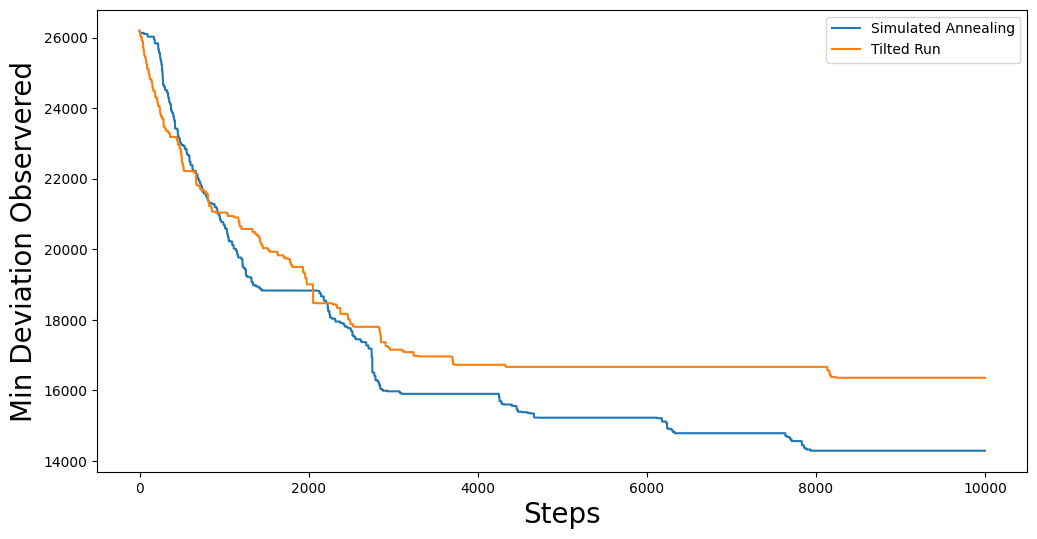

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
#plt.plot(min_scores_sb, label="Short Bursts")
plt.plot(min_scores_anneal, label="Simulated Annealing")
plt.plot(min_scores_tilt, label="Tilted Run")
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Min Deviation Observered", fontsize=20)
plt.legend()
plt.show()

In [ ]:
# In your Jupyter Notebook cell
#from falcomchain.partition import supergraph
from falcomchain.markovchain import hierarchical_recom
from falcomchain.tree import bipartition_tree
# Load the debugger magic command
%pdb on 

total_steps = 1000
partitions = {}
min_scores_tilt = np.zeros(total_steps)

# The exception will be raised from within this loop
for i, part in enumerate(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True)):
    try:
        min_scores_tilt[i] = optimizer.best_score
        partitions[i] = optimizer.best_part

        # Call your function here, which will re-raise the error
        
        hierarchical_recom(partition) # Pass the current part object being generated
        
    except Exception as e:
        print(f"\nCaught the error on step {i}. Entering debugger.")
        # This will drop you into an interactive debugging session
        %debug 
        break # Exit the loop after debugging if you want

## Two problems
# 1. To update super district names, we need to give an assignment of supernodes in proposal
# 2. If we will run the recursive tree cut for the whole supergraph, then we need to use dynamic epsilons

Automatic pdb calling has been turned ON


  0%|          | 0/1000 [00:00<?, ?it/s]


Caught the error on step 0. Entering debugger.


In [ ]:
import sys
from dataclasses import dataclass, field
from typing import Any, Dict, Set


# The revised logic:

MAX_TRIES = 100
cut_object = None
original_exception = None

for attempt in range(MAX_TRIES):
    # Dynamically change the density parameter for each attempt
    # The value of density should change in a meaningful way specific to your use case
    # For example, decreasing density slightly each time
    current_density = density - (attempt * some_step_value) # You need to define how density changes
    
    try:
        cut_object = bipartition_tree(
            graph.subgraph(remaining_nodes),
            column_names=column_names,
            pop_target=new_pop_target,
            capacity_level=capacity_level,
            n_teams=remaining_teams,
            epsilon=new_epsilon,
            two_sided=two_sided,
            supergraph=supergraph,
            # Use the current density for this attempt
            density=current_density, 
            snapshot=snapshot,
            iteration=iteration,
        )
        # If the call succeeds, break the loop
        break

    except RuntimeError as e:
        # Store the last exception. If the loop finishes without success, this will be raised.
        original_exception = e
        print(f"Attempt {attempt + 1}/{MAX_TRIES} failed with RuntimeError. Retrying with different density.")
        # Continue to the next iteration of the loop to try a new density
        continue 
    except Exception:
        # Handle other unexpected exceptions immediately if they are not the target RuntimeError
        raise

# After the loop finishes:

if cut_object is None:
    # If we tried MAX_TRIES times and still couldn't find a valid cut_object
    print(f"All {MAX_TRIES} attempts failed. Re-raising the original RuntimeError.")
    if original_exception:
        # Re-raise the original exception caught in the last attempt
        raise original_exception
    else:
        # Fallback if somehow no exception was captured but cut_object is None
        raise RuntimeError("bipartition_tree failed repeatedly for an unknown reason.")
else:
    # If we successfully found a cut_object, proceed with the rest of the program
    print("Successfully found a valid cut_object.")
    # You can now use cut_object for subsequent operations


In [8]:
for part in initial_solution.parts.keys():
    pop = initial_solution.part_pop(part)
    if pop == 4149:
        print(part)

In [9]:
parts= {252, 332, 503}
print(sum(initial_solution.part_pop(part) for part in parts))
for part in parts:
    print(len(initial_solution.candidates[part]))

4149
7
2
5


In [10]:
e = 0.1
count = 0
for part in initial_solution.parts.keys():
    pop = initial_solution.part_pop(part)
    teams = initial_solution.teams[part]
    if 1500*teams - e*1500*teams <= pop <= e*1500*teams + 1500*teams:
        continue
    else:
        count +=1
        print(pop, teams,  (pop - 1500*teams))
print("total", count)

total 0


In [13]:
len(initial_solution.parts)

549

In [12]:
e = 0.1
count = 0
for part in initial_solution.parts.keys():
    pop = initial_solution.supergraph.nodes[part]["population"]
    teams = initial_solution.teams[part]
    if 1500*teams - e*1500 -50<= pop <= e*1500 + 1500*teams +50:
        continue
    else:
        print(pop, teams,  (pop - 1500*teams, "district", part))


4719 3 (219, 'district', 27)
4744 3 (244, 'district', 74)
3213 2 (213, 'district', 121)
4718 3 (218, 'district', 169)
4769 3 (269, 'district', 183)
2797 2 (-203, 'district', 430)
4750 3 (250, 'district', 470)
4741 3 (241, 'district', 500)
4759 3 (259, 'district', 545)


In [6]:
import json
import os
from pathlib import Path

path = "/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-app/data/trees"
i=1

base = Path(path)
base.mkdir(parents=True, exist_ok=True)





while i <= 549:  
    path = base / f"tree_{1}.json"  
    with open(path, 'r') as f:
        tree = json.load(f)    # spanning tree dictionary
        
    if tree["metadata"]["n_teams"] <= 3:
        print("iteration", i)
        print(tree["metadata"])
    i+=1

In [7]:
path_d = "/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-app/data/districts"
base = Path(path_d)
e=0.1
weird = set()
for i in range(1, 550):
    path= base / f"district_{i}.json"  
    
    with open(path, 'r') as f:
        district = json.load(f)


    pop = district["metadata"]["tot_pop"] 
    teams = district["metadata"]["hired_teams"]
    if not 1500*teams - e*1500 <= pop <= e*1500 + 1500*teams:
        weird.add(i)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-app/data/districts/district_6.json'

In [5]:
path_t = "/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-app/data/trees"
path_d = "/Users/kirtisoglu/Documents/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/JS-app/data/districts"

base_t = Path(path_t)
base_d = Path(path_d)
weird_sorted = sorted(list(weird))
for i in weird_sorted:
    path_1= base_t / f"tree_{i}.json" 
    path_2= base_d / f"district_{i}.json" 
    path_3= base_t / f"tree_{i+1}.json"  
    
    with open(path_1, 'r') as f:
        tree_i = json.load(f)
    with open(path_2, 'r') as f:
        district_i = json.load(f)
    with open(path_3, 'r') as f:
        tree_ii = json.load(f)
    

    pop_tree_i = tree_i["metadata"]["tot_pop"] 
    teams_i = tree_i["metadata"]["n_teams"]
    #eps_d = district_i["metadata"]["'epsilon'"]
    
    pop_d = district_i["metadata"]["tot_pop"] 
    teams_d = district_i["metadata"]["hired_teams"]
    #eps_d = district_i["metadata"]["'epsilon'"]
    
    pop_tree_ii = tree_ii["metadata"]["tot_pop"] 
    teams_ii = tree_ii["metadata"]["n_teams"]
    
    error_i = pop_tree_i - teams_i*1500
    error_d = pop_d - teams_d*1500
    error_ii = pop_tree_ii - teams_ii*1500
    

     
    print(f"before the cut, error was {error_i} for {teams_i} teams")
    print(f"district has the error {error_d} for {teams_d} teams")
    print(f"after the cut, error became {error_ii} for {teams_ii} teams")
    print(tree_i["metadata"])
    print(district_i["metadata"])
    print(tree_ii["metadata"])
    print("---------------------------------------------------------------------------------------------------------------------------------------------------------")



NameError: name 'Path' is not defined

In [39]:

pop = 4759
ideal_pop = 1572.5
e = 0.1

a = pop - 3 * ideal_pop
a

41.5

In [42]:
(ideal_pop - 1500) 

72.5

In [ ]:
 def has_ideal_pop(self, assign_team, pop):
        return (
            abs(pop - assign_team * self.ideal_pop)
            <= self.ideal_pop * self.epsilon
        )

    def complement_has_the_ideal_pop(self, assign_team, pop):
        return (
            abs((self.tot_pop - pop) - assign_team * self.ideal_pop)
            <= self.ideal_pop * self.epsilon

In [16]:
if 36138 in initial_solution.parts[545]:
    print("yes")

yes


In [17]:
path_4= base_t / f"tree_{545}.json"  
    
with open(path_4, 'r') as f:
    tree = json.load(f)

In [22]:
edge_list = []
for edge_dict in tree['links']:
    u = int(edge_dict['source'])
    v = int(edge_dict['target'])
    edge_list.append((u,v))
print(edge_list)

[(2048, 33702), (2048, 19306), (2048, 17781), (2049, 10739), (2049, 11513), (12802, 1899), (13826, 25901), (13826, 8764), (13828, 13829), (13828, 25773), (13828, 25411), (13829, 7142), (13829, 34781), (13829, 18232), (13829, 25901), (13830, 11504), (20998, 26891), (5653, 6103), (5653, 4364), (29205, 32006), (29205, 36227), (29205, 9568), (29206, 11513), (29206, 9568), (29212, 6706), (29212, 25811), (29212, 35046), (14879, 29373), (25127, 32009), (25130, 6224), (8747, 32362), (33323, 11513), (3120, 36137), (6706, 14119), (34868, 33266), (34868, 21294), (34868, 20445), (34868, 35022), (34869, 33266), (10809, 34382), (8764, 26441), (31805, 32014), (31805, 27724), (30276, 30816), (30276, 11513), (30276, 32015), (10825, 29872), (10825, 39189), (27723, 34250), (27724, 34249), (27724, 25797), (27724, 17781), (34382, 29866), (34382, 34384), (6224, 24908), (8272, 29375), (8272, 24197), (1109, 26441), (7260, 34485), (7260, 18726), (7260, 36136), (7260, 17502), (7260, 26554), (5726, 14016), (1750

In [27]:
import networkx as nx
G = nx.from_edgelist(edge_list)
root = 36138
print(G.degree(root))

3


In [26]:
sum(graphhh.nodes[node]['candidate'] for node in G.nodes)
    

25

In [31]:
comp = set(G.nodes) - nodes
sum(graphhh.nodes[node]['population'] for node in comp)

4759

pop, teams, pop - 1500*teams, "district", part

4719 3 (219, 'district', 27)
4744 3 (244, 'district', 74)
3213 2 (213, 'district', 121)
4718 3 (218, 'district', 169)
4769 3 (269, 'district', 183)
2797 2 (-203, 'district', 430)
4750 3 (250, 'district', 470)
4741 3 (241, 'district', 500)
4759 3 (259, 'district', 545)

In [4]:
for i in range(1, 550):
    path_2= base_d / f"district_{i}.json"  
    
    with open(path_2, 'r') as f:
        district = json.load(f)


    debt = district["metadata"]["debt"] 
    print(debt, f"iteration {i}")

 debt += pop - pop_target * hired_teams 

IndentationError: unindent does not match any outer indentation level (<string>, line 11)

In [ ]:
for i in range(1, 543):
tree["metadata"]["n_teams"]
    if 1500*teams - e*1500 <= pop <= e*1500 + 1500*teams == False:
        print(tree["metadata"])
    
    for part in initial_solution.parts.keys():
    pop = initial_solution.supergraph.nodes[part]["population"]
    teams = initial_solution.teams[part]

In [ ]:
metadata = {
        "ideal_pop": _to_py(getattr(tree, "ideal_pop", None)),
        "root": str(getattr(tree, "root", "")),
        "n_teams": _to_py(getattr(tree, "n_teams", None)),
        "epsilon": _to_py(getattr(tree, "epsilon", None)),
        "two_sided": _to_py(getattr(tree, "two_sided", None)),
        "tot_candidates": _to_py(getattr(tree, "tot_candidates", None)),
        "tot_pop": _to_py(getattr(tree, "tot_pop", None)),
    }

initial_solution['population']

for p in base.glob("tree_*.json"):  # or "*.json"
    try:
        p.unlink()
    except FileNotFoundError:
        pass

In [ ]:
"Plot side by side"
fig, regions_initial_new, regions_final_new, centers, others = plt.compare(initial_partition, final_partition)
fig


# Last result for average radius with fixed travel time

In [ ]:
import matplotlib.pyplot as mplt
fig, ax = mplt.subplots(figsize=(12,6))
mplt.plot(min_scores_tilt, label="Tilted Run")
mplt.xlabel("Steps", fontsize=20)
mplt.ylabel("Sum of radius_average", fontsize=20)
mplt.legend()
mplt.show()

In [ ]:
"Plot side by side"
fig, regions_initial_new, regions_final_new, centers, others = plt.compare(initial_partition, final_partition)
fig

In [ ]:
#sum_travel_radius = lambda p: np.sum(p.radius.values())
num_cut_edges = lambda p: len(p["cut_edges"])
average_radius = lambda p: np.sum(abs((np.array(list(p.radius.values())) - np.sum(list(p.radius.values())) / len(p))**2))

In [ ]:
import gerrytools

import matplotlib.pyplot as plt
from gerrytools.scoring import *
from gerrytools.plotting import *
import gerrytools.plotting.colors as colors
import numpy as np

N = len(regions_final_new)

dists = regions_final_new.to_crs("EPSG:3857")
dists["final_district"] = dists["final_district"].astype(int)
dists=dists.sort_values(by="final_district")
dists["colorindex"] = list(range(N))
dists["color"] = colors.districtr(N)

ax = drawplan(chicago, assignment="final_district", overlays=None)

In [ ]:
import maup
from maup import repair

In [ ]:
maup.doctor(chicago)

In [ ]:
repair.count_holes(chicago)

In [ ]:
maup.repair.autorepair(chicago)

In [ ]:
final_partition.plot(chicago, figsize=(10, 10), cmap="tab20")
mplt.axis('off')
mplt.show()

In [ ]:
import numpy as np
print("1) Number of Cut Edges")
print("    Best score: ", optimizer.best_score)
print("    Initial score: ", len(initial_partition["cut_edges"]))
print("2) Sum of Travel Radius")
print("    Initial: ", np.sum(list(initial_partition.radius.values())))
print("    Final: ", np.sum(list(final_partition.radius.values())))
print("3) Sum of Radius Devitation")
print("    Initial: ", sum(abs(np.array(list(initial_partition.radius.values())) - sum(x for x in initial_partition.radius.values()) / len(initial_partition))**2))
print("    Final: ", sum(abs(np.array(list(final_partition.radius.values())) - sum(x for x in final_partition.radius.values())/ len(final_partition))**2 ))

In [ ]:
"""pcompress
radiuss = {}
i=0
for optimizer in Record(optimizer.tilted_run(total_steps, p=0.125, with_progress_bar=True), "pa-run.chain"):
    # normal chain stuff here
    partition = optimizer.best_part
    radius = partition.radius
    radiuss[i] = radius 
    i+= 1"""

In [ ]:
"Watch"
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

import pandas as pd

import matplotlib.cm as mcm
import matplotlib.pyplot as mplt
import networkx as nx
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

frames = []
district_data = []

for i, partition in enumerate(recom_chain):
    for district_name in partition.perimeter.keys():
        population = partition.population[district_name]
        perimeter = partition.perimeter[district_name]
        area = partition.area[district_name]
        district_data.append((i, district_name, population, perimeter, area))

    buffer = io.BytesIO()
    fig, ax = plt.subplots(figsize=(10,10))
    partition.plot(ax=ax, cmap='tab20')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    frames.append(image)
    plt.close(fig)

df = pd.DataFrame(
    district_data,
    columns=[
        'step',
        'district_name',
        'population',
        'perimeter',
        'area'
    ]
)

def show_frame(idx):
    clear_output(wait=True)
    display(frames[idx])

slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')
slider.layout.width = '500px'
widgets.interactive(show_frame, idx=slider)
#df.head(5)
#The perimeter and area attributes are actually not present in the MN_precincts.geojson file, but the GeographicPartition class will calculate them at instantiation time using the geometries provided in the file.

# Save

In [ ]:
#final_partition = optimizer.best_part
#for partition in pcompress.Record(optimizer, "run.chain", executable="pv", extreme=True):
#    print(partition.population)

#final_partition = optimizer.best_part
#handler = DataHandler()
#handler.load_final_assignment()
#final_partition = optimizer.best_part
#final_assignment = dict(final_partition.assignment)
#pd.to_pickle(final_assignment, '/Users/kirtisoglu/Documents/GitHub/Allocation-of-Primary-Care-Centers-in-Chicago/prepared_data/final_assignment.pkl')
#final_assignment = handler.load_final_assignment()
#final_assignment = Partition(graph, final_assignment, updaters=my_updaters)

# Local Search

In [ ]:
# We can run each of the optimization methods and collect some data

total_steps = 10000

# Short Bursts
min_scores_sb = np.zeros(total_steps)
for i, part in enumerate(optimizer.short_bursts(5, 2000, with_progress_bar=True)):
    min_scores_sb[i] = optimizer.best_score

# Simulated Annealing
min_scores_anneal = np.zeros(total_steps)
for i, part in enumerate(
    optimizer.simulated_annealing(
        total_steps,
        optimizer.jumpcycle_beta_function(200, 800),
        beta_magnitude=1,
        with_progress_bar=True
    )
):
    min_scores_anneal[i] = optimizer.best_score